In [246]:
import numpy as np
import torch
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
# from torchsummary import summary
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import torch.nn as nn
from sklearn.metrics import matthews_corrcoef
import warnings
from sklearn import metrics
import torch.nn.init as init
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.metrics import accuracy_score

In [247]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNetCV
# from operator import itemgetter
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,train_test_split,StratifiedKFold,KFold,cross_val_score,GroupKFold
from sklearn.feature_selection import RFE,VarianceThreshold,RFECV,SelectFromModel
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier,StackingClassifier,VotingClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
# from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.metrics import make_scorer,matthews_corrcoef
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


In [252]:
per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
                                 "Specificity","BA","AUC-ROC","AUC-PR","MCC"])

per_index

Empty DataFrame
Columns: [Model, Dataset, Preprocessing, F1 (Toxic), Precision (Toxic), Sensitivity, Specificity, BA, AUC-ROC, AUC-PR, MCC]
Index: []

In [123]:
import pandas as pd
from sklearn.metrics import confusion_matrix,roc_auc_score,average_precision_score
##
def performance(per_index,model_name,dataset,preprocessing,y_true,y_pred):
#     if not(per_index):
#         try:
#             per_index = pd.read_csv("performance.csv",index_col = 0)
#         except:
#             per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
#                                  "Specificity","BA","AUC-ROC","AUC-PR","MCC"])
#             per_index.to_csv("performance.csv",index=False)
#     else:
#         pass
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificifty = tn/(tn+fp)
    BA = (recall + specificifty)/2
    x = (fp + tp)*(fp+tn)*(tp+fn)*(tn+fn)
    mcc = (tp*tn - fp*fn) / pow(x,0.5)
    f1 =  2 * (precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true, y_pred)
    # 计算 AUC-PR
    pr_auc = average_precision_score(y_true, y_pred)
    data = {
    "Model": model_name,
    "Dataset": dataset,
    "Preprocessing": preprocessing,
    "F1 (Toxic)": f1,
    "Precision (Toxic)": precision,
    "Sensitivity": recall,
    "Specificity": specificifty,
    "BA": BA,
    "AUC-ROC": roc_auc,
    "AUC-PR": pr_auc,
    "MCC": mcc
    }
    per_index = pd.concat([per_index, pd.DataFrame([data])], ignore_index=True)
    return per_index

In [124]:
def MCC_Loss(y_pred, y_true, class_weights):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)
    x = (fp + tp) * (fp + tn) * (tp + fn) * (tn + fn) + 1e-7
    mcc = (tp * tn - fp * fn) / torch.pow(x, 0.5)

    mcc = torch.where(torch.isnan(mcc), torch.zeros_like(mcc), mcc)
    weighted_mcc = mcc * class_weights  # 權重更新
    return 1 - torch.mean(weighted_mcc)

    
def f1_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)
def recall_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    r = torch.where(torch.isnan(r), torch.zeros_like(r), r)
    return 1 - torch.mean(r)
def sp_loss(y_pred,y_true):
    tp = torch.sum((y_true * y_pred).float(), axis=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), axis=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), axis=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), axis=0)

    sp = tn / (tn + fp + 1e-7)


    sp = torch.where(torch.isnan(sp), torch.zeros_like(sp), sp)
    return 1 - torch.mean(sp)


In [125]:
def calculate_class_weights(y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    class_weights = total_samples / counts
    return torch.tensor(class_weights, dtype=torch.float32)




In [126]:
seed = 42
torch.manual_seed(seed)
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
#         self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.4)
        self.fc2 = torch.nn.Linear(64, 8)
        self.bn2 = torch.nn.BatchNorm1d(8)
        self.fc3 = torch.nn.Linear(8,1)

     
   


        # 使用 He 初始化
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.kaiming_normal_(param, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
#         x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
#         out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
#         out = self.dropout2(out)
        out = self.relu(out)
        out = torch.sigmoid(out)
        return out.squeeze(1)

In [245]:
def train(model, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0.0
    total = 0
    y_true = []
    y_pred = []
    for i, (inputs, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = MCC_Loss(outputs, labels,calculate_class_weights(y_train))
        l1_lambda = 0.000045
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
        predicted = predicted.flatten()
        total += labels.size(0)
        labels = labels.cpu().numpy()
        correct += (predicted == labels).sum().item()
        y_true.extend(labels)
        y_pred.extend(predicted.tolist())
    train_loss = running_loss / len(train_loader)
    t_f1 = f1_score(y_true, y_pred)
    t_mcc = matthews_corrcoef(y_true, y_pred)
    tcombined_score = (t_f1 + t_mcc) / 2
    mtr = metrics.confusion_matrix(y_true, y_pred)
    return train_loss,t_f1,t_mcc,tcombined_score,mtr

def validate(model, val_loader, l2_lambda):
    model.eval()
    running_loss = 0.0
    correct = 0.0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = MCC_Loss(outputs, labels,calculate_class_weights(y_train))
            l1_lambda = 0.000045
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
        val_loss = running_loss / len(val_loader)
        val_f1 = f1_score(y_true, y_pred)
        val_mcc = matthews_corrcoef(y_true, y_pred)
        mtr = metrics.confusion_matrix(y_true, y_pred)
        combined_score = (val_f1 + val_mcc) / 2
    return val_loss, val_f1, val_mcc, combined_score,mtr
def test(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss =  MCC_Loss(outputs, labels,calculate_class_weights(y_test)) 
            l1_lambda = 0.000045
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
            running_loss += loss.item()
            predicted = torch.round(outputs).squeeze().cpu().detach().numpy()
            predicted = predicted.flatten()
            total += labels.size(0)
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted.tolist())
    test_loss = running_loss / len(test_loader)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    mtr = metrics.confusion_matrix(y_true, y_pred)
    return test_loss, f1,mcc,mtr,y_true,y_pred

In [186]:
df = pd.read_csv("data.csv",index_col=0)
df = df[df["Toxicity"] != -1]
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6587  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6588  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6589  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6590  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6591  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6587  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6588  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6589  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6590  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6591  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [187]:
df = df.reset_index()
df.drop(columns="index",inplace=True)
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6563  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6564  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6565  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6566  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6567  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6563  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6564  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6565  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6566  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6567  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [130]:
for i in range(len(df)):
    for y in range(i+1,len(df)):
        if(df["Inchi"][i] == df["Inchi"][y]):
            print("Same")
print("After Crose checking,There is no same compound")





After Crose checking,There is no same compound


In [131]:
# 計算每個分子的指紋表示
num = 1
fingerprints = []
for x in df["Inchi"]:
    mol = Chem.MolFromInchi(x)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fp_arr = np.array([int(x) for x in fp_arr], dtype=np.float32)
    fingerprints.append(fp_arr)
#     except:
#         print("Fail time : {}".format(num))
#         num = num + 1
#         pass


[18:27:19] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match)

[18:27:20] WARNING: not removing hydrogen atom without neighbors
[18:27:20] WARNING: not removing hydrogen atom without neighbors


In [132]:
feature = fingerprints
feature = pd.DataFrame(feature)
feature

0     1     2     3     4     5     6     7     8     9     ...  2038   
0      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6563   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6566   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2039  2040  2041  2042  2043  2044  2045  2046  2047  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6563   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6566   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[6568 rows x 2048 columns]

In [133]:
labels = df["Toxicity"]
labels = labels.values
labels = labels.astype(np.int64)


In [134]:
df1 = feature  # 假設 fingerprints 是你的數據
df1["Toxicity"] = df["Toxicity"]
duplicates = df1.duplicated()

print("Number of duplicate rows:", duplicates.sum())
print(duplicates.value_counts())
tox = 0
notox = 0
for i in range(len(df1)):
    if(duplicates[i] == True):
        if(df1["Toxicity"][i] == 1):
            tox += 1
        else:
            notox += 1
print(tox,notox)
df_unique = df1.drop_duplicates()

df_unique

Number of duplicate rows: 226
False    6342
True      226
Name: count, dtype: int64
22 204


0    1    2    3    4    5    6    7    8    9  ...  2039  2040  2041   
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0  \
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
6562  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6564  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6565  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6566  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
6567  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      2042  2043  2044  2045  2046  2047  Toxicity  
0      0.0   0.0   0.0   0.0   0.0   0.0         0  
1      0.0   0.0   0.0   0.0   0.0   0.0         0  
2      0.0   0.0   0.0   0.0   0.0   0.0         0  
3      0.0   0.0   0.0   0.0   0.0   0.0         0  
4      0.0   0.0   0.0   0.0   0.0   0.0         0  
...    ...   ...   ...   ...   ...   ...       ...  
6562   0.0   0.0   0.0   0.0   0.0   0.0         0  
6564   0.0   0.0   0.0   0.0   0.0   0.0         1  
6565   0.0   0.0   0.0   0.0   0.0   0.0         0  
6566   0.0   0.0   0.0   0.0   0.0   0.0         0  
6567   0.0   0.0   0.0   0.0   0.0   0.0         1  

[6342 rows x 2049 columns]

In [150]:
df_unique["Toxicity"].value_counts()

Toxicity
0    5422
1     920
Name: count, dtype: int64

In [151]:
label = df_unique["Toxicity"]
fingerprints = df_unique.drop(columns = "Toxicity",axis = 1,inplace=False)
df_unique["Toxicity"].value_counts()
fingerprints

0     1     2     3     4     5     6     7     8     9     ...  2038   
0      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6566   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2039  2040  2041  2042  2043  2044  2045  2046  2047  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6566   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[6342 rows x 2048 columns]

In [152]:
label.value_counts()

Toxicity
0    5422
1     920
Name: count, dtype: int64

In [153]:
# feature.drop(columns="Toxicity",axis=1,inplace=True)
feature = fingerprints
feature

0     1     2     3     4     5     6     7     8     9     ...  2038   
0      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6566   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2039  2040  2041  2042  2043  2044  2045  2046  2047  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6562   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6564   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6565   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6566   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6567   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[6342 rows x 2048 columns]

In [154]:
def PCA_func(fingerprint1,fingerprint2):

    print(np.array(fingerprint1).shape)
    print(np.array(fingerprint2).shape)
    # 將PCA結果轉換為DataFrame
    train_pca_df = pd.DataFrame(data=fingerprint1, columns=['PC1', 'PC2'])
    test_pca_df = pd.DataFrame(data=fingerprint2, columns=['PC1', 'PC2'])

    # 繪製化學空間分佈圖
    plt.scatter(train_pca_df['PC1'], train_pca_df['PC2'], c='blue', label='Non-Toxicity')
    plt.scatter(test_pca_df['PC1'], test_pca_df['PC2'], c='red', label='Toxicity')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Chemical Space Distribution (Unbalanced)')
    plt.legend()
    plt.show()

In [155]:
feature.shape

(6342, 2048)

In [156]:
#copy tox to dataset
positive_indices = np.where(label == 1)[0]
negative_indices = np.where(label == 0)[0]
label = np.array(label)

positive_samples = np.array(feature)[positive_indices]
pos_label = label[positive_indices]
pos_copy = positive_samples.copy()
pos_copy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [157]:
print(pos_copy.shape,pos_label.shape)
pos_label_reshaped = pos_label.reshape(-1, 1)  # 將 pos_label 轉換為二維
final_array = np.hstack([pos_copy, pos_label_reshaped])  # 水平堆疊兩個數組

print(final_array.shape)
final_df = pd.DataFrame(final_array)
final_df

(920, 2048) (920,)
(920, 2049)


0     1     2     3     4     5     6     7     8     9     ...  2039   
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1     0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
915   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  ...   0.0   
916   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
917   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
918   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
919   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

     2040  2041  2042  2043  2044  2045  2046  2047  2048  
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
4     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
915   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
916   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
917   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
918   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
919   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  

[920 rows x 2049 columns]

In [158]:
arr_repeated = np.repeat(final_array, 6,axis = 0)
arr_repeated.shape

(5520, 2049)

In [159]:
neg = np.array(feature)[negative_indices]
negative_indices = np.where(label == 0)[0]
label = np.array(label)

neg_label = label[negative_indices]
neg_label_reshaped = neg_label.reshape(-1, 1)  # 將 pos_label 轉換為二維
final_array = np.hstack([neg, neg_label_reshaped])  # 水平堆疊兩個數組
final_array.shape

(5422, 2049)

In [160]:
final = np.concatenate([arr_repeated,final_array])
final.shape

(10942, 2049)

In [161]:
final_df = pd.DataFrame(final)
final_df

0     1     2     3     4     5     6     7     8     9     ...  2039   
0       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0  \
1       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
10937   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
10938   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
10939   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
10940   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
10941   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

       2040  2041  2042  2043  2044  2045  2046  2047  2048  
0       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
1       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
2       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
3       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
4       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
10937   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10938   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10939   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10940   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10941   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10942 rows x 2049 columns]

In [162]:
feature = final_df.iloc[:,:-1].values
label = final_df.iloc[:,2048].values
print(feature.shape,label.shape)

(10942, 2048) (10942,)


In [163]:
X_train,X_test,y_train,y_test = train_test_split(feature,label,stratify=label,test_size=0.2)

In [164]:
# # # 分離陽性和陰性樣本
# positive_indices = np.where(np.array(label) == 1)[0]
# negative_indices = np.where(np.array(label) == 0)[0]


# positive_samples = np.array(fingerprints)[positive_indices]
# negative_samples = np.array(fingerprints)[negative_indices]
# np.random.seed(42)  # 設定隨機種子以確保可重現性

# # 從陽性樣本中隨機選擇500筆
# positive_test_indices = np.random.choice(positive_indices, size=400, replace=False)

# # 從陰性樣本中隨機選擇500筆
# negative_test_indices = np.random.choice(negative_indices, size=400, replace=False)

# # 將兩個測試集合併
# test_indices = np.concatenate((positive_test_indices, negative_test_indices))


# # 將測試集和訓練集分開
# train_indices = np.setdiff1d(np.arange(len(label)), test_indices)

# X_train_, X_test = np.array(fingerprints)[train_indices], np.array(fingerprints)[test_indices]
# y_train_, y_test = np.array(label)[train_indices], np.array(label)[test_indices]
# print(X_train_.shape,X_test.shape,y_train_.shape,y_test.shape)
# print(pd.Series(y_train_).value_counts())


In [165]:
print(pd.Series(y_test).value_counts())

1.0    1104
0.0    1085
Name: count, dtype: int64


(4416, 2)
(4337, 2)


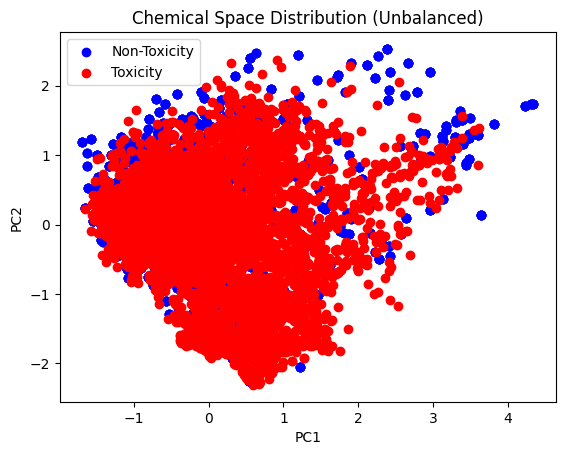

(1104, 2)
(1085, 2)


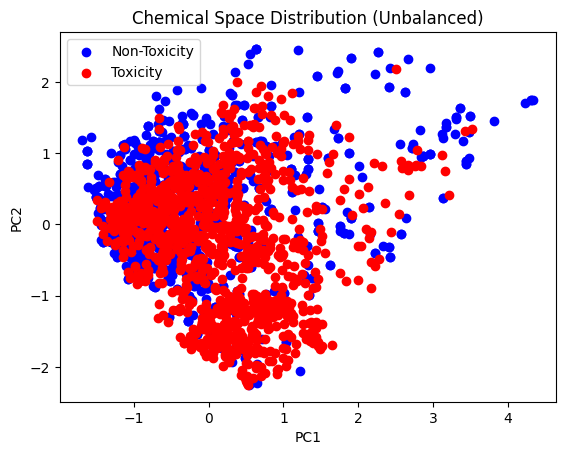

In [167]:
pca1 = PCA(n_components=2)
X_t = pca1.fit_transform(X_train)

positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(positive_samples,negative_samples)
X_t = pca1.transform(X_test)
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]
PCA_func(positive_samples,negative_samples)

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 假設 X 是特徵，y 是目標變數
# X, y = load_your_data_here()

# 計算互信息
mi = mutual_info_classif(X_train, y_train)

# 決定我們要試驗的特徵數量
k_values = range(1, len(mi)+1)

best_score = 0
best_k = 0
best_X = None

# 在迴圈開始前初始化兩個空列表
k_list = []
scores_list = []

for k in k_values:
    # 選擇前k個最重要的特徵
    selection = SelectKBest(score_func=mutual_info_classif, k=k)
    select_X = selection.fit_transform(X_train, y_train)
    
    # 使用隨機森林進行交叉驗證
    clf = RandomForestClassifier(random_state=0)
    scores = cross_val_score(clf, select_X, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    
    print(f"K={k}, n={select_X.shape[1]}, Accuracy: {mean_score:.2f} (+/- {scores.std():.2f})")

    # 如果這個k值的得分比我們之前找到的得分還高，則更新最佳k值和數據集
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_X = select_X

    # 將每個k值和對應的評分添加到列表中
    k_list.append(k)
    scores_list.append(mean_score)

print(f"Best k={best_k}, Accuracy: {best_score:.2f}")

K=1, n=1, Accuracy: 0.73 (+/- 0.01)
K=2, n=2, Accuracy: 0.73 (+/- 0.01)
K=3, n=3, Accuracy: 0.73 (+/- 0.01)
K=4, n=4, Accuracy: 0.72 (+/- 0.01)
K=5, n=5, Accuracy: 0.64 (+/- 0.00)
K=6, n=6, Accuracy: 0.67 (+/- 0.00)
K=7, n=7, Accuracy: 0.72 (+/- 0.01)
K=8, n=8, Accuracy: 0.65 (+/- 0.00)
K=9, n=9, Accuracy: 0.70 (+/- 0.01)
K=10, n=10, Accuracy: 0.74 (+/- 0.00)
K=11, n=11, Accuracy: 0.74 (+/- 0.01)
K=12, n=12, Accuracy: 0.72 (+/- 0.01)
K=13, n=13, Accuracy: 0.71 (+/- 0.01)
K=14, n=14, Accuracy: 0.74 (+/- 0.01)
K=15, n=15, Accuracy: 0.70 (+/- 0.00)
K=16, n=16, Accuracy: 0.71 (+/- 0.02)
K=17, n=17, Accuracy: 0.69 (+/- 0.01)
K=18, n=18, Accuracy: 0.73 (+/- 0.01)
K=19, n=19, Accuracy: 0.71 (+/- 0.01)
K=20, n=20, Accuracy: 0.73 (+/- 0.01)
K=21, n=21, Accuracy: 0.74 (+/- 0.01)
K=22, n=22, Accuracy: 0.75 (+/- 0.01)
K=23, n=23, Accuracy: 0.75 (+/- 0.01)
K=24, n=24, Accuracy: 0.74 (+/- 0.01)
K=25, n=25, Accuracy: 0.75 (+/- 0.01)
K=26, n=26, Accuracy: 0.74 (+/- 0.01)
K=27, n=27, Accuracy: 0.74 (+/

K=212, n=212, Accuracy: 0.92 (+/- 0.01)
K=213, n=213, Accuracy: 0.91 (+/- 0.01)
K=214, n=214, Accuracy: 0.92 (+/- 0.00)
K=215, n=215, Accuracy: 0.93 (+/- 0.00)
K=216, n=216, Accuracy: 0.92 (+/- 0.00)
K=217, n=217, Accuracy: 0.93 (+/- 0.01)
K=218, n=218, Accuracy: 0.93 (+/- 0.00)
K=219, n=219, Accuracy: 0.91 (+/- 0.01)
K=220, n=220, Accuracy: 0.93 (+/- 0.00)
K=221, n=221, Accuracy: 0.92 (+/- 0.01)
K=222, n=222, Accuracy: 0.93 (+/- 0.00)
K=223, n=223, Accuracy: 0.92 (+/- 0.00)
K=224, n=224, Accuracy: 0.93 (+/- 0.01)
K=225, n=225, Accuracy: 0.91 (+/- 0.01)
K=226, n=226, Accuracy: 0.92 (+/- 0.01)
K=227, n=227, Accuracy: 0.92 (+/- 0.00)
K=228, n=228, Accuracy: 0.91 (+/- 0.01)
K=229, n=229, Accuracy: 0.92 (+/- 0.01)
K=230, n=230, Accuracy: 0.91 (+/- 0.00)
K=231, n=231, Accuracy: 0.94 (+/- 0.00)
K=232, n=232, Accuracy: 0.91 (+/- 0.01)
K=233, n=233, Accuracy: 0.92 (+/- 0.00)
K=234, n=234, Accuracy: 0.91 (+/- 0.01)
K=235, n=235, Accuracy: 0.92 (+/- 0.01)
K=236, n=236, Accuracy: 0.92 (+/- 0.01)


K=417, n=417, Accuracy: 0.95 (+/- 0.00)
K=418, n=418, Accuracy: 0.95 (+/- 0.00)
K=419, n=419, Accuracy: 0.94 (+/- 0.00)
K=420, n=420, Accuracy: 0.94 (+/- 0.00)
K=421, n=421, Accuracy: 0.95 (+/- 0.00)
K=422, n=422, Accuracy: 0.95 (+/- 0.01)
K=423, n=423, Accuracy: 0.95 (+/- 0.01)
K=424, n=424, Accuracy: 0.95 (+/- 0.01)
K=425, n=425, Accuracy: 0.95 (+/- 0.00)
K=426, n=426, Accuracy: 0.95 (+/- 0.00)
K=427, n=427, Accuracy: 0.95 (+/- 0.00)
K=428, n=428, Accuracy: 0.95 (+/- 0.00)
K=429, n=429, Accuracy: 0.94 (+/- 0.00)
K=430, n=430, Accuracy: 0.95 (+/- 0.00)
K=431, n=431, Accuracy: 0.94 (+/- 0.01)
K=432, n=432, Accuracy: 0.96 (+/- 0.00)
K=433, n=433, Accuracy: 0.94 (+/- 0.00)
K=434, n=434, Accuracy: 0.96 (+/- 0.00)
K=435, n=435, Accuracy: 0.95 (+/- 0.00)
K=436, n=436, Accuracy: 0.95 (+/- 0.00)
K=437, n=437, Accuracy: 0.95 (+/- 0.00)
K=438, n=438, Accuracy: 0.95 (+/- 0.00)
K=439, n=439, Accuracy: 0.95 (+/- 0.00)
K=440, n=440, Accuracy: 0.95 (+/- 0.00)
K=441, n=441, Accuracy: 0.95 (+/- 0.00)


K=622, n=622, Accuracy: 0.96 (+/- 0.00)
K=623, n=623, Accuracy: 0.96 (+/- 0.00)
K=624, n=624, Accuracy: 0.96 (+/- 0.00)
K=625, n=625, Accuracy: 0.96 (+/- 0.00)
K=626, n=626, Accuracy: 0.96 (+/- 0.00)
K=627, n=627, Accuracy: 0.96 (+/- 0.00)
K=628, n=628, Accuracy: 0.96 (+/- 0.00)
K=629, n=629, Accuracy: 0.96 (+/- 0.00)
K=630, n=630, Accuracy: 0.96 (+/- 0.00)
K=631, n=631, Accuracy: 0.96 (+/- 0.01)
K=632, n=632, Accuracy: 0.96 (+/- 0.00)
K=633, n=633, Accuracy: 0.96 (+/- 0.00)
K=634, n=634, Accuracy: 0.96 (+/- 0.00)
K=635, n=635, Accuracy: 0.96 (+/- 0.00)
K=636, n=636, Accuracy: 0.96 (+/- 0.00)
K=637, n=637, Accuracy: 0.96 (+/- 0.00)
K=638, n=638, Accuracy: 0.96 (+/- 0.00)
K=639, n=639, Accuracy: 0.96 (+/- 0.00)
K=640, n=640, Accuracy: 0.96 (+/- 0.00)
K=641, n=641, Accuracy: 0.96 (+/- 0.00)
K=642, n=642, Accuracy: 0.95 (+/- 0.00)
K=643, n=643, Accuracy: 0.96 (+/- 0.00)
K=644, n=644, Accuracy: 0.96 (+/- 0.00)
K=645, n=645, Accuracy: 0.96 (+/- 0.00)
K=646, n=646, Accuracy: 0.96 (+/- 0.00)


K=827, n=827, Accuracy: 0.96 (+/- 0.00)
K=828, n=828, Accuracy: 0.96 (+/- 0.00)
K=829, n=829, Accuracy: 0.96 (+/- 0.00)
K=830, n=830, Accuracy: 0.96 (+/- 0.00)
K=831, n=831, Accuracy: 0.96 (+/- 0.00)
K=832, n=832, Accuracy: 0.96 (+/- 0.00)
K=833, n=833, Accuracy: 0.96 (+/- 0.00)
K=834, n=834, Accuracy: 0.96 (+/- 0.00)
K=835, n=835, Accuracy: 0.97 (+/- 0.00)
K=836, n=836, Accuracy: 0.96 (+/- 0.00)
K=837, n=837, Accuracy: 0.96 (+/- 0.00)
K=838, n=838, Accuracy: 0.96 (+/- 0.00)
K=839, n=839, Accuracy: 0.96 (+/- 0.00)
K=840, n=840, Accuracy: 0.96 (+/- 0.00)
K=841, n=841, Accuracy: 0.96 (+/- 0.00)
K=842, n=842, Accuracy: 0.96 (+/- 0.00)
K=843, n=843, Accuracy: 0.96 (+/- 0.00)
K=844, n=844, Accuracy: 0.97 (+/- 0.00)
K=845, n=845, Accuracy: 0.96 (+/- 0.00)
K=846, n=846, Accuracy: 0.96 (+/- 0.00)
K=847, n=847, Accuracy: 0.96 (+/- 0.00)
K=848, n=848, Accuracy: 0.96 (+/- 0.00)
K=849, n=849, Accuracy: 0.96 (+/- 0.00)
K=850, n=850, Accuracy: 0.96 (+/- 0.00)
K=851, n=851, Accuracy: 0.96 (+/- 0.00)


K=1031, n=1031, Accuracy: 0.97 (+/- 0.00)
K=1032, n=1032, Accuracy: 0.97 (+/- 0.00)
K=1033, n=1033, Accuracy: 0.96 (+/- 0.00)
K=1034, n=1034, Accuracy: 0.96 (+/- 0.00)
K=1035, n=1035, Accuracy: 0.96 (+/- 0.00)
K=1036, n=1036, Accuracy: 0.96 (+/- 0.00)
K=1037, n=1037, Accuracy: 0.97 (+/- 0.00)
K=1038, n=1038, Accuracy: 0.97 (+/- 0.00)
K=1039, n=1039, Accuracy: 0.96 (+/- 0.00)
K=1040, n=1040, Accuracy: 0.96 (+/- 0.00)
K=1041, n=1041, Accuracy: 0.96 (+/- 0.00)
K=1042, n=1042, Accuracy: 0.96 (+/- 0.00)
K=1043, n=1043, Accuracy: 0.96 (+/- 0.00)
K=1044, n=1044, Accuracy: 0.96 (+/- 0.00)
K=1045, n=1045, Accuracy: 0.97 (+/- 0.00)
K=1046, n=1046, Accuracy: 0.96 (+/- 0.00)
K=1047, n=1047, Accuracy: 0.96 (+/- 0.00)
K=1048, n=1048, Accuracy: 0.96 (+/- 0.00)
K=1049, n=1049, Accuracy: 0.96 (+/- 0.00)
K=1050, n=1050, Accuracy: 0.96 (+/- 0.00)
K=1051, n=1051, Accuracy: 0.97 (+/- 0.00)
K=1052, n=1052, Accuracy: 0.96 (+/- 0.00)
K=1053, n=1053, Accuracy: 0.96 (+/- 0.00)
K=1054, n=1054, Accuracy: 0.96 (+/

K=1227, n=1227, Accuracy: 0.97 (+/- 0.00)
K=1228, n=1228, Accuracy: 0.96 (+/- 0.00)
K=1229, n=1229, Accuracy: 0.97 (+/- 0.00)
K=1230, n=1230, Accuracy: 0.97 (+/- 0.00)
K=1231, n=1231, Accuracy: 0.96 (+/- 0.00)
K=1232, n=1232, Accuracy: 0.97 (+/- 0.00)
K=1233, n=1233, Accuracy: 0.97 (+/- 0.00)
K=1234, n=1234, Accuracy: 0.96 (+/- 0.00)
K=1235, n=1235, Accuracy: 0.96 (+/- 0.00)
K=1236, n=1236, Accuracy: 0.96 (+/- 0.00)
K=1237, n=1237, Accuracy: 0.97 (+/- 0.00)
K=1238, n=1238, Accuracy: 0.96 (+/- 0.00)
K=1239, n=1239, Accuracy: 0.96 (+/- 0.00)
K=1240, n=1240, Accuracy: 0.96 (+/- 0.00)
K=1241, n=1241, Accuracy: 0.97 (+/- 0.00)
K=1242, n=1242, Accuracy: 0.96 (+/- 0.00)
K=1243, n=1243, Accuracy: 0.96 (+/- 0.00)
K=1244, n=1244, Accuracy: 0.96 (+/- 0.00)
K=1245, n=1245, Accuracy: 0.96 (+/- 0.00)
K=1246, n=1246, Accuracy: 0.96 (+/- 0.00)
K=1247, n=1247, Accuracy: 0.96 (+/- 0.00)
K=1248, n=1248, Accuracy: 0.96 (+/- 0.00)
K=1249, n=1249, Accuracy: 0.97 (+/- 0.00)
K=1250, n=1250, Accuracy: 0.96 (+/

K=1423, n=1423, Accuracy: 0.96 (+/- 0.00)
K=1424, n=1424, Accuracy: 0.97 (+/- 0.00)
K=1425, n=1425, Accuracy: 0.97 (+/- 0.00)
K=1426, n=1426, Accuracy: 0.96 (+/- 0.00)
K=1427, n=1427, Accuracy: 0.96 (+/- 0.00)
K=1428, n=1428, Accuracy: 0.96 (+/- 0.00)
K=1429, n=1429, Accuracy: 0.96 (+/- 0.00)
K=1430, n=1430, Accuracy: 0.96 (+/- 0.00)
K=1431, n=1431, Accuracy: 0.96 (+/- 0.00)
K=1432, n=1432, Accuracy: 0.96 (+/- 0.00)
K=1433, n=1433, Accuracy: 0.96 (+/- 0.00)
K=1434, n=1434, Accuracy: 0.96 (+/- 0.00)
K=1435, n=1435, Accuracy: 0.96 (+/- 0.00)
K=1436, n=1436, Accuracy: 0.96 (+/- 0.00)
K=1437, n=1437, Accuracy: 0.96 (+/- 0.00)
K=1438, n=1438, Accuracy: 0.97 (+/- 0.00)
K=1439, n=1439, Accuracy: 0.97 (+/- 0.00)
K=1440, n=1440, Accuracy: 0.96 (+/- 0.00)
K=1441, n=1441, Accuracy: 0.96 (+/- 0.00)
K=1442, n=1442, Accuracy: 0.96 (+/- 0.00)
K=1443, n=1443, Accuracy: 0.96 (+/- 0.00)
K=1444, n=1444, Accuracy: 0.96 (+/- 0.00)
K=1445, n=1445, Accuracy: 0.96 (+/- 0.00)
K=1446, n=1446, Accuracy: 0.96 (+/

K=1619, n=1619, Accuracy: 0.97 (+/- 0.00)
K=1620, n=1620, Accuracy: 0.96 (+/- 0.00)
K=1621, n=1621, Accuracy: 0.97 (+/- 0.00)
K=1622, n=1622, Accuracy: 0.97 (+/- 0.00)
K=1623, n=1623, Accuracy: 0.97 (+/- 0.00)
K=1624, n=1624, Accuracy: 0.96 (+/- 0.00)
K=1625, n=1625, Accuracy: 0.96 (+/- 0.00)
K=1626, n=1626, Accuracy: 0.97 (+/- 0.00)
K=1627, n=1627, Accuracy: 0.97 (+/- 0.00)
K=1628, n=1628, Accuracy: 0.97 (+/- 0.00)
K=1629, n=1629, Accuracy: 0.96 (+/- 0.00)
K=1630, n=1630, Accuracy: 0.97 (+/- 0.00)
K=1631, n=1631, Accuracy: 0.97 (+/- 0.00)
K=1632, n=1632, Accuracy: 0.96 (+/- 0.00)
K=1633, n=1633, Accuracy: 0.97 (+/- 0.00)
K=1634, n=1634, Accuracy: 0.96 (+/- 0.00)
K=1635, n=1635, Accuracy: 0.97 (+/- 0.00)
K=1636, n=1636, Accuracy: 0.97 (+/- 0.00)
K=1637, n=1637, Accuracy: 0.97 (+/- 0.00)
K=1638, n=1638, Accuracy: 0.96 (+/- 0.00)
K=1639, n=1639, Accuracy: 0.96 (+/- 0.00)
K=1640, n=1640, Accuracy: 0.97 (+/- 0.00)
K=1641, n=1641, Accuracy: 0.97 (+/- 0.00)
K=1642, n=1642, Accuracy: 0.97 (+/

K=1815, n=1815, Accuracy: 0.97 (+/- 0.00)
K=1816, n=1816, Accuracy: 0.96 (+/- 0.00)
K=1817, n=1817, Accuracy: 0.96 (+/- 0.00)
K=1818, n=1818, Accuracy: 0.97 (+/- 0.00)
K=1819, n=1819, Accuracy: 0.97 (+/- 0.00)
K=1820, n=1820, Accuracy: 0.96 (+/- 0.00)
K=1821, n=1821, Accuracy: 0.97 (+/- 0.00)
K=1822, n=1822, Accuracy: 0.97 (+/- 0.00)
K=1823, n=1823, Accuracy: 0.96 (+/- 0.00)
K=1824, n=1824, Accuracy: 0.96 (+/- 0.00)
K=1825, n=1825, Accuracy: 0.97 (+/- 0.00)
K=1826, n=1826, Accuracy: 0.97 (+/- 0.00)
K=1827, n=1827, Accuracy: 0.96 (+/- 0.00)
K=1828, n=1828, Accuracy: 0.97 (+/- 0.00)
K=1829, n=1829, Accuracy: 0.96 (+/- 0.00)
K=1830, n=1830, Accuracy: 0.97 (+/- 0.00)
K=1831, n=1831, Accuracy: 0.96 (+/- 0.00)
K=1832, n=1832, Accuracy: 0.97 (+/- 0.00)
K=1833, n=1833, Accuracy: 0.97 (+/- 0.00)
K=1834, n=1834, Accuracy: 0.96 (+/- 0.00)
K=1835, n=1835, Accuracy: 0.97 (+/- 0.00)
K=1836, n=1836, Accuracy: 0.97 (+/- 0.00)
K=1837, n=1837, Accuracy: 0.96 (+/- 0.00)
K=1838, n=1838, Accuracy: 0.96 (+/

K=2011, n=2011, Accuracy: 0.97 (+/- 0.00)
K=2012, n=2012, Accuracy: 0.97 (+/- 0.00)
K=2013, n=2013, Accuracy: 0.96 (+/- 0.00)
K=2014, n=2014, Accuracy: 0.96 (+/- 0.00)
K=2015, n=2015, Accuracy: 0.97 (+/- 0.00)
K=2016, n=2016, Accuracy: 0.97 (+/- 0.00)
K=2017, n=2017, Accuracy: 0.97 (+/- 0.00)
K=2018, n=2018, Accuracy: 0.96 (+/- 0.00)
K=2019, n=2019, Accuracy: 0.97 (+/- 0.00)
K=2020, n=2020, Accuracy: 0.96 (+/- 0.00)
K=2021, n=2021, Accuracy: 0.96 (+/- 0.00)
K=2022, n=2022, Accuracy: 0.97 (+/- 0.00)
K=2023, n=2023, Accuracy: 0.97 (+/- 0.00)
K=2024, n=2024, Accuracy: 0.97 (+/- 0.00)
K=2025, n=2025, Accuracy: 0.96 (+/- 0.00)
K=2026, n=2026, Accuracy: 0.97 (+/- 0.00)
K=2027, n=2027, Accuracy: 0.96 (+/- 0.00)
K=2028, n=2028, Accuracy: 0.97 (+/- 0.00)
K=2029, n=2029, Accuracy: 0.96 (+/- 0.00)
K=2030, n=2030, Accuracy: 0.96 (+/- 0.00)
K=2031, n=2031, Accuracy: 0.96 (+/- 0.00)
K=2032, n=2032, Accuracy: 0.97 (+/- 0.00)
K=2033, n=2033, Accuracy: 0.97 (+/- 0.00)
K=2034, n=2034, Accuracy: 0.96 (+/

(4337, 2)
(4416, 2)


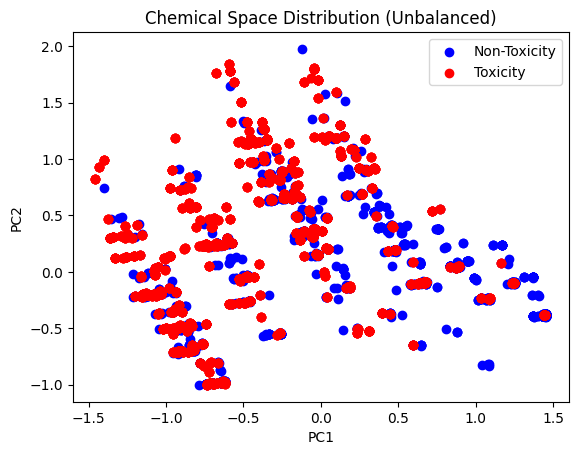

(1085, 2)
(1104, 2)


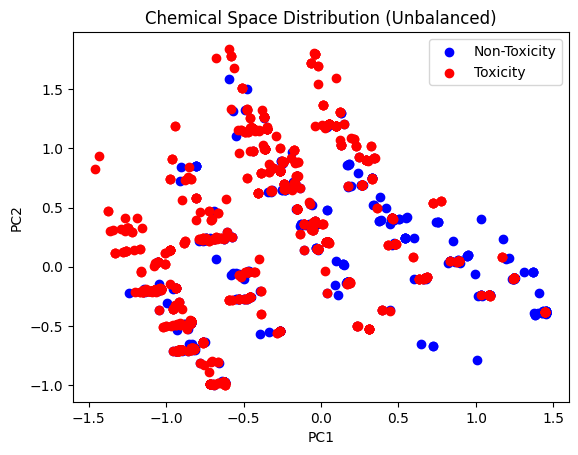

(4337, 2)
(4416, 2)


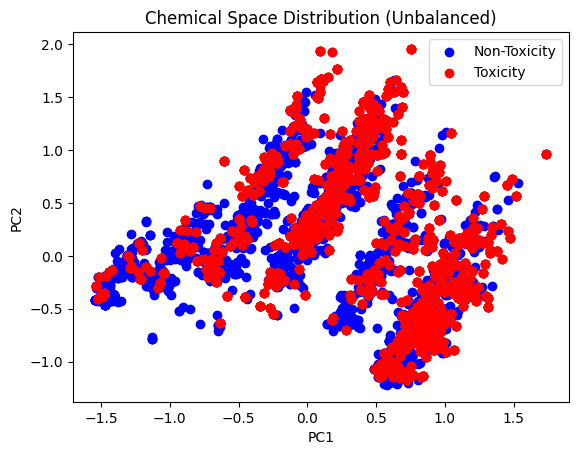

(1085, 2)
(1104, 2)


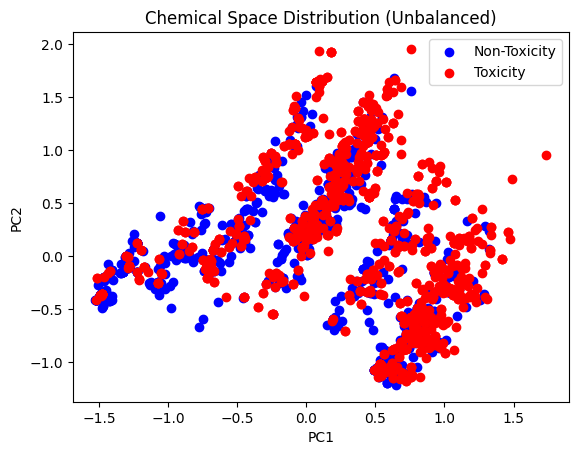

(4337, 2)
(4416, 2)


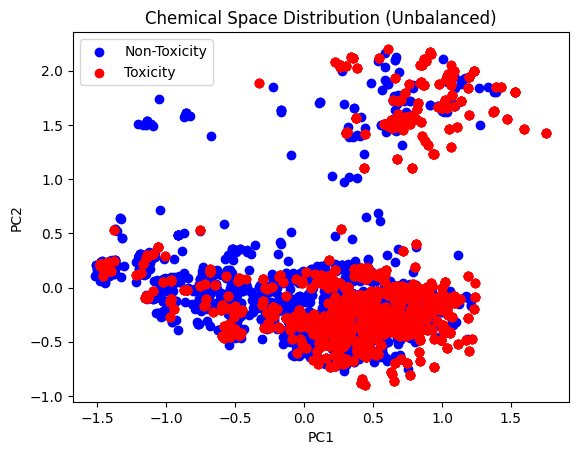

(1085, 2)
(1104, 2)


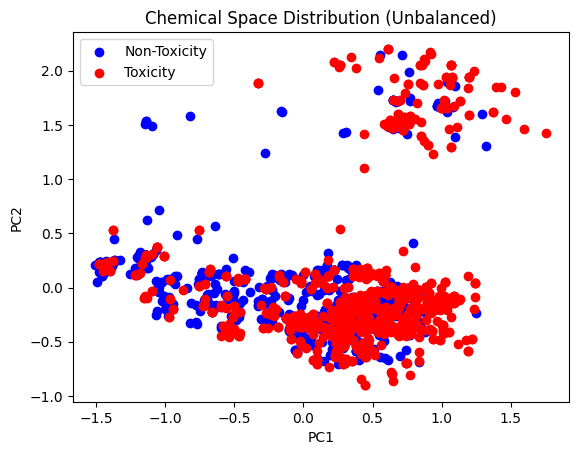

(4337, 2)
(4416, 2)


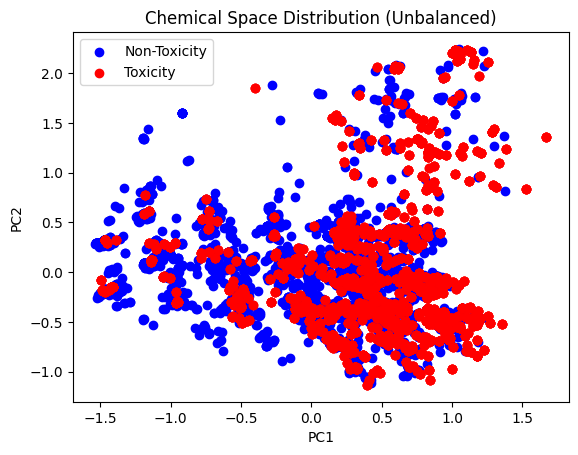

(1085, 2)
(1104, 2)


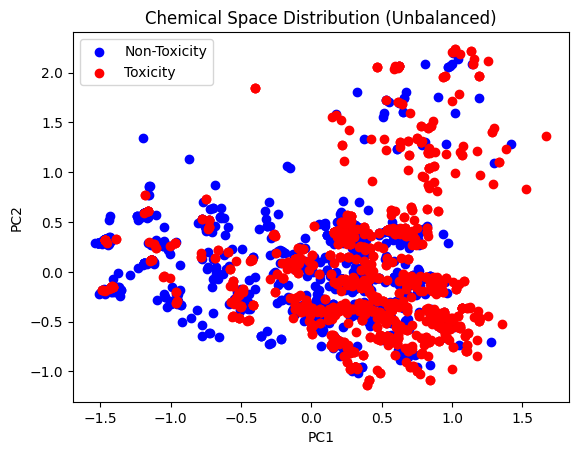

(4337, 2)
(4416, 2)


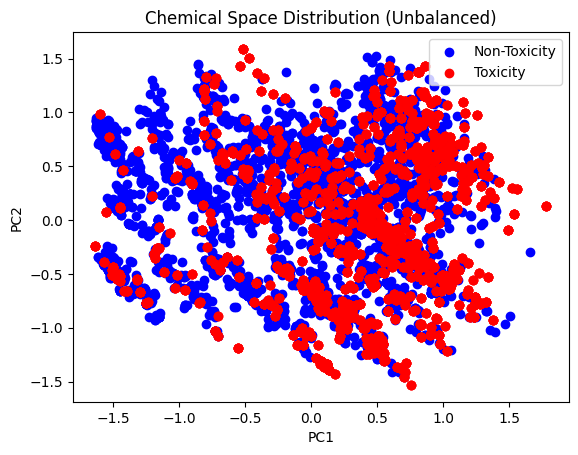

(1085, 2)
(1104, 2)


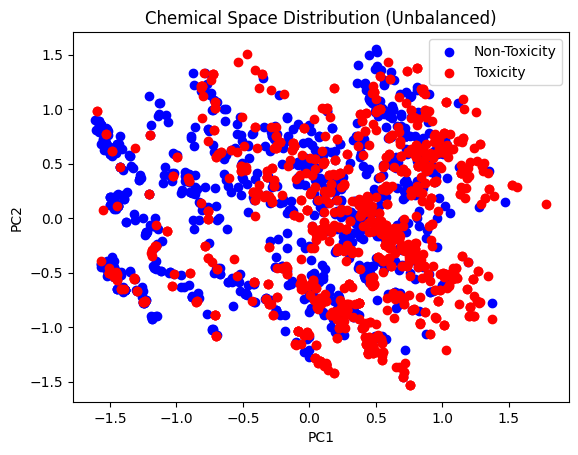

(4337, 2)
(4416, 2)


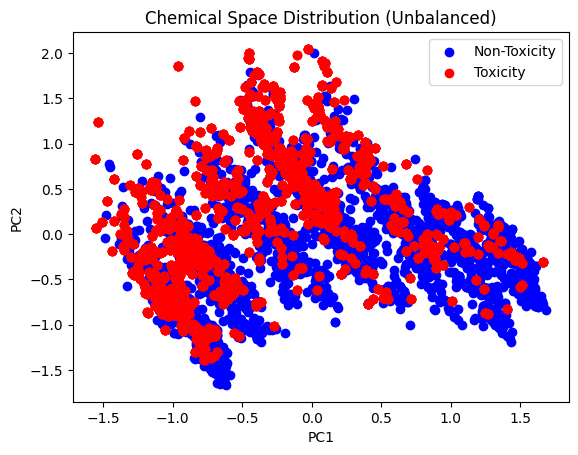

(1085, 2)
(1104, 2)


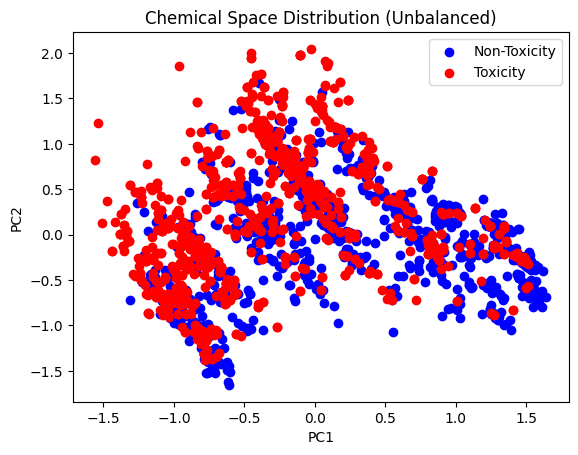

(4337, 2)
(4416, 2)


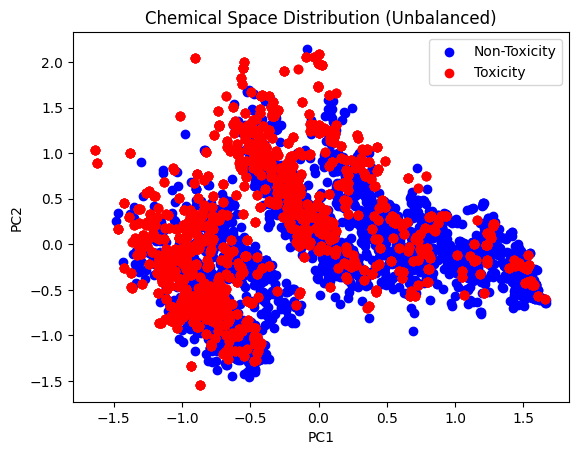

(1085, 2)
(1104, 2)


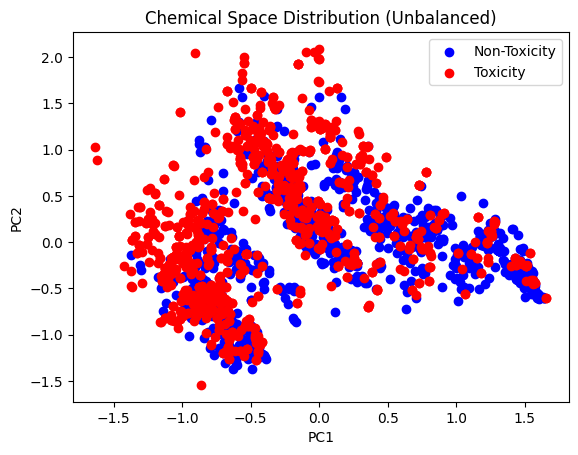

(4337, 2)
(4416, 2)


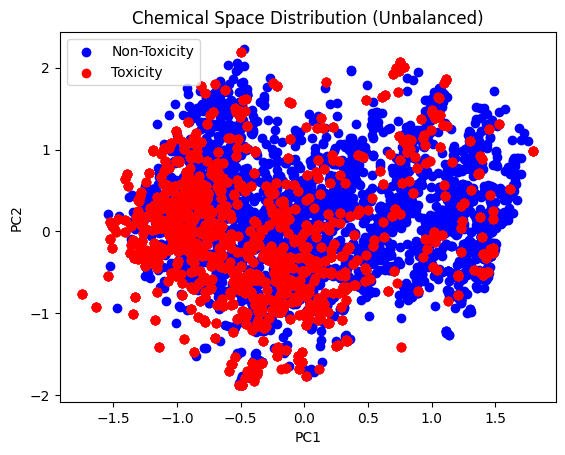

(1085, 2)
(1104, 2)


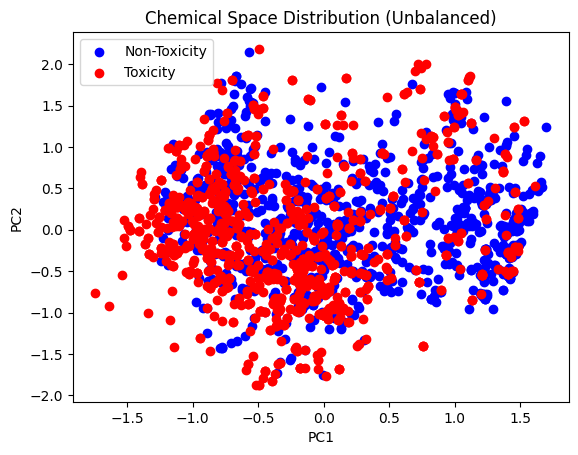

(4337, 2)
(4416, 2)


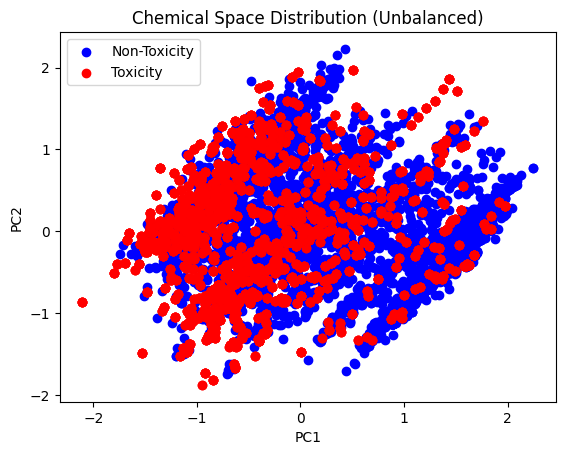

(1085, 2)
(1104, 2)


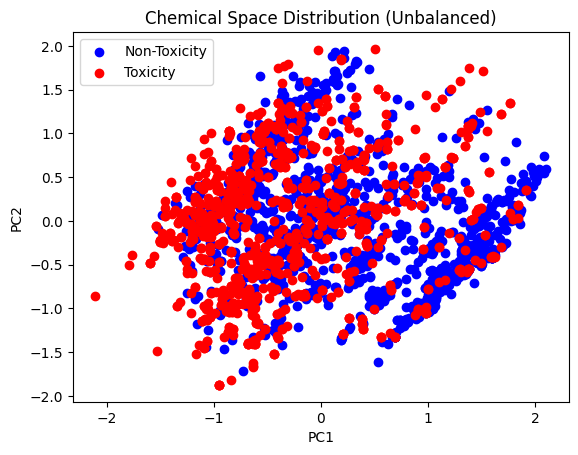

(4337, 2)
(4416, 2)


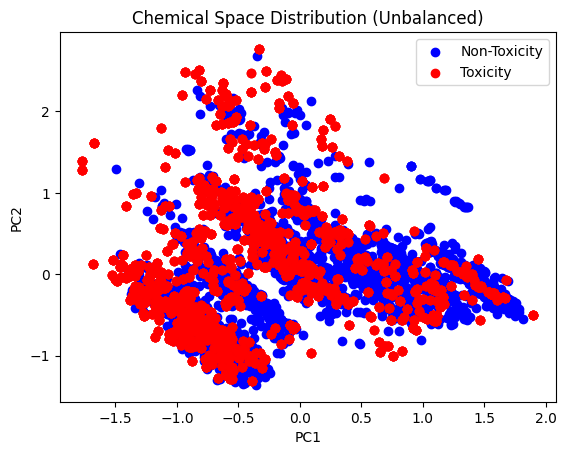

(1085, 2)
(1104, 2)


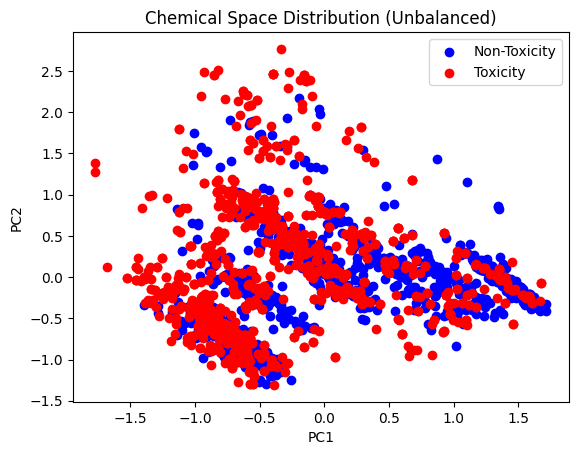

(4337, 2)
(4416, 2)


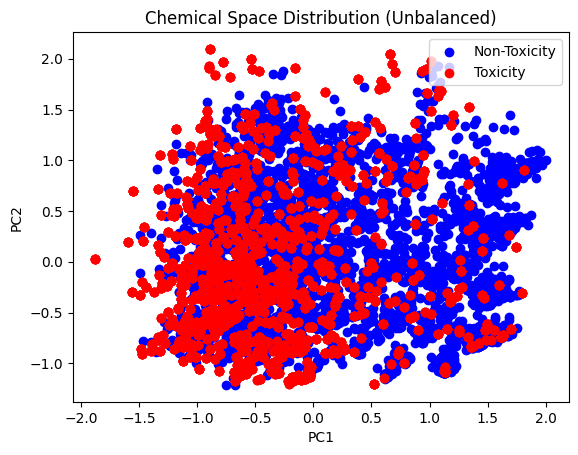

(1085, 2)
(1104, 2)


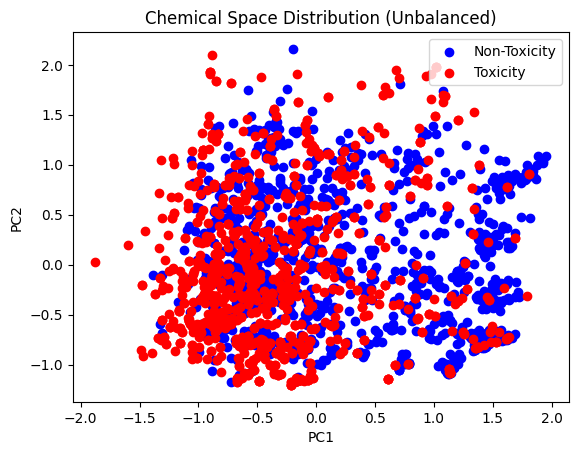

(4337, 2)
(4416, 2)


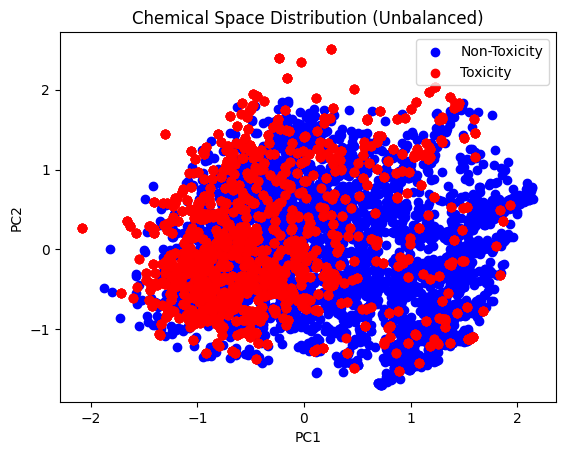

(1085, 2)
(1104, 2)


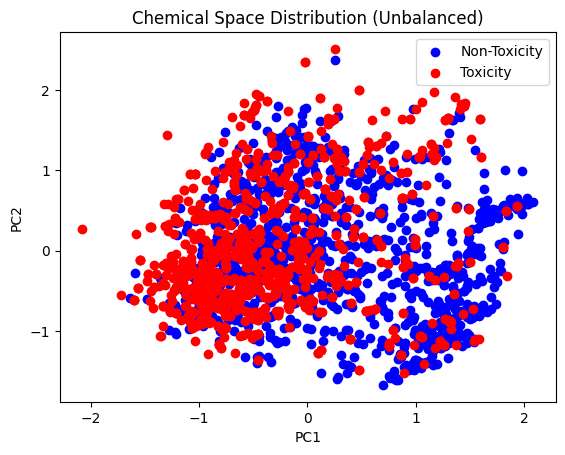

(4337, 2)
(4416, 2)


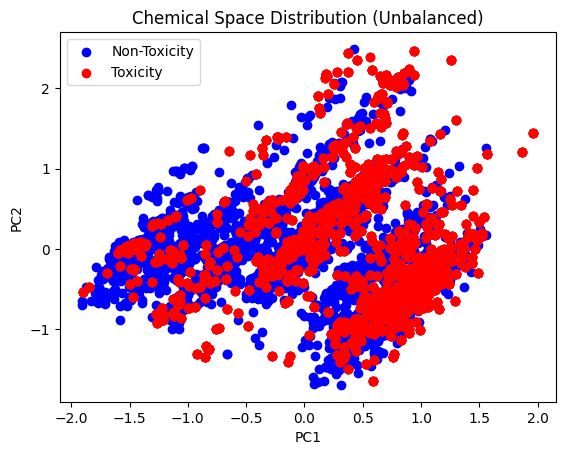

(1085, 2)
(1104, 2)


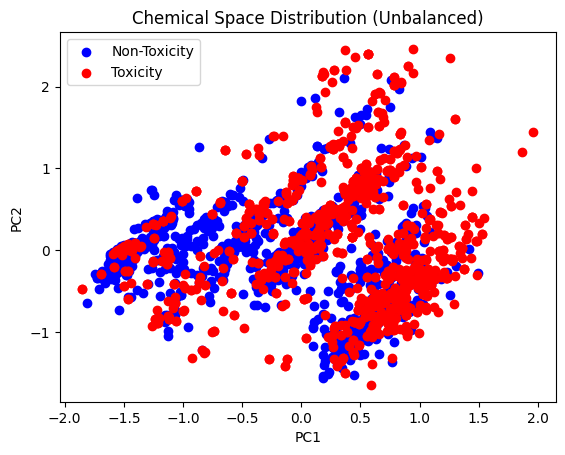

(4337, 2)
(4416, 2)


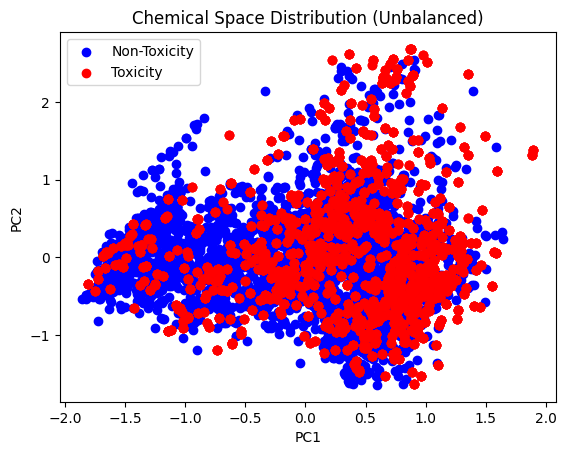

(1085, 2)
(1104, 2)


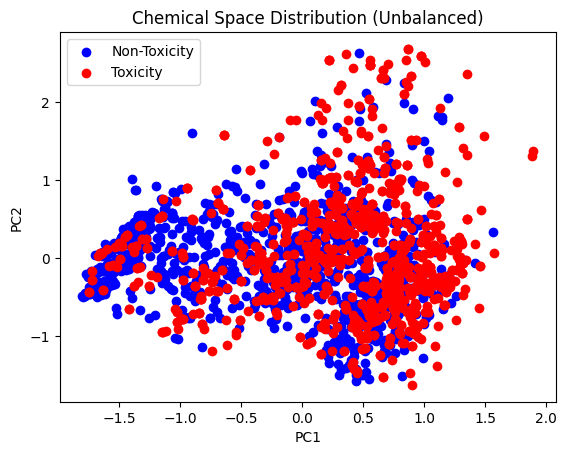

(4337, 2)
(4416, 2)


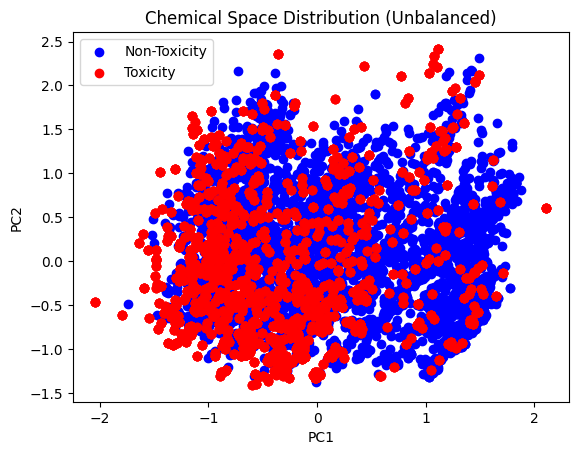

(1085, 2)
(1104, 2)


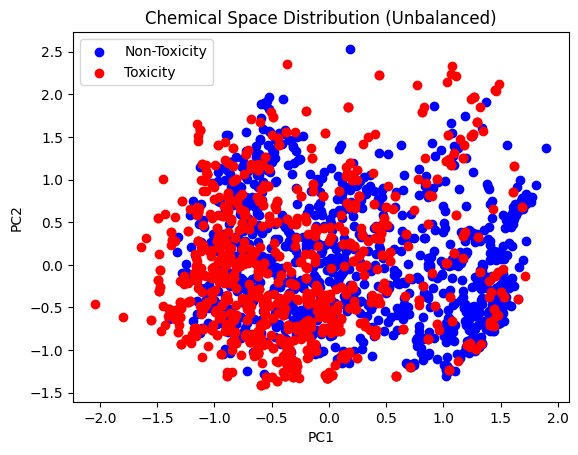

(4337, 2)
(4416, 2)


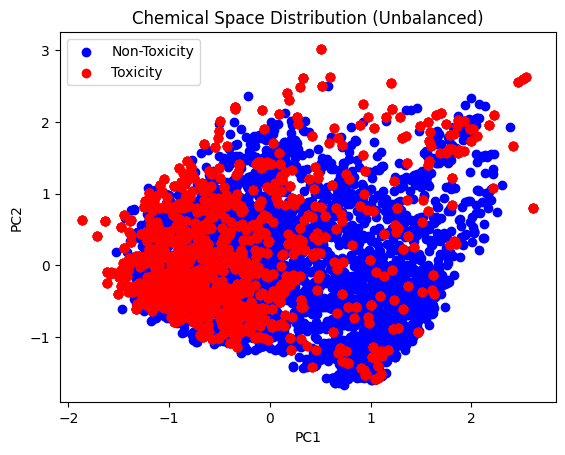

(1085, 2)
(1104, 2)


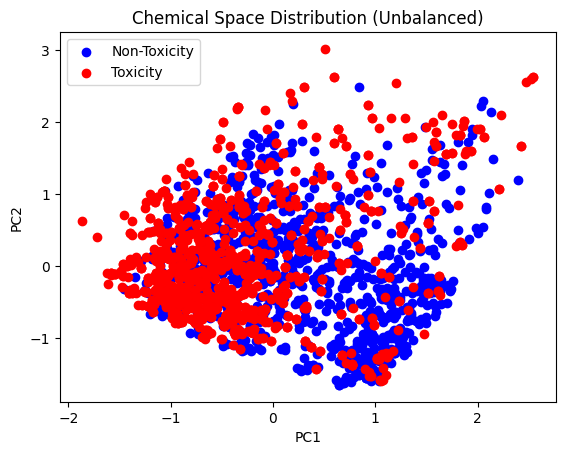

(4337, 2)
(4416, 2)


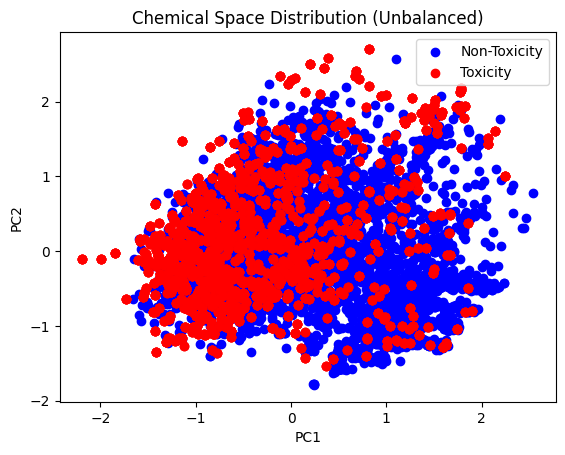

(1085, 2)
(1104, 2)


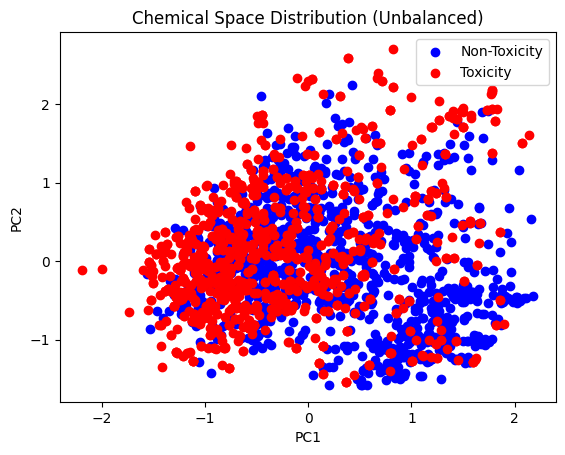

(4337, 2)
(4416, 2)


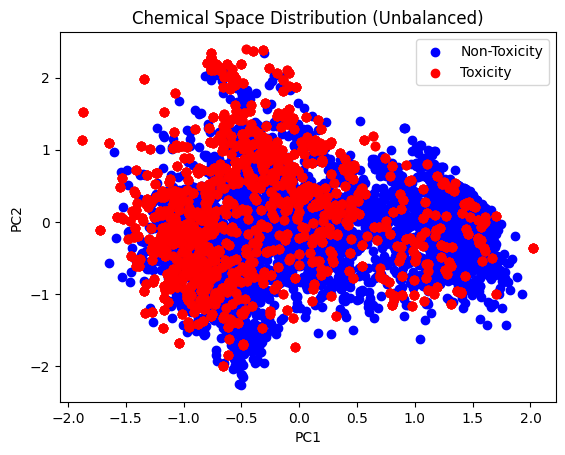

(1085, 2)
(1104, 2)


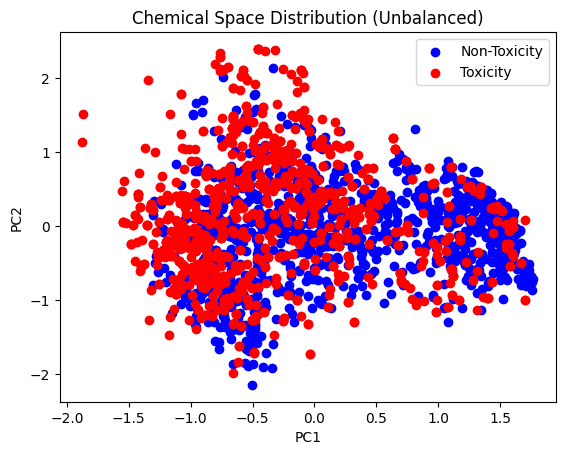

(4337, 2)
(4416, 2)


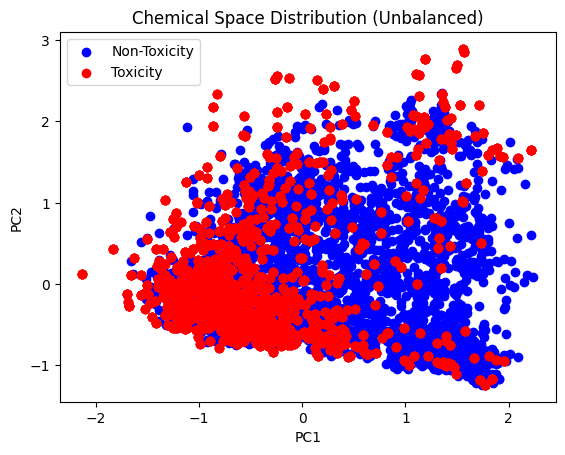

(1085, 2)
(1104, 2)


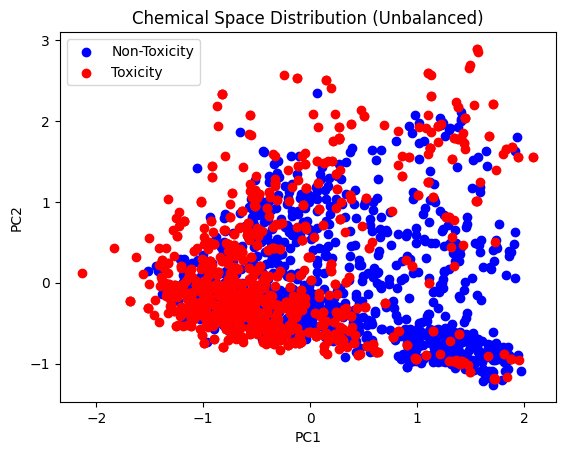

In [168]:
pca1 = PCA(n_components=2)
for k in range(50,1000,50):
    selection = SelectKBest(score_func=mutual_info_classif, k=k)
    X_bt = selection.fit_transform(X_train,y_train)
    X_t = pca1.fit_transform(X_bt)

    positive_indices = np.where(y_train == 1)[0]
    negative_indices = np.where(y_train == 0)[0]

    positive_samples = np.array(X_t)[positive_indices]
    negative_samples = np.array(X_t)[negative_indices]

    PCA_func(negative_samples,positive_samples)

    X_tt = selection.transform(X_test)
    X_t = pca1.transform(X_tt)

    positive_indices = np.where(y_test == 1)[0]
    negative_indices = np.where(y_test == 0)[0]

    positive_samples = np.array(X_t)[positive_indices]
    negative_samples = np.array(X_t)[negative_indices]

    PCA_func(negative_samples,positive_samples)

In [70]:
from sklearn.feature_selection import SelectKBest, f_regression
clf = RandomForestClassifier(random_state=0,class_weight={0: 736/4337, 1: 1})

# 計算每個特徵與目標變數的相關性
F, p = f_regression(X_train, y_train)

# 決定我們要試驗的特徵數量
k_values = range(1, X_train.shape[1] + 1)

best_score = 0
best_k = 0
best_X = None

# 在迴圈開始前初始化兩個空列表
n_list = []
scores_list = []

for k in k_values:
    # 選擇 k 個最相關的特徵
    selection = SelectKBest(f_regression, k=k)
    select_X = selection.fit_transform(X_train, y_train)
    
    # 進行交叉驗證
    scores = cross_val_score(clf, select_X, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    
    print(f"k={k}, n={select_X.shape[1]}, Accuracy: {mean_score:.2f} (+/- {scores.std():.2f})")

    # 如果這個特徵數量的得分比我們之前找到的得分還高，則更新最佳特徵數量和數據集
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_X = select_X

    # 將每個特徵數量和對應的評分添加到列表中
    n_list.append(select_X.shape[1])
    scores_list.append(mean_score)

print(f"Best k={best_k}, Accuracy: {best_score:.2f}")


k=1, n=1, Accuracy: 0.67 (+/- 0.00)
k=2, n=2, Accuracy: 0.73 (+/- 0.00)
k=3, n=3, Accuracy: 0.73 (+/- 0.00)
k=4, n=4, Accuracy: 0.73 (+/- 0.00)
k=5, n=5, Accuracy: 0.73 (+/- 0.00)
k=6, n=6, Accuracy: 0.73 (+/- 0.00)
k=7, n=7, Accuracy: 0.72 (+/- 0.01)
k=8, n=8, Accuracy: 0.73 (+/- 0.01)
k=9, n=9, Accuracy: 0.73 (+/- 0.00)
k=10, n=10, Accuracy: 0.74 (+/- 0.00)
k=11, n=11, Accuracy: 0.74 (+/- 0.00)
k=12, n=12, Accuracy: 0.74 (+/- 0.00)
k=13, n=13, Accuracy: 0.74 (+/- 0.00)
k=14, n=14, Accuracy: 0.74 (+/- 0.00)
k=15, n=15, Accuracy: 0.74 (+/- 0.00)
k=16, n=16, Accuracy: 0.74 (+/- 0.00)
k=17, n=17, Accuracy: 0.74 (+/- 0.00)
k=18, n=18, Accuracy: 0.74 (+/- 0.00)
k=19, n=19, Accuracy: 0.74 (+/- 0.01)
k=20, n=20, Accuracy: 0.74 (+/- 0.01)
k=21, n=21, Accuracy: 0.74 (+/- 0.01)
k=22, n=22, Accuracy: 0.74 (+/- 0.01)
k=23, n=23, Accuracy: 0.74 (+/- 0.01)
k=24, n=24, Accuracy: 0.75 (+/- 0.00)
k=25, n=25, Accuracy: 0.76 (+/- 0.00)
k=26, n=26, Accuracy: 0.76 (+/- 0.00)
k=27, n=27, Accuracy: 0.75 (+/

k=212, n=212, Accuracy: 0.94 (+/- 0.00)
k=213, n=213, Accuracy: 0.94 (+/- 0.00)
k=214, n=214, Accuracy: 0.94 (+/- 0.01)
k=215, n=215, Accuracy: 0.94 (+/- 0.00)
k=216, n=216, Accuracy: 0.94 (+/- 0.00)
k=217, n=217, Accuracy: 0.94 (+/- 0.00)
k=218, n=218, Accuracy: 0.94 (+/- 0.00)
k=219, n=219, Accuracy: 0.94 (+/- 0.01)
k=220, n=220, Accuracy: 0.94 (+/- 0.00)
k=221, n=221, Accuracy: 0.94 (+/- 0.00)
k=222, n=222, Accuracy: 0.94 (+/- 0.00)
k=223, n=223, Accuracy: 0.94 (+/- 0.00)
k=224, n=224, Accuracy: 0.94 (+/- 0.00)
k=225, n=225, Accuracy: 0.94 (+/- 0.00)
k=226, n=226, Accuracy: 0.94 (+/- 0.00)
k=227, n=227, Accuracy: 0.94 (+/- 0.00)
k=228, n=228, Accuracy: 0.94 (+/- 0.00)
k=229, n=229, Accuracy: 0.94 (+/- 0.00)
k=230, n=230, Accuracy: 0.94 (+/- 0.00)
k=231, n=231, Accuracy: 0.94 (+/- 0.01)
k=232, n=232, Accuracy: 0.94 (+/- 0.00)
k=233, n=233, Accuracy: 0.94 (+/- 0.00)
k=234, n=234, Accuracy: 0.94 (+/- 0.01)
k=235, n=235, Accuracy: 0.94 (+/- 0.01)
k=236, n=236, Accuracy: 0.94 (+/- 0.00)


k=417, n=417, Accuracy: 0.96 (+/- 0.00)
k=418, n=418, Accuracy: 0.96 (+/- 0.00)
k=419, n=419, Accuracy: 0.96 (+/- 0.00)
k=420, n=420, Accuracy: 0.96 (+/- 0.00)
k=421, n=421, Accuracy: 0.96 (+/- 0.01)
k=422, n=422, Accuracy: 0.96 (+/- 0.00)
k=423, n=423, Accuracy: 0.96 (+/- 0.01)
k=424, n=424, Accuracy: 0.96 (+/- 0.00)
k=425, n=425, Accuracy: 0.96 (+/- 0.00)
k=426, n=426, Accuracy: 0.96 (+/- 0.01)
k=427, n=427, Accuracy: 0.96 (+/- 0.01)
k=428, n=428, Accuracy: 0.96 (+/- 0.01)
k=429, n=429, Accuracy: 0.96 (+/- 0.00)
k=430, n=430, Accuracy: 0.96 (+/- 0.01)
k=431, n=431, Accuracy: 0.96 (+/- 0.00)
k=432, n=432, Accuracy: 0.96 (+/- 0.01)
k=433, n=433, Accuracy: 0.96 (+/- 0.00)
k=434, n=434, Accuracy: 0.96 (+/- 0.00)
k=435, n=435, Accuracy: 0.96 (+/- 0.00)
k=436, n=436, Accuracy: 0.96 (+/- 0.00)
k=437, n=437, Accuracy: 0.96 (+/- 0.01)
k=438, n=438, Accuracy: 0.96 (+/- 0.00)
k=439, n=439, Accuracy: 0.96 (+/- 0.01)
k=440, n=440, Accuracy: 0.96 (+/- 0.01)
k=441, n=441, Accuracy: 0.96 (+/- 0.01)


k=622, n=622, Accuracy: 0.96 (+/- 0.00)
k=623, n=623, Accuracy: 0.96 (+/- 0.00)
k=624, n=624, Accuracy: 0.96 (+/- 0.00)
k=625, n=625, Accuracy: 0.96 (+/- 0.00)
k=626, n=626, Accuracy: 0.96 (+/- 0.00)
k=627, n=627, Accuracy: 0.96 (+/- 0.00)
k=628, n=628, Accuracy: 0.96 (+/- 0.00)
k=629, n=629, Accuracy: 0.97 (+/- 0.00)
k=630, n=630, Accuracy: 0.96 (+/- 0.00)
k=631, n=631, Accuracy: 0.96 (+/- 0.01)
k=632, n=632, Accuracy: 0.96 (+/- 0.00)
k=633, n=633, Accuracy: 0.96 (+/- 0.00)
k=634, n=634, Accuracy: 0.96 (+/- 0.00)
k=635, n=635, Accuracy: 0.96 (+/- 0.01)
k=636, n=636, Accuracy: 0.96 (+/- 0.00)
k=637, n=637, Accuracy: 0.96 (+/- 0.00)
k=638, n=638, Accuracy: 0.96 (+/- 0.01)
k=639, n=639, Accuracy: 0.96 (+/- 0.00)
k=640, n=640, Accuracy: 0.96 (+/- 0.00)
k=641, n=641, Accuracy: 0.96 (+/- 0.00)
k=642, n=642, Accuracy: 0.96 (+/- 0.00)
k=643, n=643, Accuracy: 0.96 (+/- 0.00)
k=644, n=644, Accuracy: 0.96 (+/- 0.00)
k=645, n=645, Accuracy: 0.97 (+/- 0.00)
k=646, n=646, Accuracy: 0.96 (+/- 0.00)


k=827, n=827, Accuracy: 0.96 (+/- 0.00)
k=828, n=828, Accuracy: 0.96 (+/- 0.00)
k=829, n=829, Accuracy: 0.96 (+/- 0.00)
k=830, n=830, Accuracy: 0.96 (+/- 0.00)
k=831, n=831, Accuracy: 0.96 (+/- 0.00)
k=832, n=832, Accuracy: 0.97 (+/- 0.00)
k=833, n=833, Accuracy: 0.96 (+/- 0.00)
k=834, n=834, Accuracy: 0.96 (+/- 0.00)
k=835, n=835, Accuracy: 0.96 (+/- 0.00)
k=836, n=836, Accuracy: 0.96 (+/- 0.00)
k=837, n=837, Accuracy: 0.96 (+/- 0.00)
k=838, n=838, Accuracy: 0.96 (+/- 0.00)
k=839, n=839, Accuracy: 0.96 (+/- 0.00)
k=840, n=840, Accuracy: 0.96 (+/- 0.00)
k=841, n=841, Accuracy: 0.96 (+/- 0.00)
k=842, n=842, Accuracy: 0.96 (+/- 0.00)
k=843, n=843, Accuracy: 0.96 (+/- 0.00)
k=844, n=844, Accuracy: 0.96 (+/- 0.00)
k=845, n=845, Accuracy: 0.96 (+/- 0.00)
k=846, n=846, Accuracy: 0.96 (+/- 0.00)
k=847, n=847, Accuracy: 0.96 (+/- 0.00)
k=848, n=848, Accuracy: 0.96 (+/- 0.00)
k=849, n=849, Accuracy: 0.96 (+/- 0.00)
k=850, n=850, Accuracy: 0.96 (+/- 0.01)
k=851, n=851, Accuracy: 0.96 (+/- 0.00)


k=1031, n=1031, Accuracy: 0.96 (+/- 0.00)
k=1032, n=1032, Accuracy: 0.96 (+/- 0.00)
k=1033, n=1033, Accuracy: 0.96 (+/- 0.00)
k=1034, n=1034, Accuracy: 0.96 (+/- 0.00)
k=1035, n=1035, Accuracy: 0.96 (+/- 0.00)
k=1036, n=1036, Accuracy: 0.96 (+/- 0.00)
k=1037, n=1037, Accuracy: 0.96 (+/- 0.00)
k=1038, n=1038, Accuracy: 0.96 (+/- 0.00)
k=1039, n=1039, Accuracy: 0.96 (+/- 0.00)
k=1040, n=1040, Accuracy: 0.96 (+/- 0.01)
k=1041, n=1041, Accuracy: 0.96 (+/- 0.00)
k=1042, n=1042, Accuracy: 0.96 (+/- 0.00)
k=1043, n=1043, Accuracy: 0.96 (+/- 0.01)
k=1044, n=1044, Accuracy: 0.96 (+/- 0.00)
k=1045, n=1045, Accuracy: 0.96 (+/- 0.00)
k=1046, n=1046, Accuracy: 0.96 (+/- 0.00)
k=1047, n=1047, Accuracy: 0.96 (+/- 0.00)
k=1048, n=1048, Accuracy: 0.96 (+/- 0.01)
k=1049, n=1049, Accuracy: 0.96 (+/- 0.00)
k=1050, n=1050, Accuracy: 0.96 (+/- 0.01)
k=1051, n=1051, Accuracy: 0.96 (+/- 0.00)
k=1052, n=1052, Accuracy: 0.96 (+/- 0.00)
k=1053, n=1053, Accuracy: 0.96 (+/- 0.00)
k=1054, n=1054, Accuracy: 0.96 (+/

k=1227, n=1227, Accuracy: 0.96 (+/- 0.01)
k=1228, n=1228, Accuracy: 0.96 (+/- 0.01)
k=1229, n=1229, Accuracy: 0.96 (+/- 0.00)
k=1230, n=1230, Accuracy: 0.96 (+/- 0.01)
k=1231, n=1231, Accuracy: 0.96 (+/- 0.01)
k=1232, n=1232, Accuracy: 0.96 (+/- 0.01)
k=1233, n=1233, Accuracy: 0.96 (+/- 0.01)
k=1234, n=1234, Accuracy: 0.96 (+/- 0.01)
k=1235, n=1235, Accuracy: 0.96 (+/- 0.00)
k=1236, n=1236, Accuracy: 0.96 (+/- 0.00)
k=1237, n=1237, Accuracy: 0.96 (+/- 0.01)
k=1238, n=1238, Accuracy: 0.96 (+/- 0.01)
k=1239, n=1239, Accuracy: 0.96 (+/- 0.01)
k=1240, n=1240, Accuracy: 0.96 (+/- 0.01)
k=1241, n=1241, Accuracy: 0.96 (+/- 0.00)
k=1242, n=1242, Accuracy: 0.96 (+/- 0.01)
k=1243, n=1243, Accuracy: 0.96 (+/- 0.00)
k=1244, n=1244, Accuracy: 0.96 (+/- 0.00)
k=1245, n=1245, Accuracy: 0.96 (+/- 0.01)
k=1246, n=1246, Accuracy: 0.96 (+/- 0.01)
k=1247, n=1247, Accuracy: 0.96 (+/- 0.00)
k=1248, n=1248, Accuracy: 0.96 (+/- 0.01)
k=1249, n=1249, Accuracy: 0.96 (+/- 0.00)
k=1250, n=1250, Accuracy: 0.96 (+/

k=1423, n=1423, Accuracy: 0.96 (+/- 0.00)
k=1424, n=1424, Accuracy: 0.96 (+/- 0.00)
k=1425, n=1425, Accuracy: 0.96 (+/- 0.00)
k=1426, n=1426, Accuracy: 0.96 (+/- 0.00)
k=1427, n=1427, Accuracy: 0.96 (+/- 0.00)
k=1428, n=1428, Accuracy: 0.96 (+/- 0.01)
k=1429, n=1429, Accuracy: 0.96 (+/- 0.00)
k=1430, n=1430, Accuracy: 0.96 (+/- 0.01)
k=1431, n=1431, Accuracy: 0.96 (+/- 0.00)
k=1432, n=1432, Accuracy: 0.96 (+/- 0.01)
k=1433, n=1433, Accuracy: 0.96 (+/- 0.00)
k=1434, n=1434, Accuracy: 0.96 (+/- 0.01)
k=1435, n=1435, Accuracy: 0.96 (+/- 0.00)
k=1436, n=1436, Accuracy: 0.96 (+/- 0.01)
k=1437, n=1437, Accuracy: 0.96 (+/- 0.00)
k=1438, n=1438, Accuracy: 0.96 (+/- 0.01)
k=1439, n=1439, Accuracy: 0.96 (+/- 0.01)
k=1440, n=1440, Accuracy: 0.96 (+/- 0.00)
k=1441, n=1441, Accuracy: 0.96 (+/- 0.00)
k=1442, n=1442, Accuracy: 0.96 (+/- 0.01)
k=1443, n=1443, Accuracy: 0.96 (+/- 0.01)
k=1444, n=1444, Accuracy: 0.96 (+/- 0.00)
k=1445, n=1445, Accuracy: 0.96 (+/- 0.01)
k=1446, n=1446, Accuracy: 0.96 (+/

k=1619, n=1619, Accuracy: 0.96 (+/- 0.01)
k=1620, n=1620, Accuracy: 0.96 (+/- 0.01)
k=1621, n=1621, Accuracy: 0.96 (+/- 0.01)
k=1622, n=1622, Accuracy: 0.96 (+/- 0.01)
k=1623, n=1623, Accuracy: 0.96 (+/- 0.00)
k=1624, n=1624, Accuracy: 0.96 (+/- 0.01)
k=1625, n=1625, Accuracy: 0.96 (+/- 0.00)
k=1626, n=1626, Accuracy: 0.96 (+/- 0.00)
k=1627, n=1627, Accuracy: 0.96 (+/- 0.00)
k=1628, n=1628, Accuracy: 0.96 (+/- 0.00)
k=1629, n=1629, Accuracy: 0.96 (+/- 0.00)
k=1630, n=1630, Accuracy: 0.96 (+/- 0.00)
k=1631, n=1631, Accuracy: 0.96 (+/- 0.00)
k=1632, n=1632, Accuracy: 0.96 (+/- 0.00)
k=1633, n=1633, Accuracy: 0.96 (+/- 0.00)
k=1634, n=1634, Accuracy: 0.96 (+/- 0.00)
k=1635, n=1635, Accuracy: 0.96 (+/- 0.01)
k=1636, n=1636, Accuracy: 0.96 (+/- 0.00)
k=1637, n=1637, Accuracy: 0.96 (+/- 0.00)
k=1638, n=1638, Accuracy: 0.96 (+/- 0.00)
k=1639, n=1639, Accuracy: 0.96 (+/- 0.00)
k=1640, n=1640, Accuracy: 0.96 (+/- 0.01)
k=1641, n=1641, Accuracy: 0.96 (+/- 0.00)
k=1642, n=1642, Accuracy: 0.96 (+/

k=1815, n=1815, Accuracy: 0.96 (+/- 0.00)
k=1816, n=1816, Accuracy: 0.96 (+/- 0.00)
k=1817, n=1817, Accuracy: 0.96 (+/- 0.00)
k=1818, n=1818, Accuracy: 0.96 (+/- 0.00)
k=1819, n=1819, Accuracy: 0.96 (+/- 0.00)
k=1820, n=1820, Accuracy: 0.96 (+/- 0.00)
k=1821, n=1821, Accuracy: 0.96 (+/- 0.00)
k=1822, n=1822, Accuracy: 0.95 (+/- 0.00)
k=1823, n=1823, Accuracy: 0.96 (+/- 0.00)
k=1824, n=1824, Accuracy: 0.96 (+/- 0.00)
k=1825, n=1825, Accuracy: 0.96 (+/- 0.00)
k=1826, n=1826, Accuracy: 0.96 (+/- 0.00)
k=1827, n=1827, Accuracy: 0.96 (+/- 0.01)
k=1828, n=1828, Accuracy: 0.96 (+/- 0.00)
k=1829, n=1829, Accuracy: 0.96 (+/- 0.00)
k=1830, n=1830, Accuracy: 0.96 (+/- 0.01)
k=1831, n=1831, Accuracy: 0.96 (+/- 0.01)
k=1832, n=1832, Accuracy: 0.96 (+/- 0.00)
k=1833, n=1833, Accuracy: 0.96 (+/- 0.00)
k=1834, n=1834, Accuracy: 0.96 (+/- 0.01)
k=1835, n=1835, Accuracy: 0.96 (+/- 0.01)
k=1836, n=1836, Accuracy: 0.96 (+/- 0.00)
k=1837, n=1837, Accuracy: 0.96 (+/- 0.01)
k=1838, n=1838, Accuracy: 0.96 (+/

k=2011, n=2011, Accuracy: 0.96 (+/- 0.01)
k=2012, n=2012, Accuracy: 0.96 (+/- 0.00)
k=2013, n=2013, Accuracy: 0.95 (+/- 0.00)
k=2014, n=2014, Accuracy: 0.96 (+/- 0.01)
k=2015, n=2015, Accuracy: 0.96 (+/- 0.00)
k=2016, n=2016, Accuracy: 0.96 (+/- 0.00)
k=2017, n=2017, Accuracy: 0.96 (+/- 0.01)
k=2018, n=2018, Accuracy: 0.96 (+/- 0.00)
k=2019, n=2019, Accuracy: 0.96 (+/- 0.01)
k=2020, n=2020, Accuracy: 0.96 (+/- 0.01)
k=2021, n=2021, Accuracy: 0.96 (+/- 0.00)
k=2022, n=2022, Accuracy: 0.96 (+/- 0.00)
k=2023, n=2023, Accuracy: 0.96 (+/- 0.01)
k=2024, n=2024, Accuracy: 0.96 (+/- 0.00)
k=2025, n=2025, Accuracy: 0.96 (+/- 0.00)
k=2026, n=2026, Accuracy: 0.96 (+/- 0.00)
k=2027, n=2027, Accuracy: 0.96 (+/- 0.00)
k=2028, n=2028, Accuracy: 0.96 (+/- 0.00)
k=2029, n=2029, Accuracy: 0.96 (+/- 0.01)
k=2030, n=2030, Accuracy: 0.96 (+/- 0.00)
k=2031, n=2031, Accuracy: 0.96 (+/- 0.00)
k=2032, n=2032, Accuracy: 0.96 (+/- 0.00)
k=2033, n=2033, Accuracy: 0.96 (+/- 0.01)
k=2034, n=2034, Accuracy: 0.96 (+/

In [ ]:
clf = RandomForestClassifier(random_state=0,class_weight={0: 736/4337, 1: 1})
clf.fit(best_X, y_train)
model = SelectFromModel(clf, prefit=True)

# 決定我們要試驗的特徵重要性閾值
thresholds = np.sort(np.unique(clf.feature_importances_))

best_score = 0
best_threshold = 0
best_X = None

# 在迴圈開始前初始化兩個空列表
n_list = []
scores_list = []

for thresh in thresholds:
    # 選擇重要性大於閾值的特徵
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X = selection.fit_transform(best_X)
    
    # 進行交叉驗證
    scores = cross_val_score(clf, select_X, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    
    print(f"Thresh={thresh}, n={select_X.shape[1]}, Accuracy: {mean_score:.2f} (+/- {scores.std():.2f})")

    # 如果這個閾值的得分比我們之前找到的得分還高，則更新最佳閾值和數據集
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = thresh
        best_X = select_X

    # 將每個閾值和對應的評分添加到列表中
    n_list.append(select_X.shape[1])
    scores_list.append(mean_score)


In [ ]:
print(f"Best threshold={best_threshold}, Accuracy: {best_score:.2f}")

# 使用 matplotlib 繪製圖形
plt.figure(figsize=(10, 6))
plt.plot(n_list, scores_list, marker='o')
plt.title('Score vs. Feature Importance Threshold')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Cross-Validated Score')
plt.grid()
plt.show()

In [169]:
clf = RandomForestClassifier(random_state=0,class_weight="balanced")
clf.fit(X_train, y_train)
pca1 = PCA(n_components=2)
selection = SelectFromModel(clf, threshold=best_threshold, prefit=True)
X_bt = selection.fit_transform(X_train,y_train)
X_t = pca1.fit_transform(X_bt)

positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(negative_samples,positive_samples)

X_tt = selection.transform(X_test)
X_t = pca1.transform(X_tt)

positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(negative_samples,positive_samples)

NameError: name 'best_threshold' is not defined

In [170]:
selection = SelectKBest(score_func=mutual_info_classif, k= best_k)
X_train_k = selection.fit_transform(X_train,y_train)
X_test_k = selection.transform(X_test)
print(np.array(X_train_k).shape,np.array(X_test_k).shape)

(8753, 660) (2189, 660)


In [171]:
y_test.shape

(2189,)

Number of components to preserve 95.0% variance: 382
Epoch [1/1000], Training Loss: 1.6634, Training F1 score: 0.4789, Training MCC score: 0.0187, Training Combine score: 0.2488
[[1974 1484]
 [1943 1575]]
Epoch [1/1000], Validation Loss: 1.6734, Validation F1 score: 0.5841, Validation MCC score: -0.0012, Validation Combine score: 0.2914
[[259 600]
 [263 606]]
Epoch [2/1000], Training Loss: 1.6665, Training F1 score: 0.4848, Training MCC score: 0.0306, Training Combine score: 0.2577
[[1997 1459]
 [1927 1593]]
Epoch [2/1000], Validation Loss: 1.6778, Validation F1 score: 0.6242, Validation MCC score: 0.0124, Validation Combine score: 0.3183
[[172 683]
 [167 706]]
Epoch [3/1000], Training Loss: 1.6597, Training F1 score: 0.5052, Training MCC score: 0.0346, Training Combine score: 0.2699
[[1887 1575]
 [1794 1720]]
Epoch [3/1000], Validation Loss: 1.6383, Validation F1 score: 0.6609, Validation MCC score: 0.0521, Validation Combine score: 0.3565
[[ 93 759]
 [ 69 807]]
Epoch [4/1000], Traini

Epoch [28/1000], Training Loss: 1.0325, Training F1 score: 0.7592, Training MCC score: 0.5018, Training Combine score: 0.6305
[[2496  960]
 [ 779 2741]]
Epoch [28/1000], Validation Loss: 0.9706, Validation F1 score: 0.7795, Validation MCC score: 0.5176, Validation Combine score: 0.6485
[[549 305]
 [121 753]]
Epoch [29/1000], Training Loss: 1.0282, Training F1 score: 0.7539, Training MCC score: 0.4837, Training Combine score: 0.6188
[[2407 1048]
 [ 757 2764]]
Epoch [29/1000], Validation Loss: 0.9642, Validation F1 score: 0.7844, Validation MCC score: 0.5337, Validation Combine score: 0.6590
[[578 274]
 [134 742]]
Epoch [30/1000], Training Loss: 1.0061, Training F1 score: 0.7621, Training MCC score: 0.5050, Training Combine score: 0.6336
[[2478  978]
 [ 751 2769]]
Epoch [30/1000], Validation Loss: 0.9602, Validation F1 score: 0.7819, Validation MCC score: 0.5324, Validation Combine score: 0.6571
[[586 271]
 [138 733]]
Epoch [31/1000], Training Loss: 1.0087, Training F1 score: 0.7588, Tra

Epoch [55/1000], Training Loss: 0.8455, Training F1 score: 0.7716, Training MCC score: 0.5364, Training Combine score: 0.6540
[[2627  832]
 [ 785 2732]]
Epoch [55/1000], Validation Loss: 0.7768, Validation F1 score: 0.8022, Validation MCC score: 0.5806, Validation Combine score: 0.6914
[[623 231]
 [134 740]]
Epoch [56/1000], Training Loss: 0.8450, Training F1 score: 0.7696, Training MCC score: 0.5352, Training Combine score: 0.6524
[[2648  814]
 [ 807 2707]]
Epoch [56/1000], Validation Loss: 0.8266, Validation F1 score: 0.7818, Validation MCC score: 0.5452, Validation Combine score: 0.6635
[[628 229]
 [165 706]]
Epoch [57/1000], Training Loss: 0.8503, Training F1 score: 0.7665, Training MCC score: 0.5258, Training Combine score: 0.6461
[[2608  851]
 [ 803 2714]]
Epoch [57/1000], Validation Loss: 0.7639, Validation F1 score: 0.7970, Validation MCC score: 0.5655, Validation Combine score: 0.6813
[[602 253]
 [127 746]]
Epoch [58/1000], Training Loss: 0.8384, Training F1 score: 0.7686, Tra

Epoch [82/1000], Training Loss: 0.8669, Training F1 score: 0.7065, Training MCC score: 0.3988, Training Combine score: 0.5526
[[2355 1102]
 [ 995 2524]]
Epoch [82/1000], Validation Loss: 0.6576, Validation F1 score: 0.7974, Validation MCC score: 0.5698, Validation Combine score: 0.6836
[[615 241]
 [134 738]]
Epoch [83/1000], Training Loss: 0.7043, Training F1 score: 0.7749, Training MCC score: 0.5416, Training Combine score: 0.6583
[[2624  835]
 [ 764 2753]]
Epoch [83/1000], Validation Loss: 0.6319, Validation F1 score: 0.8011, Validation MCC score: 0.5760, Validation Combine score: 0.6885
[[610 247]
 [124 747]]
Epoch [84/1000], Training Loss: 0.7099, Training F1 score: 0.7707, Training MCC score: 0.5286, Training Combine score: 0.6497
[[2566  891]
 [ 754 2765]]
Epoch [84/1000], Validation Loss: 0.6349, Validation F1 score: 0.7979, Validation MCC score: 0.5628, Validation Combine score: 0.6804
[[583 271]
 [114 760]]
Epoch [85/1000], Training Loss: 0.6787, Training F1 score: 0.7826, Tra

Epoch [109/1000], Training Loss: 0.7539, Training F1 score: 0.7272, Training MCC score: 0.4418, Training Combine score: 0.5845
[[2434 1024]
 [ 923 2595]]
Epoch [109/1000], Validation Loss: 0.5958, Validation F1 score: 0.7950, Validation MCC score: 0.5560, Validation Combine score: 0.6755
[[579 275]
 [116 758]]
Epoch [110/1000], Training Loss: 0.6196, Training F1 score: 0.7820, Training MCC score: 0.5445, Training Combine score: 0.6633
[[2526  930]
 [ 663 2857]]
Epoch [110/1000], Validation Loss: 0.6151, Validation F1 score: 0.7856, Validation MCC score: 0.5332, Validation Combine score: 0.6594
[[564 289]
 [122 753]]
Epoch [111/1000], Training Loss: 0.6570, Training F1 score: 0.7667, Training MCC score: 0.5105, Training Combine score: 0.6386
[[2448 1010]
 [ 703 2815]]
Epoch [111/1000], Validation Loss: 0.5700, Validation F1 score: 0.8015, Validation MCC score: 0.5676, Validation Combine score: 0.6845
[[575 276]
 [106 771]]
Epoch [112/1000], Training Loss: 0.6419, Training F1 score: 0.77

Epoch [136/1000], Training Loss: 0.5987, Training F1 score: 0.7730, Training MCC score: 0.5421, Training Combine score: 0.6576
[[2660  796]
 [ 801 2719]]
Epoch [136/1000], Validation Loss: 0.5664, Validation F1 score: 0.7896, Validation MCC score: 0.5620, Validation Combine score: 0.6758
[[638 216]
 [163 711]]
Epoch [137/1000], Training Loss: 0.7052, Training F1 score: 0.7248, Training MCC score: 0.4536, Training Combine score: 0.5892
[[2558  900]
 [1007 2511]]
Epoch [137/1000], Validation Loss: 0.5830, Validation F1 score: 0.7869, Validation MCC score: 0.5562, Validation Combine score: 0.6715
[[635 218]
 [166 709]]
Epoch [138/1000], Training Loss: 0.6160, Training F1 score: 0.7701, Training MCC score: 0.5338, Training Combine score: 0.6520
[[2626  831]
 [ 795 2724]]
Epoch [138/1000], Validation Loss: 0.5355, Validation F1 score: 0.8015, Validation MCC score: 0.5823, Validation Combine score: 0.6919
[[635 216]
 [146 731]]
Epoch [139/1000], Training Loss: 0.6044, Training F1 score: 0.77

Epoch [163/1000], Training Loss: 0.5679, Training F1 score: 0.7727, Training MCC score: 0.5482, Training Combine score: 0.6604
[[2719  741]
 [ 836 2680]]
Epoch [163/1000], Validation Loss: 0.4968, Validation F1 score: 0.8011, Validation MCC score: 0.5757, Validation Combine score: 0.6884
[[610 246]
 [125 747]]
Epoch [164/1000], Training Loss: 0.5370, Training F1 score: 0.7845, Training MCC score: 0.5611, Training Combine score: 0.6728
[[2659  798]
 [ 733 2786]]
Epoch [164/1000], Validation Loss: 0.5118, Validation F1 score: 0.7985, Validation MCC score: 0.5761, Validation Combine score: 0.6873
[[631 224]
 [144 729]]
Epoch [165/1000], Training Loss: 0.5334, Training F1 score: 0.7888, Training MCC score: 0.5751, Training Combine score: 0.6820
[[2726  736]
 [ 746 2768]]
Epoch [165/1000], Validation Loss: 0.5094, Validation F1 score: 0.7984, Validation MCC score: 0.5828, Validation Combine score: 0.6906
[[652 204]
 [157 715]]
Epoch [166/1000], Training Loss: 0.5984, Training F1 score: 0.76

Epoch [190/1000], Training Loss: 0.5497, Training F1 score: 0.7723, Training MCC score: 0.5433, Training Combine score: 0.6578
[[2682  777]
 [ 816 2701]]
Epoch [190/1000], Validation Loss: 0.5071, Validation F1 score: 0.7909, Validation MCC score: 0.5641, Validation Combine score: 0.6775
[[638 213]
 [164 713]]
Epoch [191/1000], Training Loss: 0.5372, Training F1 score: 0.7767, Training MCC score: 0.5510, Training Combine score: 0.6639
[[2686  773]
 [ 793 2724]]
Epoch [191/1000], Validation Loss: 0.4364, Validation F1 score: 0.8190, Validation MCC score: 0.6192, Validation Combine score: 0.7191
[[648 206]
 [125 749]]
Epoch [192/1000], Training Loss: 0.5624, Training F1 score: 0.7642, Training MCC score: 0.5178, Training Combine score: 0.6410
[[2569  891]
 [ 791 2725]]
Epoch [192/1000], Validation Loss: 0.4588, Validation F1 score: 0.8071, Validation MCC score: 0.5818, Validation Combine score: 0.6944
[[584 269]
 [101 774]]
Epoch [193/1000], Training Loss: 0.5295, Training F1 score: 0.77

Epoch [217/1000], Training Loss: 0.5137, Training F1 score: 0.7759, Training MCC score: 0.5408, Training Combine score: 0.6583
[[2601  854]
 [ 748 2773]]
Epoch [217/1000], Validation Loss: 0.5334, Validation F1 score: 0.7761, Validation MCC score: 0.5161, Validation Combine score: 0.6461
[[572 281]
 [142 733]]
Epoch [218/1000], Training Loss: 0.5161, Training F1 score: 0.7753, Training MCC score: 0.5407, Training Combine score: 0.6580
[[2610  844]
 [ 758 2764]]
Epoch [218/1000], Validation Loss: 0.4321, Validation F1 score: 0.8097, Validation MCC score: 0.5954, Validation Combine score: 0.7025
[[621 236]
 [118 753]]
Epoch [219/1000], Training Loss: 0.4746, Training F1 score: 0.7916, Training MCC score: 0.5765, Training Combine score: 0.6841
[[2693  767]
 [ 710 2806]]
Epoch [219/1000], Validation Loss: 0.4309, Validation F1 score: 0.8097, Validation MCC score: 0.5889, Validation Combine score: 0.6993
[[599 251]
 [110 768]]
Epoch [220/1000], Training Loss: 0.5070, Training F1 score: 0.77

Epoch [244/1000], Training Loss: 0.4641, Training F1 score: 0.8026, Training MCC score: 0.5970, Training Combine score: 0.6998
[[2712  746]
 [ 660 2858]]
Epoch [244/1000], Validation Loss: 0.4218, Validation F1 score: 0.8183, Validation MCC score: 0.6131, Validation Combine score: 0.7157
[[629 224]
 [114 761]]
Epoch [245/1000], Training Loss: 0.4664, Training F1 score: 0.8015, Training MCC score: 0.5955, Training Combine score: 0.6985
[[2716  744]
 [ 667 2849]]
Epoch [245/1000], Validation Loss: 0.4148, Validation F1 score: 0.8180, Validation MCC score: 0.6117, Validation Combine score: 0.7149
[[624 230]
 [110 764]]
Early stopping triggered at epoch 245.
Test Loss: 0.4148, F1 Score: 0.82, MCC: 0.61, Combine: 0.71
[[776 300]
 [134 966]]


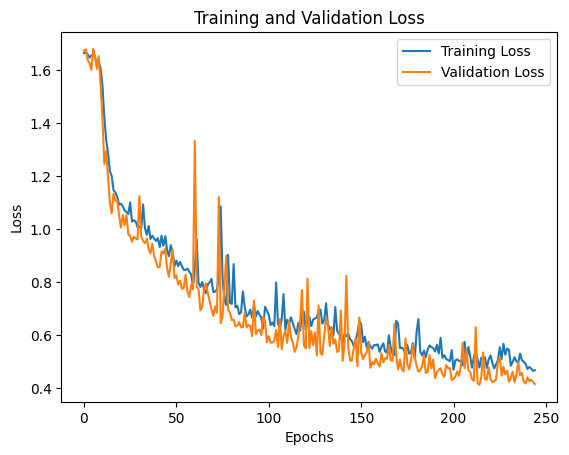

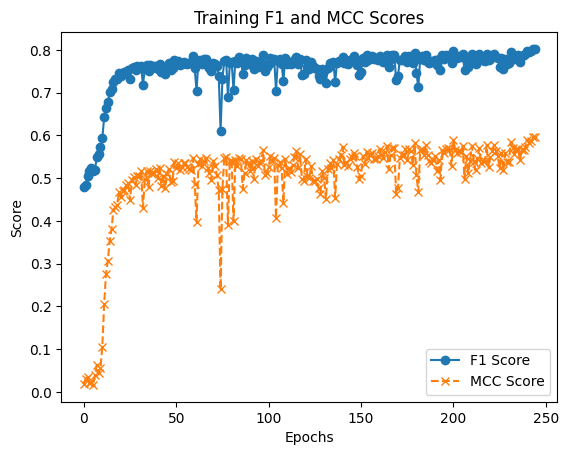

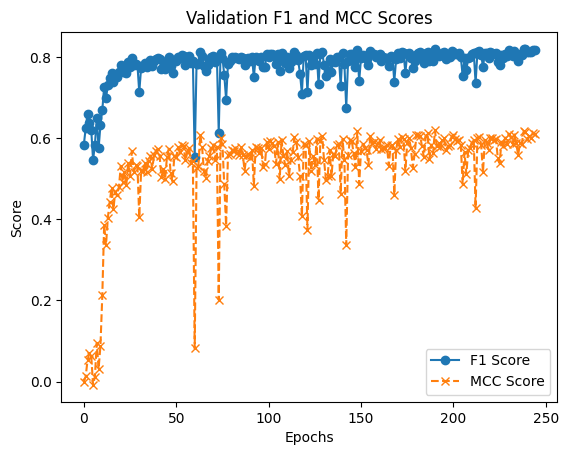

Number of components to preserve 95.0% variance: 383
Epoch [1/1000], Training Loss: 1.6705, Training F1 score: 0.6094, Training MCC score: 0.0176, Training Combine score: 0.3135
[[ 904 2536]
 [ 875 2661]]
Epoch [1/1000], Validation Loss: 1.6743, Validation F1 score: 0.6518, Validation MCC score: 0.0211, Validation Combine score: 0.3365
[[ 67 801]
 [ 57 803]]
Epoch [2/1000], Training Loss: 1.6662, Training F1 score: 0.6126, Training MCC score: 0.0129, Training Combine score: 0.3128
[[ 843 2598]
 [ 827 2708]]
Epoch [2/1000], Validation Loss: 1.6900, Validation F1 score: 0.6183, Validation MCC score: 0.0315, Validation Combine score: 0.3249
[[195 678]
 [169 686]]
Epoch [3/1000], Training Loss: 1.6809, Training F1 score: 0.5865, Training MCC score: -0.0020, Training Combine score: 0.2922
[[1033 2411]
 [1066 2466]]
Epoch [3/1000], Validation Loss: 1.6529, Validation F1 score: 0.5857, Validation MCC score: 0.0344, Validation Combine score: 0.3101
[[296 576]
 [263 593]]
Epoch [4/1000], Traini

Epoch [28/1000], Training Loss: 1.0528, Training F1 score: 0.7555, Training MCC score: 0.4388, Training Combine score: 0.5972
[[1646 1794]
 [ 300 3236]]
Epoch [28/1000], Validation Loss: 0.9705, Validation F1 score: 0.7767, Validation MCC score: 0.5128, Validation Combine score: 0.6448
[[498 373]
 [ 76 781]]
Epoch [29/1000], Training Loss: 1.0394, Training F1 score: 0.7552, Training MCC score: 0.4407, Training Combine score: 0.5980
[[1730 1712]
 [ 351 3183]]
Epoch [29/1000], Validation Loss: 0.9763, Validation F1 score: 0.7834, Validation MCC score: 0.5391, Validation Combine score: 0.6612
[[588 280]
 [126 734]]
Epoch [30/1000], Training Loss: 1.0115, Training F1 score: 0.7662, Training MCC score: 0.4706, Training Combine score: 0.6184
[[1831 1609]
 [ 341 3195]]
Epoch [30/1000], Validation Loss: 0.9634, Validation F1 score: 0.7816, Validation MCC score: 0.5311, Validation Combine score: 0.6563
[[565 304]
 [113 746]]
Epoch [31/1000], Training Loss: 1.0319, Training F1 score: 0.7581, Tra

Epoch [55/1000], Training Loss: 0.8725, Training F1 score: 0.7734, Training MCC score: 0.5380, Training Combine score: 0.6557
[[2615  825]
 [ 786 2750]]
Epoch [55/1000], Validation Loss: 0.8534, Validation F1 score: 0.7802, Validation MCC score: 0.5381, Validation Combine score: 0.6592
[[604 268]
 [137 719]]
Epoch [56/1000], Training Loss: 0.8796, Training F1 score: 0.7691, Training MCC score: 0.5050, Training Combine score: 0.6370
[[2341 1101]
 [ 638 2896]]
Epoch [56/1000], Validation Loss: 0.8231, Validation F1 score: 0.7914, Validation MCC score: 0.5595, Validation Combine score: 0.6755
[[604 267]
 [121 736]]
Epoch [57/1000], Training Loss: 0.8870, Training F1 score: 0.7646, Training MCC score: 0.5051, Training Combine score: 0.6348
[[2436 1006]
 [ 724 2810]]
Epoch [57/1000], Validation Loss: 0.8807, Validation F1 score: 0.7676, Validation MCC score: 0.5008, Validation Combine score: 0.6342
[[548 326]
 [119 735]]
Epoch [58/1000], Training Loss: 0.8570, Training F1 score: 0.7751, Tra

Epoch [82/1000], Training Loss: 0.7618, Training F1 score: 0.7688, Training MCC score: 0.5306, Training Combine score: 0.6497
[[2618  822]
 [ 815 2721]]
Epoch [82/1000], Validation Loss: 0.7543, Validation F1 score: 0.7678, Validation MCC score: 0.5120, Validation Combine score: 0.6399
[[595 277]
 [150 706]]
Epoch [83/1000], Training Loss: 0.7478, Training F1 score: 0.7727, Training MCC score: 0.5422, Training Combine score: 0.6574
[[2665  776]
 [ 821 2714]]
Epoch [83/1000], Validation Loss: 0.8465, Validation F1 score: 0.7327, Validation MCC score: 0.4486, Validation Combine score: 0.5906
[[595 275]
 [203 655]]
Epoch [84/1000], Training Loss: 0.8168, Training F1 score: 0.7385, Training MCC score: 0.4795, Training Combine score: 0.6090
[[2593  852]
 [ 965 2566]]
Epoch [84/1000], Validation Loss: 0.7826, Validation F1 score: 0.7571, Validation MCC score: 0.4841, Validation Combine score: 0.6206
[[569 303]
 [150 706]]
Epoch [85/1000], Training Loss: 0.7443, Training F1 score: 0.7717, Tra

Epoch [109/1000], Training Loss: 0.7328, Training F1 score: 0.7519, Training MCC score: 0.5098, Training Combine score: 0.6308
[[2667  770]
 [ 943 2596]]
Epoch [109/1000], Validation Loss: 0.6677, Validation F1 score: 0.7815, Validation MCC score: 0.5452, Validation Combine score: 0.6634
[[621 252]
 [145 710]]
Epoch [110/1000], Training Loss: 0.7117, Training F1 score: 0.7622, Training MCC score: 0.5228, Training Combine score: 0.6425
[[2642  794]
 [ 871 2669]]
Epoch [110/1000], Validation Loss: 0.9723, Validation F1 score: 0.6626, Validation MCC score: 0.2926, Validation Combine score: 0.4776
[[511 362]
 [252 603]]
Epoch [111/1000], Training Loss: 0.7229, Training F1 score: 0.7605, Training MCC score: 0.5076, Training Combine score: 0.6341
[[2533  905]
 [ 812 2726]]
Epoch [111/1000], Validation Loss: 0.6852, Validation F1 score: 0.7757, Validation MCC score: 0.5225, Validation Combine score: 0.6491
[[579 291]
 [130 728]]
Epoch [112/1000], Training Loss: 0.7061, Training F1 score: 0.76

Epoch [136/1000], Training Loss: 0.6106, Training F1 score: 0.7873, Training MCC score: 0.5687, Training Combine score: 0.6780
[[2688  749]
 [ 755 2784]]
Epoch [136/1000], Validation Loss: 0.6107, Validation F1 score: 0.7860, Validation MCC score: 0.5484, Validation Combine score: 0.6672
[[602 269]
 [128 729]]
Epoch [137/1000], Training Loss: 0.7455, Training F1 score: 0.7269, Training MCC score: 0.4607, Training Combine score: 0.5938
[[2585  857]
 [1027 2507]]
Epoch [137/1000], Validation Loss: 0.8562, Validation F1 score: 0.6842, Validation MCC score: 0.3474, Validation Combine score: 0.5158
[[551 317]
 [248 612]]
Epoch [138/1000], Training Loss: 0.7085, Training F1 score: 0.7466, Training MCC score: 0.4856, Training Combine score: 0.6161
[[2539  901]
 [ 893 2643]]
Epoch [138/1000], Validation Loss: 0.6198, Validation F1 score: 0.7853, Validation MCC score: 0.5438, Validation Combine score: 0.6646
[[585 287]
 [117 739]]
Epoch [139/1000], Training Loss: 0.6293, Training F1 score: 0.78

Epoch [163/1000], Training Loss: 0.6110, Training F1 score: 0.7824, Training MCC score: 0.5599, Training Combine score: 0.6711
[[2681  762]
 [ 773 2760]]
Epoch [163/1000], Validation Loss: 0.6116, Validation F1 score: 0.7804, Validation MCC score: 0.5391, Validation Combine score: 0.6597
[[609 261]
 [142 716]]
Epoch [164/1000], Training Loss: 0.6119, Training F1 score: 0.7784, Training MCC score: 0.5574, Training Combine score: 0.6679
[[2718  720]
 [ 825 2713]]
Epoch [164/1000], Validation Loss: 0.5563, Validation F1 score: 0.8031, Validation MCC score: 0.5896, Validation Combine score: 0.6964
[[634 240]
 [120 734]]
Epoch [165/1000], Training Loss: 0.5929, Training F1 score: 0.7890, Training MCC score: 0.5815, Training Combine score: 0.6853
[[2780  659]
 [ 803 2734]]
Epoch [165/1000], Validation Loss: 0.6210, Validation F1 score: 0.7772, Validation MCC score: 0.5380, Validation Combine score: 0.6576
[[625 246]
 [156 701]]
Epoch [166/1000], Training Loss: 0.6401, Training F1 score: 0.76

Epoch [190/1000], Training Loss: 0.5610, Training F1 score: 0.7948, Training MCC score: 0.5857, Training Combine score: 0.6902
[[2733  707]
 [ 738 2798]]
Epoch [190/1000], Validation Loss: 0.5396, Validation F1 score: 0.8013, Validation MCC score: 0.5854, Validation Combine score: 0.6933
[[630 244]
 [120 734]]
Epoch [191/1000], Training Loss: 0.5603, Training F1 score: 0.7967, Training MCC score: 0.5919, Training Combine score: 0.6943
[[2761  682]
 [ 742 2791]]
Epoch [191/1000], Validation Loss: 0.5377, Validation F1 score: 0.8000, Validation MCC score: 0.5813, Validation Combine score: 0.6906
[[621 254]
 [115 738]]
Epoch [192/1000], Training Loss: 0.5583, Training F1 score: 0.7971, Training MCC score: 0.5897, Training Combine score: 0.6934
[[2735  706]
 [ 725 2810]]
Epoch [192/1000], Validation Loss: 0.5423, Validation F1 score: 0.8002, Validation MCC score: 0.5764, Validation Combine score: 0.6883
[[605 263]
 [111 749]]
Epoch [193/1000], Training Loss: 0.5391, Training F1 score: 0.80

Epoch [217/1000], Training Loss: 0.5330, Training F1 score: 0.8045, Training MCC score: 0.6046, Training Combine score: 0.7045
[[2760  682]
 [ 697 2837]]
Epoch [217/1000], Validation Loss: 0.5111, Validation F1 score: 0.8060, Validation MCC score: 0.5913, Validation Combine score: 0.6987
[[617 254]
 [107 750]]
Epoch [218/1000], Training Loss: 0.5348, Training F1 score: 0.8033, Training MCC score: 0.6044, Training Combine score: 0.7038
[[2779  665]
 [ 715 2817]]
Epoch [218/1000], Validation Loss: 0.5225, Validation F1 score: 0.8004, Validation MCC score: 0.5803, Validation Combine score: 0.6904
[[613 261]
 [110 744]]
Epoch [219/1000], Training Loss: 0.5262, Training F1 score: 0.8069, Training MCC score: 0.6074, Training Combine score: 0.7071
[[2747  692]
 [ 677 2860]]
Epoch [219/1000], Validation Loss: 0.5205, Validation F1 score: 0.8019, Validation MCC score: 0.5828, Validation Combine score: 0.6923
[[615 256]
 [112 745]]
Epoch [220/1000], Training Loss: 0.5277, Training F1 score: 0.80

Epoch [244/1000], Training Loss: 0.5175, Training F1 score: 0.8081, Training MCC score: 0.6109, Training Combine score: 0.7095
[[2762  682]
 [ 675 2857]]
Epoch [244/1000], Validation Loss: 0.4944, Validation F1 score: 0.8071, Validation MCC score: 0.5935, Validation Combine score: 0.7003
[[615 257]
 [103 753]]
Epoch [245/1000], Training Loss: 0.5067, Training F1 score: 0.8102, Training MCC score: 0.6161, Training Combine score: 0.7131
[[2780  661]
 [ 678 2857]]
Epoch [245/1000], Validation Loss: 0.5097, Validation F1 score: 0.8047, Validation MCC score: 0.5882, Validation Combine score: 0.6964
[[614 257]
 [107 750]]
Epoch [246/1000], Training Loss: 0.5036, Training F1 score: 0.8127, Training MCC score: 0.6201, Training Combine score: 0.7164
[[2776  665]
 [ 660 2875]]
Epoch [246/1000], Validation Loss: 0.5078, Validation F1 score: 0.8034, Validation MCC score: 0.5868, Validation Combine score: 0.6951
[[617 256]
 [109 746]]
Epoch [247/1000], Training Loss: 0.5279, Training F1 score: 0.80

Epoch [271/1000], Training Loss: 0.5049, Training F1 score: 0.8092, Training MCC score: 0.6174, Training Combine score: 0.7133
[[2810  632]
 [ 703 2831]]
Epoch [271/1000], Validation Loss: 0.4923, Validation F1 score: 0.8117, Validation MCC score: 0.6053, Validation Combine score: 0.7085
[[633 237]
 [110 748]]
Epoch [272/1000], Training Loss: 0.5162, Training F1 score: 0.8034, Training MCC score: 0.6066, Training Combine score: 0.7050
[[2797  646]
 [ 727 2806]]
Epoch [272/1000], Validation Loss: 0.4983, Validation F1 score: 0.8052, Validation MCC score: 0.5910, Validation Combine score: 0.6981
[[627 242]
 [117 742]]
Epoch [273/1000], Training Loss: 0.4902, Training F1 score: 0.8146, Training MCC score: 0.6286, Training Combine score: 0.7216
[[2832  609]
 [ 687 2848]]
Epoch [273/1000], Validation Loss: 0.4933, Validation F1 score: 0.8093, Validation MCC score: 0.5998, Validation Combine score: 0.7046
[[629 241]
 [111 747]]
Epoch [274/1000], Training Loss: 0.5026, Training F1 score: 0.81

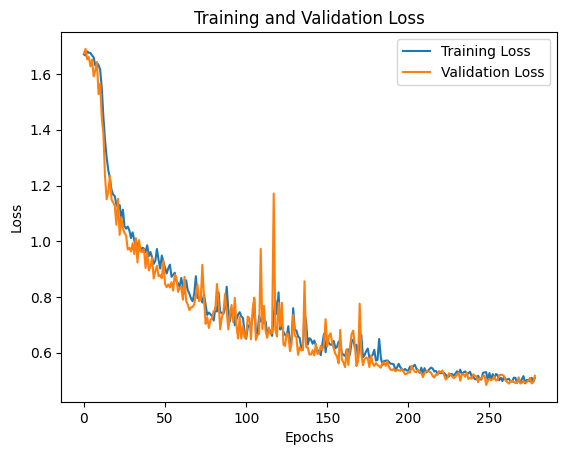

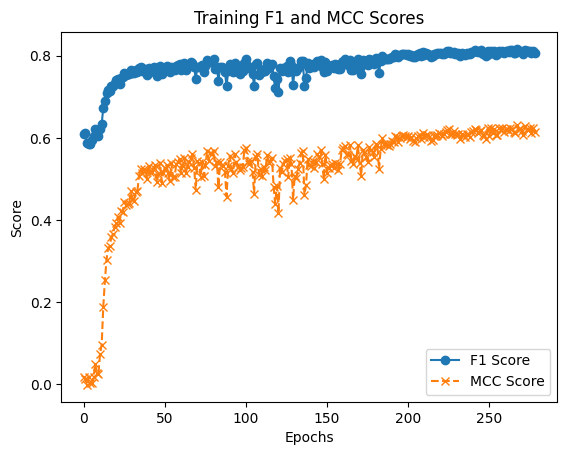

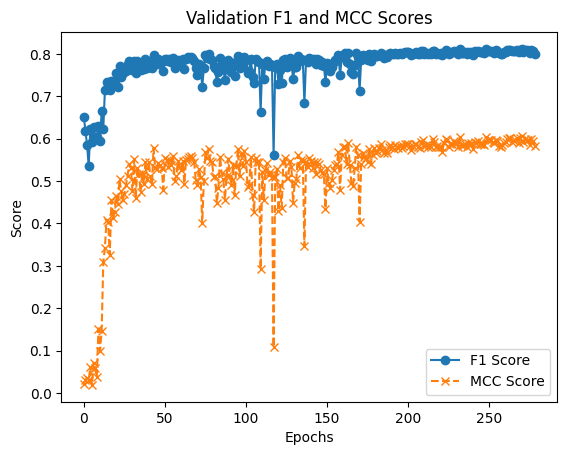

Number of components to preserve 95.0% variance: 385
Epoch [1/1000], Training Loss: 1.6982, Training F1 score: 0.3927, Training MCC score: -0.0221, Training Combine score: 0.1853
[[2257 1215]
 [2351 1153]]
Epoch [1/1000], Validation Loss: 1.6850, Validation F1 score: 0.3600, Validation MCC score: 0.0063, Validation Combine score: 0.1832
[[612 226]
 [645 245]]
Epoch [2/1000], Training Loss: 1.6904, Training F1 score: 0.3889, Training MCC score: 0.0017, Training Combine score: 0.1953
[[2378 1095]
 [2393 1110]]
Epoch [2/1000], Validation Loss: 1.6796, Validation F1 score: 0.4072, Validation MCC score: 0.0220, Validation Combine score: 0.2146
[[578 259]
 [597 294]]
Epoch [3/1000], Training Loss: 1.6992, Training F1 score: 0.3777, Training MCC score: -0.0147, Training Combine score: 0.1815
[[2359 1112]
 [2430 1075]]
Epoch [3/1000], Validation Loss: 1.6773, Validation F1 score: 0.3976, Validation MCC score: 0.0721, Validation Combine score: 0.2349
[[640 203]
 [615 270]]
Epoch [4/1000], Train

Epoch [28/1000], Training Loss: 1.2197, Training F1 score: 0.6875, Training MCC score: 0.3619, Training Combine score: 0.5247
[[2301 1171]
 [1055 2449]]
Epoch [28/1000], Validation Loss: 0.9869, Validation F1 score: 0.7912, Validation MCC score: 0.5371, Validation Combine score: 0.6642
[[547 295]
 [113 773]]
Epoch [29/1000], Training Loss: 1.1958, Training F1 score: 0.6953, Training MCC score: 0.3853, Training Combine score: 0.5403
[[2386 1086]
 [1058 2446]]
Epoch [29/1000], Validation Loss: 1.0467, Validation F1 score: 0.7755, Validation MCC score: 0.5044, Validation Combine score: 0.6399
[[547 294]
 [139 748]]
Epoch [30/1000], Training Loss: 1.1709, Training F1 score: 0.6996, Training MCC score: 0.4003, Training Combine score: 0.5499
[[2448 1023]
 [1069 2436]]
Epoch [30/1000], Validation Loss: 0.9970, Validation F1 score: 0.7918, Validation MCC score: 0.5456, Validation Combine score: 0.6687
[[582 256]
 [139 751]]
Epoch [31/1000], Training Loss: 1.1664, Training F1 score: 0.6966, Tra

Epoch [55/1000], Training Loss: 1.0062, Training F1 score: 0.7215, Training MCC score: 0.4645, Training Combine score: 0.5930
[[2674  795]
 [1079 2428]]
Epoch [55/1000], Validation Loss: 0.8001, Validation F1 score: 0.8179, Validation MCC score: 0.6180, Validation Combine score: 0.7180
[[657 185]
 [145 741]]
Epoch [56/1000], Training Loss: 0.9735, Training F1 score: 0.7330, Training MCC score: 0.4854, Training Combine score: 0.6092
[[2705  771]
 [1029 2471]]
Epoch [56/1000], Validation Loss: 0.9854, Validation F1 score: 0.7377, Validation MCC score: 0.4615, Validation Combine score: 0.5996
[[609 236]
 [229 654]]
Epoch [57/1000], Training Loss: 1.0303, Training F1 score: 0.7073, Training MCC score: 0.4386, Training Combine score: 0.5730
[[2639  836]
 [1128 2373]]
Epoch [57/1000], Validation Loss: 0.9850, Validation F1 score: 0.7422, Validation MCC score: 0.4542, Validation Combine score: 0.5982
[[579 260]
 [211 678]]
Epoch [58/1000], Training Loss: 0.9716, Training F1 score: 0.7281, Tra

Epoch [82/1000], Training Loss: 0.9317, Training F1 score: 0.6860, Training MCC score: 0.4161, Training Combine score: 0.5510
[[2683  786]
 [1266 2241]]
Epoch [82/1000], Validation Loss: 0.7405, Validation F1 score: 0.7869, Validation MCC score: 0.5622, Validation Combine score: 0.6746
[[652 189]
 [189 698]]
Epoch [83/1000], Training Loss: 0.8819, Training F1 score: 0.7131, Training MCC score: 0.4607, Training Combine score: 0.5869
[[2730  742]
 [1151 2353]]
Epoch [83/1000], Validation Loss: 0.8318, Validation F1 score: 0.7482, Validation MCC score: 0.4664, Validation Combine score: 0.6073
[[582 261]
 [200 685]]
Epoch [84/1000], Training Loss: 0.8912, Training F1 score: 0.7094, Training MCC score: 0.4463, Training Combine score: 0.5779
[[2670  804]
 [1135 2367]]
Epoch [84/1000], Validation Loss: 0.6861, Validation F1 score: 0.8060, Validation MCC score: 0.5843, Validation Combine score: 0.6952
[[620 219]
 [141 748]]
Epoch [85/1000], Training Loss: 0.8252, Training F1 score: 0.7387, Tra

Epoch [109/1000], Training Loss: 0.7705, Training F1 score: 0.7359, Training MCC score: 0.4916, Training Combine score: 0.6137
[[2718  756]
 [1023 2479]]
Epoch [109/1000], Validation Loss: 0.6354, Validation F1 score: 0.8088, Validation MCC score: 0.5882, Validation Combine score: 0.6985
[[616 222]
 [135 755]]
Epoch [110/1000], Training Loss: 0.8551, Training F1 score: 0.6933, Training MCC score: 0.4229, Training Combine score: 0.5581
[[2664  808]
 [1216 2288]]
Epoch [110/1000], Validation Loss: 0.8082, Validation F1 score: 0.7288, Validation MCC score: 0.4516, Validation Combine score: 0.5902
[[617 224]
 [250 637]]
Epoch [111/1000], Training Loss: 0.8135, Training F1 score: 0.7133, Training MCC score: 0.4570, Training Combine score: 0.5852
[[2706  771]
 [1132 2367]]
Epoch [111/1000], Validation Loss: 0.7047, Validation F1 score: 0.7731, Validation MCC score: 0.5307, Validation Combine score: 0.6519
[[633 204]
 [201 690]]
Epoch [112/1000], Training Loss: 0.8499, Training F1 score: 0.69

Epoch [136/1000], Training Loss: 0.8718, Training F1 score: 0.6726, Training MCC score: 0.4112, Training Combine score: 0.5419
[[2757  713]
 [1368 2138]]
Epoch [136/1000], Validation Loss: 0.7362, Validation F1 score: 0.7582, Validation MCC score: 0.5068, Validation Combine score: 0.6325
[[634 207]
 [219 668]]
Epoch [137/1000], Training Loss: 0.8286, Training F1 score: 0.6996, Training MCC score: 0.4428, Training Combine score: 0.5712
[[2734  737]
 [1223 2282]]
Epoch [137/1000], Validation Loss: 0.5902, Validation F1 score: 0.8147, Validation MCC score: 0.6084, Validation Combine score: 0.7115
[[644 201]
 [138 745]]
Epoch 00138: reducing learning rate of group 0 to 5.0000e-05.
Epoch [138/1000], Training Loss: 0.8140, Training F1 score: 0.7153, Training MCC score: 0.4402, Training Combine score: 0.5778
[[2567  907]
 [1047 2455]]
Epoch [138/1000], Validation Loss: 0.5947, Validation F1 score: 0.8151, Validation MCC score: 0.6033, Validation Combine score: 0.7092
[[626 214]
 [130 758]]
Ep

Epoch [163/1000], Training Loss: 0.6987, Training F1 score: 0.7564, Training MCC score: 0.5260, Training Combine score: 0.6412
[[2746  726]
 [ 931 2573]]
Epoch [163/1000], Validation Loss: 0.5842, Validation F1 score: 0.8149, Validation MCC score: 0.6038, Validation Combine score: 0.7094
[[630 208]
 [135 755]]
Epoch [164/1000], Training Loss: 0.7050, Training F1 score: 0.7533, Training MCC score: 0.5209, Training Combine score: 0.6371
[[2744  728]
 [ 947 2557]]
Epoch [164/1000], Validation Loss: 0.5334, Validation F1 score: 0.8303, Validation MCC score: 0.6360, Validation Combine score: 0.7331
[[639 200]
 [116 773]]
Epoch [165/1000], Training Loss: 0.7111, Training F1 score: 0.7500, Training MCC score: 0.5188, Training Combine score: 0.6344
[[2764  704]
 [ 981 2527]]
Epoch [165/1000], Validation Loss: 0.5393, Validation F1 score: 0.8270, Validation MCC score: 0.6310, Validation Combine score: 0.7290
[[643 198]
 [122 765]]
Epoch [166/1000], Training Loss: 0.7094, Training F1 score: 0.75

Epoch [190/1000], Training Loss: 0.6979, Training F1 score: 0.7548, Training MCC score: 0.5300, Training Combine score: 0.6424
[[2796  679]
 [ 967 2534]]
Epoch [190/1000], Validation Loss: 0.5312, Validation F1 score: 0.8320, Validation MCC score: 0.6429, Validation Combine score: 0.7375
[[654 185]
 [124 765]]
Epoch [191/1000], Training Loss: 0.6731, Training F1 score: 0.7653, Training MCC score: 0.5502, Training Combine score: 0.6577
[[2831  643]
 [ 933 2569]]
Epoch [191/1000], Validation Loss: 0.5058, Validation F1 score: 0.8388, Validation MCC score: 0.6575, Validation Combine score: 0.7482
[[658 184]
 [113 773]]
Epoch [192/1000], Training Loss: 0.6872, Training F1 score: 0.7598, Training MCC score: 0.5399, Training Combine score: 0.6498
[[2815  660]
 [ 952 2549]]
Epoch [192/1000], Validation Loss: 0.5263, Validation F1 score: 0.8370, Validation MCC score: 0.6536, Validation Combine score: 0.7453
[[658 182]
 [118 770]]
Epoch [193/1000], Training Loss: 0.6853, Training F1 score: 0.76

Epoch [217/1000], Training Loss: 0.7085, Training F1 score: 0.7507, Training MCC score: 0.5213, Training Combine score: 0.6360
[[2777  699]
 [ 977 2523]]
Epoch [217/1000], Validation Loss: 0.5180, Validation F1 score: 0.8348, Validation MCC score: 0.6492, Validation Combine score: 0.7420
[[656 186]
 [118 768]]
Epoch [218/1000], Training Loss: 0.6973, Training F1 score: 0.7558, Training MCC score: 0.5306, Training Combine score: 0.6432
[[2790  688]
 [ 955 2543]]
Epoch [218/1000], Validation Loss: 0.5061, Validation F1 score: 0.8398, Validation MCC score: 0.6583, Validation Combine score: 0.7491
[[656 182]
 [114 776]]
Epoch [219/1000], Training Loss: 0.6708, Training F1 score: 0.7683, Training MCC score: 0.5502, Training Combine score: 0.6593
[[2795  678]
 [ 895 2608]]
Epoch [219/1000], Validation Loss: 0.5250, Validation F1 score: 0.8312, Validation MCC score: 0.6422, Validation Combine score: 0.7367
[[655 188]
 [122 763]]
Epoch [220/1000], Training Loss: 0.6825, Training F1 score: 0.76

Epoch [244/1000], Training Loss: 0.6847, Training F1 score: 0.7598, Training MCC score: 0.5380, Training Combine score: 0.6489
[[2799  670]
 [ 948 2559]]
Epoch [244/1000], Validation Loss: 0.5289, Validation F1 score: 0.8301, Validation MCC score: 0.6377, Validation Combine score: 0.7339
[[647 193]
 [121 767]]
Epoch [245/1000], Training Loss: 0.6909, Training F1 score: 0.7594, Training MCC score: 0.5364, Training Combine score: 0.6479
[[2792  679]
 [ 944 2561]]
Epoch [245/1000], Validation Loss: 0.5171, Validation F1 score: 0.8351, Validation MCC score: 0.6499, Validation Combine score: 0.7425
[[654 191]
 [113 770]]
Epoch [246/1000], Training Loss: 0.6915, Training F1 score: 0.7558, Training MCC score: 0.5324, Training Combine score: 0.6441
[[2801  666]
 [ 973 2536]]
Epoch [246/1000], Validation Loss: 0.5167, Validation F1 score: 0.8340, Validation MCC score: 0.6481, Validation Combine score: 0.7410
[[657 186]
 [119 766]]
Early stopping triggered at epoch 246.
Test Loss: 0.5659, F1 Sco

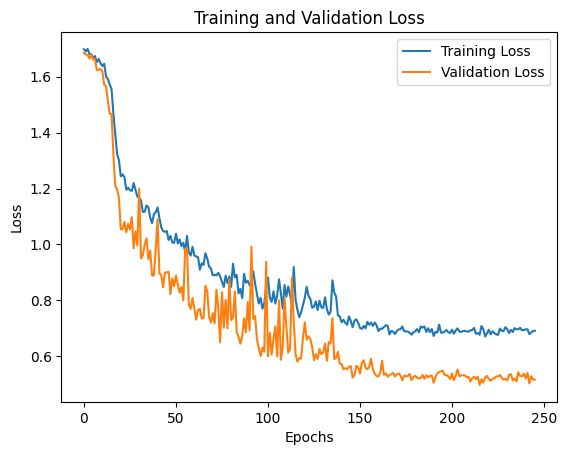

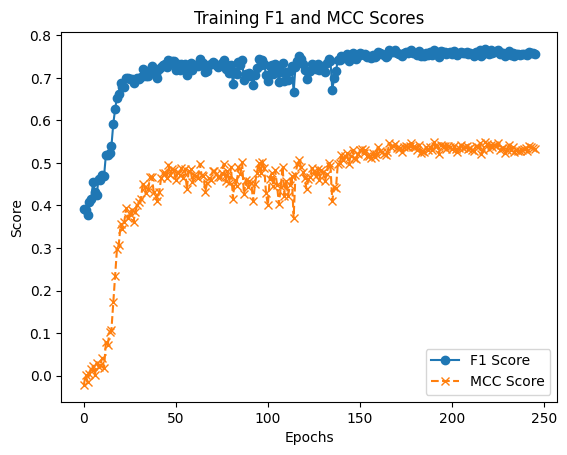

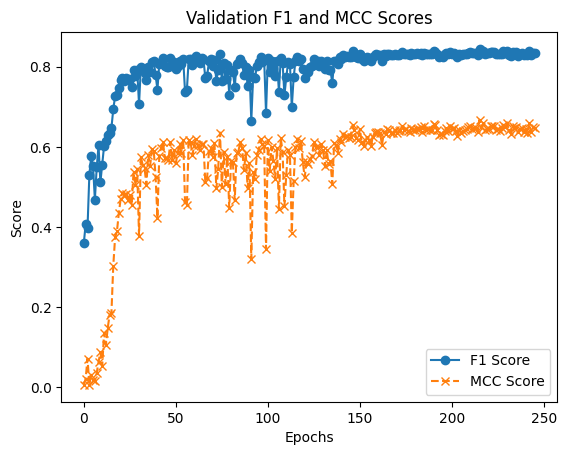

Number of components to preserve 95.0% variance: 383
Epoch [1/1000], Training Loss: 1.6938, Training F1 score: 0.3330, Training MCC score: -0.0096, Training Combine score: 0.1617
[[2561  895]
 [2638  882]]
Epoch [1/1000], Validation Loss: 1.6778, Validation F1 score: 0.3974, Validation MCC score: 0.0547, Validation Combine score: 0.2261
[[635 227]
 [595 271]]
Epoch [2/1000], Training Loss: 1.6822, Training F1 score: 0.3793, Training MCC score: 0.0057, Training Combine score: 0.1925
[[2429 1026]
 [2457 1064]]
Epoch [2/1000], Validation Loss: 1.6727, Validation F1 score: 0.5346, Validation MCC score: 0.0424, Validation Combine score: 0.2885
[[426 430]
 [397 475]]
Epoch [3/1000], Training Loss: 1.6753, Training F1 score: 0.3855, Training MCC score: -0.0023, Training Combine score: 0.1916
[[2369 1088]
 [2419 1100]]
Epoch [3/1000], Validation Loss: 1.6811, Validation F1 score: 0.4940, Validation MCC score: 0.0306, Validation Combine score: 0.2623
[[481 379]
 [459 409]]
Epoch [4/1000], Train

Epoch [28/1000], Training Loss: 1.1916, Training F1 score: 0.6612, Training MCC score: 0.3722, Training Combine score: 0.5167
[[2615  842]
 [1365 2154]]
Epoch [28/1000], Validation Loss: 1.0054, Validation F1 score: 0.7751, Validation MCC score: 0.5206, Validation Combine score: 0.6479
[[587 274]
 [145 722]]
Epoch [29/1000], Training Loss: 1.1687, Training F1 score: 0.6744, Training MCC score: 0.3947, Training Combine score: 0.5346
[[2642  810]
 [1319 2205]]
Epoch [29/1000], Validation Loss: 0.9287, Validation F1 score: 0.7971, Validation MCC score: 0.5617, Validation Combine score: 0.6794
[[572 289]
 [101 766]]
Epoch [30/1000], Training Loss: 1.1776, Training F1 score: 0.6615, Training MCC score: 0.3825, Training Combine score: 0.5220
[[2670  784]
 [1394 2128]]
Epoch [30/1000], Validation Loss: 0.9860, Validation F1 score: 0.7759, Validation MCC score: 0.5228, Validation Combine score: 0.6493
[[592 266]
 [150 720]]
Epoch [31/1000], Training Loss: 1.1470, Training F1 score: 0.6798, Tra

Epoch [55/1000], Training Loss: 0.9761, Training F1 score: 0.6773, Training MCC score: 0.4294, Training Combine score: 0.5533
[[2816  637]
 [1393 2130]]
Epoch [55/1000], Validation Loss: 0.8061, Validation F1 score: 0.7778, Validation MCC score: 0.5236, Validation Combine score: 0.6507
[[584 272]
 [144 728]]
Epoch [56/1000], Training Loss: 0.9735, Training F1 score: 0.6749, Training MCC score: 0.4275, Training Combine score: 0.5512
[[2823  632]
 [1406 2115]]
Epoch [56/1000], Validation Loss: 0.7100, Validation F1 score: 0.8075, Validation MCC score: 0.5975, Validation Combine score: 0.7025
[[647 208]
 [141 732]]
Epoch [57/1000], Training Loss: 1.0052, Training F1 score: 0.6519, Training MCC score: 0.3902, Training Combine score: 0.5211
[[2776  678]
 [1491 2031]]
Epoch [57/1000], Validation Loss: 0.7033, Validation F1 score: 0.8149, Validation MCC score: 0.6117, Validation Combine score: 0.7133
[[646 213]
 [125 744]]
Epoch [58/1000], Training Loss: 0.9673, Training F1 score: 0.6796, Tra

Epoch [82/1000], Training Loss: 0.7808, Training F1 score: 0.7099, Training MCC score: 0.4766, Training Combine score: 0.5933
[[2847  607]
 [1250 2272]]
Epoch [82/1000], Validation Loss: 0.5697, Validation F1 score: 0.8137, Validation MCC score: 0.6077, Validation Combine score: 0.7107
[[636 226]
 [117 749]]
Epoch [83/1000], Training Loss: 0.8002, Training F1 score: 0.6944, Training MCC score: 0.4630, Training Combine score: 0.5787
[[2881  572]
 [1345 2178]]
Epoch [83/1000], Validation Loss: 0.5856, Validation F1 score: 0.8065, Validation MCC score: 0.5982, Validation Combine score: 0.7023
[[655 202]
 [146 725]]
Epoch [84/1000], Training Loss: 0.8287, Training F1 score: 0.6787, Training MCC score: 0.4405, Training Combine score: 0.5596
[[2868  590]
 [1408 2110]]
Epoch [84/1000], Validation Loss: 0.5998, Validation F1 score: 0.7976, Validation MCC score: 0.5757, Validation Combine score: 0.6866
[[635 220]
 [148 725]]
Epoch [85/1000], Training Loss: 0.8149, Training F1 score: 0.6892, Tra

Epoch [109/1000], Training Loss: 0.7917, Training F1 score: 0.6753, Training MCC score: 0.4285, Training Combine score: 0.5519
[[2825  629]
 [1406 2116]]
Epoch [109/1000], Validation Loss: 0.5522, Validation F1 score: 0.8024, Validation MCC score: 0.5816, Validation Combine score: 0.6920
[[625 229]
 [135 739]]
Epoch [110/1000], Training Loss: 0.7788, Training F1 score: 0.6824, Training MCC score: 0.4388, Training Combine score: 0.5606
[[2832  620]
 [1378 2146]]
Epoch [110/1000], Validation Loss: 0.7181, Validation F1 score: 0.7336, Validation MCC score: 0.4503, Validation Combine score: 0.5920
[[599 256]
 [219 654]]
Epoch [111/1000], Training Loss: 0.8141, Training F1 score: 0.6629, Training MCC score: 0.4065, Training Combine score: 0.5347
[[2789  663]
 [1448 2076]]
Epoch [111/1000], Validation Loss: 0.6088, Validation F1 score: 0.7811, Validation MCC score: 0.5413, Validation Combine score: 0.6612
[[620 238]
 [160 710]]
Epoch [112/1000], Training Loss: 0.7730, Training F1 score: 0.68

Epoch [136/1000], Training Loss: 0.8501, Training F1 score: 0.6351, Training MCC score: 0.3625, Training Combine score: 0.4988
[[2738  713]
 [1553 1972]]
Epoch [136/1000], Validation Loss: 0.5234, Validation F1 score: 0.8088, Validation MCC score: 0.6001, Validation Combine score: 0.7044
[[647 209]
 [138 734]]
Epoch [137/1000], Training Loss: 0.8101, Training F1 score: 0.6561, Training MCC score: 0.4025, Training Combine score: 0.5293
[[2812  641]
 [1490 2033]]
Epoch [137/1000], Validation Loss: 0.5651, Validation F1 score: 0.7940, Validation MCC score: 0.5701, Validation Combine score: 0.6821
[[636 223]
 [150 719]]
Epoch [138/1000], Training Loss: 0.7222, Training F1 score: 0.7042, Training MCC score: 0.4767, Training Combine score: 0.5904
[[2889  566]
 [1300 2221]]
Epoch [138/1000], Validation Loss: 0.4988, Validation F1 score: 0.8189, Validation MCC score: 0.6165, Validation Combine score: 0.7177
[[639 214]
 [120 755]]
Epoch [139/1000], Training Loss: 0.7635, Training F1 score: 0.68

Epoch [163/1000], Training Loss: 0.7281, Training F1 score: 0.6913, Training MCC score: 0.4378, Training Combine score: 0.5646
[[2764  691]
 [1296 2225]]
Epoch [163/1000], Validation Loss: 0.6279, Validation F1 score: 0.7588, Validation MCC score: 0.4846, Validation Combine score: 0.6217
[[570 291]
 [159 708]]
Epoch [164/1000], Training Loss: 0.7322, Training F1 score: 0.6867, Training MCC score: 0.4311, Training Combine score: 0.5589
[[2759  693]
 [1319 2205]]
Epoch [164/1000], Validation Loss: 0.6398, Validation F1 score: 0.7538, Validation MCC score: 0.4773, Validation Combine score: 0.6156
[[579 278]
 [176 695]]
Epoch [165/1000], Training Loss: 0.7274, Training F1 score: 0.6881, Training MCC score: 0.4390, Training Combine score: 0.5636
[[2795  661]
 [1327 2193]]
Epoch [165/1000], Validation Loss: 0.5384, Validation F1 score: 0.7871, Validation MCC score: 0.5579, Validation Combine score: 0.6725
[[637 222]
 [161 708]]
Epoch [166/1000], Training Loss: 0.7428, Training F1 score: 0.67

Epoch [190/1000], Training Loss: 0.6630, Training F1 score: 0.7114, Training MCC score: 0.4902, Training Combine score: 0.6008
[[2913  542]
 [1278 2243]]
Epoch [190/1000], Validation Loss: 0.4460, Validation F1 score: 0.8202, Validation MCC score: 0.6234, Validation Combine score: 0.7218
[[652 208]
 [120 748]]
Epoch [191/1000], Training Loss: 0.6563, Training F1 score: 0.7141, Training MCC score: 0.4971, Training Combine score: 0.6056
[[2932  524]
 [1274 2246]]
Epoch [191/1000], Validation Loss: 0.4288, Validation F1 score: 0.8242, Validation MCC score: 0.6294, Validation Combine score: 0.7268
[[648 208]
 [115 757]]
Epoch [192/1000], Training Loss: 0.6551, Training F1 score: 0.7156, Training MCC score: 0.4964, Training Combine score: 0.6060
[[2918  538]
 [1259 2261]]
Epoch [192/1000], Validation Loss: 0.4593, Validation F1 score: 0.8168, Validation MCC score: 0.6149, Validation Combine score: 0.7159
[[646 210]
 [125 747]]
Epoch [193/1000], Training Loss: 0.6434, Training F1 score: 0.71

Epoch [217/1000], Training Loss: 0.6500, Training F1 score: 0.7090, Training MCC score: 0.4901, Training Combine score: 0.5995
[[2928  525]
 [1300 2223]]
Epoch [217/1000], Validation Loss: 0.4264, Validation F1 score: 0.8211, Validation MCC score: 0.6230, Validation Combine score: 0.7221
[[644 214]
 [115 755]]
Epoch [218/1000], Training Loss: 0.6221, Training F1 score: 0.7247, Training MCC score: 0.5131, Training Combine score: 0.6189
[[2946  510]
 [1230 2290]]
Epoch [218/1000], Validation Loss: 0.4375, Validation F1 score: 0.8188, Validation MCC score: 0.6194, Validation Combine score: 0.7191
[[646 214]
 [118 750]]
Epoch [219/1000], Training Loss: 0.6403, Training F1 score: 0.7126, Training MCC score: 0.5012, Training Combine score: 0.6069
[[2962  489]
 [1303 2222]]
Epoch [219/1000], Validation Loss: 0.4357, Validation F1 score: 0.8167, Validation MCC score: 0.6173, Validation Combine score: 0.7170
[[653 208]
 [125 742]]
Epoch [220/1000], Training Loss: 0.6397, Training F1 score: 0.71

Epoch [244/1000], Training Loss: 0.6157, Training F1 score: 0.7236, Training MCC score: 0.5055, Training Combine score: 0.6145
[[2910  544]
 [1217 2305]]
Epoch [244/1000], Validation Loss: 0.3917, Validation F1 score: 0.8262, Validation MCC score: 0.6330, Validation Combine score: 0.7296
[[644 214]
 [107 763]]
Epoch [245/1000], Training Loss: 0.6239, Training F1 score: 0.7175, Training MCC score: 0.4992, Training Combine score: 0.6084
[[2920  535]
 [1252 2269]]
Epoch [245/1000], Validation Loss: 0.4000, Validation F1 score: 0.8251, Validation MCC score: 0.6307, Validation Combine score: 0.7279
[[643 215]
 [108 762]]
Epoch [246/1000], Training Loss: 0.6099, Training F1 score: 0.7268, Training MCC score: 0.5093, Training Combine score: 0.6180
[[2908  546]
 [1200 2322]]
Epoch [246/1000], Validation Loss: 0.4173, Validation F1 score: 0.8198, Validation MCC score: 0.6214, Validation Combine score: 0.7206
[[644 218]
 [113 753]]
Epoch [247/1000], Training Loss: 0.6126, Training F1 score: 0.72

Epoch [271/1000], Training Loss: 0.6020, Training F1 score: 0.7251, Training MCC score: 0.5129, Training Combine score: 0.6190
[[2943  515]
 [1224 2294]]
Epoch [271/1000], Validation Loss: 0.3898, Validation F1 score: 0.8266, Validation MCC score: 0.6361, Validation Combine score: 0.7313
[[652 209]
 [109 758]]
Epoch [272/1000], Training Loss: 0.5905, Training F1 score: 0.7289, Training MCC score: 0.5218, Training Combine score: 0.6253
[[2962  490]
 [1222 2302]]
Epoch [272/1000], Validation Loss: 0.3896, Validation F1 score: 0.8270, Validation MCC score: 0.6360, Validation Combine score: 0.7315
[[650 209]
 [109 760]]
Epoch [273/1000], Training Loss: 0.5986, Training F1 score: 0.7279, Training MCC score: 0.5169, Training Combine score: 0.6224
[[2944  511]
 [1214 2307]]
Epoch [273/1000], Validation Loss: 0.3853, Validation F1 score: 0.8276, Validation MCC score: 0.6368, Validation Combine score: 0.7322
[[650 207]
 [110 761]]
Epoch [274/1000], Training Loss: 0.6077, Training F1 score: 0.72

Epoch [298/1000], Training Loss: 0.6001, Training F1 score: 0.7266, Training MCC score: 0.5199, Training Combine score: 0.6232
[[2971  485]
 [1235 2285]]
Epoch [298/1000], Validation Loss: 0.3817, Validation F1 score: 0.8297, Validation MCC score: 0.6400, Validation Combine score: 0.7349
[[649 205]
 [109 765]]
Epoch [299/1000], Training Loss: 0.5917, Training F1 score: 0.7295, Training MCC score: 0.5194, Training Combine score: 0.6244
[[2946  509]
 [1207 2314]]
Epoch [299/1000], Validation Loss: 0.3963, Validation F1 score: 0.8283, Validation MCC score: 0.6390, Validation Combine score: 0.7337
[[653 205]
 [110 760]]
Epoch [300/1000], Training Loss: 0.6046, Training F1 score: 0.7220, Training MCC score: 0.5067, Training Combine score: 0.6144
[[2928  525]
 [1236 2287]]
Epoch [300/1000], Validation Loss: 0.3814, Validation F1 score: 0.8289, Validation MCC score: 0.6391, Validation Combine score: 0.7340
[[650 206]
 [109 763]]
Epoch [301/1000], Training Loss: 0.5872, Training F1 score: 0.73

Epoch [325/1000], Training Loss: 0.5921, Training F1 score: 0.7285, Training MCC score: 0.5209, Training Combine score: 0.6247
[[2962  494]
 [1220 2300]]
Epoch [325/1000], Validation Loss: 0.3856, Validation F1 score: 0.8272, Validation MCC score: 0.6369, Validation Combine score: 0.7321
[[652 207]
 [110 759]]
Epoch [326/1000], Training Loss: 0.6061, Training F1 score: 0.7206, Training MCC score: 0.5086, Training Combine score: 0.6146
[[2951  506]
 [1252 2267]]
Epoch [326/1000], Validation Loss: 0.3827, Validation F1 score: 0.8284, Validation MCC score: 0.6406, Validation Combine score: 0.7345
[[656 206]
 [108 758]]
Epoch [327/1000], Training Loss: 0.5969, Training F1 score: 0.7293, Training MCC score: 0.5164, Training Combine score: 0.6229
[[2932  526]
 [1197 2321]]
Epoch [327/1000], Validation Loss: 0.3876, Validation F1 score: 0.8292, Validation MCC score: 0.6384, Validation Combine score: 0.7338
[[645 210]
 [106 767]]
Epoch [328/1000], Training Loss: 0.5914, Training F1 score: 0.72

Epoch [352/1000], Training Loss: 0.6139, Training F1 score: 0.7159, Training MCC score: 0.5028, Training Combine score: 0.6093
[[2949  503]
 [1279 2245]]
Epoch [352/1000], Validation Loss: 0.3798, Validation F1 score: 0.8295, Validation MCC score: 0.6427, Validation Combine score: 0.7361
[[657 204]
 [108 759]]
Epoch [353/1000], Training Loss: 0.5717, Training F1 score: 0.7401, Training MCC score: 0.5341, Training Combine score: 0.6371
[[2948  501]
 [1161 2366]]
Epoch [353/1000], Validation Loss: 0.3851, Validation F1 score: 0.8278, Validation MCC score: 0.6387, Validation Combine score: 0.7333
[[656 203]
 [112 757]]
Epoch [354/1000], Training Loss: 0.5830, Training F1 score: 0.7305, Training MCC score: 0.5247, Training Combine score: 0.6276
[[2970  487]
 [1214 2305]]
Epoch [354/1000], Validation Loss: 0.3850, Validation F1 score: 0.8280, Validation MCC score: 0.6371, Validation Combine score: 0.7326
[[648 209]
 [108 763]]
Epoch [355/1000], Training Loss: 0.5672, Training F1 score: 0.74

Epoch [379/1000], Training Loss: 0.5862, Training F1 score: 0.7308, Training MCC score: 0.5253, Training Combine score: 0.6281
[[2966  481]
 [1220 2309]]
Epoch [379/1000], Validation Loss: 0.3741, Validation F1 score: 0.8297, Validation MCC score: 0.6429, Validation Combine score: 0.7363
[[656 205]
 [107 760]]
Epoch [380/1000], Training Loss: 0.5939, Training F1 score: 0.7258, Training MCC score: 0.5171, Training Combine score: 0.6214
[[2961  496]
 [1232 2287]]
Epoch [380/1000], Validation Loss: 0.3781, Validation F1 score: 0.8313, Validation MCC score: 0.6449, Validation Combine score: 0.7381
[[654 203]
 [107 764]]
Epoch [381/1000], Training Loss: 0.5968, Training F1 score: 0.7249, Training MCC score: 0.5136, Training Combine score: 0.6192
[[2946  507]
 [1232 2291]]
Epoch [381/1000], Validation Loss: 0.3796, Validation F1 score: 0.8301, Validation MCC score: 0.6426, Validation Combine score: 0.7363
[[654 204]
 [108 762]]
Epoch [382/1000], Training Loss: 0.5834, Training F1 score: 0.73

Epoch [406/1000], Training Loss: 0.5780, Training F1 score: 0.7343, Training MCC score: 0.5326, Training Combine score: 0.6334
[[2987  470]
 [1205 2314]]
Epoch [406/1000], Validation Loss: 0.3736, Validation F1 score: 0.8297, Validation MCC score: 0.6425, Validation Combine score: 0.7361
[[656 203]
 [109 760]]
Epoch [407/1000], Training Loss: 0.5978, Training F1 score: 0.7218, Training MCC score: 0.5154, Training Combine score: 0.6186
[[2977  474]
 [1267 2258]]
Epoch [407/1000], Validation Loss: 0.3767, Validation F1 score: 0.8305, Validation MCC score: 0.6435, Validation Combine score: 0.7370
[[655 202]
 [109 762]]
Epoch [408/1000], Training Loss: 0.5751, Training F1 score: 0.7368, Training MCC score: 0.5355, Training Combine score: 0.6361
[[2983  470]
 [1194 2329]]
Epoch [408/1000], Validation Loss: 0.3807, Validation F1 score: 0.8288, Validation MCC score: 0.6403, Validation Combine score: 0.7345
[[654 205]
 [109 760]]
Early stopping triggered at epoch 408.
Test Loss: 0.3801, F1 Sco

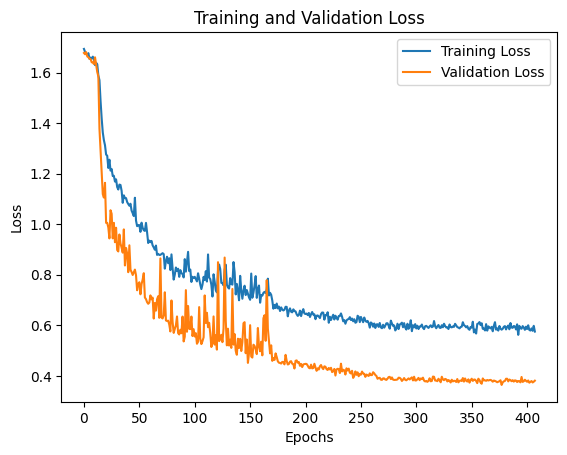

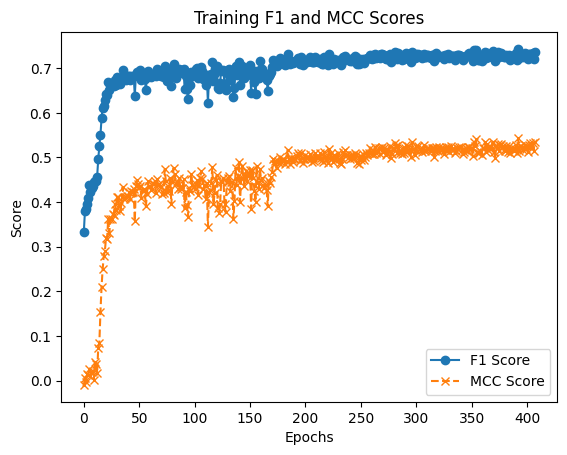

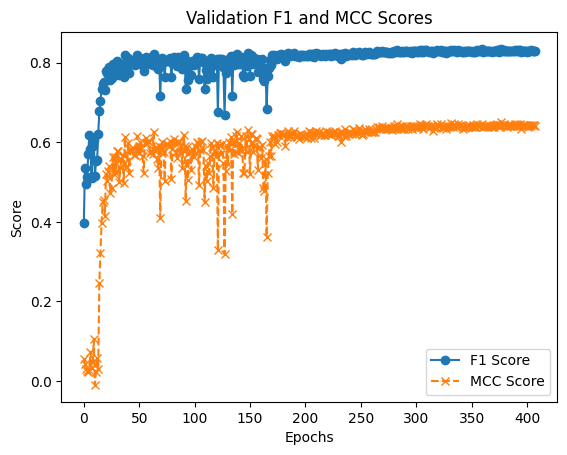

Number of components to preserve 95.0% variance: 383
Epoch [1/1000], Training Loss: 1.6720, Training F1 score: 0.3973, Training MCC score: 0.0222, Training Combine score: 0.2097
[[2421 1041]
 [2385 1129]]
Epoch [1/1000], Validation Loss: 1.6851, Validation F1 score: 0.3191, Validation MCC score: 0.0325, Validation Combine score: 0.1758
[[685 172]
 [673 198]]
Epoch [2/1000], Training Loss: 1.6890, Training F1 score: 0.3735, Training MCC score: -0.0154, Training Combine score: 0.1790
[[2368 1088]
 [2462 1058]]
Epoch [2/1000], Validation Loss: 1.6879, Validation F1 score: 0.2908, Validation MCC score: -0.0141, Validation Combine score: 0.1383
[[670 187]
 [691 180]]
Epoch [3/1000], Training Loss: 1.6817, Training F1 score: 0.3968, Training MCC score: 0.0204, Training Combine score: 0.2086
[[2414 1045]
 [2388 1129]]
Epoch [3/1000], Validation Loss: 1.6859, Validation F1 score: 0.3321, Validation MCC score: -0.0134, Validation Combine score: 0.1594
[[633 225]
 [652 218]]
Epoch [4/1000], Trai

Epoch [28/1000], Training Loss: 1.0538, Training F1 score: 0.7394, Training MCC score: 0.4563, Training Combine score: 0.5979
[[2383 1073]
 [ 826 2694]]
Epoch [28/1000], Validation Loss: 1.0273, Validation F1 score: 0.7605, Validation MCC score: 0.4849, Validation Combine score: 0.6227
[[566 289]
 [160 713]]
Epoch [29/1000], Training Loss: 1.1230, Training F1 score: 0.7143, Training MCC score: 0.3991, Training Combine score: 0.5567
[[2253 1200]
 [ 899 2624]]
Epoch [29/1000], Validation Loss: 0.9282, Validation F1 score: 0.7876, Validation MCC score: 0.5340, Validation Combine score: 0.6608
[[532 326]
 [ 93 777]]
Epoch [30/1000], Training Loss: 1.0522, Training F1 score: 0.7376, Training MCC score: 0.4474, Training Combine score: 0.5925
[[2328 1124]
 [ 808 2716]]
Epoch [30/1000], Validation Loss: 0.8910, Validation F1 score: 0.8021, Validation MCC score: 0.5686, Validation Combine score: 0.6854
[[566 288]
 [ 96 778]]
Epoch [31/1000], Training Loss: 1.0152, Training F1 score: 0.7526, Tra

Epoch [55/1000], Training Loss: 0.8295, Training F1 score: 0.7690, Training MCC score: 0.5312, Training Combine score: 0.6501
[[2620  835]
 [ 800 2721]]
Epoch [55/1000], Validation Loss: 0.7500, Validation F1 score: 0.8017, Validation MCC score: 0.5743, Validation Combine score: 0.6880
[[598 258]
 [116 756]]
Epoch [56/1000], Training Loss: 0.8037, Training F1 score: 0.7761, Training MCC score: 0.5481, Training Combine score: 0.6621
[[2668  793]
 [ 783 2732]]
Epoch [56/1000], Validation Loss: 0.7677, Validation F1 score: 0.7967, Validation MCC score: 0.5702, Validation Combine score: 0.6835
[[621 235]
 [139 733]]
Epoch [57/1000], Training Loss: 0.8252, Training F1 score: 0.7651, Training MCC score: 0.5309, Training Combine score: 0.6480
[[2673  781]
 [ 856 2666]]
Epoch [57/1000], Validation Loss: 0.7137, Validation F1 score: 0.8148, Validation MCC score: 0.6087, Validation Combine score: 0.7118
[[637 219]
 [122 750]]
Epoch [58/1000], Training Loss: 0.8298, Training F1 score: 0.7608, Tra

Epoch [82/1000], Training Loss: 0.7151, Training F1 score: 0.7690, Training MCC score: 0.5263, Training Combine score: 0.6476
[[2571  889]
 [ 764 2752]]
Epoch [82/1000], Validation Loss: 0.6047, Validation F1 score: 0.8113, Validation MCC score: 0.5933, Validation Combine score: 0.7023
[[591 266]
 [ 95 776]]
Epoch [83/1000], Training Loss: 0.7208, Training F1 score: 0.7689, Training MCC score: 0.5164, Training Combine score: 0.6427
[[2472  984]
 [ 707 2813]]
Epoch [83/1000], Validation Loss: 0.6126, Validation F1 score: 0.8034, Validation MCC score: 0.5680, Validation Combine score: 0.6857
[[529 325]
 [ 69 805]]
Epoch [84/1000], Training Loss: 0.7265, Training F1 score: 0.7657, Training MCC score: 0.4992, Training Combine score: 0.6324
[[2338 1119]
 [ 642 2877]]
Epoch [84/1000], Validation Loss: 0.5720, Validation F1 score: 0.8155, Validation MCC score: 0.6002, Validation Combine score: 0.7078
[[563 295]
 [ 68 802]]
Epoch [85/1000], Training Loss: 0.7493, Training F1 score: 0.7554, Tra

Epoch [109/1000], Training Loss: 0.6255, Training F1 score: 0.7808, Training MCC score: 0.5500, Training Combine score: 0.6654
[[2610  844]
 [ 726 2796]]
Epoch [109/1000], Validation Loss: 0.5065, Validation F1 score: 0.8245, Validation MCC score: 0.6234, Validation Combine score: 0.7240
[[606 251]
 [ 84 787]]
Epoch [110/1000], Training Loss: 0.6150, Training F1 score: 0.7849, Training MCC score: 0.5571, Training Combine score: 0.6710
[[2609  850]
 [ 696 2821]]
Epoch [110/1000], Validation Loss: 0.5457, Validation F1 score: 0.8088, Validation MCC score: 0.5884, Validation Combine score: 0.6986
[[597 258]
 [105 768]]
Epoch [111/1000], Training Loss: 0.7111, Training F1 score: 0.7411, Training MCC score: 0.4756, Training Combine score: 0.6083
[[2529  929]
 [ 900 2618]]
Epoch [111/1000], Validation Loss: 0.7315, Validation F1 score: 0.7390, Validation MCC score: 0.4454, Validation Combine score: 0.5922
[[566 289]
 [192 681]]
Epoch [112/1000], Training Loss: 0.7002, Training F1 score: 0.74

Epoch [136/1000], Training Loss: 0.6027, Training F1 score: 0.7734, Training MCC score: 0.5409, Training Combine score: 0.6572
[[2643  813]
 [ 788 2732]]
Epoch [136/1000], Validation Loss: 0.4911, Validation F1 score: 0.8170, Validation MCC score: 0.6073, Validation Combine score: 0.7122
[[613 240]
 [105 770]]
Epoch [137/1000], Training Loss: 0.6055, Training F1 score: 0.7691, Training MCC score: 0.5367, Training Combine score: 0.6529
[[2669  790]
 [ 826 2691]]
Epoch [137/1000], Validation Loss: 0.5013, Validation F1 score: 0.8115, Validation MCC score: 0.6007, Validation Combine score: 0.7061
[[628 230]
 [119 751]]
Epoch [138/1000], Training Loss: 0.6523, Training F1 score: 0.7487, Training MCC score: 0.4925, Training Combine score: 0.6206
[[2570  886]
 [ 884 2636]]
Epoch [138/1000], Validation Loss: 0.5580, Validation F1 score: 0.7913, Validation MCC score: 0.5520, Validation Combine score: 0.6716
[[593 262]
 [130 743]]
Epoch [139/1000], Training Loss: 0.5880, Training F1 score: 0.77

Epoch [163/1000], Training Loss: 0.5751, Training F1 score: 0.7780, Training MCC score: 0.5570, Training Combine score: 0.6675
[[2721  731]
 [ 815 2709]]
Epoch [163/1000], Validation Loss: 0.5376, Validation F1 score: 0.8000, Validation MCC score: 0.5755, Validation Combine score: 0.6878
[[621 231]
 [138 738]]
Epoch [164/1000], Training Loss: 0.6049, Training F1 score: 0.7652, Training MCC score: 0.5355, Training Combine score: 0.6503
[[2711  745]
 [ 877 2643]]
Epoch [164/1000], Validation Loss: 0.4819, Validation F1 score: 0.8193, Validation MCC score: 0.6182, Validation Combine score: 0.7187
[[637 222]
 [112 757]]
Epoch [165/1000], Training Loss: 0.5659, Training F1 score: 0.7829, Training MCC score: 0.5640, Training Combine score: 0.6734
[[2712  745]
 [ 776 2743]]
Epoch [165/1000], Validation Loss: 0.4432, Validation F1 score: 0.8310, Validation MCC score: 0.6409, Validation Combine score: 0.7360
[[635 222]
 [ 94 777]]
Epoch [166/1000], Training Loss: 0.5611, Training F1 score: 0.78

Epoch [190/1000], Training Loss: 0.6003, Training F1 score: 0.7581, Training MCC score: 0.5214, Training Combine score: 0.6397
[[2687  771]
 [ 900 2618]]
Epoch [190/1000], Validation Loss: 0.5062, Validation F1 score: 0.7985, Validation MCC score: 0.5782, Validation Combine score: 0.6883
[[637 220]
 [146 725]]
Epoch [191/1000], Training Loss: 0.5629, Training F1 score: 0.7745, Training MCC score: 0.5529, Training Combine score: 0.6637
[[2735  721]
 [ 840 2680]]
Epoch [191/1000], Validation Loss: 0.5214, Validation F1 score: 0.7930, Validation MCC score: 0.5652, Validation Combine score: 0.6791
[[626 233]
 [145 724]]
Epoch [192/1000], Training Loss: 0.5458, Training F1 score: 0.7809, Training MCC score: 0.5599, Training Combine score: 0.6704
[[2705  751]
 [ 784 2736]]
Epoch [192/1000], Validation Loss: 0.4503, Validation F1 score: 0.8167, Validation MCC score: 0.6129, Validation Combine score: 0.7148
[[634 227]
 [112 755]]
Epoch [193/1000], Training Loss: 0.5039, Training F1 score: 0.79

Epoch [217/1000], Training Loss: 0.5169, Training F1 score: 0.7956, Training MCC score: 0.5816, Training Combine score: 0.6886
[[2674  785]
 [ 675 2842]]
Epoch [217/1000], Validation Loss: 0.4149, Validation F1 score: 0.8283, Validation MCC score: 0.6339, Validation Combine score: 0.7311
[[626 231]
 [ 92 779]]
Epoch [218/1000], Training Loss: 0.5274, Training F1 score: 0.7879, Training MCC score: 0.5688, Training Combine score: 0.6784
[[2678  780]
 [ 724 2794]]
Epoch [218/1000], Validation Loss: 0.5428, Validation F1 score: 0.7839, Validation MCC score: 0.5388, Validation Combine score: 0.6613
[[597 258]
 [144 729]]
Epoch [219/1000], Training Loss: 0.5741, Training F1 score: 0.7672, Training MCC score: 0.5292, Training Combine score: 0.6482
[[2629  830]
 [ 812 2705]]
Epoch [219/1000], Validation Loss: 0.4483, Validation F1 score: 0.8203, Validation MCC score: 0.6165, Validation Combine score: 0.7184
[[622 234]
 [103 769]]
Epoch [220/1000], Training Loss: 0.5599, Training F1 score: 0.77

Epoch [244/1000], Training Loss: 0.5354, Training F1 score: 0.7786, Training MCC score: 0.5680, Training Combine score: 0.6733
[[2808  652]
 [ 859 2657]]
Epoch [244/1000], Validation Loss: 0.5152, Validation F1 score: 0.7872, Validation MCC score: 0.5945, Validation Combine score: 0.6908
[[722 135]
 [218 653]]
Epoch [245/1000], Training Loss: 0.4967, Training F1 score: 0.7962, Training MCC score: 0.5883, Training Combine score: 0.6922
[[2735  723]
 [ 713 2805]]
Epoch [245/1000], Validation Loss: 0.4486, Validation F1 score: 0.8136, Validation MCC score: 0.5966, Validation Combine score: 0.7051
[[573 285]
 [ 78 792]]
Epoch [246/1000], Training Loss: 0.4890, Training F1 score: 0.7981, Training MCC score: 0.5968, Training Combine score: 0.6974
[[2788  670]
 [ 737 2781]]
Epoch [246/1000], Validation Loss: 0.4129, Validation F1 score: 0.8276, Validation MCC score: 0.6312, Validation Combine score: 0.7294
[[616 241]
 [ 86 785]]
Epoch [247/1000], Training Loss: 0.5511, Training F1 score: 0.77

Epoch [271/1000], Training Loss: 0.4398, Training F1 score: 0.8010, Training MCC score: 0.6001, Training Combine score: 0.7005
[[2774  681]
 [ 714 2807]]
Epoch [271/1000], Validation Loss: 0.3359, Validation F1 score: 0.8326, Validation MCC score: 0.6407, Validation Combine score: 0.7367
[[605 251]
 [ 71 801]]
Epoch [272/1000], Training Loss: 0.4663, Training F1 score: 0.7895, Training MCC score: 0.5644, Training Combine score: 0.6770
[[2603  851]
 [ 670 2852]]
Epoch [272/1000], Validation Loss: 0.3353, Validation F1 score: 0.8407, Validation MCC score: 0.6635, Validation Combine score: 0.7521
[[662 189]
 [104 773]]
Epoch [273/1000], Training Loss: 0.5017, Training F1 score: 0.7729, Training MCC score: 0.5170, Training Combine score: 0.6449
[[2392 1067]
 [ 630 2887]]
Epoch [273/1000], Validation Loss: 0.3668, Validation F1 score: 0.8160, Validation MCC score: 0.6012, Validation Combine score: 0.7086
[[557 301]
 [ 63 807]]
Epoch [274/1000], Training Loss: 0.4279, Training F1 score: 0.80

Epoch [298/1000], Training Loss: 0.3515, Training F1 score: 0.8195, Training MCC score: 0.6356, Training Combine score: 0.7275
[[2820  634]
 [ 637 2885]]
Epoch [298/1000], Validation Loss: 0.2847, Validation F1 score: 0.8375, Validation MCC score: 0.6515, Validation Combine score: 0.7445
[[612 243]
 [ 69 804]]
Epoch [299/1000], Training Loss: 0.3759, Training F1 score: 0.8065, Training MCC score: 0.6131, Training Combine score: 0.7098
[[2813  644]
 [ 706 2813]]
Epoch [299/1000], Validation Loss: 0.2795, Validation F1 score: 0.8418, Validation MCC score: 0.6609, Validation Combine score: 0.7514
[[626 226]
 [ 75 801]]
Epoch [300/1000], Training Loss: 0.3654, Training F1 score: 0.8123, Training MCC score: 0.6198, Training Combine score: 0.7160
[[2781  676]
 [ 650 2869]]
Epoch [300/1000], Validation Loss: 0.2622, Validation F1 score: 0.8465, Validation MCC score: 0.6735, Validation Combine score: 0.7600
[[642 213]
 [ 76 797]]
Epoch [301/1000], Training Loss: 0.4022, Training F1 score: 0.79

Epoch [325/1000], Training Loss: 0.3735, Training F1 score: 0.8167, Training MCC score: 0.6287, Training Combine score: 0.7227
[[2797  659]
 [ 636 2884]]
Epoch [325/1000], Validation Loss: 0.3028, Validation F1 score: 0.8398, Validation MCC score: 0.6601, Validation Combine score: 0.7500
[[638 221]
 [ 80 789]]
Epoch [326/1000], Training Loss: 0.3486, Training F1 score: 0.8240, Training MCC score: 0.6424, Training Combine score: 0.7332
[[2809  643]
 [ 604 2920]]
Epoch [326/1000], Validation Loss: 0.3040, Validation F1 score: 0.8376, Validation MCC score: 0.6546, Validation Combine score: 0.7461
[[633 225]
 [ 81 789]]
Epoch [327/1000], Training Loss: 0.3646, Training F1 score: 0.8188, Training MCC score: 0.6339, Training Combine score: 0.7263
[[2813  646]
 [ 631 2886]]
Epoch [327/1000], Validation Loss: 0.3012, Validation F1 score: 0.8380, Validation MCC score: 0.6556, Validation Combine score: 0.7468
[[638 219]
 [ 85 786]]
Epoch [328/1000], Training Loss: 0.3647, Training F1 score: 0.81

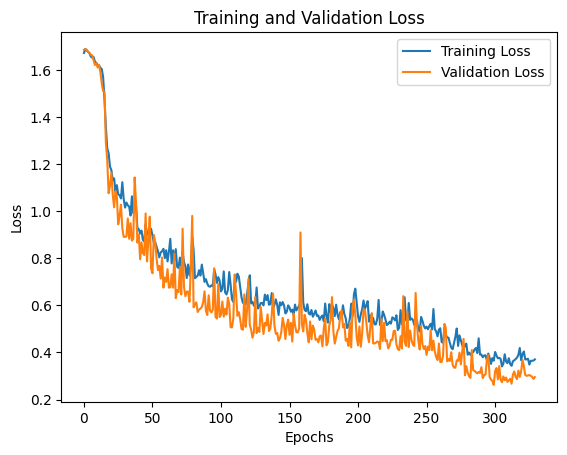

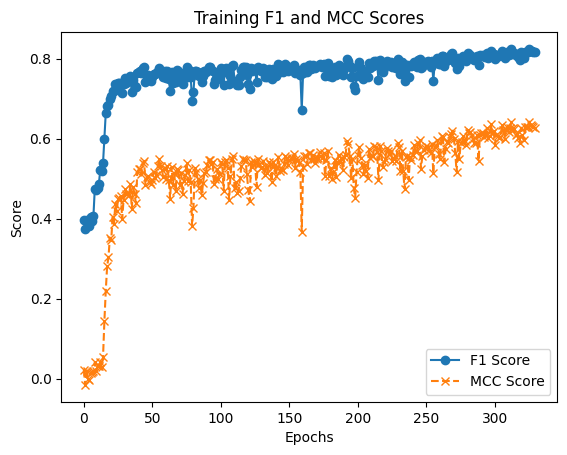

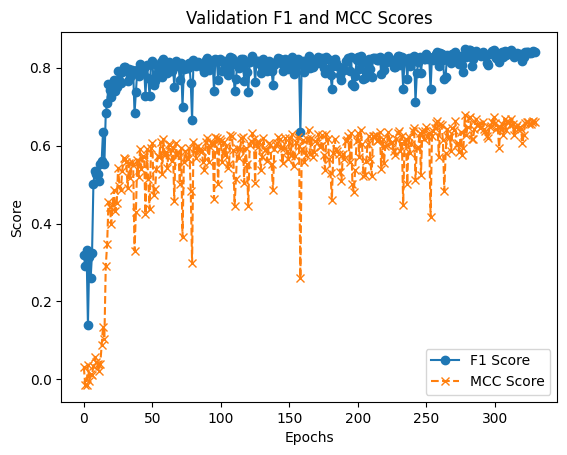

Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0   RNN  MorganFingerPrint           PCA    0.823357           0.778881  \

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.873221      0.74824  0.810731  0.810731  0.744014  0.626743

In [172]:
selection = SelectKBest(score_func=mutual_info_classif, k= best_k)
X_train_k = selection.fit_transform(X_train,y_train)
X_test_k = selection.transform(X_test)
print(np.array(X_train_k).shape,np.array(X_test_k).shape)



# 初始化 k 折交叉驗證
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

X = X_train_k
y = y_train

# 訓練和評估
result_f1 = []
result_mcc = []
total_y_true = []
total_y_pred = []

f1_four = []
mcc_four = []
total_y_true_four = []
total_y_pred_four = []
for fold, (val_indices, test_indices) in enumerate(kfold.split(X, y)):
    # 分割數據集
    X_train1, X_val = X[val_indices], X[test_indices]
    y_train1, y_val = y[val_indices], y[test_indices]
    
    # 將訓練集再分為訓練集和驗證集
    #X_train1, X_val, y_train1, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42, stratify=y_train1)
    X_train2 = csr_matrix(X_train1).toarray()


    
#     negative_indices = np.where(labels == 0)[0]
#     negative_samples = np.array(np.array(feature))[negative_indices]
#     negative_labels  = np.array(np.array(labels))[negative_indices]
#     print(pd.Series(negative_labels).value_counts())


    # 假设 X 是您的数据矩阵，形状为 (样本数, 特征数)，例如 (500, 2048)

    # 初始化 PCA，所有主成分
    pca = PCA()

    # PCA
    pca.fit(X_train2)

    # 計算PCA各個主成份的方差解釋率
    explained_variance_ratio = pca.explained_variance_ratio_

    # 累積方差解釋率
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # setting the threshold
    threshold = 0.95

    # 找到最小主成分数目
    n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

    print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")
    
    pca_reduced = PCA(n_components=n_components)
    # 進行 PCA 轉換
    X_train2 = pca_reduced.fit_transform(X_train2)
    X_val1 = pca_reduced.transform(X_val)
    X_test1 = pca_reduced.transform(X_test_k)
#     X_four = pca_reduced.transform(np.array(feature))

    # 轉換標籤為一維張量
    y_train1 = y_train1.flatten()
    y_val1 = y_val.flatten()
    y_test1 = y_test.flatten()
#     y_four = labels.flatten()

    # 創建數據加載器
    train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train2), torch.Tensor(y_train1))
    val_data = torch.utils.data.TensorDataset(torch.Tensor(X_val1), torch.Tensor(y_val1))
    test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test1), torch.Tensor(y_test1))
#     four_data = torch.utils.data.TensorDataset(torch.Tensor(X_four), torch.Tensor(y_four))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size =32, shuffle=True, drop_last=True)
#     four_loader = torch.utils.data.DataLoader(four_data, batch_size =32, shuffle=True, drop_last=True)

    # 實例化模型、損失函數和優化器

    input_size = 2048
    embedding_dim = n_components
    hidden_size = 128
    output_size = 1 #二元分類問題
    num_layers = 4
    model = RNNModel(input_size,embedding_dim, hidden_size, output_size, num_layers).to(dtype=torch.float)

    learning_rate = 0.0005

    l2_lambda = 0.00005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    patience = 30
    counter = 0
    best_val_loss = float('inf')


    n_epochs = 1000


    # Initialize lists to store training and validation loss and F1 score
    train_losses = []
    val_losses = []
    train_f1_scores = []
    train_mcc_scores = []
    val_f1_scores = []
    val_mcc_scores = []

    for epoch in range(n_epochs):
        train_loss,t_f1,t_mcc,tcombined_score,train_mtr =  train(model, optimizer, train_loader)
        val_loss, val_f1, val_mcc, combined_score,mtr = validate(model, val_loader, l2_lambda)
        scheduler.step(val_loss)
        # Append the results to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(t_f1)
        train_mcc_scores.append(t_mcc)
        val_f1_scores.append(val_f1)
        val_mcc_scores.append(val_mcc)   
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training F1 score: {:.4f}, Training MCC score: {:.4f}, Training Combine score: {:.4f}'.format(epoch+1, n_epochs, train_loss,t_f1,t_mcc,tcombined_score))
        print(train_mtr)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation F1 score: {:.4f}, Validation MCC score: {:.4f}, Validation Combine score: {:.4f}'.format(epoch+1, n_epochs,val_loss, val_f1, val_mcc, combined_score))
        print(mtr)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered at epoch {}.".format(epoch+1))
                break





    test_loss, f1,mcc,mtr,y_true,y_pred = test(model, test_loader)
    print('Test Loss: {:.4f}, F1 Score: {:.2f}, MCC: {:.2f}, Combine: {:.2f}'.format(test_loss, f1,mcc,(f1+mcc)/2))
    print(mtr)
    
    total_y_pred = total_y_pred + y_pred
    total_y_true = total_y_true + y_true
    
#     test_loss, f1,mcc,mtr,y_true,y_pred = test(model, four_loader)
#     print('Test Loss: {:.4f}, Accuracy Score: {:.2f}'.format(test_loss,accuracy_score(y_true, y_pred)))
#     print(mtr)

#     total_y_pred_four = total_y_pred_four + y_pred
#     total_y_true_four = total_y_true_four + y_true
    
    # Plotting the training and validation loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training F1 score
    plt.figure()
    plt.plot(train_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(train_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Training F1 and MCC Scores')
    plt.legend()
    plt.show()

    # Plotting the validation F1 score
    plt.figure()
    plt.plot(val_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(val_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation F1 and MCC Scores')
    plt.legend()
    plt.show()


model_name = "RNN"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true,total_y_pred)
# print("Testing for all negative : {}".format(accuracy_score(total_y_true_four, total_y_pred_four)))
per_index
# model_name = "RNN"
# dataset = "MorganFingerPrint (ALL data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true_four,total_y_pred_four)

In [173]:
per_index

Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0   RNN  MorganFingerPrint           PCA    0.823357           0.778881  \

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.873221      0.74824  0.810731  0.810731  0.744014  0.626743

In [235]:
per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
                                 "Specificity","BA","AUC-ROC","AUC-PR","MCC"])

per_index

Empty DataFrame
Columns: [Model, Dataset, Preprocessing, F1 (Toxic), Precision (Toxic), Sensitivity, Specificity, BA, AUC-ROC, AUC-PR, MCC]
Index: []

In [174]:
# X_train1, y_train1 = InstanceHardnessThreshold(estimator=GradientBoostingClassifier(),random_state=42).fit_resample(X_train, y_train)
# print(np.array(X_train1).shape,np.array(y_train1).shape)
# plt.figure( figsize=(10,5) )
# pd.Series(y_train1).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
# plt.title( 'y_train' )  # 圖標題
# plt.ylabel( '' )
# plt.show()
# # X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size=0.3, random_state=42, stratify=y_train)
# X_train1 = csr_matrix(X_train1).toarray()
# # print(X_train1)
# # print("\n")
# # print(X_test1)



# 初始化 PCA，所有主成分
pca = PCA()

# PCA
pca.fit(X_train_k)

# 計算PCA各個主成份的方差解釋率
explained_variance_ratio = pca.explained_variance_ratio_

# 累積方差解釋率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# setting the threshold
threshold = 0.95

# 找到最小主成分数目
n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
# 進行 PCA 轉換
X_train3 = pca_reduced.fit_transform(X_train_k)
# X_val1 = pca_reduced.transform(X_val)
X_test3 = pca_reduced.transform(X_test_k)
# X_four = pca_reduced.transform(np.array(feature))
# 轉換標籤為一維張量
y_train = y_train.ravel()
y_test = np.array(y_test).ravel()
# y_four = np.array(labels).ravel()
print("Size of training set : {}   {}".format(X_train3.shape,y_train.shape))



def mcc_score(y_true, y_pred):
    return (matthews_corrcoef(y_true, y_pred)+f1_score(y_true, y_pred))/2

# 将 MCC 转换为评估指标
scoring = make_scorer(mcc_score)

X_train_copy = X_train3
X_test_copy = X_test3


k_best_selector = SelectKBest(k=100)
percentile_selector = SelectPercentile(percentile=100)
pca_selector = PCA(n_components=100)
selector = VarianceThreshold(threshold=0)
svm = SVC(kernel='linear', C=1, random_state=42)
selector = SelectFromModel(svm, threshold=0.3)
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold= "mean")
n_iter_search = 20 



nb_classifier = GaussianNB()
params_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}
pipeline_nb = Pipeline([
    ('classifier', nb_classifier)
])
model_nb = RandomizedSearchCV(pipeline_nb, param_distributions=params_nb,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_nb.fit(X_train_copy, y_train)
nb = model_nb.best_estimator_
matrix = metrics.confusion_matrix(y_test,nb.predict(X_test_copy))
precision = precision_score(y_test,nb.predict(X_test_copy))
recall = recall_score(y_test,nb.predict(X_test_copy))
f1 = f1_score(y_test,nb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,nb.predict(X_test_copy))

model_name = "GaussianNB"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,nb.predict(X_test_copy))

print("########################NB########################")
print(" Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,nb.predict(X_four))
# precision = precision_score(y_four,nb.predict(X_four))
# recall = recall_score(y_four,nb.predict(X_four))
# f1 = f1_score(y_four,nb.predict(X_four))
# mcc = matthews_corrcoef(y_four,nb.predict(X_four))

# model_name = "GaussianNB"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,nb.predict(X_four))

# print("########################NB########################")
# print(" Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3

params_log = {'classifier__penalty':['l2','l1'],"classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver":["liblinear"],"classifier__max_iter":[50,100,200,500,700,1000]}
log_classifier = LogisticRegression()
pipeline_log = Pipeline([
    ('classifier', log_classifier)
])
model_log = RandomizedSearchCV(pipeline_log,
                               param_distributions=params_log,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_log.fit(X_train_copy,y_train)
logg = model_log.best_estimator_
matrix = metrics.confusion_matrix(y_test,logg.predict(X_test_copy))
precision = precision_score(y_test,logg.predict(X_test_copy))
recall = recall_score(y_test,logg.predict(X_test_copy))
f1 = f1_score(y_test,logg.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,logg.predict(X_test_copy))

model_name = "LogisticRegression"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,logg.predict(X_test_copy))

print("########################LogisticRegression########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,logg.predict(X_four))
# precision = precision_score(y_four,logg.predict(X_four))
# recall = recall_score(y_four,logg.predict(X_four))
# f1 = f1_score(y_four,logg.predict(X_four))
# mcc = matthews_corrcoef(y_four,logg.predict(X_four))

# model_name = "LogisticRegression"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,logg.predict(X_four))

# print("########################LogisticRegression########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_svm = {'classifier__kernel':['linear', 'poly', 'rbf','sigmoid'],
              "classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
            "classifier__gamma" : ['scale','auto']}
svm_classifier = SVC()
pipeline_svm = Pipeline([
    ('classifier', svm_classifier)
])
model_svm = RandomizedSearchCV(pipeline_svm,
                               param_distributions=params_svm,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_svm.fit(X_train_copy,y_train)
svm = model_svm.best_estimator_
matrix = metrics.confusion_matrix(y_test,svm.predict(X_test_copy))
precision = precision_score(y_test,svm.predict(X_test_copy))
recall = recall_score(y_test,svm.predict(X_test_copy))
f1 = f1_score(y_test,svm.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,svm.predict(X_test_copy))

model_name = "SVM"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,svm.predict(X_test_copy))

print("########################SVM########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,svm.predict(X_four))
# precision = precision_score(y_four,svm.predict(X_four))
# recall = recall_score(y_four,svm.predict(X_four))
# f1 = f1_score(y_four,svm.predict(X_four))
# mcc = matthews_corrcoef(y_four,svm.predict(X_four))

# model_name = "SVM"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,svm.predict(X_four))

# print("########################SVM########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)

X_train_copy = X_train3
X_test_copy = X_test3


params_xgb = {'classifier__learning_rate':[0.01,0.001,0.0001],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(1,201,50),
              "classifier__gamma" :range(1,10,3)
             }
xgb_classifier = XGBClassifier()
pipeline_xgb = Pipeline([
    ('classifier', xgb_classifier)
])
model_xgb = RandomizedSearchCV(pipeline_xgb,
                               param_distributions=params_xgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_xgb.fit(X_train_copy,y_train)
xgb = model_xgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,xgb.predict(X_test_copy))
precision = precision_score(y_test,xgb.predict(X_test_copy),zero_division=0)
recall = recall_score(y_test,xgb.predict(X_test_copy))
f1 = f1_score(y_test,xgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,xgb.predict(X_test_copy))

model_name = "XGBClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,xgb.predict(X_test_copy))


print("########################XGBClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,xgb.predict(X_four))
# precision = precision_score(y_four,xgb.predict(X_four),zero_division=0)
# recall = recall_score(y_four,xgb.predict(X_four))
# f1 = f1_score(y_four,xgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,xgb.predict(X_four))

# model_name = "XGBClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,xgb.predict(X_four))


# print("########################XGBClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_rf = {'classifier__max_features':['sqrt','log2'],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(100,1000,100),
   "classifier__criterion" : ['gini','entropy'],
             "classifier__oob_score" : [True]
             
             }
rf_classifier = RandomForestClassifier()
pipeline_rf = Pipeline([
    ('classifier', rf_classifier)
])
model_rf = RandomizedSearchCV(pipeline_rf,
                              param_distributions=params_rf,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_rf.fit(X_train_copy,y_train)
rf = model_rf.best_estimator_
matrix = metrics.confusion_matrix(y_test,rf.predict(X_test_copy))
precision = precision_score(y_test,rf.predict(X_test_copy),zero_division=1)
recall = recall_score(y_test,rf.predict(X_test_copy))
f1 = f1_score(y_test,rf.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,rf.predict(X_test_copy))

model_name = "RandomForestClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,rf.predict(X_test_copy))

print("########################RandomForest########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,rf.predict(X_four))
# precision = precision_score(y_four,rf.predict(X_four),zero_division=1)
# recall = recall_score(y_four,rf.predict(X_four))
# f1 = f1_score(y_four,rf.predict(X_four))
# mcc = matthews_corrcoef(y_four,rf.predict(X_four))

# model_name = "RandomForestClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,rf.predict(X_four))

# print("########################RandomForest########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3



params_lgb = {'classifier__objective': ["binary"],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__max_depth" : [3, 5, 6, 7, 9, 12, 15, 17, 25],
             "classifier__subsample" : [0.6, 0.7, 0.8, 0.9, 1]
              
             }
lgb_classifier = lgb.LGBMClassifier()
pipeline_lgb = Pipeline([
    ('classifier', lgb_classifier)
])
model_lgb = RandomizedSearchCV(pipeline_lgb,
                               param_distributions=params_lgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)

model_lgb.fit(X_train_copy,y_train)
lgb = model_lgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,lgb.predict(X_test_copy))
precision = precision_score(y_test,lgb.predict(X_test_copy))
recall = recall_score(y_test,lgb.predict(X_test_copy))
f1 = f1_score(y_test,lgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,lgb.predict(X_test_copy))

model_name = "LGBMClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,lgb.predict(X_test_copy))

print("########################LGBMClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,lgb.predict(X_four))
# precision = precision_score(y_four,lgb.predict(X_four))
# recall = recall_score(y_four,lgb.predict(X_four))
# f1 = f1_score(y_four,lgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,lgb.predict(X_four))

# model_name = "LGBMClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,lgb.predict(X_four))

# print("########################LGBMClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_mlp = {'classifier__hidden_layer_sizes':[50,100,150,200],
              'classifier__solver': ["sgd","adam"],
              "classifier__learning_rate_init" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__early_stopping" : [True],
             "classifier__shuffle" : [True]
             }

mlp_classifier= MLPClassifier()
pipeline_mlp = Pipeline([
    ('classifier', mlp_classifier)
])
model_mlp = RandomizedSearchCV(pipeline_mlp,
                               param_distributions=params_mlp,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_mlp.fit(X_train_copy,y_train)
mlp = model_mlp.best_estimator_
matrix = metrics.confusion_matrix(y_test,mlp.predict(X_test_copy))
precision = precision_score(y_test,mlp.predict(X_test_copy),zero_division = 1)
recall = recall_score(y_test,mlp.predict(X_test_copy))
f1 = f1_score(y_test,mlp.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,mlp.predict(X_test_copy))

model_name = "MLPClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,mlp.predict(X_test_copy))

print("########################MLPClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,mlp.predict(X_four))
# precision = precision_score(y_four,mlp.predict(X_four),zero_division = 1)
# recall = recall_score(y_four,mlp.predict(X_four))
# f1 = f1_score(y_four,mlp.predict(X_four))
# mcc = matthews_corrcoef(y_four,mlp.predict(X_four))

# model_name = "MLPClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,mlp.predict(X_four))

# print("########################MLPClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_cat = {'classifier__loss_function':["RMSE","Logloss","CrossEntropy","MAE"],
              'classifier__iterations': [1000],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
             "classifier__sampling_frequency" : ["PerTree","PerTreeLevel"]
             }
cat_classifier = CatBoostClassifier()
pipeline_cat = Pipeline([
    ('classifier', cat_classifier)
])
model_cat = RandomizedSearchCV(pipeline_cat,
                               param_distributions=params_cat,
                               n_iter=n_iter_search, verbose=0,
                               scoring=scoring, cv=5)
model_cat.fit(X_train_copy,y_train)
cat = model_cat.best_estimator_
matrix = metrics.confusion_matrix(y_test,cat.predict(X_test_copy))
precision = precision_score(y_test,cat.predict(X_test_copy))
recall = recall_score(y_test,cat.predict(X_test_copy))
f1 = f1_score(y_test,cat.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,cat.predict(X_test_copy))

model_name = "CatBoostClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,cat.predict(X_test_copy))

print("########################CatBoostClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,cat.predict(X_four))
# precision = precision_score(y_four,cat.predict(X_four))
# recall = recall_score(y_four,cat.predict(X_four))
# f1 = f1_score(y_four,cat.predict(X_four))
# mcc = matthews_corrcoef(y_four,cat.predict(X_four))

# model_name = "CatBoostClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,cat.predict(X_four))

# print("########################CatBoostClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)
per_index



Number of components to preserve 95.0% variance: 387
Size of training set : (8753, 387)   (8753,)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
########################NB########################
 Best F1 score 0.7017892644135189 , MCC : 0.4600282839670839
Precision : 0.7775330396475771,  Recall : 0.6394927536231884
[[883 202]
 [398 706]]



        Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0         RNN  MorganFingerPrint           PCA    0.823357           0.778881  \
1  GaussianNB  MorganFingerPrint           PCA    0.701789           0.777533   

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.873221     0.748240  0.810731  0.810731  0.744014  0.626743  
1     0.639493     0.813825  0.726659  0.726659  0.679045  0.460028  
Fitting 5 folds for each of 20 candidates, totalling 100 fits
########################LogisticRegression########################
Best F1 score 0.8140882746321889 , MCC : 0.619186504240688

0:	learn: 0.6862492	total: 53.5ms	remaining: 53.4s
1:	learn: 0.6806218	total: 73.8ms	remaining: 36.8s
2:	learn: 0.6746140	total: 94.3ms	remaining: 31.3s
3:	learn: 0.6685051	total: 114ms	remaining: 28.5s
4:	learn: 0.6629688	total: 134ms	remaining: 26.7s
5:	learn: 0.6571460	total: 154ms	remaining: 25.4s
6:	learn: 0.6511400	total: 174ms	remaining: 24.7s
7:	learn: 0.6457968	total: 194ms	remaining: 24.1s
8:	learn: 0.6412973	total: 214ms	remaining: 23.6s
9:	learn: 0.6369216	total: 234ms	remaining: 23.2s
10:	learn: 0.6316146	total: 254ms	remaining: 22.8s
11:	learn: 0.6271073	total: 275ms	remaining: 22.7s
12:	learn: 0.6232671	total: 301ms	remaining: 22.8s
13:	learn: 0.6197540	total: 323ms	remaining: 22.8s
14:	learn: 0.6153752	total: 344ms	remaining: 22.6s
15:	learn: 0.6108833	total: 365ms	remaining: 22.5s
16:	learn: 0.6078474	total: 387ms	remaining: 22.4s
17:	learn: 0.6041892	total: 408ms	remaining: 22.2s
18:	learn: 0.6010065	total: 429ms	remaining: 22.1s
19:	learn: 0.5983022	total: 452ms	rema

162:	learn: 0.3977086	total: 6.45s	remaining: 33.1s
163:	learn: 0.3971062	total: 6.48s	remaining: 33.1s
164:	learn: 0.3964276	total: 6.53s	remaining: 33s
165:	learn: 0.3957203	total: 6.56s	remaining: 32.9s
166:	learn: 0.3948843	total: 6.59s	remaining: 32.9s
167:	learn: 0.3940678	total: 6.62s	remaining: 32.8s
168:	learn: 0.3930623	total: 6.66s	remaining: 32.7s
169:	learn: 0.3924262	total: 6.7s	remaining: 32.7s
170:	learn: 0.3916730	total: 6.73s	remaining: 32.6s
171:	learn: 0.3908514	total: 6.76s	remaining: 32.6s
172:	learn: 0.3898480	total: 6.8s	remaining: 32.5s
173:	learn: 0.3890055	total: 6.83s	remaining: 32.4s
174:	learn: 0.3882075	total: 6.87s	remaining: 32.4s
175:	learn: 0.3874396	total: 6.9s	remaining: 32.3s
176:	learn: 0.3866791	total: 6.94s	remaining: 32.3s
177:	learn: 0.3859628	total: 6.97s	remaining: 32.2s
178:	learn: 0.3851164	total: 7.01s	remaining: 32.1s
179:	learn: 0.3840716	total: 7.04s	remaining: 32.1s
180:	learn: 0.3833354	total: 7.07s	remaining: 32s
181:	learn: 0.38260

323:	learn: 0.2921434	total: 12.8s	remaining: 26.6s
324:	learn: 0.2916106	total: 12.8s	remaining: 26.6s
325:	learn: 0.2910305	total: 12.9s	remaining: 26.6s
326:	learn: 0.2904680	total: 12.9s	remaining: 26.5s
327:	learn: 0.2899621	total: 12.9s	remaining: 26.5s
328:	learn: 0.2894150	total: 13s	remaining: 26.4s
329:	learn: 0.2889754	total: 13s	remaining: 26.4s
330:	learn: 0.2884724	total: 13s	remaining: 26.4s
331:	learn: 0.2879629	total: 13.1s	remaining: 26.3s
332:	learn: 0.2872804	total: 13.1s	remaining: 26.3s
333:	learn: 0.2867140	total: 13.2s	remaining: 26.2s
334:	learn: 0.2859715	total: 13.2s	remaining: 26.2s
335:	learn: 0.2852789	total: 13.2s	remaining: 26.2s
336:	learn: 0.2846978	total: 13.3s	remaining: 26.1s
337:	learn: 0.2839971	total: 13.3s	remaining: 26.1s
338:	learn: 0.2835066	total: 13.4s	remaining: 26s
339:	learn: 0.2826734	total: 13.4s	remaining: 26s
340:	learn: 0.2821557	total: 13.4s	remaining: 26s
341:	learn: 0.2816198	total: 13.5s	remaining: 25.9s
342:	learn: 0.2810509	to

486:	learn: 0.2002528	total: 18.6s	remaining: 19.6s
487:	learn: 0.1999686	total: 18.7s	remaining: 19.6s
488:	learn: 0.1994267	total: 18.7s	remaining: 19.5s
489:	learn: 0.1988496	total: 18.7s	remaining: 19.5s
490:	learn: 0.1983584	total: 18.8s	remaining: 19.5s
491:	learn: 0.1978699	total: 18.8s	remaining: 19.4s
492:	learn: 0.1974881	total: 18.8s	remaining: 19.4s
493:	learn: 0.1970829	total: 18.9s	remaining: 19.3s
494:	learn: 0.1966352	total: 18.9s	remaining: 19.3s
495:	learn: 0.1961402	total: 18.9s	remaining: 19.2s
496:	learn: 0.1958285	total: 19s	remaining: 19.2s
497:	learn: 0.1954450	total: 19s	remaining: 19.1s
498:	learn: 0.1950237	total: 19s	remaining: 19.1s
499:	learn: 0.1944568	total: 19.1s	remaining: 19.1s
500:	learn: 0.1938954	total: 19.1s	remaining: 19s
501:	learn: 0.1934079	total: 19.1s	remaining: 19s
502:	learn: 0.1929987	total: 19.2s	remaining: 18.9s
503:	learn: 0.1925039	total: 19.2s	remaining: 18.9s
504:	learn: 0.1920691	total: 19.2s	remaining: 18.8s
505:	learn: 0.1918212	

647:	learn: 0.1389086	total: 24.6s	remaining: 13.4s
648:	learn: 0.1386015	total: 24.7s	remaining: 13.3s
649:	learn: 0.1382765	total: 24.7s	remaining: 13.3s
650:	learn: 0.1379929	total: 24.7s	remaining: 13.3s
651:	learn: 0.1376183	total: 24.8s	remaining: 13.2s
652:	learn: 0.1373350	total: 24.8s	remaining: 13.2s
653:	learn: 0.1370482	total: 24.8s	remaining: 13.1s
654:	learn: 0.1367471	total: 24.9s	remaining: 13.1s
655:	learn: 0.1365191	total: 24.9s	remaining: 13.1s
656:	learn: 0.1361660	total: 24.9s	remaining: 13s
657:	learn: 0.1358972	total: 25s	remaining: 13s
658:	learn: 0.1355398	total: 25s	remaining: 12.9s
659:	learn: 0.1352525	total: 25s	remaining: 12.9s
660:	learn: 0.1349651	total: 25.1s	remaining: 12.9s
661:	learn: 0.1346706	total: 25.1s	remaining: 12.8s
662:	learn: 0.1343512	total: 25.1s	remaining: 12.8s
663:	learn: 0.1340854	total: 25.2s	remaining: 12.7s
664:	learn: 0.1338269	total: 25.2s	remaining: 12.7s
665:	learn: 0.1335277	total: 25.2s	remaining: 12.7s
666:	learn: 0.1332633	

811:	learn: 0.0984508	total: 30.3s	remaining: 7.01s
812:	learn: 0.0982928	total: 30.3s	remaining: 6.97s
813:	learn: 0.0980837	total: 30.4s	remaining: 6.93s
814:	learn: 0.0978799	total: 30.4s	remaining: 6.9s
815:	learn: 0.0976424	total: 30.4s	remaining: 6.86s
816:	learn: 0.0974062	total: 30.5s	remaining: 6.82s
817:	learn: 0.0972433	total: 30.5s	remaining: 6.78s
818:	learn: 0.0970895	total: 30.5s	remaining: 6.75s
819:	learn: 0.0969118	total: 30.6s	remaining: 6.71s
820:	learn: 0.0966927	total: 30.6s	remaining: 6.67s
821:	learn: 0.0965529	total: 30.6s	remaining: 6.63s
822:	learn: 0.0963772	total: 30.6s	remaining: 6.59s
823:	learn: 0.0962207	total: 30.7s	remaining: 6.55s
824:	learn: 0.0961016	total: 30.7s	remaining: 6.51s
825:	learn: 0.0958597	total: 30.8s	remaining: 6.48s
826:	learn: 0.0956370	total: 30.8s	remaining: 6.44s
827:	learn: 0.0954537	total: 30.8s	remaining: 6.4s
828:	learn: 0.0952643	total: 30.8s	remaining: 6.36s
829:	learn: 0.0950146	total: 30.9s	remaining: 6.33s
830:	learn: 0.

972:	learn: 0.0722227	total: 36.1s	remaining: 1s
973:	learn: 0.0720525	total: 36.1s	remaining: 965ms
974:	learn: 0.0719276	total: 36.2s	remaining: 928ms
975:	learn: 0.0717950	total: 36.2s	remaining: 891ms
976:	learn: 0.0716264	total: 36.3s	remaining: 854ms
977:	learn: 0.0714518	total: 36.3s	remaining: 818ms
978:	learn: 0.0713129	total: 36.4s	remaining: 781ms
979:	learn: 0.0711745	total: 36.4s	remaining: 744ms
980:	learn: 0.0710094	total: 36.5s	remaining: 707ms
981:	learn: 0.0709033	total: 36.5s	remaining: 669ms
982:	learn: 0.0707190	total: 36.6s	remaining: 632ms
983:	learn: 0.0705962	total: 36.6s	remaining: 595ms
984:	learn: 0.0704521	total: 36.6s	remaining: 558ms
985:	learn: 0.0703393	total: 36.7s	remaining: 520ms
986:	learn: 0.0702070	total: 36.7s	remaining: 483ms
987:	learn: 0.0700668	total: 36.7s	remaining: 446ms
988:	learn: 0.0699592	total: 36.8s	remaining: 409ms
989:	learn: 0.0698678	total: 36.8s	remaining: 372ms
990:	learn: 0.0697329	total: 36.8s	remaining: 334ms
991:	learn: 0.0

133:	learn: 0.4189261	total: 4.3s	remaining: 27.8s
134:	learn: 0.4179960	total: 4.34s	remaining: 27.8s
135:	learn: 0.4168944	total: 4.38s	remaining: 27.8s
136:	learn: 0.4160969	total: 4.41s	remaining: 27.8s
137:	learn: 0.4150993	total: 4.44s	remaining: 27.7s
138:	learn: 0.4143767	total: 4.47s	remaining: 27.7s
139:	learn: 0.4135166	total: 4.5s	remaining: 27.6s
140:	learn: 0.4125585	total: 4.53s	remaining: 27.6s
141:	learn: 0.4117686	total: 4.57s	remaining: 27.6s
142:	learn: 0.4107019	total: 4.6s	remaining: 27.6s
143:	learn: 0.4097434	total: 4.64s	remaining: 27.6s
144:	learn: 0.4088979	total: 4.67s	remaining: 27.5s
145:	learn: 0.4080997	total: 4.7s	remaining: 27.5s
146:	learn: 0.4070843	total: 4.73s	remaining: 27.5s
147:	learn: 0.4062931	total: 4.77s	remaining: 27.4s
148:	learn: 0.4056613	total: 4.8s	remaining: 27.4s
149:	learn: 0.4048875	total: 4.83s	remaining: 27.4s
150:	learn: 0.4041479	total: 4.86s	remaining: 27.4s
151:	learn: 0.4033452	total: 4.89s	remaining: 27.3s
152:	learn: 0.402

295:	learn: 0.3058364	total: 9.74s	remaining: 23.2s
296:	learn: 0.3053080	total: 9.78s	remaining: 23.1s
297:	learn: 0.3046285	total: 9.81s	remaining: 23.1s
298:	learn: 0.3040652	total: 9.85s	remaining: 23.1s
299:	learn: 0.3034382	total: 9.88s	remaining: 23.1s
300:	learn: 0.3028605	total: 9.91s	remaining: 23s
301:	learn: 0.3021297	total: 9.95s	remaining: 23s
302:	learn: 0.3017583	total: 9.99s	remaining: 23s
303:	learn: 0.3011811	total: 10s	remaining: 23s
304:	learn: 0.3007188	total: 10.1s	remaining: 22.9s
305:	learn: 0.3001841	total: 10.1s	remaining: 22.9s
306:	learn: 0.2997153	total: 10.1s	remaining: 22.9s
307:	learn: 0.2990707	total: 10.2s	remaining: 22.8s
308:	learn: 0.2985658	total: 10.2s	remaining: 22.8s
309:	learn: 0.2980019	total: 10.2s	remaining: 22.8s
310:	learn: 0.2974720	total: 10.3s	remaining: 22.7s
311:	learn: 0.2969035	total: 10.3s	remaining: 22.7s
312:	learn: 0.2964307	total: 10.3s	remaining: 22.7s
313:	learn: 0.2959147	total: 10.4s	remaining: 22.6s
314:	learn: 0.2953424	

454:	learn: 0.2164760	total: 15.1s	remaining: 18s
455:	learn: 0.2158114	total: 15.1s	remaining: 18s
456:	learn: 0.2151594	total: 15.1s	remaining: 18s
457:	learn: 0.2145039	total: 15.2s	remaining: 17.9s
458:	learn: 0.2139590	total: 15.2s	remaining: 17.9s
459:	learn: 0.2133942	total: 15.2s	remaining: 17.9s
460:	learn: 0.2129954	total: 15.2s	remaining: 17.8s
461:	learn: 0.2126004	total: 15.3s	remaining: 17.8s
462:	learn: 0.2122088	total: 15.3s	remaining: 17.8s
463:	learn: 0.2116278	total: 15.3s	remaining: 17.7s
464:	learn: 0.2112365	total: 15.4s	remaining: 17.7s
465:	learn: 0.2106415	total: 15.4s	remaining: 17.7s
466:	learn: 0.2101739	total: 15.4s	remaining: 17.6s
467:	learn: 0.2096792	total: 15.5s	remaining: 17.6s
468:	learn: 0.2092465	total: 15.5s	remaining: 17.6s
469:	learn: 0.2087701	total: 15.5s	remaining: 17.5s
470:	learn: 0.2082402	total: 15.6s	remaining: 17.5s
471:	learn: 0.2077759	total: 15.6s	remaining: 17.5s
472:	learn: 0.2071899	total: 15.6s	remaining: 17.4s
473:	learn: 0.2067

614:	learn: 0.1489136	total: 20.4s	remaining: 12.8s
615:	learn: 0.1486061	total: 20.4s	remaining: 12.7s
616:	learn: 0.1482765	total: 20.5s	remaining: 12.7s
617:	learn: 0.1479091	total: 20.5s	remaining: 12.7s
618:	learn: 0.1476406	total: 20.6s	remaining: 12.7s
619:	learn: 0.1473603	total: 20.6s	remaining: 12.6s
620:	learn: 0.1470932	total: 20.6s	remaining: 12.6s
621:	learn: 0.1468599	total: 20.7s	remaining: 12.6s
622:	learn: 0.1466176	total: 20.7s	remaining: 12.5s
623:	learn: 0.1462830	total: 20.8s	remaining: 12.5s
624:	learn: 0.1458949	total: 20.8s	remaining: 12.5s
625:	learn: 0.1455618	total: 20.8s	remaining: 12.4s
626:	learn: 0.1452213	total: 20.9s	remaining: 12.4s
627:	learn: 0.1448965	total: 20.9s	remaining: 12.4s
628:	learn: 0.1445480	total: 21s	remaining: 12.4s
629:	learn: 0.1442848	total: 21s	remaining: 12.3s
630:	learn: 0.1440224	total: 21s	remaining: 12.3s
631:	learn: 0.1437117	total: 21.1s	remaining: 12.3s
632:	learn: 0.1434717	total: 21.1s	remaining: 12.2s
633:	learn: 0.1431

776:	learn: 0.1060679	total: 26.1s	remaining: 7.49s
777:	learn: 0.1058646	total: 26.1s	remaining: 7.46s
778:	learn: 0.1056425	total: 26.2s	remaining: 7.43s
779:	learn: 0.1053547	total: 26.2s	remaining: 7.39s
780:	learn: 0.1051611	total: 26.3s	remaining: 7.36s
781:	learn: 0.1049561	total: 26.3s	remaining: 7.33s
782:	learn: 0.1046597	total: 26.3s	remaining: 7.29s
783:	learn: 0.1043916	total: 26.4s	remaining: 7.26s
784:	learn: 0.1041679	total: 26.4s	remaining: 7.23s
785:	learn: 0.1039632	total: 26.4s	remaining: 7.19s
786:	learn: 0.1037677	total: 26.5s	remaining: 7.16s
787:	learn: 0.1036326	total: 26.5s	remaining: 7.13s
788:	learn: 0.1033989	total: 26.5s	remaining: 7.09s
789:	learn: 0.1032111	total: 26.6s	remaining: 7.06s
790:	learn: 0.1030350	total: 26.6s	remaining: 7.03s
791:	learn: 0.1028139	total: 26.6s	remaining: 7s
792:	learn: 0.1025980	total: 26.7s	remaining: 6.96s
793:	learn: 0.1023787	total: 26.7s	remaining: 6.93s
794:	learn: 0.1021486	total: 26.7s	remaining: 6.89s
795:	learn: 0.1

938:	learn: 0.0769769	total: 31.8s	remaining: 2.06s
939:	learn: 0.0768268	total: 31.8s	remaining: 2.03s
940:	learn: 0.0766246	total: 31.9s	remaining: 2s
941:	learn: 0.0765270	total: 31.9s	remaining: 1.96s
942:	learn: 0.0763345	total: 31.9s	remaining: 1.93s
943:	learn: 0.0761851	total: 31.9s	remaining: 1.9s
944:	learn: 0.0760298	total: 32s	remaining: 1.86s
945:	learn: 0.0758748	total: 32s	remaining: 1.83s
946:	learn: 0.0757240	total: 32.1s	remaining: 1.79s
947:	learn: 0.0755516	total: 32.1s	remaining: 1.76s
948:	learn: 0.0754082	total: 32.1s	remaining: 1.73s
949:	learn: 0.0752801	total: 32.2s	remaining: 1.69s
950:	learn: 0.0751087	total: 32.2s	remaining: 1.66s
951:	learn: 0.0749714	total: 32.2s	remaining: 1.62s
952:	learn: 0.0748239	total: 32.3s	remaining: 1.59s
953:	learn: 0.0746715	total: 32.3s	remaining: 1.56s
954:	learn: 0.0745462	total: 32.3s	remaining: 1.52s
955:	learn: 0.0744338	total: 32.4s	remaining: 1.49s
956:	learn: 0.0743115	total: 32.4s	remaining: 1.46s
957:	learn: 0.074152

102:	learn: 0.4481271	total: 3.39s	remaining: 29.5s
103:	learn: 0.4471591	total: 3.43s	remaining: 29.5s
104:	learn: 0.4462697	total: 3.46s	remaining: 29.5s
105:	learn: 0.4452671	total: 3.5s	remaining: 29.5s
106:	learn: 0.4442654	total: 3.53s	remaining: 29.4s
107:	learn: 0.4430547	total: 3.56s	remaining: 29.4s
108:	learn: 0.4419822	total: 3.59s	remaining: 29.3s
109:	learn: 0.4408967	total: 3.62s	remaining: 29.3s
110:	learn: 0.4399493	total: 3.66s	remaining: 29.3s
111:	learn: 0.4389305	total: 3.69s	remaining: 29.3s
112:	learn: 0.4380197	total: 3.73s	remaining: 29.2s
113:	learn: 0.4371653	total: 3.75s	remaining: 29.2s
114:	learn: 0.4357715	total: 3.79s	remaining: 29.1s
115:	learn: 0.4347777	total: 3.82s	remaining: 29.1s
116:	learn: 0.4340773	total: 3.85s	remaining: 29.1s
117:	learn: 0.4330836	total: 3.89s	remaining: 29.1s
118:	learn: 0.4321943	total: 3.92s	remaining: 29s
119:	learn: 0.4312535	total: 3.95s	remaining: 29s
120:	learn: 0.4303439	total: 3.98s	remaining: 28.9s
121:	learn: 0.429

264:	learn: 0.3239469	total: 8.79s	remaining: 24.4s
265:	learn: 0.3232720	total: 8.83s	remaining: 24.4s
266:	learn: 0.3225984	total: 8.87s	remaining: 24.3s
267:	learn: 0.3221862	total: 8.91s	remaining: 24.3s
268:	learn: 0.3216439	total: 8.95s	remaining: 24.3s
269:	learn: 0.3210517	total: 8.98s	remaining: 24.3s
270:	learn: 0.3205978	total: 9.03s	remaining: 24.3s
271:	learn: 0.3200997	total: 9.07s	remaining: 24.3s
272:	learn: 0.3194568	total: 9.11s	remaining: 24.3s
273:	learn: 0.3190431	total: 9.14s	remaining: 24.2s
274:	learn: 0.3184243	total: 9.18s	remaining: 24.2s
275:	learn: 0.3179118	total: 9.22s	remaining: 24.2s
276:	learn: 0.3173348	total: 9.26s	remaining: 24.2s
277:	learn: 0.3168057	total: 9.3s	remaining: 24.2s
278:	learn: 0.3163369	total: 9.33s	remaining: 24.1s
279:	learn: 0.3156526	total: 9.38s	remaining: 24.1s
280:	learn: 0.3151129	total: 9.41s	remaining: 24.1s
281:	learn: 0.3144620	total: 9.44s	remaining: 24s
282:	learn: 0.3140681	total: 9.48s	remaining: 24s
283:	learn: 0.313

427:	learn: 0.2308298	total: 14.5s	remaining: 19.4s
428:	learn: 0.2303569	total: 14.5s	remaining: 19.3s
429:	learn: 0.2297043	total: 14.6s	remaining: 19.3s
430:	learn: 0.2291826	total: 14.6s	remaining: 19.3s
431:	learn: 0.2286008	total: 14.6s	remaining: 19.2s
432:	learn: 0.2280623	total: 14.7s	remaining: 19.2s
433:	learn: 0.2275556	total: 14.7s	remaining: 19.2s
434:	learn: 0.2270191	total: 14.7s	remaining: 19.2s
435:	learn: 0.2264521	total: 14.8s	remaining: 19.1s
436:	learn: 0.2258925	total: 14.8s	remaining: 19.1s
437:	learn: 0.2254220	total: 14.8s	remaining: 19.1s
438:	learn: 0.2248659	total: 14.9s	remaining: 19s
439:	learn: 0.2243666	total: 14.9s	remaining: 19s
440:	learn: 0.2238329	total: 15s	remaining: 19s
441:	learn: 0.2233468	total: 15s	remaining: 18.9s
442:	learn: 0.2229955	total: 15s	remaining: 18.9s
443:	learn: 0.2225364	total: 15s	remaining: 18.8s
444:	learn: 0.2219695	total: 15.1s	remaining: 18.8s
445:	learn: 0.2214753	total: 15.1s	remaining: 18.8s
446:	learn: 0.2208768	tota

591:	learn: 0.1584348	total: 21.8s	remaining: 15s
592:	learn: 0.1581057	total: 21.8s	remaining: 15s
593:	learn: 0.1577519	total: 21.9s	remaining: 14.9s
594:	learn: 0.1574964	total: 21.9s	remaining: 14.9s
595:	learn: 0.1571344	total: 21.9s	remaining: 14.9s
596:	learn: 0.1567294	total: 22s	remaining: 14.8s
597:	learn: 0.1564010	total: 22s	remaining: 14.8s
598:	learn: 0.1561460	total: 22s	remaining: 14.8s
599:	learn: 0.1558154	total: 22.1s	remaining: 14.7s
600:	learn: 0.1553692	total: 22.1s	remaining: 14.7s
601:	learn: 0.1550210	total: 22.2s	remaining: 14.7s
602:	learn: 0.1547186	total: 22.2s	remaining: 14.6s
603:	learn: 0.1543991	total: 22.2s	remaining: 14.6s
604:	learn: 0.1541300	total: 22.3s	remaining: 14.5s
605:	learn: 0.1537999	total: 22.3s	remaining: 14.5s
606:	learn: 0.1533557	total: 22.3s	remaining: 14.5s
607:	learn: 0.1529656	total: 22.4s	remaining: 14.4s
608:	learn: 0.1526363	total: 22.4s	remaining: 14.4s
609:	learn: 0.1523506	total: 22.4s	remaining: 14.3s
610:	learn: 0.1520563	

755:	learn: 0.1119613	total: 27.4s	remaining: 8.84s
756:	learn: 0.1117531	total: 27.4s	remaining: 8.8s
757:	learn: 0.1115184	total: 27.5s	remaining: 8.77s
758:	learn: 0.1112023	total: 27.5s	remaining: 8.73s
759:	learn: 0.1109925	total: 27.5s	remaining: 8.69s
760:	learn: 0.1107848	total: 27.6s	remaining: 8.66s
761:	learn: 0.1105852	total: 27.6s	remaining: 8.62s
762:	learn: 0.1103553	total: 27.6s	remaining: 8.58s
763:	learn: 0.1100759	total: 27.7s	remaining: 8.55s
764:	learn: 0.1098218	total: 27.7s	remaining: 8.51s
765:	learn: 0.1095803	total: 27.7s	remaining: 8.47s
766:	learn: 0.1093394	total: 27.8s	remaining: 8.44s
767:	learn: 0.1090853	total: 27.8s	remaining: 8.4s
768:	learn: 0.1088989	total: 27.8s	remaining: 8.36s
769:	learn: 0.1087261	total: 27.9s	remaining: 8.33s
770:	learn: 0.1085177	total: 27.9s	remaining: 8.29s
771:	learn: 0.1083036	total: 27.9s	remaining: 8.25s
772:	learn: 0.1080228	total: 28s	remaining: 8.22s
773:	learn: 0.1078365	total: 28s	remaining: 8.18s
774:	learn: 0.1076

917:	learn: 0.0814765	total: 33s	remaining: 2.95s
918:	learn: 0.0813205	total: 33s	remaining: 2.91s
919:	learn: 0.0811659	total: 33.1s	remaining: 2.87s
920:	learn: 0.0810496	total: 33.1s	remaining: 2.84s
921:	learn: 0.0808895	total: 33.1s	remaining: 2.8s
922:	learn: 0.0807140	total: 33.2s	remaining: 2.77s
923:	learn: 0.0805684	total: 33.2s	remaining: 2.73s
924:	learn: 0.0804223	total: 33.2s	remaining: 2.69s
925:	learn: 0.0803045	total: 33.3s	remaining: 2.66s
926:	learn: 0.0801140	total: 33.3s	remaining: 2.62s
927:	learn: 0.0799827	total: 33.3s	remaining: 2.59s
928:	learn: 0.0798216	total: 33.4s	remaining: 2.55s
929:	learn: 0.0796316	total: 33.4s	remaining: 2.51s
930:	learn: 0.0794784	total: 33.4s	remaining: 2.48s
931:	learn: 0.0793690	total: 33.5s	remaining: 2.44s
932:	learn: 0.0791916	total: 33.5s	remaining: 2.4s
933:	learn: 0.0790537	total: 33.5s	remaining: 2.37s
934:	learn: 0.0789246	total: 33.6s	remaining: 2.33s
935:	learn: 0.0787716	total: 33.6s	remaining: 2.3s
936:	learn: 0.07861

81:	learn: 0.4777836	total: 2.82s	remaining: 31.6s
82:	learn: 0.4766065	total: 2.85s	remaining: 31.5s
83:	learn: 0.4751997	total: 2.9s	remaining: 31.6s
84:	learn: 0.4739862	total: 2.93s	remaining: 31.6s
85:	learn: 0.4728525	total: 2.98s	remaining: 31.7s
86:	learn: 0.4715082	total: 3.02s	remaining: 31.7s
87:	learn: 0.4701819	total: 3.06s	remaining: 31.7s
88:	learn: 0.4691078	total: 3.1s	remaining: 31.7s
89:	learn: 0.4678918	total: 3.14s	remaining: 31.7s
90:	learn: 0.4664482	total: 3.17s	remaining: 31.7s
91:	learn: 0.4648670	total: 3.22s	remaining: 31.8s
92:	learn: 0.4638689	total: 3.25s	remaining: 31.7s
93:	learn: 0.4627002	total: 3.29s	remaining: 31.7s
94:	learn: 0.4612197	total: 3.32s	remaining: 31.7s
95:	learn: 0.4600627	total: 3.36s	remaining: 31.6s
96:	learn: 0.4588647	total: 3.39s	remaining: 31.6s
97:	learn: 0.4578896	total: 3.42s	remaining: 31.5s
98:	learn: 0.4568940	total: 3.45s	remaining: 31.4s
99:	learn: 0.4556206	total: 3.48s	remaining: 31.4s
100:	learn: 0.4540710	total: 3.52

244:	learn: 0.3370147	total: 8.56s	remaining: 26.4s
245:	learn: 0.3362875	total: 8.61s	remaining: 26.4s
246:	learn: 0.3354658	total: 8.65s	remaining: 26.4s
247:	learn: 0.3347865	total: 8.69s	remaining: 26.3s
248:	learn: 0.3341444	total: 8.73s	remaining: 26.3s
249:	learn: 0.3333737	total: 8.76s	remaining: 26.3s
250:	learn: 0.3327396	total: 8.81s	remaining: 26.3s
251:	learn: 0.3321980	total: 8.85s	remaining: 26.3s
252:	learn: 0.3316935	total: 8.88s	remaining: 26.2s
253:	learn: 0.3310162	total: 8.92s	remaining: 26.2s
254:	learn: 0.3303792	total: 8.96s	remaining: 26.2s
255:	learn: 0.3299035	total: 9s	remaining: 26.2s
256:	learn: 0.3294292	total: 9.04s	remaining: 26.1s
257:	learn: 0.3286347	total: 9.08s	remaining: 26.1s
258:	learn: 0.3280711	total: 9.11s	remaining: 26.1s
259:	learn: 0.3275263	total: 9.15s	remaining: 26s
260:	learn: 0.3269199	total: 9.18s	remaining: 26s
261:	learn: 0.3262285	total: 9.22s	remaining: 26s
262:	learn: 0.3256110	total: 9.26s	remaining: 25.9s
263:	learn: 0.3248702

405:	learn: 0.2435286	total: 14.2s	remaining: 20.8s
406:	learn: 0.2430041	total: 14.2s	remaining: 20.7s
407:	learn: 0.2424293	total: 14.3s	remaining: 20.7s
408:	learn: 0.2418776	total: 14.3s	remaining: 20.7s
409:	learn: 0.2412062	total: 14.3s	remaining: 20.6s
410:	learn: 0.2407046	total: 14.4s	remaining: 20.6s
411:	learn: 0.2402416	total: 14.4s	remaining: 20.5s
412:	learn: 0.2396946	total: 14.4s	remaining: 20.5s
413:	learn: 0.2391370	total: 14.5s	remaining: 20.5s
414:	learn: 0.2385745	total: 14.5s	remaining: 20.4s
415:	learn: 0.2379490	total: 14.5s	remaining: 20.4s
416:	learn: 0.2373469	total: 14.6s	remaining: 20.4s
417:	learn: 0.2366811	total: 14.6s	remaining: 20.3s
418:	learn: 0.2362178	total: 14.6s	remaining: 20.3s
419:	learn: 0.2355747	total: 14.7s	remaining: 20.3s
420:	learn: 0.2351431	total: 14.7s	remaining: 20.2s
421:	learn: 0.2345262	total: 14.7s	remaining: 20.2s
422:	learn: 0.2339975	total: 14.8s	remaining: 20.2s
423:	learn: 0.2333856	total: 14.8s	remaining: 20.1s
424:	learn: 

566:	learn: 0.1662545	total: 21s	remaining: 16s
567:	learn: 0.1658984	total: 21s	remaining: 16s
568:	learn: 0.1655405	total: 21s	remaining: 15.9s
569:	learn: 0.1651683	total: 21.1s	remaining: 15.9s
570:	learn: 0.1646809	total: 21.1s	remaining: 15.9s
571:	learn: 0.1643172	total: 21.1s	remaining: 15.8s
572:	learn: 0.1640205	total: 21.2s	remaining: 15.8s
573:	learn: 0.1636973	total: 21.2s	remaining: 15.7s
574:	learn: 0.1633208	total: 21.2s	remaining: 15.7s
575:	learn: 0.1629483	total: 21.3s	remaining: 15.7s
576:	learn: 0.1626040	total: 21.3s	remaining: 15.6s
577:	learn: 0.1622108	total: 21.3s	remaining: 15.6s
578:	learn: 0.1618660	total: 21.4s	remaining: 15.5s
579:	learn: 0.1615241	total: 21.4s	remaining: 15.5s
580:	learn: 0.1612025	total: 21.4s	remaining: 15.5s
581:	learn: 0.1608571	total: 21.5s	remaining: 15.4s
582:	learn: 0.1604910	total: 21.5s	remaining: 15.4s
583:	learn: 0.1600686	total: 21.6s	remaining: 15.4s
584:	learn: 0.1596573	total: 21.6s	remaining: 15.3s
585:	learn: 0.1593702	

729:	learn: 0.1174426	total: 26.5s	remaining: 9.8s
730:	learn: 0.1171548	total: 26.5s	remaining: 9.76s
731:	learn: 0.1168470	total: 26.6s	remaining: 9.72s
732:	learn: 0.1166476	total: 26.6s	remaining: 9.69s
733:	learn: 0.1164412	total: 26.6s	remaining: 9.65s
734:	learn: 0.1161871	total: 26.7s	remaining: 9.61s
735:	learn: 0.1159497	total: 26.7s	remaining: 9.57s
736:	learn: 0.1156467	total: 26.7s	remaining: 9.54s
737:	learn: 0.1154458	total: 26.8s	remaining: 9.5s
738:	learn: 0.1152119	total: 26.8s	remaining: 9.46s
739:	learn: 0.1149914	total: 26.8s	remaining: 9.42s
740:	learn: 0.1148285	total: 26.9s	remaining: 9.38s
741:	learn: 0.1145749	total: 26.9s	remaining: 9.35s
742:	learn: 0.1143256	total: 26.9s	remaining: 9.31s
743:	learn: 0.1140992	total: 27s	remaining: 9.27s
744:	learn: 0.1138731	total: 27s	remaining: 9.24s
745:	learn: 0.1136093	total: 27s	remaining: 9.2s
746:	learn: 0.1133919	total: 27.1s	remaining: 9.16s
747:	learn: 0.1131078	total: 27.1s	remaining: 9.13s
748:	learn: 0.1127807

889:	learn: 0.0857573	total: 31.9s	remaining: 3.94s
890:	learn: 0.0855907	total: 32s	remaining: 3.91s
891:	learn: 0.0854058	total: 32s	remaining: 3.87s
892:	learn: 0.0852389	total: 32s	remaining: 3.84s
893:	learn: 0.0850912	total: 32.1s	remaining: 3.8s
894:	learn: 0.0849239	total: 32.1s	remaining: 3.76s
895:	learn: 0.0847212	total: 32.1s	remaining: 3.73s
896:	learn: 0.0845992	total: 32.2s	remaining: 3.69s
897:	learn: 0.0844308	total: 32.2s	remaining: 3.65s
898:	learn: 0.0842433	total: 32.2s	remaining: 3.62s
899:	learn: 0.0841409	total: 32.2s	remaining: 3.58s
900:	learn: 0.0839559	total: 32.3s	remaining: 3.55s
901:	learn: 0.0838243	total: 32.3s	remaining: 3.51s
902:	learn: 0.0836790	total: 32.3s	remaining: 3.47s
903:	learn: 0.0835371	total: 32.4s	remaining: 3.44s
904:	learn: 0.0833584	total: 32.4s	remaining: 3.4s
905:	learn: 0.0831737	total: 32.4s	remaining: 3.37s
906:	learn: 0.0830298	total: 32.5s	remaining: 3.33s
907:	learn: 0.0828624	total: 32.5s	remaining: 3.29s
908:	learn: 0.082642

52:	learn: 0.5188050	total: 1.59s	remaining: 28.4s
53:	learn: 0.5169800	total: 1.63s	remaining: 28.6s
54:	learn: 0.5150720	total: 1.66s	remaining: 28.6s
55:	learn: 0.5130962	total: 1.69s	remaining: 28.5s
56:	learn: 0.5116005	total: 1.72s	remaining: 28.5s
57:	learn: 0.5100888	total: 1.76s	remaining: 28.5s
58:	learn: 0.5083346	total: 1.79s	remaining: 28.6s
59:	learn: 0.5069210	total: 1.84s	remaining: 28.9s
60:	learn: 0.5054767	total: 1.89s	remaining: 29.1s
61:	learn: 0.5038439	total: 1.93s	remaining: 29.1s
62:	learn: 0.5021424	total: 1.96s	remaining: 29.2s
63:	learn: 0.5006635	total: 2s	remaining: 29.2s
64:	learn: 0.4996346	total: 2.04s	remaining: 29.4s
65:	learn: 0.4984477	total: 2.08s	remaining: 29.5s
66:	learn: 0.4966771	total: 2.12s	remaining: 29.5s
67:	learn: 0.4950670	total: 2.16s	remaining: 29.6s
68:	learn: 0.4936348	total: 2.2s	remaining: 29.7s
69:	learn: 0.4920822	total: 2.24s	remaining: 29.7s
70:	learn: 0.4906272	total: 2.27s	remaining: 29.7s
71:	learn: 0.4889778	total: 2.3s	re

214:	learn: 0.3574969	total: 7.03s	remaining: 25.7s
215:	learn: 0.3568934	total: 7.06s	remaining: 25.6s
216:	learn: 0.3561984	total: 7.1s	remaining: 25.6s
217:	learn: 0.3555770	total: 7.13s	remaining: 25.6s
218:	learn: 0.3549530	total: 7.16s	remaining: 25.5s
219:	learn: 0.3541853	total: 7.19s	remaining: 25.5s
220:	learn: 0.3536830	total: 7.22s	remaining: 25.5s
221:	learn: 0.3528746	total: 7.26s	remaining: 25.4s
222:	learn: 0.3522301	total: 7.29s	remaining: 25.4s
223:	learn: 0.3515333	total: 7.33s	remaining: 25.4s
224:	learn: 0.3510453	total: 7.36s	remaining: 25.3s
225:	learn: 0.3503149	total: 7.39s	remaining: 25.3s
226:	learn: 0.3496585	total: 7.42s	remaining: 25.3s
227:	learn: 0.3491212	total: 7.45s	remaining: 25.2s
228:	learn: 0.3484863	total: 7.48s	remaining: 25.2s
229:	learn: 0.3476561	total: 7.52s	remaining: 25.2s
230:	learn: 0.3469731	total: 7.55s	remaining: 25.1s
231:	learn: 0.3463004	total: 7.58s	remaining: 25.1s
232:	learn: 0.3455860	total: 7.61s	remaining: 25.1s
233:	learn: 0

373:	learn: 0.2621689	total: 12.3s	remaining: 20.5s
374:	learn: 0.2616727	total: 12.3s	remaining: 20.5s
375:	learn: 0.2611044	total: 12.3s	remaining: 20.5s
376:	learn: 0.2606190	total: 12.4s	remaining: 20.5s
377:	learn: 0.2600764	total: 12.4s	remaining: 20.4s
378:	learn: 0.2594225	total: 12.4s	remaining: 20.4s
379:	learn: 0.2588405	total: 12.5s	remaining: 20.4s
380:	learn: 0.2582068	total: 12.5s	remaining: 20.3s
381:	learn: 0.2578451	total: 12.5s	remaining: 20.3s
382:	learn: 0.2572346	total: 12.6s	remaining: 20.3s
383:	learn: 0.2567281	total: 12.6s	remaining: 20.2s
384:	learn: 0.2562406	total: 12.6s	remaining: 20.2s
385:	learn: 0.2556067	total: 12.7s	remaining: 20.2s
386:	learn: 0.2550344	total: 12.7s	remaining: 20.1s
387:	learn: 0.2544726	total: 12.7s	remaining: 20.1s
388:	learn: 0.2537899	total: 12.8s	remaining: 20.1s
389:	learn: 0.2532587	total: 12.8s	remaining: 20s
390:	learn: 0.2527883	total: 12.8s	remaining: 20s
391:	learn: 0.2521950	total: 12.9s	remaining: 20s
392:	learn: 0.2516

536:	learn: 0.1795447	total: 17.7s	remaining: 15.3s
537:	learn: 0.1791266	total: 17.7s	remaining: 15.2s
538:	learn: 0.1788036	total: 17.8s	remaining: 15.2s
539:	learn: 0.1783848	total: 17.8s	remaining: 15.2s
540:	learn: 0.1779620	total: 17.9s	remaining: 15.2s
541:	learn: 0.1774740	total: 17.9s	remaining: 15.1s
542:	learn: 0.1771077	total: 18s	remaining: 15.1s
543:	learn: 0.1767955	total: 18s	remaining: 15.1s
544:	learn: 0.1763614	total: 18s	remaining: 15.1s
545:	learn: 0.1758733	total: 18.1s	remaining: 15s
546:	learn: 0.1754070	total: 18.1s	remaining: 15s
547:	learn: 0.1749609	total: 18.1s	remaining: 15s
548:	learn: 0.1744696	total: 18.2s	remaining: 14.9s
549:	learn: 0.1741509	total: 18.2s	remaining: 14.9s
550:	learn: 0.1738186	total: 18.3s	remaining: 14.9s
551:	learn: 0.1733767	total: 18.3s	remaining: 14.8s
552:	learn: 0.1730611	total: 18.3s	remaining: 14.8s
553:	learn: 0.1726611	total: 18.4s	remaining: 14.8s
554:	learn: 0.1722753	total: 18.4s	remaining: 14.7s
555:	learn: 0.1718553	to

696:	learn: 0.1271315	total: 23.1s	remaining: 10.1s
697:	learn: 0.1268431	total: 23.2s	remaining: 10s
698:	learn: 0.1265837	total: 23.2s	remaining: 9.99s
699:	learn: 0.1263374	total: 23.2s	remaining: 9.96s
700:	learn: 0.1260230	total: 23.3s	remaining: 9.92s
701:	learn: 0.1257273	total: 23.3s	remaining: 9.89s
702:	learn: 0.1255014	total: 23.3s	remaining: 9.85s
703:	learn: 0.1251646	total: 23.4s	remaining: 9.82s
704:	learn: 0.1249028	total: 23.4s	remaining: 9.79s
705:	learn: 0.1247390	total: 23.4s	remaining: 9.76s
706:	learn: 0.1244885	total: 23.5s	remaining: 9.72s
707:	learn: 0.1241995	total: 23.5s	remaining: 9.69s
708:	learn: 0.1239385	total: 23.5s	remaining: 9.65s
709:	learn: 0.1236609	total: 23.6s	remaining: 9.62s
710:	learn: 0.1234851	total: 23.6s	remaining: 9.59s
711:	learn: 0.1231440	total: 23.6s	remaining: 9.55s
712:	learn: 0.1228803	total: 23.7s	remaining: 9.52s
713:	learn: 0.1226353	total: 23.7s	remaining: 9.49s
714:	learn: 0.1223283	total: 23.7s	remaining: 9.45s
715:	learn: 0.

855:	learn: 0.0926758	total: 28.5s	remaining: 4.79s
856:	learn: 0.0925407	total: 28.5s	remaining: 4.75s
857:	learn: 0.0923586	total: 28.5s	remaining: 4.72s
858:	learn: 0.0922259	total: 28.6s	remaining: 4.69s
859:	learn: 0.0919918	total: 28.6s	remaining: 4.65s
860:	learn: 0.0917887	total: 28.6s	remaining: 4.62s
861:	learn: 0.0915999	total: 28.7s	remaining: 4.59s
862:	learn: 0.0914650	total: 28.7s	remaining: 4.55s
863:	learn: 0.0913292	total: 28.7s	remaining: 4.52s
864:	learn: 0.0911790	total: 28.8s	remaining: 4.49s
865:	learn: 0.0910111	total: 28.8s	remaining: 4.46s
866:	learn: 0.0908243	total: 28.8s	remaining: 4.42s
867:	learn: 0.0906283	total: 28.9s	remaining: 4.39s
868:	learn: 0.0904459	total: 28.9s	remaining: 4.36s
869:	learn: 0.0902658	total: 28.9s	remaining: 4.32s
870:	learn: 0.0900488	total: 29s	remaining: 4.29s
871:	learn: 0.0898841	total: 29s	remaining: 4.26s
872:	learn: 0.0897107	total: 29s	remaining: 4.22s
873:	learn: 0.0894917	total: 29.1s	remaining: 4.19s
874:	learn: 0.0893

19:	learn: 0.6287090	total: 453ms	remaining: 22.2s
20:	learn: 0.6262093	total: 486ms	remaining: 22.7s
21:	learn: 0.6233836	total: 524ms	remaining: 23.3s
22:	learn: 0.6210161	total: 561ms	remaining: 23.8s
23:	learn: 0.6185152	total: 601ms	remaining: 24.4s
24:	learn: 0.6157379	total: 640ms	remaining: 25s
25:	learn: 0.6131789	total: 684ms	remaining: 25.6s
26:	learn: 0.6108943	total: 725ms	remaining: 26.1s
27:	learn: 0.6081702	total: 762ms	remaining: 26.4s
28:	learn: 0.6061950	total: 797ms	remaining: 26.7s
29:	learn: 0.6040182	total: 828ms	remaining: 26.8s
30:	learn: 0.6018085	total: 857ms	remaining: 26.8s
31:	learn: 0.5998001	total: 887ms	remaining: 26.8s
32:	learn: 0.5976467	total: 921ms	remaining: 27s
33:	learn: 0.5953549	total: 956ms	remaining: 27.2s
34:	learn: 0.5930963	total: 986ms	remaining: 27.2s
35:	learn: 0.5910961	total: 1.02s	remaining: 27.2s
36:	learn: 0.5891876	total: 1.04s	remaining: 27.2s
37:	learn: 0.5875093	total: 1.07s	remaining: 27.1s
38:	learn: 0.5858030	total: 1.1s	re

183:	learn: 0.4437759	total: 6.06s	remaining: 26.9s
184:	learn: 0.4430357	total: 6.09s	remaining: 26.8s
185:	learn: 0.4424481	total: 6.13s	remaining: 26.8s
186:	learn: 0.4419491	total: 6.16s	remaining: 26.8s
187:	learn: 0.4414588	total: 6.18s	remaining: 26.7s
188:	learn: 0.4408370	total: 6.21s	remaining: 26.7s
189:	learn: 0.4402351	total: 6.24s	remaining: 26.6s
190:	learn: 0.4394540	total: 6.27s	remaining: 26.6s
191:	learn: 0.4387410	total: 6.3s	remaining: 26.5s
192:	learn: 0.4381387	total: 6.34s	remaining: 26.5s
193:	learn: 0.4373815	total: 6.36s	remaining: 26.4s
194:	learn: 0.4368572	total: 6.39s	remaining: 26.4s
195:	learn: 0.4363578	total: 6.42s	remaining: 26.3s
196:	learn: 0.4357905	total: 6.45s	remaining: 26.3s
197:	learn: 0.4351911	total: 6.48s	remaining: 26.2s
198:	learn: 0.4345574	total: 6.51s	remaining: 26.2s
199:	learn: 0.4341329	total: 6.54s	remaining: 26.2s
200:	learn: 0.4335417	total: 6.57s	remaining: 26.1s
201:	learn: 0.4329080	total: 6.6s	remaining: 26.1s
202:	learn: 0.

345:	learn: 0.3603594	total: 11.3s	remaining: 21.4s
346:	learn: 0.3599421	total: 11.3s	remaining: 21.4s
347:	learn: 0.3594701	total: 11.4s	remaining: 21.3s
348:	learn: 0.3589728	total: 11.4s	remaining: 21.3s
349:	learn: 0.3584907	total: 11.5s	remaining: 21.3s
350:	learn: 0.3580806	total: 11.5s	remaining: 21.3s
351:	learn: 0.3577117	total: 11.5s	remaining: 21.3s
352:	learn: 0.3572921	total: 11.6s	remaining: 21.2s
353:	learn: 0.3569028	total: 11.6s	remaining: 21.2s
354:	learn: 0.3563980	total: 11.7s	remaining: 21.2s
355:	learn: 0.3559668	total: 11.7s	remaining: 21.2s
356:	learn: 0.3555780	total: 11.8s	remaining: 21.2s
357:	learn: 0.3551158	total: 11.8s	remaining: 21.2s
358:	learn: 0.3546700	total: 11.9s	remaining: 21.2s
359:	learn: 0.3541582	total: 11.9s	remaining: 21.2s
360:	learn: 0.3536968	total: 12s	remaining: 21.2s
361:	learn: 0.3533572	total: 12.1s	remaining: 21.3s
362:	learn: 0.3529642	total: 12.1s	remaining: 21.2s
363:	learn: 0.3526316	total: 12.1s	remaining: 21.2s
364:	learn: 0.

508:	learn: 0.2993064	total: 18.3s	remaining: 17.7s
509:	learn: 0.2989986	total: 18.4s	remaining: 17.6s
510:	learn: 0.2986229	total: 18.4s	remaining: 17.6s
511:	learn: 0.2982733	total: 18.4s	remaining: 17.6s
512:	learn: 0.2978996	total: 18.5s	remaining: 17.5s
513:	learn: 0.2975493	total: 18.5s	remaining: 17.5s
514:	learn: 0.2972269	total: 18.5s	remaining: 17.4s
515:	learn: 0.2968224	total: 18.6s	remaining: 17.4s
516:	learn: 0.2964033	total: 18.6s	remaining: 17.4s
517:	learn: 0.2960610	total: 18.6s	remaining: 17.3s
518:	learn: 0.2957507	total: 18.6s	remaining: 17.3s
519:	learn: 0.2954144	total: 18.7s	remaining: 17.2s
520:	learn: 0.2949962	total: 18.7s	remaining: 17.2s
521:	learn: 0.2947014	total: 18.7s	remaining: 17.2s
522:	learn: 0.2943455	total: 18.8s	remaining: 17.1s
523:	learn: 0.2940352	total: 18.8s	remaining: 17.1s
524:	learn: 0.2937707	total: 18.8s	remaining: 17s
525:	learn: 0.2934152	total: 18.9s	remaining: 17s
526:	learn: 0.2930643	total: 18.9s	remaining: 17s
527:	learn: 0.2927

670:	learn: 0.2439268	total: 23.5s	remaining: 11.5s
671:	learn: 0.2436196	total: 23.5s	remaining: 11.5s
672:	learn: 0.2432202	total: 23.6s	remaining: 11.5s
673:	learn: 0.2428777	total: 23.6s	remaining: 11.4s
674:	learn: 0.2425446	total: 23.6s	remaining: 11.4s
675:	learn: 0.2421423	total: 23.7s	remaining: 11.3s
676:	learn: 0.2418322	total: 23.7s	remaining: 11.3s
677:	learn: 0.2415432	total: 23.7s	remaining: 11.3s
678:	learn: 0.2412112	total: 23.8s	remaining: 11.2s
679:	learn: 0.2408236	total: 23.8s	remaining: 11.2s
680:	learn: 0.2405052	total: 23.8s	remaining: 11.2s
681:	learn: 0.2401470	total: 23.9s	remaining: 11.1s
682:	learn: 0.2398122	total: 23.9s	remaining: 11.1s
683:	learn: 0.2394559	total: 23.9s	remaining: 11.1s
684:	learn: 0.2390735	total: 24s	remaining: 11s
685:	learn: 0.2387176	total: 24s	remaining: 11s
686:	learn: 0.2383808	total: 24s	remaining: 11s
687:	learn: 0.2380149	total: 24.1s	remaining: 10.9s
688:	learn: 0.2377401	total: 24.1s	remaining: 10.9s
689:	learn: 0.2374012	to

833:	learn: 0.1935584	total: 28.7s	remaining: 5.71s
834:	learn: 0.1933626	total: 28.7s	remaining: 5.68s
835:	learn: 0.1931535	total: 28.8s	remaining: 5.64s
836:	learn: 0.1928724	total: 28.8s	remaining: 5.61s
837:	learn: 0.1925718	total: 28.8s	remaining: 5.57s
838:	learn: 0.1923208	total: 28.9s	remaining: 5.54s
839:	learn: 0.1919615	total: 28.9s	remaining: 5.5s
840:	learn: 0.1916686	total: 28.9s	remaining: 5.47s
841:	learn: 0.1913457	total: 28.9s	remaining: 5.43s
842:	learn: 0.1910878	total: 29s	remaining: 5.4s
843:	learn: 0.1908354	total: 29s	remaining: 5.36s
844:	learn: 0.1905497	total: 29s	remaining: 5.33s
845:	learn: 0.1902616	total: 29.1s	remaining: 5.29s
846:	learn: 0.1899551	total: 29.1s	remaining: 5.25s
847:	learn: 0.1897316	total: 29.1s	remaining: 5.22s
848:	learn: 0.1894262	total: 29.2s	remaining: 5.18s
849:	learn: 0.1891992	total: 29.2s	remaining: 5.15s
850:	learn: 0.1889093	total: 29.2s	remaining: 5.12s
851:	learn: 0.1885973	total: 29.2s	remaining: 5.08s
852:	learn: 0.188340

993:	learn: 0.1556654	total: 33.9s	remaining: 204ms
994:	learn: 0.1554811	total: 33.9s	remaining: 170ms
995:	learn: 0.1552928	total: 33.9s	remaining: 136ms
996:	learn: 0.1550388	total: 34s	remaining: 102ms
997:	learn: 0.1548473	total: 34s	remaining: 68.1ms
998:	learn: 0.1546368	total: 34s	remaining: 34.1ms
999:	learn: 0.1544306	total: 34.1s	remaining: 0us
0:	learn: 0.6888305	total: 20.4ms	remaining: 20.4s
1:	learn: 0.6847415	total: 42.2ms	remaining: 21s
2:	learn: 0.6813111	total: 64.1ms	remaining: 21.3s
3:	learn: 0.6773421	total: 83.8ms	remaining: 20.9s
4:	learn: 0.6736343	total: 103ms	remaining: 20.5s
5:	learn: 0.6707436	total: 125ms	remaining: 20.7s
6:	learn: 0.6668463	total: 145ms	remaining: 20.6s
7:	learn: 0.6633881	total: 165ms	remaining: 20.4s
8:	learn: 0.6599500	total: 185ms	remaining: 20.4s
9:	learn: 0.6569039	total: 204ms	remaining: 20.2s
10:	learn: 0.6533788	total: 224ms	remaining: 20.1s
11:	learn: 0.6502069	total: 249ms	remaining: 20.5s
12:	learn: 0.6471192	total: 270ms	rema

158:	learn: 0.4560743	total: 4.78s	remaining: 25.3s
159:	learn: 0.4554011	total: 4.82s	remaining: 25.3s
160:	learn: 0.4544906	total: 4.86s	remaining: 25.3s
161:	learn: 0.4539623	total: 4.89s	remaining: 25.3s
162:	learn: 0.4532039	total: 4.92s	remaining: 25.3s
163:	learn: 0.4526754	total: 4.95s	remaining: 25.3s
164:	learn: 0.4521109	total: 4.98s	remaining: 25.2s
165:	learn: 0.4513471	total: 5.02s	remaining: 25.2s
166:	learn: 0.4506418	total: 5.05s	remaining: 25.2s
167:	learn: 0.4501298	total: 5.08s	remaining: 25.2s
168:	learn: 0.4494830	total: 5.11s	remaining: 25.1s
169:	learn: 0.4489101	total: 5.14s	remaining: 25.1s
170:	learn: 0.4483657	total: 5.17s	remaining: 25s
171:	learn: 0.4476684	total: 5.19s	remaining: 25s
172:	learn: 0.4470478	total: 5.23s	remaining: 25s
173:	learn: 0.4463265	total: 5.26s	remaining: 25s
174:	learn: 0.4456829	total: 5.29s	remaining: 24.9s
175:	learn: 0.4451501	total: 5.32s	remaining: 24.9s
176:	learn: 0.4444949	total: 5.35s	remaining: 24.9s
177:	learn: 0.443894

321:	learn: 0.3705443	total: 9.89s	remaining: 20.8s
322:	learn: 0.3701988	total: 9.93s	remaining: 20.8s
323:	learn: 0.3696772	total: 9.97s	remaining: 20.8s
324:	learn: 0.3692196	total: 10s	remaining: 20.8s
325:	learn: 0.3688226	total: 10s	remaining: 20.7s
326:	learn: 0.3682860	total: 10.1s	remaining: 20.7s
327:	learn: 0.3679135	total: 10.1s	remaining: 20.7s
328:	learn: 0.3674907	total: 10.1s	remaining: 20.6s
329:	learn: 0.3670716	total: 10.2s	remaining: 20.6s
330:	learn: 0.3665729	total: 10.2s	remaining: 20.6s
331:	learn: 0.3661063	total: 10.2s	remaining: 20.6s
332:	learn: 0.3657117	total: 10.3s	remaining: 20.6s
333:	learn: 0.3651914	total: 10.3s	remaining: 20.5s
334:	learn: 0.3647223	total: 10.3s	remaining: 20.5s
335:	learn: 0.3643323	total: 10.4s	remaining: 20.5s
336:	learn: 0.3639016	total: 10.4s	remaining: 20.5s
337:	learn: 0.3635362	total: 10.4s	remaining: 20.4s
338:	learn: 0.3630924	total: 10.5s	remaining: 20.4s
339:	learn: 0.3626416	total: 10.5s	remaining: 20.4s
340:	learn: 0.36

486:	learn: 0.3070188	total: 15.2s	remaining: 16s
487:	learn: 0.3067357	total: 15.2s	remaining: 16s
488:	learn: 0.3063565	total: 15.2s	remaining: 15.9s
489:	learn: 0.3059971	total: 15.3s	remaining: 15.9s
490:	learn: 0.3056718	total: 15.3s	remaining: 15.9s
491:	learn: 0.3052620	total: 15.3s	remaining: 15.8s
492:	learn: 0.3047519	total: 15.4s	remaining: 15.8s
493:	learn: 0.3043168	total: 15.4s	remaining: 15.8s
494:	learn: 0.3039447	total: 15.4s	remaining: 15.7s
495:	learn: 0.3036132	total: 15.5s	remaining: 15.7s
496:	learn: 0.3032975	total: 15.5s	remaining: 15.7s
497:	learn: 0.3029658	total: 15.5s	remaining: 15.6s
498:	learn: 0.3027405	total: 15.5s	remaining: 15.6s
499:	learn: 0.3024124	total: 15.6s	remaining: 15.6s
500:	learn: 0.3017966	total: 15.6s	remaining: 15.5s
501:	learn: 0.3014546	total: 15.6s	remaining: 15.5s
502:	learn: 0.3010299	total: 15.7s	remaining: 15.5s
503:	learn: 0.3006559	total: 15.7s	remaining: 15.5s
504:	learn: 0.3002604	total: 15.7s	remaining: 15.4s
505:	learn: 0.29

647:	learn: 0.2515413	total: 20.2s	remaining: 11s
648:	learn: 0.2512251	total: 20.2s	remaining: 10.9s
649:	learn: 0.2509556	total: 20.3s	remaining: 10.9s
650:	learn: 0.2505888	total: 20.3s	remaining: 10.9s
651:	learn: 0.2501216	total: 20.3s	remaining: 10.8s
652:	learn: 0.2497942	total: 20.3s	remaining: 10.8s
653:	learn: 0.2494820	total: 20.4s	remaining: 10.8s
654:	learn: 0.2492117	total: 20.4s	remaining: 10.7s
655:	learn: 0.2488257	total: 20.4s	remaining: 10.7s
656:	learn: 0.2484232	total: 20.5s	remaining: 10.7s
657:	learn: 0.2481356	total: 20.5s	remaining: 10.7s
658:	learn: 0.2477854	total: 20.5s	remaining: 10.6s
659:	learn: 0.2474197	total: 20.6s	remaining: 10.6s
660:	learn: 0.2471266	total: 20.6s	remaining: 10.6s
661:	learn: 0.2468161	total: 20.6s	remaining: 10.5s
662:	learn: 0.2464092	total: 20.7s	remaining: 10.5s
663:	learn: 0.2460950	total: 20.7s	remaining: 10.5s
664:	learn: 0.2458091	total: 20.7s	remaining: 10.4s
665:	learn: 0.2455593	total: 20.8s	remaining: 10.4s
666:	learn: 0.

809:	learn: 0.1998807	total: 25.4s	remaining: 5.95s
810:	learn: 0.1996387	total: 25.4s	remaining: 5.92s
811:	learn: 0.1993222	total: 25.4s	remaining: 5.89s
812:	learn: 0.1990698	total: 25.5s	remaining: 5.86s
813:	learn: 0.1987954	total: 25.5s	remaining: 5.83s
814:	learn: 0.1984577	total: 25.6s	remaining: 5.8s
815:	learn: 0.1981769	total: 25.6s	remaining: 5.77s
816:	learn: 0.1979699	total: 25.6s	remaining: 5.74s
817:	learn: 0.1976578	total: 25.7s	remaining: 5.71s
818:	learn: 0.1973329	total: 25.7s	remaining: 5.68s
819:	learn: 0.1970379	total: 25.7s	remaining: 5.65s
820:	learn: 0.1968130	total: 25.8s	remaining: 5.62s
821:	learn: 0.1965330	total: 25.8s	remaining: 5.59s
822:	learn: 0.1962534	total: 25.8s	remaining: 5.55s
823:	learn: 0.1959925	total: 25.9s	remaining: 5.52s
824:	learn: 0.1957669	total: 25.9s	remaining: 5.49s
825:	learn: 0.1954815	total: 25.9s	remaining: 5.46s
826:	learn: 0.1951184	total: 26s	remaining: 5.43s
827:	learn: 0.1947299	total: 26s	remaining: 5.4s
828:	learn: 0.1944

969:	learn: 0.1608261	total: 30.5s	remaining: 943ms
970:	learn: 0.1605517	total: 30.5s	remaining: 912ms
971:	learn: 0.1603640	total: 30.6s	remaining: 881ms
972:	learn: 0.1601768	total: 30.6s	remaining: 849ms
973:	learn: 0.1599229	total: 30.6s	remaining: 818ms
974:	learn: 0.1596737	total: 30.7s	remaining: 786ms
975:	learn: 0.1595058	total: 30.7s	remaining: 755ms
976:	learn: 0.1593182	total: 30.7s	remaining: 723ms
977:	learn: 0.1591036	total: 30.8s	remaining: 692ms
978:	learn: 0.1588964	total: 30.8s	remaining: 661ms
979:	learn: 0.1587308	total: 30.8s	remaining: 629ms
980:	learn: 0.1585257	total: 30.9s	remaining: 598ms
981:	learn: 0.1583304	total: 30.9s	remaining: 566ms
982:	learn: 0.1580860	total: 30.9s	remaining: 535ms
983:	learn: 0.1578440	total: 31s	remaining: 503ms
984:	learn: 0.1576643	total: 31s	remaining: 472ms
985:	learn: 0.1574589	total: 31s	remaining: 441ms
986:	learn: 0.1572381	total: 31.1s	remaining: 409ms
987:	learn: 0.1570778	total: 31.1s	remaining: 378ms
988:	learn: 0.1568

132:	learn: 0.4773859	total: 3.97s	remaining: 25.9s
133:	learn: 0.4766298	total: 4s	remaining: 25.9s
134:	learn: 0.4759640	total: 4.03s	remaining: 25.8s
135:	learn: 0.4752173	total: 4.06s	remaining: 25.8s
136:	learn: 0.4745845	total: 4.09s	remaining: 25.8s
137:	learn: 0.4737473	total: 4.12s	remaining: 25.7s
138:	learn: 0.4730438	total: 4.15s	remaining: 25.7s
139:	learn: 0.4723002	total: 4.17s	remaining: 25.6s
140:	learn: 0.4716870	total: 4.21s	remaining: 25.6s
141:	learn: 0.4709610	total: 4.24s	remaining: 25.6s
142:	learn: 0.4703529	total: 4.26s	remaining: 25.6s
143:	learn: 0.4695800	total: 4.29s	remaining: 25.5s
144:	learn: 0.4688690	total: 4.32s	remaining: 25.5s
145:	learn: 0.4680783	total: 4.35s	remaining: 25.5s
146:	learn: 0.4673794	total: 4.38s	remaining: 25.4s
147:	learn: 0.4665632	total: 4.42s	remaining: 25.4s
148:	learn: 0.4658091	total: 4.45s	remaining: 25.4s
149:	learn: 0.4651249	total: 4.48s	remaining: 25.4s
150:	learn: 0.4643915	total: 4.5s	remaining: 25.3s
151:	learn: 0.46

295:	learn: 0.3821680	total: 9.22s	remaining: 21.9s
296:	learn: 0.3817132	total: 9.25s	remaining: 21.9s
297:	learn: 0.3812680	total: 9.28s	remaining: 21.9s
298:	learn: 0.3808022	total: 9.31s	remaining: 21.8s
299:	learn: 0.3802583	total: 9.34s	remaining: 21.8s
300:	learn: 0.3797191	total: 9.37s	remaining: 21.8s
301:	learn: 0.3792558	total: 9.4s	remaining: 21.7s
302:	learn: 0.3788293	total: 9.43s	remaining: 21.7s
303:	learn: 0.3783615	total: 9.46s	remaining: 21.7s
304:	learn: 0.3779588	total: 9.49s	remaining: 21.6s
305:	learn: 0.3774363	total: 9.52s	remaining: 21.6s
306:	learn: 0.3770125	total: 9.55s	remaining: 21.6s
307:	learn: 0.3765061	total: 9.57s	remaining: 21.5s
308:	learn: 0.3759159	total: 9.6s	remaining: 21.5s
309:	learn: 0.3754701	total: 9.63s	remaining: 21.4s
310:	learn: 0.3750119	total: 9.66s	remaining: 21.4s
311:	learn: 0.3744777	total: 9.7s	remaining: 21.4s
312:	learn: 0.3740969	total: 9.73s	remaining: 21.3s
313:	learn: 0.3737182	total: 9.76s	remaining: 21.3s
314:	learn: 0.3

455:	learn: 0.3177528	total: 14.1s	remaining: 16.8s
456:	learn: 0.3173795	total: 14.1s	remaining: 16.8s
457:	learn: 0.3169547	total: 14.1s	remaining: 16.7s
458:	learn: 0.3166446	total: 14.2s	remaining: 16.7s
459:	learn: 0.3162522	total: 14.2s	remaining: 16.7s
460:	learn: 0.3158459	total: 14.2s	remaining: 16.7s
461:	learn: 0.3154981	total: 14.3s	remaining: 16.6s
462:	learn: 0.3150313	total: 14.3s	remaining: 16.6s
463:	learn: 0.3146630	total: 14.3s	remaining: 16.6s
464:	learn: 0.3142799	total: 14.4s	remaining: 16.5s
465:	learn: 0.3137758	total: 14.4s	remaining: 16.5s
466:	learn: 0.3133815	total: 14.4s	remaining: 16.5s
467:	learn: 0.3129097	total: 14.5s	remaining: 16.4s
468:	learn: 0.3125458	total: 14.5s	remaining: 16.4s
469:	learn: 0.3121943	total: 14.5s	remaining: 16.4s
470:	learn: 0.3119408	total: 14.6s	remaining: 16.4s
471:	learn: 0.3116389	total: 14.6s	remaining: 16.3s
472:	learn: 0.3112462	total: 14.6s	remaining: 16.3s
473:	learn: 0.3109498	total: 14.7s	remaining: 16.3s
474:	learn: 

616:	learn: 0.2619565	total: 19s	remaining: 11.8s
617:	learn: 0.2616532	total: 19.1s	remaining: 11.8s
618:	learn: 0.2612929	total: 19.1s	remaining: 11.8s
619:	learn: 0.2610327	total: 19.1s	remaining: 11.7s
620:	learn: 0.2607940	total: 19.1s	remaining: 11.7s
621:	learn: 0.2604955	total: 19.2s	remaining: 11.7s
622:	learn: 0.2601114	total: 19.2s	remaining: 11.6s
623:	learn: 0.2598368	total: 19.2s	remaining: 11.6s
624:	learn: 0.2595409	total: 19.3s	remaining: 11.6s
625:	learn: 0.2592251	total: 19.3s	remaining: 11.5s
626:	learn: 0.2588282	total: 19.3s	remaining: 11.5s
627:	learn: 0.2585391	total: 19.4s	remaining: 11.5s
628:	learn: 0.2582324	total: 19.4s	remaining: 11.4s
629:	learn: 0.2578245	total: 19.4s	remaining: 11.4s
630:	learn: 0.2575460	total: 19.4s	remaining: 11.4s
631:	learn: 0.2571553	total: 19.5s	remaining: 11.3s
632:	learn: 0.2567722	total: 19.5s	remaining: 11.3s
633:	learn: 0.2564435	total: 19.5s	remaining: 11.3s
634:	learn: 0.2561055	total: 19.6s	remaining: 11.2s
635:	learn: 0.

778:	learn: 0.2092891	total: 24.2s	remaining: 6.87s
779:	learn: 0.2089624	total: 24.3s	remaining: 6.84s
780:	learn: 0.2086333	total: 24.3s	remaining: 6.81s
781:	learn: 0.2083108	total: 24.3s	remaining: 6.78s
782:	learn: 0.2080511	total: 24.4s	remaining: 6.75s
783:	learn: 0.2077740	total: 24.4s	remaining: 6.72s
784:	learn: 0.2074913	total: 24.4s	remaining: 6.69s
785:	learn: 0.2072413	total: 24.4s	remaining: 6.66s
786:	learn: 0.2069387	total: 24.5s	remaining: 6.63s
787:	learn: 0.2066696	total: 24.5s	remaining: 6.59s
788:	learn: 0.2063134	total: 24.5s	remaining: 6.56s
789:	learn: 0.2059500	total: 24.6s	remaining: 6.53s
790:	learn: 0.2056845	total: 24.6s	remaining: 6.5s
791:	learn: 0.2054135	total: 24.6s	remaining: 6.47s
792:	learn: 0.2050592	total: 24.7s	remaining: 6.43s
793:	learn: 0.2047297	total: 24.7s	remaining: 6.4s
794:	learn: 0.2044361	total: 24.7s	remaining: 6.37s
795:	learn: 0.2040801	total: 24.7s	remaining: 6.34s
796:	learn: 0.2037418	total: 24.8s	remaining: 6.31s
797:	learn: 0.

943:	learn: 0.1663200	total: 29.3s	remaining: 1.74s
944:	learn: 0.1661038	total: 29.4s	remaining: 1.71s
945:	learn: 0.1658889	total: 29.4s	remaining: 1.68s
946:	learn: 0.1656746	total: 29.4s	remaining: 1.65s
947:	learn: 0.1654606	total: 29.4s	remaining: 1.61s
948:	learn: 0.1652609	total: 29.5s	remaining: 1.58s
949:	learn: 0.1650269	total: 29.5s	remaining: 1.55s
950:	learn: 0.1648123	total: 29.5s	remaining: 1.52s
951:	learn: 0.1646082	total: 29.6s	remaining: 1.49s
952:	learn: 0.1642959	total: 29.6s	remaining: 1.46s
953:	learn: 0.1640790	total: 29.6s	remaining: 1.43s
954:	learn: 0.1638524	total: 29.7s	remaining: 1.4s
955:	learn: 0.1636206	total: 29.7s	remaining: 1.37s
956:	learn: 0.1633891	total: 29.7s	remaining: 1.33s
957:	learn: 0.1632472	total: 29.8s	remaining: 1.3s
958:	learn: 0.1630497	total: 29.8s	remaining: 1.27s
959:	learn: 0.1628890	total: 29.8s	remaining: 1.24s
960:	learn: 0.1626538	total: 29.9s	remaining: 1.21s
961:	learn: 0.1623976	total: 29.9s	remaining: 1.18s
962:	learn: 0.

104:	learn: 0.5034405	total: 3.06s	remaining: 26.1s
105:	learn: 0.5024088	total: 3.1s	remaining: 26.1s
106:	learn: 0.5013982	total: 3.13s	remaining: 26.1s
107:	learn: 0.5004849	total: 3.16s	remaining: 26.1s
108:	learn: 0.4995296	total: 3.19s	remaining: 26.1s
109:	learn: 0.4982390	total: 3.22s	remaining: 26s
110:	learn: 0.4975306	total: 3.25s	remaining: 26s
111:	learn: 0.4966591	total: 3.29s	remaining: 26s
112:	learn: 0.4958860	total: 3.32s	remaining: 26s
113:	learn: 0.4949167	total: 3.35s	remaining: 26.1s
114:	learn: 0.4941404	total: 3.39s	remaining: 26.1s
115:	learn: 0.4934179	total: 3.42s	remaining: 26s
116:	learn: 0.4926143	total: 3.45s	remaining: 26s
117:	learn: 0.4917145	total: 3.48s	remaining: 26s
118:	learn: 0.4909501	total: 3.51s	remaining: 26s
119:	learn: 0.4900007	total: 3.55s	remaining: 26s
120:	learn: 0.4891280	total: 3.59s	remaining: 26.1s
121:	learn: 0.4883748	total: 3.62s	remaining: 26.1s
122:	learn: 0.4875960	total: 3.65s	remaining: 26s
123:	learn: 0.4868435	total: 3.68

270:	learn: 0.3952089	total: 8.17s	remaining: 22s
271:	learn: 0.3948391	total: 8.21s	remaining: 22s
272:	learn: 0.3943988	total: 8.24s	remaining: 21.9s
273:	learn: 0.3938716	total: 8.27s	remaining: 21.9s
274:	learn: 0.3934160	total: 8.29s	remaining: 21.9s
275:	learn: 0.3927661	total: 8.32s	remaining: 21.8s
276:	learn: 0.3922347	total: 8.35s	remaining: 21.8s
277:	learn: 0.3917936	total: 8.38s	remaining: 21.8s
278:	learn: 0.3912858	total: 8.41s	remaining: 21.7s
279:	learn: 0.3907784	total: 8.44s	remaining: 21.7s
280:	learn: 0.3902646	total: 8.47s	remaining: 21.7s
281:	learn: 0.3897620	total: 8.5s	remaining: 21.6s
282:	learn: 0.3892492	total: 8.53s	remaining: 21.6s
283:	learn: 0.3886998	total: 8.56s	remaining: 21.6s
284:	learn: 0.3881441	total: 8.59s	remaining: 21.5s
285:	learn: 0.3876458	total: 8.62s	remaining: 21.5s
286:	learn: 0.3871461	total: 8.65s	remaining: 21.5s
287:	learn: 0.3867121	total: 8.68s	remaining: 21.5s
288:	learn: 0.3862287	total: 8.71s	remaining: 21.4s
289:	learn: 0.385

429:	learn: 0.3286062	total: 13.6s	remaining: 18.1s
430:	learn: 0.3281578	total: 13.8s	remaining: 18.2s
431:	learn: 0.3278670	total: 13.8s	remaining: 18.2s
432:	learn: 0.3275014	total: 13.9s	remaining: 18.2s
433:	learn: 0.3270700	total: 13.9s	remaining: 18.2s
434:	learn: 0.3267712	total: 14s	remaining: 18.2s
435:	learn: 0.3264306	total: 14s	remaining: 18.1s
436:	learn: 0.3260584	total: 14.1s	remaining: 18.2s
437:	learn: 0.3256706	total: 14.2s	remaining: 18.3s
438:	learn: 0.3252688	total: 14.3s	remaining: 18.3s
439:	learn: 0.3249777	total: 14.4s	remaining: 18.4s
440:	learn: 0.3246493	total: 14.5s	remaining: 18.4s
441:	learn: 0.3242749	total: 14.6s	remaining: 18.4s
442:	learn: 0.3239255	total: 14.6s	remaining: 18.4s
443:	learn: 0.3235660	total: 14.7s	remaining: 18.4s
444:	learn: 0.3232962	total: 14.7s	remaining: 18.4s
445:	learn: 0.3229383	total: 14.8s	remaining: 18.4s
446:	learn: 0.3225485	total: 14.9s	remaining: 18.4s
447:	learn: 0.3222106	total: 14.9s	remaining: 18.4s
448:	learn: 0.32

594:	learn: 0.2708850	total: 19.9s	remaining: 13.5s
595:	learn: 0.2705733	total: 19.9s	remaining: 13.5s
596:	learn: 0.2702040	total: 19.9s	remaining: 13.5s
597:	learn: 0.2698534	total: 20s	remaining: 13.4s
598:	learn: 0.2695803	total: 20s	remaining: 13.4s
599:	learn: 0.2692664	total: 20s	remaining: 13.3s
600:	learn: 0.2689806	total: 20.1s	remaining: 13.3s
601:	learn: 0.2685621	total: 20.1s	remaining: 13.3s
602:	learn: 0.2681538	total: 20.1s	remaining: 13.2s
603:	learn: 0.2678109	total: 20.1s	remaining: 13.2s
604:	learn: 0.2673811	total: 20.2s	remaining: 13.2s
605:	learn: 0.2671023	total: 20.2s	remaining: 13.1s
606:	learn: 0.2667080	total: 20.2s	remaining: 13.1s
607:	learn: 0.2663901	total: 20.3s	remaining: 13.1s
608:	learn: 0.2660230	total: 20.3s	remaining: 13s
609:	learn: 0.2657274	total: 20.3s	remaining: 13s
610:	learn: 0.2653720	total: 20.4s	remaining: 13s
611:	learn: 0.2650621	total: 20.4s	remaining: 12.9s
612:	learn: 0.2646910	total: 20.4s	remaining: 12.9s
613:	learn: 0.2643833	to

753:	learn: 0.2175835	total: 25.5s	remaining: 8.32s
754:	learn: 0.2172904	total: 25.5s	remaining: 8.29s
755:	learn: 0.2169506	total: 25.6s	remaining: 8.25s
756:	learn: 0.2166595	total: 25.6s	remaining: 8.22s
757:	learn: 0.2163549	total: 25.6s	remaining: 8.18s
758:	learn: 0.2161089	total: 25.7s	remaining: 8.15s
759:	learn: 0.2158290	total: 25.7s	remaining: 8.11s
760:	learn: 0.2154702	total: 25.7s	remaining: 8.08s
761:	learn: 0.2152244	total: 25.8s	remaining: 8.04s
762:	learn: 0.2148522	total: 25.8s	remaining: 8.01s
763:	learn: 0.2144997	total: 25.8s	remaining: 7.97s
764:	learn: 0.2142039	total: 25.9s	remaining: 7.94s
765:	learn: 0.2138980	total: 25.9s	remaining: 7.91s
766:	learn: 0.2136168	total: 25.9s	remaining: 7.87s
767:	learn: 0.2132819	total: 25.9s	remaining: 7.84s
768:	learn: 0.2129813	total: 26s	remaining: 7.8s
769:	learn: 0.2126857	total: 26s	remaining: 7.77s
770:	learn: 0.2123844	total: 26s	remaining: 7.73s
771:	learn: 0.2121148	total: 26.1s	remaining: 7.7s
772:	learn: 0.211846

918:	learn: 0.1728713	total: 30.9s	remaining: 2.73s
919:	learn: 0.1726687	total: 31s	remaining: 2.69s
920:	learn: 0.1723433	total: 31s	remaining: 2.66s
921:	learn: 0.1721394	total: 31s	remaining: 2.62s
922:	learn: 0.1719312	total: 31.1s	remaining: 2.59s
923:	learn: 0.1716740	total: 31.1s	remaining: 2.56s
924:	learn: 0.1714834	total: 31.1s	remaining: 2.52s
925:	learn: 0.1712220	total: 31.1s	remaining: 2.49s
926:	learn: 0.1709510	total: 31.2s	remaining: 2.46s
927:	learn: 0.1707158	total: 31.2s	remaining: 2.42s
928:	learn: 0.1705074	total: 31.2s	remaining: 2.39s
929:	learn: 0.1702707	total: 31.3s	remaining: 2.35s
930:	learn: 0.1700261	total: 31.3s	remaining: 2.32s
931:	learn: 0.1697875	total: 31.3s	remaining: 2.29s
932:	learn: 0.1695650	total: 31.4s	remaining: 2.25s
933:	learn: 0.1694045	total: 31.4s	remaining: 2.22s
934:	learn: 0.1691988	total: 31.4s	remaining: 2.19s
935:	learn: 0.1689726	total: 31.5s	remaining: 2.15s
936:	learn: 0.1687716	total: 31.5s	remaining: 2.12s
937:	learn: 0.1684

80:	learn: 0.5265834	total: 2.41s	remaining: 27.3s
81:	learn: 0.5254217	total: 2.44s	remaining: 27.4s
82:	learn: 0.5241919	total: 2.48s	remaining: 27.4s
83:	learn: 0.5231331	total: 2.51s	remaining: 27.3s
84:	learn: 0.5221482	total: 2.54s	remaining: 27.3s
85:	learn: 0.5212750	total: 2.56s	remaining: 27.3s
86:	learn: 0.5202753	total: 2.59s	remaining: 27.2s
87:	learn: 0.5192089	total: 2.62s	remaining: 27.2s
88:	learn: 0.5178687	total: 2.66s	remaining: 27.3s
89:	learn: 0.5168933	total: 2.69s	remaining: 27.3s
90:	learn: 0.5158944	total: 2.73s	remaining: 27.2s
91:	learn: 0.5150927	total: 2.76s	remaining: 27.2s
92:	learn: 0.5138962	total: 2.79s	remaining: 27.2s
93:	learn: 0.5130278	total: 2.81s	remaining: 27.1s
94:	learn: 0.5121072	total: 2.85s	remaining: 27.1s
95:	learn: 0.5110699	total: 2.88s	remaining: 27.1s
96:	learn: 0.5100252	total: 2.91s	remaining: 27.1s
97:	learn: 0.5092426	total: 2.95s	remaining: 27.1s
98:	learn: 0.5083920	total: 2.98s	remaining: 27.1s
99:	learn: 0.5075942	total: 3.0

240:	learn: 0.4118370	total: 7.42s	remaining: 23.4s
241:	learn: 0.4113062	total: 7.46s	remaining: 23.4s
242:	learn: 0.4108327	total: 7.49s	remaining: 23.3s
243:	learn: 0.4103546	total: 7.52s	remaining: 23.3s
244:	learn: 0.4099049	total: 7.55s	remaining: 23.3s
245:	learn: 0.4094226	total: 7.58s	remaining: 23.2s
246:	learn: 0.4089146	total: 7.61s	remaining: 23.2s
247:	learn: 0.4082705	total: 7.64s	remaining: 23.2s
248:	learn: 0.4077519	total: 7.67s	remaining: 23.1s
249:	learn: 0.4072536	total: 7.71s	remaining: 23.1s
250:	learn: 0.4067925	total: 7.74s	remaining: 23.1s
251:	learn: 0.4063164	total: 7.76s	remaining: 23s
252:	learn: 0.4057655	total: 7.79s	remaining: 23s
253:	learn: 0.4052229	total: 7.82s	remaining: 23s
254:	learn: 0.4047848	total: 7.85s	remaining: 22.9s
255:	learn: 0.4044120	total: 7.88s	remaining: 22.9s
256:	learn: 0.4038176	total: 7.91s	remaining: 22.9s
257:	learn: 0.4033305	total: 7.94s	remaining: 22.8s
258:	learn: 0.4028489	total: 7.97s	remaining: 22.8s
259:	learn: 0.4023

399:	learn: 0.3414927	total: 12.3s	remaining: 18.4s
400:	learn: 0.3411085	total: 12.3s	remaining: 18.4s
401:	learn: 0.3406919	total: 12.4s	remaining: 18.4s
402:	learn: 0.3404055	total: 12.4s	remaining: 18.4s
403:	learn: 0.3399715	total: 12.4s	remaining: 18.3s
404:	learn: 0.3395556	total: 12.5s	remaining: 18.3s
405:	learn: 0.3391913	total: 12.5s	remaining: 18.3s
406:	learn: 0.3388038	total: 12.5s	remaining: 18.2s
407:	learn: 0.3384622	total: 12.6s	remaining: 18.2s
408:	learn: 0.3381281	total: 12.6s	remaining: 18.2s
409:	learn: 0.3377452	total: 12.6s	remaining: 18.2s
410:	learn: 0.3373711	total: 12.7s	remaining: 18.1s
411:	learn: 0.3368913	total: 12.7s	remaining: 18.1s
412:	learn: 0.3365697	total: 12.7s	remaining: 18.1s
413:	learn: 0.3362866	total: 12.7s	remaining: 18s
414:	learn: 0.3358809	total: 12.8s	remaining: 18s
415:	learn: 0.3355106	total: 12.8s	remaining: 18s
416:	learn: 0.3351983	total: 12.8s	remaining: 18s
417:	learn: 0.3348955	total: 12.9s	remaining: 17.9s
418:	learn: 0.334510

560:	learn: 0.2845920	total: 18s	remaining: 14.1s
561:	learn: 0.2842542	total: 18s	remaining: 14s
562:	learn: 0.2838587	total: 18s	remaining: 14s
563:	learn: 0.2834749	total: 18.1s	remaining: 14s
564:	learn: 0.2831362	total: 18.1s	remaining: 13.9s
565:	learn: 0.2827572	total: 18.1s	remaining: 13.9s
566:	learn: 0.2823766	total: 18.2s	remaining: 13.9s
567:	learn: 0.2820973	total: 18.2s	remaining: 13.9s
568:	learn: 0.2817870	total: 18.3s	remaining: 13.8s
569:	learn: 0.2813965	total: 18.3s	remaining: 13.8s
570:	learn: 0.2811155	total: 18.3s	remaining: 13.8s
571:	learn: 0.2807397	total: 18.4s	remaining: 13.7s
572:	learn: 0.2804108	total: 18.4s	remaining: 13.7s
573:	learn: 0.2800685	total: 18.4s	remaining: 13.7s
574:	learn: 0.2797084	total: 18.5s	remaining: 13.7s
575:	learn: 0.2794138	total: 18.5s	remaining: 13.6s
576:	learn: 0.2790829	total: 18.6s	remaining: 13.6s
577:	learn: 0.2788168	total: 18.6s	remaining: 13.6s
578:	learn: 0.2784753	total: 18.6s	remaining: 13.5s
579:	learn: 0.2780867	to

725:	learn: 0.2279065	total: 23.5s	remaining: 8.87s
726:	learn: 0.2275875	total: 23.5s	remaining: 8.84s
727:	learn: 0.2272355	total: 23.6s	remaining: 8.8s
728:	learn: 0.2268854	total: 23.6s	remaining: 8.77s
729:	learn: 0.2264692	total: 23.6s	remaining: 8.74s
730:	learn: 0.2261882	total: 23.7s	remaining: 8.7s
731:	learn: 0.2258773	total: 23.7s	remaining: 8.67s
732:	learn: 0.2255061	total: 23.7s	remaining: 8.64s
733:	learn: 0.2252363	total: 23.8s	remaining: 8.61s
734:	learn: 0.2248879	total: 23.8s	remaining: 8.57s
735:	learn: 0.2245277	total: 23.8s	remaining: 8.54s
736:	learn: 0.2242099	total: 23.8s	remaining: 8.51s
737:	learn: 0.2239630	total: 23.9s	remaining: 8.47s
738:	learn: 0.2236757	total: 23.9s	remaining: 8.44s
739:	learn: 0.2233009	total: 23.9s	remaining: 8.4s
740:	learn: 0.2230228	total: 24s	remaining: 8.37s
741:	learn: 0.2227564	total: 24s	remaining: 8.34s
742:	learn: 0.2224101	total: 24s	remaining: 8.31s
743:	learn: 0.2220526	total: 24.1s	remaining: 8.28s
744:	learn: 0.2216776

886:	learn: 0.1810176	total: 28.5s	remaining: 3.63s
887:	learn: 0.1807642	total: 28.6s	remaining: 3.6s
888:	learn: 0.1804966	total: 28.6s	remaining: 3.57s
889:	learn: 0.1802392	total: 28.6s	remaining: 3.54s
890:	learn: 0.1799844	total: 28.7s	remaining: 3.51s
891:	learn: 0.1797272	total: 28.7s	remaining: 3.47s
892:	learn: 0.1794651	total: 28.7s	remaining: 3.44s
893:	learn: 0.1792090	total: 28.8s	remaining: 3.41s
894:	learn: 0.1789557	total: 28.8s	remaining: 3.38s
895:	learn: 0.1786951	total: 28.8s	remaining: 3.35s
896:	learn: 0.1784599	total: 28.9s	remaining: 3.31s
897:	learn: 0.1782147	total: 28.9s	remaining: 3.28s
898:	learn: 0.1779716	total: 28.9s	remaining: 3.25s
899:	learn: 0.1777527	total: 29s	remaining: 3.22s
900:	learn: 0.1774723	total: 29s	remaining: 3.19s
901:	learn: 0.1772311	total: 29s	remaining: 3.15s
902:	learn: 0.1770158	total: 29.1s	remaining: 3.12s
903:	learn: 0.1767222	total: 29.1s	remaining: 3.09s
904:	learn: 0.1764895	total: 29.1s	remaining: 3.06s
905:	learn: 0.17625

48:	learn: 0.4594092	total: 1.57s	remaining: 30.5s
49:	learn: 0.4571347	total: 1.61s	remaining: 30.6s
50:	learn: 0.4547476	total: 1.65s	remaining: 30.7s
51:	learn: 0.4527871	total: 1.69s	remaining: 30.8s
52:	learn: 0.4507007	total: 1.73s	remaining: 30.8s
53:	learn: 0.4486597	total: 1.76s	remaining: 30.8s
54:	learn: 0.4466851	total: 1.8s	remaining: 30.9s
55:	learn: 0.4444451	total: 1.84s	remaining: 31s
56:	learn: 0.4423744	total: 1.87s	remaining: 31s
57:	learn: 0.4405482	total: 1.91s	remaining: 31s
58:	learn: 0.4382390	total: 1.94s	remaining: 31s
59:	learn: 0.4363158	total: 1.97s	remaining: 30.9s
60:	learn: 0.4344655	total: 2.01s	remaining: 30.9s
61:	learn: 0.4323170	total: 2.04s	remaining: 31s
62:	learn: 0.4303750	total: 2.08s	remaining: 31s
63:	learn: 0.4285623	total: 2.12s	remaining: 30.9s
64:	learn: 0.4268566	total: 2.15s	remaining: 30.9s
65:	learn: 0.4252795	total: 2.18s	remaining: 30.8s
66:	learn: 0.4236093	total: 2.22s	remaining: 30.9s
67:	learn: 0.4216213	total: 2.29s	remaining:

212:	learn: 0.2345225	total: 8.37s	remaining: 30.9s
213:	learn: 0.2333685	total: 8.41s	remaining: 30.9s
214:	learn: 0.2321576	total: 8.45s	remaining: 30.8s
215:	learn: 0.2312515	total: 8.48s	remaining: 30.8s
216:	learn: 0.2301113	total: 8.52s	remaining: 30.7s
217:	learn: 0.2287754	total: 8.54s	remaining: 30.7s
218:	learn: 0.2278963	total: 8.58s	remaining: 30.6s
219:	learn: 0.2268812	total: 8.62s	remaining: 30.6s
220:	learn: 0.2257109	total: 8.66s	remaining: 30.5s
221:	learn: 0.2248226	total: 8.69s	remaining: 30.5s
222:	learn: 0.2237129	total: 8.73s	remaining: 30.4s
223:	learn: 0.2227237	total: 8.76s	remaining: 30.3s
224:	learn: 0.2218304	total: 8.79s	remaining: 30.3s
225:	learn: 0.2207152	total: 8.82s	remaining: 30.2s
226:	learn: 0.2198621	total: 8.85s	remaining: 30.1s
227:	learn: 0.2187694	total: 8.88s	remaining: 30.1s
228:	learn: 0.2175127	total: 8.91s	remaining: 30s
229:	learn: 0.2162600	total: 8.94s	remaining: 29.9s
230:	learn: 0.2152854	total: 8.97s	remaining: 29.9s
231:	learn: 0.

371:	learn: 0.1149254	total: 13.4s	remaining: 22.7s
372:	learn: 0.1145740	total: 13.5s	remaining: 22.7s
373:	learn: 0.1141851	total: 13.5s	remaining: 22.6s
374:	learn: 0.1137413	total: 13.5s	remaining: 22.6s
375:	learn: 0.1132625	total: 13.6s	remaining: 22.5s
376:	learn: 0.1127305	total: 13.6s	remaining: 22.5s
377:	learn: 0.1122890	total: 13.6s	remaining: 22.4s
378:	learn: 0.1117535	total: 13.7s	remaining: 22.4s
379:	learn: 0.1113345	total: 13.7s	remaining: 22.3s
380:	learn: 0.1108088	total: 13.7s	remaining: 22.3s
381:	learn: 0.1103866	total: 13.7s	remaining: 22.2s
382:	learn: 0.1100418	total: 13.8s	remaining: 22.2s
383:	learn: 0.1095551	total: 13.8s	remaining: 22.1s
384:	learn: 0.1091434	total: 13.8s	remaining: 22.1s
385:	learn: 0.1086143	total: 13.9s	remaining: 22.1s
386:	learn: 0.1081441	total: 13.9s	remaining: 22s
387:	learn: 0.1076320	total: 13.9s	remaining: 22s
388:	learn: 0.1072825	total: 14s	remaining: 21.9s
389:	learn: 0.1068019	total: 14s	remaining: 21.9s
390:	learn: 0.106270

532:	learn: 0.0619156	total: 18.3s	remaining: 16s
533:	learn: 0.0617228	total: 18.3s	remaining: 16s
534:	learn: 0.0615150	total: 18.3s	remaining: 15.9s
535:	learn: 0.0613207	total: 18.3s	remaining: 15.9s
536:	learn: 0.0611179	total: 18.4s	remaining: 15.8s
537:	learn: 0.0609582	total: 18.4s	remaining: 15.8s
538:	learn: 0.0607267	total: 18.4s	remaining: 15.8s
539:	learn: 0.0605179	total: 18.5s	remaining: 15.7s
540:	learn: 0.0603363	total: 18.5s	remaining: 15.7s
541:	learn: 0.0602088	total: 18.5s	remaining: 15.7s
542:	learn: 0.0599651	total: 18.6s	remaining: 15.6s
543:	learn: 0.0597361	total: 18.6s	remaining: 15.6s
544:	learn: 0.0595525	total: 18.6s	remaining: 15.5s
545:	learn: 0.0593636	total: 18.6s	remaining: 15.5s
546:	learn: 0.0591696	total: 18.7s	remaining: 15.5s
547:	learn: 0.0589640	total: 18.7s	remaining: 15.4s
548:	learn: 0.0586748	total: 18.7s	remaining: 15.4s
549:	learn: 0.0584382	total: 18.8s	remaining: 15.3s
550:	learn: 0.0581797	total: 18.8s	remaining: 15.3s
551:	learn: 0.05

692:	learn: 0.0366485	total: 23.4s	remaining: 10.4s
693:	learn: 0.0364834	total: 23.4s	remaining: 10.3s
694:	learn: 0.0363998	total: 23.4s	remaining: 10.3s
695:	learn: 0.0362524	total: 23.5s	remaining: 10.3s
696:	learn: 0.0361138	total: 23.5s	remaining: 10.2s
697:	learn: 0.0360276	total: 23.5s	remaining: 10.2s
698:	learn: 0.0359320	total: 23.6s	remaining: 10.2s
699:	learn: 0.0358142	total: 23.6s	remaining: 10.1s
700:	learn: 0.0357303	total: 23.7s	remaining: 10.1s
701:	learn: 0.0356110	total: 23.7s	remaining: 10.1s
702:	learn: 0.0355107	total: 23.8s	remaining: 10s
703:	learn: 0.0353807	total: 23.8s	remaining: 10s
704:	learn: 0.0352675	total: 23.9s	remaining: 9.99s
705:	learn: 0.0351540	total: 23.9s	remaining: 9.97s
706:	learn: 0.0350507	total: 24s	remaining: 9.95s
707:	learn: 0.0349197	total: 24.1s	remaining: 9.93s
708:	learn: 0.0348082	total: 24.1s	remaining: 9.9s
709:	learn: 0.0347050	total: 24.2s	remaining: 9.89s
710:	learn: 0.0345845	total: 24.3s	remaining: 9.86s
711:	learn: 0.03451

852:	learn: 0.0231065	total: 29.4s	remaining: 5.06s
853:	learn: 0.0230519	total: 29.4s	remaining: 5.02s
854:	learn: 0.0229928	total: 29.4s	remaining: 4.99s
855:	learn: 0.0229310	total: 29.5s	remaining: 4.96s
856:	learn: 0.0228725	total: 29.5s	remaining: 4.92s
857:	learn: 0.0227972	total: 29.5s	remaining: 4.89s
858:	learn: 0.0227178	total: 29.6s	remaining: 4.85s
859:	learn: 0.0226690	total: 29.6s	remaining: 4.82s
860:	learn: 0.0226071	total: 29.6s	remaining: 4.78s
861:	learn: 0.0225360	total: 29.7s	remaining: 4.75s
862:	learn: 0.0224708	total: 29.7s	remaining: 4.71s
863:	learn: 0.0224096	total: 29.7s	remaining: 4.68s
864:	learn: 0.0223407	total: 29.8s	remaining: 4.64s
865:	learn: 0.0222927	total: 29.8s	remaining: 4.61s
866:	learn: 0.0222350	total: 29.8s	remaining: 4.58s
867:	learn: 0.0221758	total: 29.9s	remaining: 4.54s
868:	learn: 0.0221194	total: 29.9s	remaining: 4.5s
869:	learn: 0.0220711	total: 29.9s	remaining: 4.47s
870:	learn: 0.0220174	total: 29.9s	remaining: 4.43s
871:	learn: 0

18:	learn: 0.5475954	total: 437ms	remaining: 22.6s
19:	learn: 0.5433589	total: 468ms	remaining: 22.9s
20:	learn: 0.5393630	total: 505ms	remaining: 23.5s
21:	learn: 0.5352544	total: 545ms	remaining: 24.2s
22:	learn: 0.5297439	total: 596ms	remaining: 25.3s
23:	learn: 0.5253945	total: 631ms	remaining: 25.7s
24:	learn: 0.5220810	total: 668ms	remaining: 26.1s
25:	learn: 0.5177923	total: 706ms	remaining: 26.4s
26:	learn: 0.5144629	total: 741ms	remaining: 26.7s
27:	learn: 0.5109177	total: 772ms	remaining: 26.8s
28:	learn: 0.5079950	total: 801ms	remaining: 26.8s
29:	learn: 0.5047899	total: 832ms	remaining: 26.9s
30:	learn: 0.5019832	total: 869ms	remaining: 27.2s
31:	learn: 0.4992377	total: 903ms	remaining: 27.3s
32:	learn: 0.4962481	total: 941ms	remaining: 27.6s
33:	learn: 0.4928951	total: 970ms	remaining: 27.6s
34:	learn: 0.4907057	total: 1s	remaining: 27.7s
35:	learn: 0.4881837	total: 1.04s	remaining: 27.7s
36:	learn: 0.4851525	total: 1.06s	remaining: 27.7s
37:	learn: 0.4826970	total: 1.1s	r

178:	learn: 0.2714230	total: 5.67s	remaining: 26s
179:	learn: 0.2700878	total: 5.7s	remaining: 26s
180:	learn: 0.2688769	total: 5.73s	remaining: 25.9s
181:	learn: 0.2676133	total: 5.76s	remaining: 25.9s
182:	learn: 0.2665150	total: 5.79s	remaining: 25.9s
183:	learn: 0.2654620	total: 5.82s	remaining: 25.8s
184:	learn: 0.2643142	total: 5.85s	remaining: 25.8s
185:	learn: 0.2632416	total: 5.88s	remaining: 25.7s
186:	learn: 0.2622082	total: 5.92s	remaining: 25.7s
187:	learn: 0.2609733	total: 5.95s	remaining: 25.7s
188:	learn: 0.2596277	total: 5.98s	remaining: 25.7s
189:	learn: 0.2585437	total: 6.01s	remaining: 25.6s
190:	learn: 0.2573579	total: 6.04s	remaining: 25.6s
191:	learn: 0.2559963	total: 6.07s	remaining: 25.6s
192:	learn: 0.2550928	total: 6.11s	remaining: 25.5s
193:	learn: 0.2534674	total: 6.14s	remaining: 25.5s
194:	learn: 0.2526309	total: 6.17s	remaining: 25.5s
195:	learn: 0.2511581	total: 6.2s	remaining: 25.4s
196:	learn: 0.2498781	total: 6.23s	remaining: 25.4s
197:	learn: 0.2484

341:	learn: 0.1292965	total: 11.2s	remaining: 21.6s
342:	learn: 0.1288148	total: 11.3s	remaining: 21.6s
343:	learn: 0.1284447	total: 11.3s	remaining: 21.5s
344:	learn: 0.1276997	total: 11.3s	remaining: 21.5s
345:	learn: 0.1272265	total: 11.3s	remaining: 21.5s
346:	learn: 0.1267697	total: 11.4s	remaining: 21.4s
347:	learn: 0.1261701	total: 11.4s	remaining: 21.4s
348:	learn: 0.1256164	total: 11.4s	remaining: 21.4s
349:	learn: 0.1250834	total: 11.5s	remaining: 21.3s
350:	learn: 0.1244522	total: 11.5s	remaining: 21.3s
351:	learn: 0.1239650	total: 11.5s	remaining: 21.3s
352:	learn: 0.1234952	total: 11.6s	remaining: 21.2s
353:	learn: 0.1230162	total: 11.6s	remaining: 21.2s
354:	learn: 0.1224957	total: 11.6s	remaining: 21.1s
355:	learn: 0.1219845	total: 11.7s	remaining: 21.1s
356:	learn: 0.1214817	total: 11.7s	remaining: 21.1s
357:	learn: 0.1211326	total: 11.7s	remaining: 21s
358:	learn: 0.1205525	total: 11.8s	remaining: 21s
359:	learn: 0.1200295	total: 11.8s	remaining: 21s
360:	learn: 0.1195

504:	learn: 0.0682835	total: 16.8s	remaining: 16.5s
505:	learn: 0.0679867	total: 16.8s	remaining: 16.4s
506:	learn: 0.0676466	total: 16.9s	remaining: 16.4s
507:	learn: 0.0673676	total: 16.9s	remaining: 16.4s
508:	learn: 0.0670911	total: 17s	remaining: 16.4s
509:	learn: 0.0668425	total: 17s	remaining: 16.3s
510:	learn: 0.0666410	total: 17s	remaining: 16.3s
511:	learn: 0.0663929	total: 17.1s	remaining: 16.3s
512:	learn: 0.0661625	total: 17.1s	remaining: 16.2s
513:	learn: 0.0659759	total: 17.1s	remaining: 16.2s
514:	learn: 0.0657519	total: 17.2s	remaining: 16.2s
515:	learn: 0.0655013	total: 17.2s	remaining: 16.1s
516:	learn: 0.0652720	total: 17.2s	remaining: 16.1s
517:	learn: 0.0649871	total: 17.3s	remaining: 16.1s
518:	learn: 0.0647426	total: 17.3s	remaining: 16s
519:	learn: 0.0644826	total: 17.3s	remaining: 16s
520:	learn: 0.0641921	total: 17.4s	remaining: 16s
521:	learn: 0.0640199	total: 17.4s	remaining: 15.9s
522:	learn: 0.0638183	total: 17.4s	remaining: 15.9s
523:	learn: 0.0635771	to

663:	learn: 0.0401675	total: 22.1s	remaining: 11.2s
664:	learn: 0.0400349	total: 22.2s	remaining: 11.2s
665:	learn: 0.0399018	total: 22.2s	remaining: 11.1s
666:	learn: 0.0397627	total: 22.2s	remaining: 11.1s
667:	learn: 0.0396232	total: 22.3s	remaining: 11.1s
668:	learn: 0.0394675	total: 22.3s	remaining: 11s
669:	learn: 0.0393806	total: 22.3s	remaining: 11s
670:	learn: 0.0392435	total: 22.4s	remaining: 11s
671:	learn: 0.0391328	total: 22.4s	remaining: 10.9s
672:	learn: 0.0390456	total: 22.4s	remaining: 10.9s
673:	learn: 0.0389280	total: 22.5s	remaining: 10.9s
674:	learn: 0.0388519	total: 22.5s	remaining: 10.8s
675:	learn: 0.0387145	total: 22.5s	remaining: 10.8s
676:	learn: 0.0385986	total: 22.5s	remaining: 10.8s
677:	learn: 0.0385076	total: 22.6s	remaining: 10.7s
678:	learn: 0.0384131	total: 22.6s	remaining: 10.7s
679:	learn: 0.0383239	total: 22.6s	remaining: 10.7s
680:	learn: 0.0381977	total: 22.7s	remaining: 10.6s
681:	learn: 0.0380990	total: 22.7s	remaining: 10.6s
682:	learn: 0.0380

824:	learn: 0.0253716	total: 27.8s	remaining: 5.9s
825:	learn: 0.0253077	total: 27.9s	remaining: 5.87s
826:	learn: 0.0252345	total: 27.9s	remaining: 5.84s
827:	learn: 0.0251756	total: 28s	remaining: 5.81s
828:	learn: 0.0251233	total: 28s	remaining: 5.78s
829:	learn: 0.0250475	total: 28.1s	remaining: 5.75s
830:	learn: 0.0249952	total: 28.1s	remaining: 5.71s
831:	learn: 0.0249380	total: 28.1s	remaining: 5.68s
832:	learn: 0.0248835	total: 28.2s	remaining: 5.65s
833:	learn: 0.0248234	total: 28.2s	remaining: 5.62s
834:	learn: 0.0247785	total: 28.3s	remaining: 5.58s
835:	learn: 0.0247202	total: 28.3s	remaining: 5.55s
836:	learn: 0.0246670	total: 28.4s	remaining: 5.52s
837:	learn: 0.0245751	total: 28.4s	remaining: 5.49s
838:	learn: 0.0245261	total: 28.4s	remaining: 5.45s
839:	learn: 0.0244557	total: 28.5s	remaining: 5.42s
840:	learn: 0.0243891	total: 28.5s	remaining: 5.39s
841:	learn: 0.0243136	total: 28.5s	remaining: 5.35s
842:	learn: 0.0242445	total: 28.6s	remaining: 5.32s
843:	learn: 0.024

986:	learn: 0.0173327	total: 33.1s	remaining: 435ms
987:	learn: 0.0172908	total: 33.1s	remaining: 402ms
988:	learn: 0.0172583	total: 33.1s	remaining: 368ms
989:	learn: 0.0172350	total: 33.1s	remaining: 335ms
990:	learn: 0.0171936	total: 33.2s	remaining: 301ms
991:	learn: 0.0171684	total: 33.2s	remaining: 268ms
992:	learn: 0.0171342	total: 33.2s	remaining: 234ms
993:	learn: 0.0171001	total: 33.3s	remaining: 201ms
994:	learn: 0.0170682	total: 33.3s	remaining: 167ms
995:	learn: 0.0170343	total: 33.3s	remaining: 134ms
996:	learn: 0.0169972	total: 33.4s	remaining: 100ms
997:	learn: 0.0169409	total: 33.4s	remaining: 66.9ms
998:	learn: 0.0169141	total: 33.4s	remaining: 33.4ms
999:	learn: 0.0168795	total: 33.4s	remaining: 0us
0:	learn: 0.6781912	total: 20.3ms	remaining: 20.3s
1:	learn: 0.6663564	total: 49ms	remaining: 24.4s
2:	learn: 0.6560108	total: 72.9ms	remaining: 24.2s
3:	learn: 0.6463565	total: 96.6ms	remaining: 24s
4:	learn: 0.6370638	total: 121ms	remaining: 24.1s
5:	learn: 0.6292595	to

149:	learn: 0.3026870	total: 4.45s	remaining: 25.2s
150:	learn: 0.3014722	total: 4.48s	remaining: 25.2s
151:	learn: 0.3002140	total: 4.51s	remaining: 25.2s
152:	learn: 0.2990960	total: 4.54s	remaining: 25.2s
153:	learn: 0.2980651	total: 4.58s	remaining: 25.2s
154:	learn: 0.2967977	total: 4.62s	remaining: 25.2s
155:	learn: 0.2958898	total: 4.66s	remaining: 25.2s
156:	learn: 0.2946695	total: 4.69s	remaining: 25.2s
157:	learn: 0.2932423	total: 4.74s	remaining: 25.3s
158:	learn: 0.2920981	total: 4.78s	remaining: 25.3s
159:	learn: 0.2909291	total: 4.81s	remaining: 25.3s
160:	learn: 0.2898989	total: 4.85s	remaining: 25.3s
161:	learn: 0.2890842	total: 4.88s	remaining: 25.3s
162:	learn: 0.2882850	total: 4.92s	remaining: 25.3s
163:	learn: 0.2870881	total: 4.96s	remaining: 25.3s
164:	learn: 0.2860202	total: 5s	remaining: 25.3s
165:	learn: 0.2846062	total: 5.04s	remaining: 25.3s
166:	learn: 0.2836842	total: 5.08s	remaining: 25.3s
167:	learn: 0.2829344	total: 5.11s	remaining: 25.3s
168:	learn: 0.2

308:	learn: 0.1491370	total: 9.87s	remaining: 22.1s
309:	learn: 0.1485843	total: 9.91s	remaining: 22.1s
310:	learn: 0.1479163	total: 9.95s	remaining: 22s
311:	learn: 0.1473677	total: 9.98s	remaining: 22s
312:	learn: 0.1465338	total: 10s	remaining: 22s
313:	learn: 0.1458032	total: 10s	remaining: 22s
314:	learn: 0.1451082	total: 10.1s	remaining: 21.9s
315:	learn: 0.1442023	total: 10.1s	remaining: 21.9s
316:	learn: 0.1435420	total: 10.1s	remaining: 21.9s
317:	learn: 0.1429349	total: 10.2s	remaining: 21.8s
318:	learn: 0.1421966	total: 10.2s	remaining: 21.8s
319:	learn: 0.1415422	total: 10.2s	remaining: 21.7s
320:	learn: 0.1407890	total: 10.3s	remaining: 21.7s
321:	learn: 0.1400272	total: 10.3s	remaining: 21.7s
322:	learn: 0.1395091	total: 10.3s	remaining: 21.6s
323:	learn: 0.1388344	total: 10.4s	remaining: 21.6s
324:	learn: 0.1382547	total: 10.4s	remaining: 21.6s
325:	learn: 0.1378548	total: 10.4s	remaining: 21.5s
326:	learn: 0.1373643	total: 10.4s	remaining: 21.5s
327:	learn: 0.1367326	to

473:	learn: 0.0763234	total: 14.9s	remaining: 16.6s
474:	learn: 0.0759867	total: 15s	remaining: 16.5s
475:	learn: 0.0757406	total: 15s	remaining: 16.5s
476:	learn: 0.0753238	total: 15s	remaining: 16.5s
477:	learn: 0.0749448	total: 15s	remaining: 16.4s
478:	learn: 0.0747047	total: 15.1s	remaining: 16.4s
479:	learn: 0.0745042	total: 15.1s	remaining: 16.4s
480:	learn: 0.0741702	total: 15.1s	remaining: 16.3s
481:	learn: 0.0738780	total: 15.2s	remaining: 16.3s
482:	learn: 0.0736510	total: 15.2s	remaining: 16.3s
483:	learn: 0.0733634	total: 15.2s	remaining: 16.2s
484:	learn: 0.0731210	total: 15.3s	remaining: 16.2s
485:	learn: 0.0728693	total: 15.3s	remaining: 16.2s
486:	learn: 0.0725988	total: 15.3s	remaining: 16.1s
487:	learn: 0.0723477	total: 15.3s	remaining: 16.1s
488:	learn: 0.0720777	total: 15.4s	remaining: 16.1s
489:	learn: 0.0718624	total: 15.4s	remaining: 16s
490:	learn: 0.0715137	total: 15.4s	remaining: 16s
491:	learn: 0.0712410	total: 15.5s	remaining: 16s
492:	learn: 0.0709223	tota

633:	learn: 0.0431969	total: 21.3s	remaining: 12.3s
634:	learn: 0.0430849	total: 21.3s	remaining: 12.3s
635:	learn: 0.0429499	total: 21.4s	remaining: 12.2s
636:	learn: 0.0428462	total: 21.4s	remaining: 12.2s
637:	learn: 0.0427446	total: 21.4s	remaining: 12.2s
638:	learn: 0.0425845	total: 21.5s	remaining: 12.1s
639:	learn: 0.0424549	total: 21.5s	remaining: 12.1s
640:	learn: 0.0423099	total: 21.5s	remaining: 12.1s
641:	learn: 0.0421893	total: 21.6s	remaining: 12s
642:	learn: 0.0420387	total: 21.6s	remaining: 12s
643:	learn: 0.0418977	total: 21.6s	remaining: 12s
644:	learn: 0.0417845	total: 21.7s	remaining: 11.9s
645:	learn: 0.0416438	total: 21.7s	remaining: 11.9s
646:	learn: 0.0415209	total: 21.7s	remaining: 11.9s
647:	learn: 0.0413418	total: 21.8s	remaining: 11.8s
648:	learn: 0.0412580	total: 21.8s	remaining: 11.8s
649:	learn: 0.0411712	total: 21.9s	remaining: 11.8s
650:	learn: 0.0410344	total: 21.9s	remaining: 11.7s
651:	learn: 0.0409068	total: 21.9s	remaining: 11.7s
652:	learn: 0.0407

793:	learn: 0.0270593	total: 27s	remaining: 6.99s
794:	learn: 0.0269877	total: 27s	remaining: 6.97s
795:	learn: 0.0269347	total: 27.1s	remaining: 6.94s
796:	learn: 0.0268770	total: 27.2s	remaining: 6.92s
797:	learn: 0.0268199	total: 27.2s	remaining: 6.89s
798:	learn: 0.0267149	total: 27.3s	remaining: 6.86s
799:	learn: 0.0266309	total: 27.3s	remaining: 6.83s
800:	learn: 0.0265713	total: 27.4s	remaining: 6.8s
801:	learn: 0.0265051	total: 27.4s	remaining: 6.76s
802:	learn: 0.0264352	total: 27.5s	remaining: 6.74s
803:	learn: 0.0263680	total: 27.5s	remaining: 6.7s
804:	learn: 0.0262943	total: 27.5s	remaining: 6.67s
805:	learn: 0.0262373	total: 27.5s	remaining: 6.63s
806:	learn: 0.0261786	total: 27.6s	remaining: 6.6s
807:	learn: 0.0261048	total: 27.6s	remaining: 6.56s
808:	learn: 0.0260265	total: 27.7s	remaining: 6.53s
809:	learn: 0.0259730	total: 27.7s	remaining: 6.49s
810:	learn: 0.0259035	total: 27.7s	remaining: 6.46s
811:	learn: 0.0258380	total: 27.7s	remaining: 6.42s
812:	learn: 0.02578

952:	learn: 0.0186843	total: 35.9s	remaining: 1.77s
953:	learn: 0.0186493	total: 35.9s	remaining: 1.73s
954:	learn: 0.0185753	total: 36s	remaining: 1.7s
955:	learn: 0.0185448	total: 36s	remaining: 1.66s
956:	learn: 0.0185137	total: 36.1s	remaining: 1.62s
957:	learn: 0.0184837	total: 36.1s	remaining: 1.58s
958:	learn: 0.0184575	total: 36.2s	remaining: 1.55s
959:	learn: 0.0184057	total: 36.2s	remaining: 1.51s
960:	learn: 0.0183720	total: 36.2s	remaining: 1.47s
961:	learn: 0.0183369	total: 36.3s	remaining: 1.43s
962:	learn: 0.0182926	total: 36.3s	remaining: 1.4s
963:	learn: 0.0182638	total: 36.4s	remaining: 1.36s
964:	learn: 0.0182117	total: 36.4s	remaining: 1.32s
965:	learn: 0.0181603	total: 36.5s	remaining: 1.28s
966:	learn: 0.0181197	total: 36.5s	remaining: 1.25s
967:	learn: 0.0180734	total: 36.6s	remaining: 1.21s
968:	learn: 0.0180463	total: 36.6s	remaining: 1.17s
969:	learn: 0.0179979	total: 36.6s	remaining: 1.13s
970:	learn: 0.0179619	total: 36.7s	remaining: 1.09s
971:	learn: 0.0179

116:	learn: 0.3450868	total: 5.39s	remaining: 40.7s
117:	learn: 0.3437786	total: 5.43s	remaining: 40.6s
118:	learn: 0.3425736	total: 5.47s	remaining: 40.5s
119:	learn: 0.3412716	total: 5.51s	remaining: 40.4s
120:	learn: 0.3398672	total: 5.55s	remaining: 40.3s
121:	learn: 0.3382906	total: 5.59s	remaining: 40.2s
122:	learn: 0.3371685	total: 5.64s	remaining: 40.2s
123:	learn: 0.3357475	total: 5.67s	remaining: 40.1s
124:	learn: 0.3343552	total: 5.71s	remaining: 39.9s
125:	learn: 0.3330577	total: 5.74s	remaining: 39.8s
126:	learn: 0.3321382	total: 5.77s	remaining: 39.7s
127:	learn: 0.3307786	total: 5.8s	remaining: 39.5s
128:	learn: 0.3295032	total: 5.84s	remaining: 39.4s
129:	learn: 0.3283569	total: 5.87s	remaining: 39.3s
130:	learn: 0.3270073	total: 5.9s	remaining: 39.2s
131:	learn: 0.3257148	total: 5.93s	remaining: 39s
132:	learn: 0.3242503	total: 5.96s	remaining: 38.9s
133:	learn: 0.3228246	total: 6s	remaining: 38.7s
134:	learn: 0.3217342	total: 6.03s	remaining: 38.6s
135:	learn: 0.32072

276:	learn: 0.1712720	total: 10.7s	remaining: 27.9s
277:	learn: 0.1706344	total: 10.7s	remaining: 27.9s
278:	learn: 0.1699195	total: 10.8s	remaining: 27.8s
279:	learn: 0.1690689	total: 10.8s	remaining: 27.8s
280:	learn: 0.1684913	total: 10.8s	remaining: 27.7s
281:	learn: 0.1678462	total: 10.9s	remaining: 27.7s
282:	learn: 0.1671879	total: 10.9s	remaining: 27.6s
283:	learn: 0.1665136	total: 10.9s	remaining: 27.5s
284:	learn: 0.1655493	total: 11s	remaining: 27.5s
285:	learn: 0.1647814	total: 11s	remaining: 27.4s
286:	learn: 0.1640698	total: 11s	remaining: 27.4s
287:	learn: 0.1633643	total: 11.1s	remaining: 27.3s
288:	learn: 0.1626070	total: 11.1s	remaining: 27.3s
289:	learn: 0.1618612	total: 11.1s	remaining: 27.2s
290:	learn: 0.1611166	total: 11.1s	remaining: 27.1s
291:	learn: 0.1603866	total: 11.2s	remaining: 27.1s
292:	learn: 0.1596777	total: 11.2s	remaining: 27.1s
293:	learn: 0.1590073	total: 11.2s	remaining: 27s
294:	learn: 0.1585170	total: 11.3s	remaining: 27s
295:	learn: 0.1577107	

437:	learn: 0.0874595	total: 15.8s	remaining: 20.2s
438:	learn: 0.0870656	total: 15.8s	remaining: 20.2s
439:	learn: 0.0866894	total: 15.8s	remaining: 20.2s
440:	learn: 0.0862932	total: 15.9s	remaining: 20.1s
441:	learn: 0.0859193	total: 15.9s	remaining: 20.1s
442:	learn: 0.0855918	total: 15.9s	remaining: 20s
443:	learn: 0.0852243	total: 16s	remaining: 20s
444:	learn: 0.0848638	total: 16s	remaining: 19.9s
445:	learn: 0.0846226	total: 16s	remaining: 19.9s
446:	learn: 0.0843542	total: 16.1s	remaining: 19.9s
447:	learn: 0.0840268	total: 16.1s	remaining: 19.8s
448:	learn: 0.0836355	total: 16.1s	remaining: 19.8s
449:	learn: 0.0833356	total: 16.1s	remaining: 19.7s
450:	learn: 0.0829050	total: 16.2s	remaining: 19.7s
451:	learn: 0.0826427	total: 16.2s	remaining: 19.6s
452:	learn: 0.0823234	total: 16.2s	remaining: 19.6s
453:	learn: 0.0820414	total: 16.3s	remaining: 19.6s
454:	learn: 0.0816678	total: 16.3s	remaining: 19.5s
455:	learn: 0.0812930	total: 16.3s	remaining: 19.5s
456:	learn: 0.0809357	

598:	learn: 0.0495703	total: 20.6s	remaining: 13.8s
599:	learn: 0.0493534	total: 20.6s	remaining: 13.8s
600:	learn: 0.0491666	total: 20.7s	remaining: 13.7s
601:	learn: 0.0490383	total: 20.7s	remaining: 13.7s
602:	learn: 0.0488708	total: 20.7s	remaining: 13.7s
603:	learn: 0.0486746	total: 20.8s	remaining: 13.6s
604:	learn: 0.0484666	total: 20.8s	remaining: 13.6s
605:	learn: 0.0482892	total: 20.8s	remaining: 13.5s
606:	learn: 0.0481554	total: 20.9s	remaining: 13.5s
607:	learn: 0.0479933	total: 20.9s	remaining: 13.5s
608:	learn: 0.0477975	total: 20.9s	remaining: 13.4s
609:	learn: 0.0475954	total: 21s	remaining: 13.4s
610:	learn: 0.0474301	total: 21s	remaining: 13.4s
611:	learn: 0.0472803	total: 21s	remaining: 13.3s
612:	learn: 0.0471381	total: 21.1s	remaining: 13.3s
613:	learn: 0.0470279	total: 21.1s	remaining: 13.3s
614:	learn: 0.0468868	total: 21.1s	remaining: 13.2s
615:	learn: 0.0467122	total: 21.2s	remaining: 13.2s
616:	learn: 0.0465532	total: 21.2s	remaining: 13.2s
617:	learn: 0.0463

757:	learn: 0.0309535	total: 25.4s	remaining: 8.11s
758:	learn: 0.0308741	total: 25.4s	remaining: 8.07s
759:	learn: 0.0308093	total: 25.5s	remaining: 8.04s
760:	learn: 0.0307425	total: 25.5s	remaining: 8.01s
761:	learn: 0.0306593	total: 25.5s	remaining: 7.97s
762:	learn: 0.0305915	total: 25.6s	remaining: 7.94s
763:	learn: 0.0305127	total: 25.6s	remaining: 7.9s
764:	learn: 0.0304157	total: 25.6s	remaining: 7.87s
765:	learn: 0.0303125	total: 25.6s	remaining: 7.83s
766:	learn: 0.0302392	total: 25.7s	remaining: 7.8s
767:	learn: 0.0301539	total: 25.7s	remaining: 7.77s
768:	learn: 0.0300820	total: 25.7s	remaining: 7.73s
769:	learn: 0.0300117	total: 25.8s	remaining: 7.7s
770:	learn: 0.0299251	total: 25.8s	remaining: 7.66s
771:	learn: 0.0298530	total: 25.8s	remaining: 7.63s
772:	learn: 0.0297501	total: 25.9s	remaining: 7.59s
773:	learn: 0.0296817	total: 25.9s	remaining: 7.56s
774:	learn: 0.0295824	total: 25.9s	remaining: 7.52s
775:	learn: 0.0295276	total: 25.9s	remaining: 7.49s
776:	learn: 0.0

918:	learn: 0.0210885	total: 30.2s	remaining: 2.66s
919:	learn: 0.0210492	total: 30.2s	remaining: 2.63s
920:	learn: 0.0209879	total: 30.2s	remaining: 2.59s
921:	learn: 0.0209508	total: 30.3s	remaining: 2.56s
922:	learn: 0.0208943	total: 30.3s	remaining: 2.53s
923:	learn: 0.0208407	total: 30.3s	remaining: 2.49s
924:	learn: 0.0208063	total: 30.4s	remaining: 2.46s
925:	learn: 0.0207686	total: 30.4s	remaining: 2.43s
926:	learn: 0.0207085	total: 30.4s	remaining: 2.39s
927:	learn: 0.0206715	total: 30.4s	remaining: 2.36s
928:	learn: 0.0206272	total: 30.5s	remaining: 2.33s
929:	learn: 0.0205834	total: 30.5s	remaining: 2.29s
930:	learn: 0.0205559	total: 30.5s	remaining: 2.26s
931:	learn: 0.0205085	total: 30.6s	remaining: 2.23s
932:	learn: 0.0204452	total: 30.6s	remaining: 2.2s
933:	learn: 0.0203994	total: 30.6s	remaining: 2.16s
934:	learn: 0.0203559	total: 30.6s	remaining: 2.13s
935:	learn: 0.0203093	total: 30.7s	remaining: 2.1s
936:	learn: 0.0202672	total: 30.7s	remaining: 2.06s
937:	learn: 0.

83:	learn: 0.3928080	total: 2.33s	remaining: 25.4s
84:	learn: 0.3914527	total: 2.36s	remaining: 25.4s
85:	learn: 0.3896984	total: 2.39s	remaining: 25.4s
86:	learn: 0.3876021	total: 2.42s	remaining: 25.4s
87:	learn: 0.3862475	total: 2.45s	remaining: 25.4s
88:	learn: 0.3843945	total: 2.48s	remaining: 25.4s
89:	learn: 0.3828534	total: 2.51s	remaining: 25.4s
90:	learn: 0.3814721	total: 2.54s	remaining: 25.3s
91:	learn: 0.3804200	total: 2.57s	remaining: 25.3s
92:	learn: 0.3787300	total: 2.6s	remaining: 25.4s
93:	learn: 0.3769681	total: 2.63s	remaining: 25.3s
94:	learn: 0.3751712	total: 2.66s	remaining: 25.3s
95:	learn: 0.3734840	total: 2.68s	remaining: 25.3s
96:	learn: 0.3726548	total: 2.71s	remaining: 25.3s
97:	learn: 0.3714534	total: 2.74s	remaining: 25.2s
98:	learn: 0.3702121	total: 2.77s	remaining: 25.2s
99:	learn: 0.3688883	total: 2.8s	remaining: 25.2s
100:	learn: 0.3674032	total: 2.83s	remaining: 25.2s
101:	learn: 0.3658259	total: 2.86s	remaining: 25.2s
102:	learn: 0.3644850	total: 2.

244:	learn: 0.2033718	total: 7.15s	remaining: 22s
245:	learn: 0.2024772	total: 7.18s	remaining: 22s
246:	learn: 0.2015042	total: 7.21s	remaining: 22s
247:	learn: 0.2005089	total: 7.24s	remaining: 22s
248:	learn: 0.1995019	total: 7.27s	remaining: 21.9s
249:	learn: 0.1986061	total: 7.3s	remaining: 21.9s
250:	learn: 0.1976637	total: 7.33s	remaining: 21.9s
251:	learn: 0.1967737	total: 7.35s	remaining: 21.8s
252:	learn: 0.1959020	total: 7.39s	remaining: 21.8s
253:	learn: 0.1948203	total: 7.42s	remaining: 21.8s
254:	learn: 0.1938297	total: 7.45s	remaining: 21.8s
255:	learn: 0.1931246	total: 7.48s	remaining: 21.7s
256:	learn: 0.1921060	total: 7.51s	remaining: 21.7s
257:	learn: 0.1910650	total: 7.54s	remaining: 21.7s
258:	learn: 0.1904401	total: 7.57s	remaining: 21.6s
259:	learn: 0.1895339	total: 7.6s	remaining: 21.6s
260:	learn: 0.1887288	total: 7.63s	remaining: 21.6s
261:	learn: 0.1881675	total: 7.66s	remaining: 21.6s
262:	learn: 0.1873038	total: 7.68s	remaining: 21.5s
263:	learn: 0.1863773	

404:	learn: 0.1017727	total: 12.3s	remaining: 18.1s
405:	learn: 0.1014197	total: 12.3s	remaining: 18s
406:	learn: 0.1011285	total: 12.4s	remaining: 18s
407:	learn: 0.1008002	total: 12.4s	remaining: 18s
408:	learn: 0.1003228	total: 12.4s	remaining: 17.9s
409:	learn: 0.1000102	total: 12.4s	remaining: 17.9s
410:	learn: 0.0995966	total: 12.5s	remaining: 17.9s
411:	learn: 0.0992766	total: 12.5s	remaining: 17.8s
412:	learn: 0.0989369	total: 12.5s	remaining: 17.8s
413:	learn: 0.0985902	total: 12.6s	remaining: 17.8s
414:	learn: 0.0981539	total: 12.6s	remaining: 17.8s
415:	learn: 0.0976787	total: 12.6s	remaining: 17.7s
416:	learn: 0.0972603	total: 12.6s	remaining: 17.7s
417:	learn: 0.0970301	total: 12.7s	remaining: 17.7s
418:	learn: 0.0967074	total: 12.7s	remaining: 17.6s
419:	learn: 0.0962263	total: 12.7s	remaining: 17.6s
420:	learn: 0.0960170	total: 12.8s	remaining: 17.6s
421:	learn: 0.0956488	total: 12.8s	remaining: 17.5s
422:	learn: 0.0953401	total: 12.8s	remaining: 17.5s
423:	learn: 0.0949

565:	learn: 0.0562378	total: 17.1s	remaining: 13.1s
566:	learn: 0.0560676	total: 17.1s	remaining: 13.1s
567:	learn: 0.0558631	total: 17.1s	remaining: 13s
568:	learn: 0.0556625	total: 17.2s	remaining: 13s
569:	learn: 0.0555065	total: 17.2s	remaining: 13s
570:	learn: 0.0553060	total: 17.2s	remaining: 12.9s
571:	learn: 0.0551101	total: 17.3s	remaining: 12.9s
572:	learn: 0.0549344	total: 17.3s	remaining: 12.9s
573:	learn: 0.0547196	total: 17.3s	remaining: 12.8s
574:	learn: 0.0545109	total: 17.4s	remaining: 12.8s
575:	learn: 0.0543372	total: 17.4s	remaining: 12.8s
576:	learn: 0.0542019	total: 17.4s	remaining: 12.8s
577:	learn: 0.0540659	total: 17.5s	remaining: 12.7s
578:	learn: 0.0538901	total: 17.5s	remaining: 12.7s
579:	learn: 0.0537344	total: 17.5s	remaining: 12.7s
580:	learn: 0.0535724	total: 17.6s	remaining: 12.7s
581:	learn: 0.0534019	total: 17.6s	remaining: 12.6s
582:	learn: 0.0532515	total: 17.6s	remaining: 12.6s
583:	learn: 0.0530166	total: 17.7s	remaining: 12.6s
584:	learn: 0.0528

724:	learn: 0.0339632	total: 21.9s	remaining: 8.29s
725:	learn: 0.0338648	total: 21.9s	remaining: 8.26s
726:	learn: 0.0337928	total: 21.9s	remaining: 8.23s
727:	learn: 0.0336735	total: 22s	remaining: 8.2s
728:	learn: 0.0335987	total: 22s	remaining: 8.17s
729:	learn: 0.0334831	total: 22s	remaining: 8.14s
730:	learn: 0.0333571	total: 22s	remaining: 8.11s
731:	learn: 0.0332511	total: 22.1s	remaining: 8.08s
732:	learn: 0.0331566	total: 22.1s	remaining: 8.05s
733:	learn: 0.0330613	total: 22.1s	remaining: 8.02s
734:	learn: 0.0329646	total: 22.2s	remaining: 7.99s
735:	learn: 0.0328589	total: 22.2s	remaining: 7.96s
736:	learn: 0.0327736	total: 22.2s	remaining: 7.93s
737:	learn: 0.0327004	total: 22.2s	remaining: 7.9s
738:	learn: 0.0325968	total: 22.3s	remaining: 7.87s
739:	learn: 0.0325148	total: 22.3s	remaining: 7.84s
740:	learn: 0.0324261	total: 22.3s	remaining: 7.81s
741:	learn: 0.0323429	total: 22.4s	remaining: 7.78s
742:	learn: 0.0322522	total: 22.4s	remaining: 7.75s
743:	learn: 0.0321650	

885:	learn: 0.0223441	total: 26.6s	remaining: 3.43s
886:	learn: 0.0222918	total: 26.7s	remaining: 3.4s
887:	learn: 0.0222419	total: 26.7s	remaining: 3.37s
888:	learn: 0.0221997	total: 26.7s	remaining: 3.34s
889:	learn: 0.0221386	total: 26.8s	remaining: 3.31s
890:	learn: 0.0220730	total: 26.8s	remaining: 3.28s
891:	learn: 0.0220226	total: 26.8s	remaining: 3.25s
892:	learn: 0.0219666	total: 26.8s	remaining: 3.21s
893:	learn: 0.0219303	total: 26.9s	remaining: 3.19s
894:	learn: 0.0218753	total: 26.9s	remaining: 3.15s
895:	learn: 0.0218086	total: 26.9s	remaining: 3.13s
896:	learn: 0.0217544	total: 27s	remaining: 3.1s
897:	learn: 0.0216983	total: 27s	remaining: 3.06s
898:	learn: 0.0216613	total: 27s	remaining: 3.04s
899:	learn: 0.0216224	total: 27s	remaining: 3s
900:	learn: 0.0215742	total: 27.1s	remaining: 2.98s
901:	learn: 0.0215249	total: 27.1s	remaining: 2.94s
902:	learn: 0.0215007	total: 27.1s	remaining: 2.91s
903:	learn: 0.0214622	total: 27.2s	remaining: 2.88s
904:	learn: 0.0214278	tot

48:	learn: 0.6005371	total: 1.34s	remaining: 26.1s
49:	learn: 0.5990866	total: 1.37s	remaining: 26.1s
50:	learn: 0.5978904	total: 1.41s	remaining: 26.2s
51:	learn: 0.5963476	total: 1.44s	remaining: 26.2s
52:	learn: 0.5951176	total: 1.47s	remaining: 26.2s
53:	learn: 0.5938375	total: 1.5s	remaining: 26.2s
54:	learn: 0.5926502	total: 1.53s	remaining: 26.3s
55:	learn: 0.5912770	total: 1.56s	remaining: 26.3s
56:	learn: 0.5898432	total: 1.59s	remaining: 26.4s
57:	learn: 0.5884741	total: 1.63s	remaining: 26.4s
58:	learn: 0.5870940	total: 1.66s	remaining: 26.4s
59:	learn: 0.5857636	total: 1.68s	remaining: 26.4s
60:	learn: 0.5845837	total: 1.71s	remaining: 26.4s
61:	learn: 0.5834188	total: 1.74s	remaining: 26.4s
62:	learn: 0.5821279	total: 1.77s	remaining: 26.3s
63:	learn: 0.5809441	total: 1.8s	remaining: 26.4s
64:	learn: 0.5796491	total: 1.83s	remaining: 26.4s
65:	learn: 0.5786084	total: 1.86s	remaining: 26.4s
66:	learn: 0.5774234	total: 1.9s	remaining: 26.4s
67:	learn: 0.5758451	total: 1.93s	

209:	learn: 0.4744985	total: 6.27s	remaining: 23.6s
210:	learn: 0.4739974	total: 6.31s	remaining: 23.6s
211:	learn: 0.4735409	total: 6.34s	remaining: 23.6s
212:	learn: 0.4730344	total: 6.37s	remaining: 23.5s
213:	learn: 0.4725885	total: 6.4s	remaining: 23.5s
214:	learn: 0.4721545	total: 6.43s	remaining: 23.5s
215:	learn: 0.4717072	total: 6.45s	remaining: 23.4s
216:	learn: 0.4711194	total: 6.48s	remaining: 23.4s
217:	learn: 0.4706857	total: 6.52s	remaining: 23.4s
218:	learn: 0.4700930	total: 6.55s	remaining: 23.4s
219:	learn: 0.4697593	total: 6.58s	remaining: 23.3s
220:	learn: 0.4693235	total: 6.61s	remaining: 23.3s
221:	learn: 0.4687087	total: 6.64s	remaining: 23.3s
222:	learn: 0.4682166	total: 6.67s	remaining: 23.2s
223:	learn: 0.4676761	total: 6.7s	remaining: 23.2s
224:	learn: 0.4672592	total: 6.73s	remaining: 23.2s
225:	learn: 0.4667999	total: 6.76s	remaining: 23.2s
226:	learn: 0.4663934	total: 6.79s	remaining: 23.1s
227:	learn: 0.4659972	total: 6.82s	remaining: 23.1s
228:	learn: 0.

369:	learn: 0.4093021	total: 11.2s	remaining: 19.1s
370:	learn: 0.4089116	total: 11.2s	remaining: 19s
371:	learn: 0.4085579	total: 11.3s	remaining: 19s
372:	learn: 0.4081421	total: 11.3s	remaining: 19s
373:	learn: 0.4077981	total: 11.3s	remaining: 18.9s
374:	learn: 0.4074269	total: 11.4s	remaining: 18.9s
375:	learn: 0.4070828	total: 11.4s	remaining: 18.9s
376:	learn: 0.4067310	total: 11.4s	remaining: 18.9s
377:	learn: 0.4064473	total: 11.4s	remaining: 18.8s
378:	learn: 0.4061119	total: 11.5s	remaining: 18.8s
379:	learn: 0.4057616	total: 11.5s	remaining: 18.8s
380:	learn: 0.4053866	total: 11.5s	remaining: 18.7s
381:	learn: 0.4050481	total: 11.6s	remaining: 18.7s
382:	learn: 0.4046987	total: 11.6s	remaining: 18.7s
383:	learn: 0.4043242	total: 11.6s	remaining: 18.6s
384:	learn: 0.4039634	total: 11.7s	remaining: 18.6s
385:	learn: 0.4036201	total: 11.7s	remaining: 18.6s
386:	learn: 0.4032125	total: 11.7s	remaining: 18.6s
387:	learn: 0.4027991	total: 11.7s	remaining: 18.5s
388:	learn: 0.4025

528:	learn: 0.3599911	total: 16.1s	remaining: 14.3s
529:	learn: 0.3597060	total: 16.1s	remaining: 14.3s
530:	learn: 0.3593506	total: 16.2s	remaining: 14.3s
531:	learn: 0.3590459	total: 16.2s	remaining: 14.3s
532:	learn: 0.3587482	total: 16.2s	remaining: 14.2s
533:	learn: 0.3583954	total: 16.3s	remaining: 14.2s
534:	learn: 0.3581431	total: 16.3s	remaining: 14.2s
535:	learn: 0.3578540	total: 16.3s	remaining: 14.1s
536:	learn: 0.3575810	total: 16.4s	remaining: 14.1s
537:	learn: 0.3572589	total: 16.4s	remaining: 14.1s
538:	learn: 0.3569928	total: 16.4s	remaining: 14.1s
539:	learn: 0.3567372	total: 16.5s	remaining: 14s
540:	learn: 0.3564739	total: 16.5s	remaining: 14s
541:	learn: 0.3561599	total: 16.5s	remaining: 14s
542:	learn: 0.3558192	total: 16.6s	remaining: 14s
543:	learn: 0.3555631	total: 16.6s	remaining: 13.9s
544:	learn: 0.3552739	total: 16.6s	remaining: 13.9s
545:	learn: 0.3550009	total: 16.7s	remaining: 13.9s
546:	learn: 0.3547833	total: 16.7s	remaining: 13.8s
547:	learn: 0.354593

691:	learn: 0.3173066	total: 21.3s	remaining: 9.47s
692:	learn: 0.3171313	total: 21.3s	remaining: 9.44s
693:	learn: 0.3168157	total: 21.3s	remaining: 9.41s
694:	learn: 0.3165756	total: 21.4s	remaining: 9.38s
695:	learn: 0.3163422	total: 21.4s	remaining: 9.35s
696:	learn: 0.3161171	total: 21.4s	remaining: 9.32s
697:	learn: 0.3158576	total: 21.5s	remaining: 9.29s
698:	learn: 0.3156225	total: 21.5s	remaining: 9.26s
699:	learn: 0.3154499	total: 21.5s	remaining: 9.23s
700:	learn: 0.3152196	total: 21.6s	remaining: 9.2s
701:	learn: 0.3149629	total: 21.6s	remaining: 9.17s
702:	learn: 0.3147345	total: 21.6s	remaining: 9.14s
703:	learn: 0.3144994	total: 21.7s	remaining: 9.11s
704:	learn: 0.3142464	total: 21.7s	remaining: 9.08s
705:	learn: 0.3139111	total: 21.7s	remaining: 9.05s
706:	learn: 0.3136212	total: 21.8s	remaining: 9.03s
707:	learn: 0.3133775	total: 21.8s	remaining: 8.99s
708:	learn: 0.3132080	total: 21.8s	remaining: 8.96s
709:	learn: 0.3129937	total: 21.9s	remaining: 8.93s
710:	learn: 0

852:	learn: 0.2803095	total: 26.6s	remaining: 4.58s
853:	learn: 0.2801284	total: 26.6s	remaining: 4.55s
854:	learn: 0.2798625	total: 26.6s	remaining: 4.52s
855:	learn: 0.2796305	total: 26.7s	remaining: 4.49s
856:	learn: 0.2793805	total: 26.7s	remaining: 4.45s
857:	learn: 0.2791419	total: 26.7s	remaining: 4.42s
858:	learn: 0.2788556	total: 26.8s	remaining: 4.39s
859:	learn: 0.2786410	total: 26.8s	remaining: 4.36s
860:	learn: 0.2784294	total: 26.8s	remaining: 4.33s
861:	learn: 0.2781504	total: 26.9s	remaining: 4.3s
862:	learn: 0.2779121	total: 26.9s	remaining: 4.27s
863:	learn: 0.2777391	total: 26.9s	remaining: 4.24s
864:	learn: 0.2775323	total: 26.9s	remaining: 4.21s
865:	learn: 0.2773590	total: 27s	remaining: 4.17s
866:	learn: 0.2771528	total: 27s	remaining: 4.14s
867:	learn: 0.2769560	total: 27s	remaining: 4.11s
868:	learn: 0.2767547	total: 27.1s	remaining: 4.08s
869:	learn: 0.2765366	total: 27.1s	remaining: 4.05s
870:	learn: 0.2762693	total: 27.1s	remaining: 4.02s
871:	learn: 0.27602

20:	learn: 0.6439817	total: 451ms	remaining: 21s
21:	learn: 0.6421670	total: 480ms	remaining: 21.3s
22:	learn: 0.6399594	total: 512ms	remaining: 21.7s
23:	learn: 0.6379287	total: 546ms	remaining: 22.2s
24:	learn: 0.6360743	total: 583ms	remaining: 22.7s
25:	learn: 0.6343792	total: 628ms	remaining: 23.5s
26:	learn: 0.6325887	total: 677ms	remaining: 24.4s
27:	learn: 0.6306405	total: 723ms	remaining: 25.1s
28:	learn: 0.6288576	total: 761ms	remaining: 25.5s
29:	learn: 0.6271062	total: 795ms	remaining: 25.7s
30:	learn: 0.6253395	total: 826ms	remaining: 25.8s
31:	learn: 0.6235320	total: 857ms	remaining: 25.9s
32:	learn: 0.6218145	total: 885ms	remaining: 25.9s
33:	learn: 0.6199126	total: 915ms	remaining: 26s
34:	learn: 0.6181597	total: 947ms	remaining: 26.1s
35:	learn: 0.6165343	total: 974ms	remaining: 26.1s
36:	learn: 0.6147293	total: 1s	remaining: 26.1s
37:	learn: 0.6129175	total: 1.03s	remaining: 26.1s
38:	learn: 0.6115310	total: 1.06s	remaining: 26.1s
39:	learn: 0.6098621	total: 1.09s	rema

184:	learn: 0.4842229	total: 5.57s	remaining: 24.5s
185:	learn: 0.4836638	total: 5.6s	remaining: 24.5s
186:	learn: 0.4830928	total: 5.64s	remaining: 24.5s
187:	learn: 0.4824552	total: 5.67s	remaining: 24.5s
188:	learn: 0.4819167	total: 5.7s	remaining: 24.5s
189:	learn: 0.4814575	total: 5.73s	remaining: 24.4s
190:	learn: 0.4809152	total: 5.75s	remaining: 24.4s
191:	learn: 0.4803879	total: 5.78s	remaining: 24.3s
192:	learn: 0.4799538	total: 5.82s	remaining: 24.3s
193:	learn: 0.4794522	total: 5.85s	remaining: 24.3s
194:	learn: 0.4789675	total: 5.88s	remaining: 24.3s
195:	learn: 0.4784585	total: 5.91s	remaining: 24.2s
196:	learn: 0.4779027	total: 5.93s	remaining: 24.2s
197:	learn: 0.4773171	total: 5.96s	remaining: 24.2s
198:	learn: 0.4768610	total: 5.99s	remaining: 24.1s
199:	learn: 0.4764067	total: 6.03s	remaining: 24.1s
200:	learn: 0.4757973	total: 6.06s	remaining: 24.1s
201:	learn: 0.4752289	total: 6.09s	remaining: 24.1s
202:	learn: 0.4745313	total: 6.12s	remaining: 24s
203:	learn: 0.47

345:	learn: 0.4145554	total: 10.5s	remaining: 19.8s
346:	learn: 0.4141096	total: 10.5s	remaining: 19.8s
347:	learn: 0.4137408	total: 10.6s	remaining: 19.8s
348:	learn: 0.4132924	total: 10.6s	remaining: 19.8s
349:	learn: 0.4129836	total: 10.6s	remaining: 19.7s
350:	learn: 0.4126300	total: 10.7s	remaining: 19.7s
351:	learn: 0.4122189	total: 10.7s	remaining: 19.7s
352:	learn: 0.4118869	total: 10.7s	remaining: 19.6s
353:	learn: 0.4115724	total: 10.8s	remaining: 19.6s
354:	learn: 0.4111427	total: 10.8s	remaining: 19.6s
355:	learn: 0.4108106	total: 10.8s	remaining: 19.6s
356:	learn: 0.4104657	total: 10.8s	remaining: 19.5s
357:	learn: 0.4101713	total: 10.9s	remaining: 19.5s
358:	learn: 0.4098368	total: 10.9s	remaining: 19.5s
359:	learn: 0.4094556	total: 10.9s	remaining: 19.4s
360:	learn: 0.4091012	total: 11s	remaining: 19.4s
361:	learn: 0.4087557	total: 11s	remaining: 19.4s
362:	learn: 0.4084739	total: 11s	remaining: 19.4s
363:	learn: 0.4081236	total: 11.1s	remaining: 19.3s
364:	learn: 0.4077

504:	learn: 0.3643185	total: 15.4s	remaining: 15.1s
505:	learn: 0.3640816	total: 15.5s	remaining: 15.1s
506:	learn: 0.3637618	total: 15.5s	remaining: 15.1s
507:	learn: 0.3635546	total: 15.5s	remaining: 15.1s
508:	learn: 0.3632982	total: 15.6s	remaining: 15s
509:	learn: 0.3630023	total: 15.6s	remaining: 15s
510:	learn: 0.3627308	total: 15.6s	remaining: 15s
511:	learn: 0.3624820	total: 15.7s	remaining: 14.9s
512:	learn: 0.3622328	total: 15.7s	remaining: 14.9s
513:	learn: 0.3619613	total: 15.7s	remaining: 14.9s
514:	learn: 0.3617019	total: 15.8s	remaining: 14.8s
515:	learn: 0.3614848	total: 15.8s	remaining: 14.8s
516:	learn: 0.3611979	total: 15.8s	remaining: 14.8s
517:	learn: 0.3609355	total: 15.8s	remaining: 14.7s
518:	learn: 0.3605740	total: 15.9s	remaining: 14.7s
519:	learn: 0.3602962	total: 15.9s	remaining: 14.7s
520:	learn: 0.3600100	total: 15.9s	remaining: 14.7s
521:	learn: 0.3597181	total: 16s	remaining: 14.6s
522:	learn: 0.3594271	total: 16s	remaining: 14.6s
523:	learn: 0.3592620	

665:	learn: 0.3218650	total: 20.4s	remaining: 10.2s
666:	learn: 0.3216265	total: 20.4s	remaining: 10.2s
667:	learn: 0.3214615	total: 20.5s	remaining: 10.2s
668:	learn: 0.3212798	total: 20.5s	remaining: 10.1s
669:	learn: 0.3209924	total: 20.5s	remaining: 10.1s
670:	learn: 0.3207479	total: 20.6s	remaining: 10.1s
671:	learn: 0.3204687	total: 20.6s	remaining: 10.1s
672:	learn: 0.3201739	total: 20.6s	remaining: 10s
673:	learn: 0.3198580	total: 20.7s	remaining: 9.99s
674:	learn: 0.3196098	total: 20.7s	remaining: 9.96s
675:	learn: 0.3193431	total: 20.7s	remaining: 9.93s
676:	learn: 0.3191705	total: 20.7s	remaining: 9.9s
677:	learn: 0.3189849	total: 20.8s	remaining: 9.87s
678:	learn: 0.3187366	total: 20.8s	remaining: 9.84s
679:	learn: 0.3184862	total: 20.8s	remaining: 9.8s
680:	learn: 0.3182628	total: 20.9s	remaining: 9.77s
681:	learn: 0.3180856	total: 20.9s	remaining: 9.74s
682:	learn: 0.3178312	total: 20.9s	remaining: 9.71s
683:	learn: 0.3176479	total: 21s	remaining: 9.68s
684:	learn: 0.3174

825:	learn: 0.2848204	total: 25.4s	remaining: 5.35s
826:	learn: 0.2846157	total: 25.4s	remaining: 5.32s
827:	learn: 0.2844615	total: 25.5s	remaining: 5.29s
828:	learn: 0.2842500	total: 25.5s	remaining: 5.26s
829:	learn: 0.2840305	total: 25.5s	remaining: 5.23s
830:	learn: 0.2838007	total: 25.6s	remaining: 5.2s
831:	learn: 0.2835720	total: 25.6s	remaining: 5.17s
832:	learn: 0.2832968	total: 25.6s	remaining: 5.14s
833:	learn: 0.2830319	total: 25.7s	remaining: 5.11s
834:	learn: 0.2827715	total: 25.7s	remaining: 5.08s
835:	learn: 0.2825768	total: 25.7s	remaining: 5.05s
836:	learn: 0.2823008	total: 25.8s	remaining: 5.01s
837:	learn: 0.2820661	total: 25.8s	remaining: 4.98s
838:	learn: 0.2818370	total: 25.8s	remaining: 4.95s
839:	learn: 0.2816364	total: 25.8s	remaining: 4.92s
840:	learn: 0.2814311	total: 25.9s	remaining: 4.89s
841:	learn: 0.2811607	total: 25.9s	remaining: 4.86s
842:	learn: 0.2809162	total: 25.9s	remaining: 4.83s
843:	learn: 0.2806829	total: 26s	remaining: 4.8s
844:	learn: 0.28

985:	learn: 0.2485189	total: 30.4s	remaining: 431ms
986:	learn: 0.2482675	total: 30.4s	remaining: 401ms
987:	learn: 0.2480452	total: 30.4s	remaining: 370ms
988:	learn: 0.2478183	total: 30.5s	remaining: 339ms
989:	learn: 0.2475801	total: 30.5s	remaining: 308ms
990:	learn: 0.2473557	total: 30.5s	remaining: 277ms
991:	learn: 0.2471664	total: 30.6s	remaining: 247ms
992:	learn: 0.2469442	total: 30.6s	remaining: 216ms
993:	learn: 0.2466724	total: 30.6s	remaining: 185ms
994:	learn: 0.2464287	total: 30.7s	remaining: 154ms
995:	learn: 0.2461898	total: 30.7s	remaining: 123ms
996:	learn: 0.2459405	total: 30.7s	remaining: 92.5ms
997:	learn: 0.2457203	total: 30.8s	remaining: 61.6ms
998:	learn: 0.2454627	total: 30.8s	remaining: 30.8ms
999:	learn: 0.2451957	total: 30.8s	remaining: 0us
0:	learn: 0.6902960	total: 23ms	remaining: 22.9s
1:	learn: 0.6878508	total: 43.2ms	remaining: 21.6s
2:	learn: 0.6851830	total: 61.6ms	remaining: 20.5s
3:	learn: 0.6824684	total: 80.4ms	remaining: 20s
4:	learn: 0.6797823

146:	learn: 0.5054628	total: 4.31s	remaining: 25s
147:	learn: 0.5047616	total: 4.35s	remaining: 25s
148:	learn: 0.5042257	total: 4.38s	remaining: 25s
149:	learn: 0.5034950	total: 4.41s	remaining: 25s
150:	learn: 0.5029801	total: 4.44s	remaining: 25s
151:	learn: 0.5023747	total: 4.48s	remaining: 25s
152:	learn: 0.5017967	total: 4.51s	remaining: 24.9s
153:	learn: 0.5012304	total: 4.54s	remaining: 24.9s
154:	learn: 0.5006650	total: 4.57s	remaining: 24.9s
155:	learn: 0.5000055	total: 4.6s	remaining: 24.9s
156:	learn: 0.4994866	total: 4.64s	remaining: 24.9s
157:	learn: 0.4988446	total: 4.67s	remaining: 24.9s
158:	learn: 0.4982642	total: 4.7s	remaining: 24.9s
159:	learn: 0.4977909	total: 4.73s	remaining: 24.8s
160:	learn: 0.4972688	total: 4.76s	remaining: 24.8s
161:	learn: 0.4966518	total: 4.8s	remaining: 24.8s
162:	learn: 0.4960626	total: 4.83s	remaining: 24.8s
163:	learn: 0.4954538	total: 4.86s	remaining: 24.8s
164:	learn: 0.4948937	total: 4.89s	remaining: 24.7s
165:	learn: 0.4943788	total

307:	learn: 0.4291924	total: 9.23s	remaining: 20.7s
308:	learn: 0.4287248	total: 9.26s	remaining: 20.7s
309:	learn: 0.4282845	total: 9.3s	remaining: 20.7s
310:	learn: 0.4279025	total: 9.33s	remaining: 20.7s
311:	learn: 0.4274983	total: 9.36s	remaining: 20.6s
312:	learn: 0.4271777	total: 9.39s	remaining: 20.6s
313:	learn: 0.4267636	total: 9.41s	remaining: 20.6s
314:	learn: 0.4263368	total: 9.45s	remaining: 20.5s
315:	learn: 0.4259140	total: 9.48s	remaining: 20.5s
316:	learn: 0.4255607	total: 9.51s	remaining: 20.5s
317:	learn: 0.4251638	total: 9.54s	remaining: 20.5s
318:	learn: 0.4247609	total: 9.57s	remaining: 20.4s
319:	learn: 0.4243601	total: 9.6s	remaining: 20.4s
320:	learn: 0.4239564	total: 9.63s	remaining: 20.4s
321:	learn: 0.4234763	total: 9.66s	remaining: 20.3s
322:	learn: 0.4231625	total: 9.69s	remaining: 20.3s
323:	learn: 0.4228584	total: 9.72s	remaining: 20.3s
324:	learn: 0.4223753	total: 9.75s	remaining: 20.3s
325:	learn: 0.4219920	total: 9.78s	remaining: 20.2s
326:	learn: 0.

466:	learn: 0.3746809	total: 14.1s	remaining: 16.1s
467:	learn: 0.3744421	total: 14.2s	remaining: 16.1s
468:	learn: 0.3741127	total: 14.2s	remaining: 16.1s
469:	learn: 0.3738616	total: 14.2s	remaining: 16.1s
470:	learn: 0.3735815	total: 14.3s	remaining: 16s
471:	learn: 0.3732911	total: 14.3s	remaining: 16s
472:	learn: 0.3730733	total: 14.3s	remaining: 16s
473:	learn: 0.3727905	total: 14.4s	remaining: 15.9s
474:	learn: 0.3724815	total: 14.4s	remaining: 15.9s
475:	learn: 0.3722436	total: 14.4s	remaining: 15.9s
476:	learn: 0.3718787	total: 14.5s	remaining: 15.9s
477:	learn: 0.3715477	total: 14.5s	remaining: 15.8s
478:	learn: 0.3713032	total: 14.5s	remaining: 15.8s
479:	learn: 0.3710597	total: 14.5s	remaining: 15.8s
480:	learn: 0.3708199	total: 14.6s	remaining: 15.7s
481:	learn: 0.3705529	total: 14.6s	remaining: 15.7s
482:	learn: 0.3702674	total: 14.6s	remaining: 15.7s
483:	learn: 0.3699523	total: 14.7s	remaining: 15.6s
484:	learn: 0.3696655	total: 14.7s	remaining: 15.6s
485:	learn: 0.3693

627:	learn: 0.3313193	total: 19.1s	remaining: 11.3s
628:	learn: 0.3311231	total: 19.1s	remaining: 11.3s
629:	learn: 0.3309346	total: 19.2s	remaining: 11.3s
630:	learn: 0.3306943	total: 19.2s	remaining: 11.2s
631:	learn: 0.3304185	total: 19.2s	remaining: 11.2s
632:	learn: 0.3301184	total: 19.3s	remaining: 11.2s
633:	learn: 0.3299573	total: 19.3s	remaining: 11.1s
634:	learn: 0.3297332	total: 19.3s	remaining: 11.1s
635:	learn: 0.3294335	total: 19.4s	remaining: 11.1s
636:	learn: 0.3292059	total: 19.4s	remaining: 11.1s
637:	learn: 0.3289757	total: 19.5s	remaining: 11s
638:	learn: 0.3287857	total: 19.5s	remaining: 11s
639:	learn: 0.3285744	total: 19.5s	remaining: 11s
640:	learn: 0.3283999	total: 19.6s	remaining: 10.9s
641:	learn: 0.3280521	total: 19.6s	remaining: 10.9s
642:	learn: 0.3277756	total: 19.6s	remaining: 10.9s
643:	learn: 0.3275276	total: 19.7s	remaining: 10.9s
644:	learn: 0.3272204	total: 19.7s	remaining: 10.8s
645:	learn: 0.3268784	total: 19.7s	remaining: 10.8s
646:	learn: 0.3266

788:	learn: 0.2939929	total: 27.4s	remaining: 7.33s
789:	learn: 0.2937506	total: 27.5s	remaining: 7.31s
790:	learn: 0.2935422	total: 27.6s	remaining: 7.29s
791:	learn: 0.2932753	total: 27.7s	remaining: 7.26s
792:	learn: 0.2930154	total: 27.8s	remaining: 7.25s
793:	learn: 0.2927954	total: 27.9s	remaining: 7.23s
794:	learn: 0.2925744	total: 28s	remaining: 7.21s
795:	learn: 0.2923944	total: 28s	remaining: 7.18s
796:	learn: 0.2921594	total: 28.1s	remaining: 7.15s
797:	learn: 0.2918954	total: 28.1s	remaining: 7.12s
798:	learn: 0.2916690	total: 28.2s	remaining: 7.1s
799:	learn: 0.2914321	total: 28.4s	remaining: 7.09s
800:	learn: 0.2911678	total: 28.5s	remaining: 7.08s
801:	learn: 0.2909320	total: 28.8s	remaining: 7.1s
802:	learn: 0.2906775	total: 28.9s	remaining: 7.09s
803:	learn: 0.2904698	total: 29s	remaining: 7.07s
804:	learn: 0.2902838	total: 29s	remaining: 7.03s
805:	learn: 0.2900993	total: 29.1s	remaining: 7s
806:	learn: 0.2898957	total: 29.1s	remaining: 6.97s
807:	learn: 0.2896397	tot

950:	learn: 0.2579974	total: 35.4s	remaining: 1.82s
951:	learn: 0.2578044	total: 35.4s	remaining: 1.78s
952:	learn: 0.2575722	total: 35.5s	remaining: 1.75s
953:	learn: 0.2573403	total: 35.5s	remaining: 1.71s
954:	learn: 0.2571172	total: 35.5s	remaining: 1.67s
955:	learn: 0.2569053	total: 35.6s	remaining: 1.64s
956:	learn: 0.2567274	total: 35.6s	remaining: 1.6s
957:	learn: 0.2564719	total: 35.6s	remaining: 1.56s
958:	learn: 0.2562990	total: 35.7s	remaining: 1.52s
959:	learn: 0.2561090	total: 35.7s	remaining: 1.49s
960:	learn: 0.2558604	total: 35.8s	remaining: 1.45s
961:	learn: 0.2556506	total: 35.8s	remaining: 1.41s
962:	learn: 0.2554426	total: 35.8s	remaining: 1.38s
963:	learn: 0.2552723	total: 35.9s	remaining: 1.34s
964:	learn: 0.2550410	total: 35.9s	remaining: 1.3s
965:	learn: 0.2547896	total: 35.9s	remaining: 1.26s
966:	learn: 0.2545582	total: 36s	remaining: 1.23s
967:	learn: 0.2542954	total: 36s	remaining: 1.19s
968:	learn: 0.2540282	total: 36.1s	remaining: 1.15s
969:	learn: 0.2537

113:	learn: 0.5340126	total: 3.63s	remaining: 28.2s
114:	learn: 0.5332181	total: 3.67s	remaining: 28.2s
115:	learn: 0.5324910	total: 3.7s	remaining: 28.2s
116:	learn: 0.5314833	total: 3.73s	remaining: 28.2s
117:	learn: 0.5306902	total: 3.77s	remaining: 28.1s
118:	learn: 0.5299996	total: 3.8s	remaining: 28.1s
119:	learn: 0.5292968	total: 3.83s	remaining: 28.1s
120:	learn: 0.5285234	total: 3.86s	remaining: 28.1s
121:	learn: 0.5277522	total: 3.92s	remaining: 28.2s
122:	learn: 0.5269795	total: 3.95s	remaining: 28.2s
123:	learn: 0.5262892	total: 3.99s	remaining: 28.2s
124:	learn: 0.5254931	total: 4.03s	remaining: 28.2s
125:	learn: 0.5248181	total: 4.06s	remaining: 28.2s
126:	learn: 0.5241162	total: 4.1s	remaining: 28.2s
127:	learn: 0.5234002	total: 4.15s	remaining: 28.3s
128:	learn: 0.5226479	total: 4.18s	remaining: 28.3s
129:	learn: 0.5219572	total: 4.22s	remaining: 28.3s
130:	learn: 0.5211643	total: 4.26s	remaining: 28.2s
131:	learn: 0.5204983	total: 4.29s	remaining: 28.2s
132:	learn: 0.5

274:	learn: 0.4465504	total: 9.17s	remaining: 24.2s
275:	learn: 0.4461635	total: 9.21s	remaining: 24.2s
276:	learn: 0.4457468	total: 9.24s	remaining: 24.1s
277:	learn: 0.4452984	total: 9.28s	remaining: 24.1s
278:	learn: 0.4447907	total: 9.31s	remaining: 24.1s
279:	learn: 0.4443758	total: 9.35s	remaining: 24s
280:	learn: 0.4439708	total: 9.38s	remaining: 24s
281:	learn: 0.4434823	total: 9.42s	remaining: 24s
282:	learn: 0.4431164	total: 9.46s	remaining: 24s
283:	learn: 0.4427399	total: 9.5s	remaining: 24s
284:	learn: 0.4423867	total: 9.54s	remaining: 23.9s
285:	learn: 0.4420577	total: 9.57s	remaining: 23.9s
286:	learn: 0.4417146	total: 9.6s	remaining: 23.9s
287:	learn: 0.4412778	total: 9.64s	remaining: 23.8s
288:	learn: 0.4408560	total: 9.67s	remaining: 23.8s
289:	learn: 0.4403557	total: 9.7s	remaining: 23.8s
290:	learn: 0.4399015	total: 9.73s	remaining: 23.7s
291:	learn: 0.4394948	total: 9.77s	remaining: 23.7s
292:	learn: 0.4389196	total: 9.8s	remaining: 23.6s
293:	learn: 0.4384542	tota

435:	learn: 0.3881703	total: 14.5s	remaining: 18.8s
436:	learn: 0.3878106	total: 14.6s	remaining: 18.8s
437:	learn: 0.3875209	total: 14.6s	remaining: 18.7s
438:	learn: 0.3871585	total: 14.6s	remaining: 18.7s
439:	learn: 0.3868272	total: 14.7s	remaining: 18.7s
440:	learn: 0.3865111	total: 14.7s	remaining: 18.6s
441:	learn: 0.3861110	total: 14.7s	remaining: 18.6s
442:	learn: 0.3857987	total: 14.8s	remaining: 18.6s
443:	learn: 0.3855121	total: 14.8s	remaining: 18.5s
444:	learn: 0.3852209	total: 14.8s	remaining: 18.5s
445:	learn: 0.3848867	total: 14.9s	remaining: 18.5s
446:	learn: 0.3845291	total: 14.9s	remaining: 18.4s
447:	learn: 0.3840990	total: 14.9s	remaining: 18.4s
448:	learn: 0.3837747	total: 15s	remaining: 18.3s
449:	learn: 0.3835130	total: 15s	remaining: 18.3s
450:	learn: 0.3831670	total: 15s	remaining: 18.3s
451:	learn: 0.3828752	total: 15.1s	remaining: 18.2s
452:	learn: 0.3825557	total: 15.1s	remaining: 18.2s
453:	learn: 0.3822378	total: 15.1s	remaining: 18.2s
454:	learn: 0.3818

598:	learn: 0.3413556	total: 19.9s	remaining: 13.3s
599:	learn: 0.3410557	total: 20s	remaining: 13.3s
600:	learn: 0.3407962	total: 20s	remaining: 13.3s
601:	learn: 0.3405732	total: 20s	remaining: 13.3s
602:	learn: 0.3403638	total: 20.1s	remaining: 13.2s
603:	learn: 0.3401440	total: 20.1s	remaining: 13.2s
604:	learn: 0.3398532	total: 20.2s	remaining: 13.2s
605:	learn: 0.3395919	total: 20.2s	remaining: 13.1s
606:	learn: 0.3393205	total: 20.2s	remaining: 13.1s
607:	learn: 0.3389727	total: 20.3s	remaining: 13.1s
608:	learn: 0.3386519	total: 20.3s	remaining: 13s
609:	learn: 0.3384371	total: 20.3s	remaining: 13s
610:	learn: 0.3381558	total: 20.4s	remaining: 13s
611:	learn: 0.3379191	total: 20.4s	remaining: 12.9s
612:	learn: 0.3376863	total: 20.5s	remaining: 12.9s
613:	learn: 0.3375071	total: 20.5s	remaining: 12.9s
614:	learn: 0.3372567	total: 20.5s	remaining: 12.8s
615:	learn: 0.3369935	total: 20.6s	remaining: 12.8s
616:	learn: 0.3367987	total: 20.6s	remaining: 12.8s
617:	learn: 0.3365736	to

760:	learn: 0.3027350	total: 25.6s	remaining: 8.05s
761:	learn: 0.3025194	total: 25.7s	remaining: 8.02s
762:	learn: 0.3023180	total: 25.7s	remaining: 7.98s
763:	learn: 0.3021381	total: 25.7s	remaining: 7.95s
764:	learn: 0.3019739	total: 25.8s	remaining: 7.92s
765:	learn: 0.3016890	total: 25.8s	remaining: 7.88s
766:	learn: 0.3015103	total: 25.8s	remaining: 7.85s
767:	learn: 0.3013475	total: 25.9s	remaining: 7.81s
768:	learn: 0.3011641	total: 25.9s	remaining: 7.78s
769:	learn: 0.3009044	total: 25.9s	remaining: 7.75s
770:	learn: 0.3006778	total: 26s	remaining: 7.71s
771:	learn: 0.3003684	total: 26s	remaining: 7.68s
772:	learn: 0.3000962	total: 26s	remaining: 7.64s
773:	learn: 0.2998591	total: 26.1s	remaining: 7.61s
774:	learn: 0.2996749	total: 26.1s	remaining: 7.58s
775:	learn: 0.2995054	total: 26.1s	remaining: 7.55s
776:	learn: 0.2992535	total: 26.2s	remaining: 7.51s
777:	learn: 0.2990656	total: 26.2s	remaining: 7.48s
778:	learn: 0.2987162	total: 26.2s	remaining: 7.45s
779:	learn: 0.2985

921:	learn: 0.2661007	total: 32.5s	remaining: 2.75s
922:	learn: 0.2658358	total: 32.5s	remaining: 2.71s
923:	learn: 0.2655619	total: 32.5s	remaining: 2.67s
924:	learn: 0.2653350	total: 32.6s	remaining: 2.64s
925:	learn: 0.2650538	total: 32.6s	remaining: 2.6s
926:	learn: 0.2647690	total: 32.6s	remaining: 2.57s
927:	learn: 0.2645224	total: 32.7s	remaining: 2.54s
928:	learn: 0.2642671	total: 32.7s	remaining: 2.5s
929:	learn: 0.2640750	total: 32.8s	remaining: 2.47s
930:	learn: 0.2638499	total: 32.8s	remaining: 2.43s
931:	learn: 0.2636319	total: 32.8s	remaining: 2.4s
932:	learn: 0.2634159	total: 32.9s	remaining: 2.36s
933:	learn: 0.2631875	total: 32.9s	remaining: 2.33s
934:	learn: 0.2629497	total: 33s	remaining: 2.29s
935:	learn: 0.2626833	total: 33s	remaining: 2.25s
936:	learn: 0.2625104	total: 33s	remaining: 2.22s
937:	learn: 0.2622836	total: 33.1s	remaining: 2.19s
938:	learn: 0.2619300	total: 33.1s	remaining: 2.15s
939:	learn: 0.2616368	total: 33.1s	remaining: 2.11s
940:	learn: 0.2614642

84:	learn: 0.5564787	total: 3.42s	remaining: 36.9s
85:	learn: 0.5555707	total: 3.46s	remaining: 36.8s
86:	learn: 0.5544496	total: 3.5s	remaining: 36.7s
87:	learn: 0.5533311	total: 3.53s	remaining: 36.6s
88:	learn: 0.5523443	total: 3.56s	remaining: 36.5s
89:	learn: 0.5516075	total: 3.6s	remaining: 36.4s
90:	learn: 0.5506463	total: 3.63s	remaining: 36.3s
91:	learn: 0.5495578	total: 3.67s	remaining: 36.2s
92:	learn: 0.5487061	total: 3.7s	remaining: 36.1s
93:	learn: 0.5476893	total: 3.73s	remaining: 36s
94:	learn: 0.5466278	total: 3.76s	remaining: 35.8s
95:	learn: 0.5456380	total: 3.79s	remaining: 35.7s
96:	learn: 0.5448164	total: 3.83s	remaining: 35.6s
97:	learn: 0.5440126	total: 3.87s	remaining: 35.6s
98:	learn: 0.5431193	total: 3.9s	remaining: 35.5s
99:	learn: 0.5423482	total: 3.94s	remaining: 35.4s
100:	learn: 0.5414891	total: 3.97s	remaining: 35.3s
101:	learn: 0.5406329	total: 4s	remaining: 35.2s
102:	learn: 0.5398797	total: 4.03s	remaining: 35.1s
103:	learn: 0.5389939	total: 4.07s	re

243:	learn: 0.4582441	total: 8.82s	remaining: 27.3s
244:	learn: 0.4578535	total: 8.85s	remaining: 27.3s
245:	learn: 0.4573218	total: 8.89s	remaining: 27.3s
246:	learn: 0.4568478	total: 8.93s	remaining: 27.2s
247:	learn: 0.4564494	total: 8.96s	remaining: 27.2s
248:	learn: 0.4559459	total: 9s	remaining: 27.1s
249:	learn: 0.4554425	total: 9.03s	remaining: 27.1s
250:	learn: 0.4550876	total: 9.07s	remaining: 27.1s
251:	learn: 0.4547207	total: 9.12s	remaining: 27.1s
252:	learn: 0.4542998	total: 9.15s	remaining: 27s
253:	learn: 0.4539068	total: 9.18s	remaining: 27s
254:	learn: 0.4534026	total: 9.21s	remaining: 26.9s
255:	learn: 0.4530044	total: 9.25s	remaining: 26.9s
256:	learn: 0.4525489	total: 9.28s	remaining: 26.8s
257:	learn: 0.4520597	total: 9.32s	remaining: 26.8s
258:	learn: 0.4515958	total: 9.35s	remaining: 26.8s
259:	learn: 0.4512404	total: 9.39s	remaining: 26.7s
260:	learn: 0.4508294	total: 9.43s	remaining: 26.7s
261:	learn: 0.4504098	total: 9.47s	remaining: 26.7s
262:	learn: 0.44992

403:	learn: 0.3976470	total: 14.4s	remaining: 21.2s
404:	learn: 0.3972863	total: 14.4s	remaining: 21.1s
405:	learn: 0.3969609	total: 14.4s	remaining: 21.1s
406:	learn: 0.3966646	total: 14.5s	remaining: 21.1s
407:	learn: 0.3964255	total: 14.5s	remaining: 21s
408:	learn: 0.3959878	total: 14.5s	remaining: 21s
409:	learn: 0.3956366	total: 14.6s	remaining: 21s
410:	learn: 0.3953346	total: 14.6s	remaining: 20.9s
411:	learn: 0.3950054	total: 14.6s	remaining: 20.9s
412:	learn: 0.3946138	total: 14.7s	remaining: 20.9s
413:	learn: 0.3942016	total: 14.7s	remaining: 20.8s
414:	learn: 0.3938698	total: 14.8s	remaining: 20.8s
415:	learn: 0.3935119	total: 14.8s	remaining: 20.8s
416:	learn: 0.3932742	total: 14.8s	remaining: 20.7s
417:	learn: 0.3929712	total: 14.9s	remaining: 20.7s
418:	learn: 0.3926763	total: 14.9s	remaining: 20.6s
419:	learn: 0.3923656	total: 14.9s	remaining: 20.6s
420:	learn: 0.3920539	total: 15s	remaining: 20.6s
421:	learn: 0.3917877	total: 15s	remaining: 20.5s
422:	learn: 0.3914386	

566:	learn: 0.3505336	total: 19.7s	remaining: 15.1s
567:	learn: 0.3502689	total: 19.8s	remaining: 15s
568:	learn: 0.3499956	total: 19.8s	remaining: 15s
569:	learn: 0.3497645	total: 19.9s	remaining: 15s
570:	learn: 0.3495628	total: 19.9s	remaining: 14.9s
571:	learn: 0.3493404	total: 19.9s	remaining: 14.9s
572:	learn: 0.3490379	total: 19.9s	remaining: 14.9s
573:	learn: 0.3488024	total: 20s	remaining: 14.8s
574:	learn: 0.3484498	total: 20s	remaining: 14.8s
575:	learn: 0.3481378	total: 20.1s	remaining: 14.8s
576:	learn: 0.3479301	total: 20.1s	remaining: 14.7s
577:	learn: 0.3477013	total: 20.1s	remaining: 14.7s
578:	learn: 0.3474817	total: 20.1s	remaining: 14.7s
579:	learn: 0.3472574	total: 20.2s	remaining: 14.6s
580:	learn: 0.3470668	total: 20.2s	remaining: 14.6s
581:	learn: 0.3468147	total: 20.3s	remaining: 14.5s
582:	learn: 0.3466201	total: 20.3s	remaining: 14.5s
583:	learn: 0.3463533	total: 20.3s	remaining: 14.5s
584:	learn: 0.3461440	total: 20.3s	remaining: 14.4s
585:	learn: 0.3458569	

728:	learn: 0.3107264	total: 25.3s	remaining: 9.41s
729:	learn: 0.3105173	total: 25.4s	remaining: 9.38s
730:	learn: 0.3102803	total: 25.4s	remaining: 9.34s
731:	learn: 0.3100353	total: 25.4s	remaining: 9.31s
732:	learn: 0.3098781	total: 25.4s	remaining: 9.27s
733:	learn: 0.3096558	total: 25.5s	remaining: 9.23s
734:	learn: 0.3094338	total: 25.5s	remaining: 9.2s
735:	learn: 0.3092748	total: 25.6s	remaining: 9.17s
736:	learn: 0.3090364	total: 25.6s	remaining: 9.14s
737:	learn: 0.3088400	total: 25.6s	remaining: 9.11s
738:	learn: 0.3086106	total: 25.7s	remaining: 9.07s
739:	learn: 0.3084230	total: 25.7s	remaining: 9.04s
740:	learn: 0.3082254	total: 25.8s	remaining: 9.01s
741:	learn: 0.3080619	total: 25.8s	remaining: 8.97s
742:	learn: 0.3077969	total: 25.8s	remaining: 8.94s
743:	learn: 0.3075944	total: 25.9s	remaining: 8.9s
744:	learn: 0.3073812	total: 25.9s	remaining: 8.87s
745:	learn: 0.3072354	total: 25.9s	remaining: 8.83s
746:	learn: 0.3069754	total: 26s	remaining: 8.8s
747:	learn: 0.306

888:	learn: 0.2741526	total: 30.9s	remaining: 3.86s
889:	learn: 0.2739666	total: 30.9s	remaining: 3.82s
890:	learn: 0.2737466	total: 31s	remaining: 3.79s
891:	learn: 0.2735631	total: 31s	remaining: 3.75s
892:	learn: 0.2732749	total: 31s	remaining: 3.72s
893:	learn: 0.2730049	total: 31.1s	remaining: 3.68s
894:	learn: 0.2728030	total: 31.1s	remaining: 3.65s
895:	learn: 0.2725944	total: 31.1s	remaining: 3.61s
896:	learn: 0.2723916	total: 31.1s	remaining: 3.58s
897:	learn: 0.2721751	total: 31.2s	remaining: 3.54s
898:	learn: 0.2719703	total: 31.2s	remaining: 3.51s
899:	learn: 0.2717365	total: 31.2s	remaining: 3.47s
900:	learn: 0.2714690	total: 31.3s	remaining: 3.44s
901:	learn: 0.2712014	total: 31.3s	remaining: 3.4s
902:	learn: 0.2710592	total: 31.3s	remaining: 3.37s
903:	learn: 0.2708489	total: 31.4s	remaining: 3.33s
904:	learn: 0.2706586	total: 31.4s	remaining: 3.3s
905:	learn: 0.2704316	total: 31.4s	remaining: 3.26s
906:	learn: 0.2701857	total: 31.5s	remaining: 3.23s
907:	learn: 0.269982

52:	learn: 0.5163005	total: 1.62s	remaining: 28.9s
53:	learn: 0.5142286	total: 1.65s	remaining: 28.9s
54:	learn: 0.5126675	total: 1.68s	remaining: 28.9s
55:	learn: 0.5111229	total: 1.71s	remaining: 28.9s
56:	learn: 0.5096926	total: 1.74s	remaining: 28.9s
57:	learn: 0.5079347	total: 1.77s	remaining: 28.8s
58:	learn: 0.5063458	total: 1.82s	remaining: 29s
59:	learn: 0.5051299	total: 1.86s	remaining: 29.1s
60:	learn: 0.5035565	total: 1.89s	remaining: 29.1s
61:	learn: 0.5018486	total: 1.92s	remaining: 29.1s
62:	learn: 0.5005127	total: 1.95s	remaining: 29.1s
63:	learn: 0.4990462	total: 1.99s	remaining: 29s
64:	learn: 0.4974049	total: 2.02s	remaining: 29s
65:	learn: 0.4961388	total: 2.05s	remaining: 29s
66:	learn: 0.4946903	total: 2.08s	remaining: 29s
67:	learn: 0.4932986	total: 2.11s	remaining: 29s
68:	learn: 0.4921128	total: 2.15s	remaining: 28.9s
69:	learn: 0.4907499	total: 2.17s	remaining: 28.9s
70:	learn: 0.4892242	total: 2.21s	remaining: 28.9s
71:	learn: 0.4880451	total: 2.23s	remaining

217:	learn: 0.3549540	total: 6.96s	remaining: 25s
218:	learn: 0.3541702	total: 7s	remaining: 25s
219:	learn: 0.3535245	total: 7.03s	remaining: 24.9s
220:	learn: 0.3526175	total: 7.06s	remaining: 24.9s
221:	learn: 0.3519998	total: 7.09s	remaining: 24.9s
222:	learn: 0.3511346	total: 7.12s	remaining: 24.8s
223:	learn: 0.3504814	total: 7.15s	remaining: 24.8s
224:	learn: 0.3499226	total: 7.18s	remaining: 24.7s
225:	learn: 0.3491449	total: 7.21s	remaining: 24.7s
226:	learn: 0.3485378	total: 7.24s	remaining: 24.7s
227:	learn: 0.3479806	total: 7.27s	remaining: 24.6s
228:	learn: 0.3472935	total: 7.3s	remaining: 24.6s
229:	learn: 0.3466040	total: 7.33s	remaining: 24.6s
230:	learn: 0.3460200	total: 7.36s	remaining: 24.5s
231:	learn: 0.3453051	total: 7.39s	remaining: 24.5s
232:	learn: 0.3446350	total: 7.43s	remaining: 24.5s
233:	learn: 0.3439364	total: 7.46s	remaining: 24.4s
234:	learn: 0.3431850	total: 7.5s	remaining: 24.4s
235:	learn: 0.3424615	total: 7.53s	remaining: 24.4s
236:	learn: 0.3418965

376:	learn: 0.2605614	total: 12s	remaining: 19.8s
377:	learn: 0.2598401	total: 12s	remaining: 19.7s
378:	learn: 0.2594464	total: 12s	remaining: 19.7s
379:	learn: 0.2588388	total: 12.1s	remaining: 19.7s
380:	learn: 0.2582806	total: 12.1s	remaining: 19.6s
381:	learn: 0.2576896	total: 12.1s	remaining: 19.6s
382:	learn: 0.2569272	total: 12.2s	remaining: 19.6s
383:	learn: 0.2562190	total: 12.2s	remaining: 19.5s
384:	learn: 0.2556007	total: 12.2s	remaining: 19.5s
385:	learn: 0.2549908	total: 12.2s	remaining: 19.5s
386:	learn: 0.2544029	total: 12.3s	remaining: 19.4s
387:	learn: 0.2538150	total: 12.3s	remaining: 19.4s
388:	learn: 0.2533301	total: 12.3s	remaining: 19.4s
389:	learn: 0.2528701	total: 12.4s	remaining: 19.3s
390:	learn: 0.2523041	total: 12.4s	remaining: 19.3s
391:	learn: 0.2517556	total: 12.4s	remaining: 19.3s
392:	learn: 0.2513228	total: 12.5s	remaining: 19.2s
393:	learn: 0.2508383	total: 12.5s	remaining: 19.2s
394:	learn: 0.2502461	total: 12.5s	remaining: 19.2s
395:	learn: 0.2497

538:	learn: 0.1773727	total: 17.4s	remaining: 14.9s
539:	learn: 0.1770384	total: 17.5s	remaining: 14.9s
540:	learn: 0.1766775	total: 17.5s	remaining: 14.8s
541:	learn: 0.1763118	total: 17.5s	remaining: 14.8s
542:	learn: 0.1758366	total: 17.6s	remaining: 14.8s
543:	learn: 0.1753730	total: 17.6s	remaining: 14.7s
544:	learn: 0.1749842	total: 17.6s	remaining: 14.7s
545:	learn: 0.1746120	total: 17.7s	remaining: 14.7s
546:	learn: 0.1741868	total: 17.7s	remaining: 14.6s
547:	learn: 0.1736854	total: 17.7s	remaining: 14.6s
548:	learn: 0.1733540	total: 17.7s	remaining: 14.6s
549:	learn: 0.1728958	total: 17.8s	remaining: 14.5s
550:	learn: 0.1725519	total: 17.8s	remaining: 14.5s
551:	learn: 0.1721517	total: 17.8s	remaining: 14.5s
552:	learn: 0.1716825	total: 17.9s	remaining: 14.4s
553:	learn: 0.1713328	total: 17.9s	remaining: 14.4s
554:	learn: 0.1709526	total: 17.9s	remaining: 14.4s
555:	learn: 0.1705523	total: 18s	remaining: 14.4s
556:	learn: 0.1701488	total: 18s	remaining: 14.3s
557:	learn: 0.16

702:	learn: 0.1240977	total: 22.7s	remaining: 9.58s
703:	learn: 0.1238167	total: 22.7s	remaining: 9.55s
704:	learn: 0.1235180	total: 22.7s	remaining: 9.52s
705:	learn: 0.1233042	total: 22.8s	remaining: 9.49s
706:	learn: 0.1230135	total: 22.8s	remaining: 9.45s
707:	learn: 0.1226917	total: 22.8s	remaining: 9.42s
708:	learn: 0.1224527	total: 22.9s	remaining: 9.39s
709:	learn: 0.1221652	total: 22.9s	remaining: 9.36s
710:	learn: 0.1218566	total: 22.9s	remaining: 9.32s
711:	learn: 0.1216550	total: 23s	remaining: 9.29s
712:	learn: 0.1214196	total: 23s	remaining: 9.26s
713:	learn: 0.1211697	total: 23s	remaining: 9.22s
714:	learn: 0.1209229	total: 23.1s	remaining: 9.19s
715:	learn: 0.1206848	total: 23.1s	remaining: 9.16s
716:	learn: 0.1204427	total: 23.1s	remaining: 9.13s
717:	learn: 0.1201594	total: 23.2s	remaining: 9.1s
718:	learn: 0.1198518	total: 23.2s	remaining: 9.06s
719:	learn: 0.1196397	total: 23.2s	remaining: 9.03s
720:	learn: 0.1194132	total: 23.3s	remaining: 9s
721:	learn: 0.1192398	

862:	learn: 0.0892714	total: 27.7s	remaining: 4.4s
863:	learn: 0.0891328	total: 27.7s	remaining: 4.37s
864:	learn: 0.0890098	total: 27.8s	remaining: 4.33s
865:	learn: 0.0888760	total: 27.8s	remaining: 4.3s
866:	learn: 0.0886978	total: 27.8s	remaining: 4.27s
867:	learn: 0.0885428	total: 27.9s	remaining: 4.24s
868:	learn: 0.0883788	total: 27.9s	remaining: 4.21s
869:	learn: 0.0882344	total: 27.9s	remaining: 4.17s
870:	learn: 0.0880716	total: 28s	remaining: 4.14s
871:	learn: 0.0878981	total: 28s	remaining: 4.11s
872:	learn: 0.0877331	total: 28s	remaining: 4.08s
873:	learn: 0.0875297	total: 28.1s	remaining: 4.04s
874:	learn: 0.0873728	total: 28.1s	remaining: 4.01s
875:	learn: 0.0872182	total: 28.1s	remaining: 3.98s
876:	learn: 0.0870533	total: 28.2s	remaining: 3.95s
877:	learn: 0.0868682	total: 28.2s	remaining: 3.92s
878:	learn: 0.0866873	total: 28.2s	remaining: 3.88s
879:	learn: 0.0865038	total: 28.2s	remaining: 3.85s
880:	learn: 0.0863027	total: 28.3s	remaining: 3.82s
881:	learn: 0.086143

24:	learn: 0.5773414	total: 686ms	remaining: 26.7s
25:	learn: 0.5742272	total: 731ms	remaining: 27.4s
26:	learn: 0.5709122	total: 777ms	remaining: 28s
27:	learn: 0.5681106	total: 815ms	remaining: 28.3s
28:	learn: 0.5653819	total: 856ms	remaining: 28.7s
29:	learn: 0.5624432	total: 890ms	remaining: 28.8s
30:	learn: 0.5597921	total: 927ms	remaining: 29s
31:	learn: 0.5573182	total: 961ms	remaining: 29.1s
32:	learn: 0.5547614	total: 994ms	remaining: 29.1s
33:	learn: 0.5523976	total: 1.02s	remaining: 29.1s
34:	learn: 0.5504207	total: 1.06s	remaining: 29.1s
35:	learn: 0.5480920	total: 1.09s	remaining: 29.1s
36:	learn: 0.5461051	total: 1.12s	remaining: 29.2s
37:	learn: 0.5439203	total: 1.16s	remaining: 29.3s
38:	learn: 0.5412128	total: 1.19s	remaining: 29.3s
39:	learn: 0.5386733	total: 1.22s	remaining: 29.3s
40:	learn: 0.5365263	total: 1.25s	remaining: 29.2s
41:	learn: 0.5339901	total: 1.28s	remaining: 29.2s
42:	learn: 0.5320349	total: 1.31s	remaining: 29.2s
43:	learn: 0.5298794	total: 1.35s	r

191:	learn: 0.3715832	total: 6.29s	remaining: 26.5s
192:	learn: 0.3708377	total: 6.33s	remaining: 26.5s
193:	learn: 0.3699249	total: 6.36s	remaining: 26.4s
194:	learn: 0.3691599	total: 6.39s	remaining: 26.4s
195:	learn: 0.3681372	total: 6.42s	remaining: 26.4s
196:	learn: 0.3672401	total: 6.46s	remaining: 26.3s
197:	learn: 0.3665113	total: 6.49s	remaining: 26.3s
198:	learn: 0.3659049	total: 6.53s	remaining: 26.3s
199:	learn: 0.3653060	total: 6.56s	remaining: 26.2s
200:	learn: 0.3647372	total: 6.59s	remaining: 26.2s
201:	learn: 0.3640754	total: 6.63s	remaining: 26.2s
202:	learn: 0.3634528	total: 6.66s	remaining: 26.1s
203:	learn: 0.3626610	total: 6.69s	remaining: 26.1s
204:	learn: 0.3620945	total: 6.72s	remaining: 26.1s
205:	learn: 0.3615100	total: 6.76s	remaining: 26s
206:	learn: 0.3609265	total: 6.8s	remaining: 26s
207:	learn: 0.3601592	total: 6.83s	remaining: 26s
208:	learn: 0.3593587	total: 6.86s	remaining: 26s
209:	learn: 0.3587539	total: 6.89s	remaining: 25.9s
210:	learn: 0.3580001

353:	learn: 0.2723075	total: 11.7s	remaining: 21.4s
354:	learn: 0.2717572	total: 11.8s	remaining: 21.4s
355:	learn: 0.2710513	total: 11.8s	remaining: 21.4s
356:	learn: 0.2705487	total: 11.8s	remaining: 21.3s
357:	learn: 0.2700845	total: 11.9s	remaining: 21.3s
358:	learn: 0.2695125	total: 11.9s	remaining: 21.3s
359:	learn: 0.2688455	total: 11.9s	remaining: 21.2s
360:	learn: 0.2682596	total: 12s	remaining: 21.2s
361:	learn: 0.2676796	total: 12s	remaining: 21.2s
362:	learn: 0.2670800	total: 12s	remaining: 21.1s
363:	learn: 0.2665215	total: 12.1s	remaining: 21.1s
364:	learn: 0.2659574	total: 12.1s	remaining: 21.1s
365:	learn: 0.2652314	total: 12.1s	remaining: 21s
366:	learn: 0.2645935	total: 12.2s	remaining: 21s
367:	learn: 0.2640184	total: 12.2s	remaining: 21s
368:	learn: 0.2634345	total: 12.2s	remaining: 20.9s
369:	learn: 0.2625963	total: 12.3s	remaining: 20.9s
370:	learn: 0.2620727	total: 12.3s	remaining: 20.9s
371:	learn: 0.2614646	total: 12.3s	remaining: 20.8s
372:	learn: 0.2610372	to

518:	learn: 0.1846779	total: 17.3s	remaining: 16s
519:	learn: 0.1841396	total: 17.3s	remaining: 16s
520:	learn: 0.1836747	total: 17.4s	remaining: 16s
521:	learn: 0.1833204	total: 17.4s	remaining: 15.9s
522:	learn: 0.1827647	total: 17.4s	remaining: 15.9s
523:	learn: 0.1822053	total: 17.4s	remaining: 15.9s
524:	learn: 0.1817898	total: 17.5s	remaining: 15.8s
525:	learn: 0.1812988	total: 17.5s	remaining: 15.8s
526:	learn: 0.1809130	total: 17.6s	remaining: 15.8s
527:	learn: 0.1804758	total: 17.6s	remaining: 15.7s
528:	learn: 0.1800795	total: 17.6s	remaining: 15.7s
529:	learn: 0.1797959	total: 17.6s	remaining: 15.6s
530:	learn: 0.1793719	total: 17.7s	remaining: 15.6s
531:	learn: 0.1789273	total: 17.7s	remaining: 15.6s
532:	learn: 0.1785741	total: 17.7s	remaining: 15.5s
533:	learn: 0.1780791	total: 17.8s	remaining: 15.5s
534:	learn: 0.1776525	total: 17.8s	remaining: 15.5s
535:	learn: 0.1773066	total: 17.8s	remaining: 15.4s
536:	learn: 0.1769073	total: 17.9s	remaining: 15.4s
537:	learn: 0.1764

683:	learn: 0.1285140	total: 22.6s	remaining: 10.4s
684:	learn: 0.1281968	total: 22.6s	remaining: 10.4s
685:	learn: 0.1278735	total: 22.6s	remaining: 10.4s
686:	learn: 0.1275676	total: 22.7s	remaining: 10.3s
687:	learn: 0.1272959	total: 22.7s	remaining: 10.3s
688:	learn: 0.1269772	total: 22.7s	remaining: 10.3s
689:	learn: 0.1266502	total: 22.8s	remaining: 10.2s
690:	learn: 0.1263723	total: 22.8s	remaining: 10.2s
691:	learn: 0.1261030	total: 22.8s	remaining: 10.2s
692:	learn: 0.1258619	total: 22.9s	remaining: 10.1s
693:	learn: 0.1255729	total: 22.9s	remaining: 10.1s
694:	learn: 0.1252908	total: 22.9s	remaining: 10.1s
695:	learn: 0.1250019	total: 23s	remaining: 10s
696:	learn: 0.1246810	total: 23s	remaining: 9.99s
697:	learn: 0.1244087	total: 23s	remaining: 9.96s
698:	learn: 0.1241668	total: 23.1s	remaining: 9.93s
699:	learn: 0.1238526	total: 23.1s	remaining: 9.89s
700:	learn: 0.1235197	total: 23.1s	remaining: 9.86s
701:	learn: 0.1232292	total: 23.1s	remaining: 9.82s
702:	learn: 0.123031

843:	learn: 0.0922126	total: 27.6s	remaining: 5.1s
844:	learn: 0.0920557	total: 27.6s	remaining: 5.07s
845:	learn: 0.0918245	total: 27.6s	remaining: 5.03s
846:	learn: 0.0916193	total: 27.7s	remaining: 5s
847:	learn: 0.0914246	total: 27.7s	remaining: 4.97s
848:	learn: 0.0912420	total: 27.7s	remaining: 4.93s
849:	learn: 0.0910474	total: 27.8s	remaining: 4.9s
850:	learn: 0.0908319	total: 27.8s	remaining: 4.87s
851:	learn: 0.0906593	total: 27.8s	remaining: 4.83s
852:	learn: 0.0905061	total: 27.9s	remaining: 4.8s
853:	learn: 0.0903069	total: 27.9s	remaining: 4.77s
854:	learn: 0.0901480	total: 27.9s	remaining: 4.74s
855:	learn: 0.0900151	total: 28s	remaining: 4.7s
856:	learn: 0.0898490	total: 28s	remaining: 4.67s
857:	learn: 0.0897109	total: 28s	remaining: 4.64s
858:	learn: 0.0895211	total: 28.1s	remaining: 4.61s
859:	learn: 0.0893613	total: 28.1s	remaining: 4.57s
860:	learn: 0.0891637	total: 28.1s	remaining: 4.54s
861:	learn: 0.0889566	total: 28.2s	remaining: 4.51s
862:	learn: 0.0887979	tot

8:	learn: 0.6405995	total: 247ms	remaining: 27.2s
9:	learn: 0.6358261	total: 273ms	remaining: 27s
10:	learn: 0.6304615	total: 296ms	remaining: 26.6s
11:	learn: 0.6262965	total: 319ms	remaining: 26.2s
12:	learn: 0.6221719	total: 340ms	remaining: 25.8s
13:	learn: 0.6183887	total: 363ms	remaining: 25.6s
14:	learn: 0.6144459	total: 385ms	remaining: 25.3s
15:	learn: 0.6105462	total: 411ms	remaining: 25.3s
16:	learn: 0.6059938	total: 438ms	remaining: 25.3s
17:	learn: 0.6020518	total: 467ms	remaining: 25.5s
18:	learn: 0.5989804	total: 501ms	remaining: 25.8s
19:	learn: 0.5951950	total: 540ms	remaining: 26.5s
20:	learn: 0.5913209	total: 577ms	remaining: 26.9s
21:	learn: 0.5879763	total: 618ms	remaining: 27.5s
22:	learn: 0.5845924	total: 657ms	remaining: 27.9s
23:	learn: 0.5812997	total: 694ms	remaining: 28.2s
24:	learn: 0.5782372	total: 732ms	remaining: 28.6s
25:	learn: 0.5753923	total: 768ms	remaining: 28.8s
26:	learn: 0.5727101	total: 801ms	remaining: 28.8s
27:	learn: 0.5700286	total: 830ms	r

170:	learn: 0.3867114	total: 5.29s	remaining: 25.6s
171:	learn: 0.3860673	total: 5.32s	remaining: 25.6s
172:	learn: 0.3854539	total: 5.36s	remaining: 25.6s
173:	learn: 0.3845716	total: 5.39s	remaining: 25.6s
174:	learn: 0.3838852	total: 5.42s	remaining: 25.5s
175:	learn: 0.3830519	total: 5.45s	remaining: 25.5s
176:	learn: 0.3823391	total: 5.48s	remaining: 25.5s
177:	learn: 0.3816052	total: 5.51s	remaining: 25.4s
178:	learn: 0.3810023	total: 5.54s	remaining: 25.4s
179:	learn: 0.3801503	total: 5.57s	remaining: 25.4s
180:	learn: 0.3793628	total: 5.61s	remaining: 25.4s
181:	learn: 0.3786083	total: 5.63s	remaining: 25.3s
182:	learn: 0.3777660	total: 5.66s	remaining: 25.3s
183:	learn: 0.3769745	total: 5.69s	remaining: 25.3s
184:	learn: 0.3761970	total: 5.73s	remaining: 25.2s
185:	learn: 0.3754694	total: 5.76s	remaining: 25.2s
186:	learn: 0.3746152	total: 5.79s	remaining: 25.2s
187:	learn: 0.3737518	total: 5.82s	remaining: 25.1s
188:	learn: 0.3731192	total: 5.85s	remaining: 25.1s
189:	learn: 

332:	learn: 0.2834973	total: 11.2s	remaining: 22.5s
333:	learn: 0.2829008	total: 11.3s	remaining: 22.5s
334:	learn: 0.2823211	total: 11.3s	remaining: 22.4s
335:	learn: 0.2818220	total: 11.3s	remaining: 22.4s
336:	learn: 0.2812421	total: 11.4s	remaining: 22.4s
337:	learn: 0.2806024	total: 11.4s	remaining: 22.4s
338:	learn: 0.2800046	total: 11.5s	remaining: 22.4s
339:	learn: 0.2794644	total: 11.5s	remaining: 22.4s
340:	learn: 0.2789097	total: 11.6s	remaining: 22.3s
341:	learn: 0.2782282	total: 11.6s	remaining: 22.3s
342:	learn: 0.2777848	total: 11.6s	remaining: 22.3s
343:	learn: 0.2772035	total: 11.7s	remaining: 22.2s
344:	learn: 0.2766577	total: 11.7s	remaining: 22.2s
345:	learn: 0.2758470	total: 11.7s	remaining: 22.2s
346:	learn: 0.2753291	total: 11.8s	remaining: 22.1s
347:	learn: 0.2746796	total: 11.8s	remaining: 22.1s
348:	learn: 0.2741014	total: 11.8s	remaining: 22.1s
349:	learn: 0.2736277	total: 11.9s	remaining: 22s
350:	learn: 0.2731363	total: 11.9s	remaining: 22s
351:	learn: 0.27

492:	learn: 0.1973662	total: 16.4s	remaining: 16.8s
493:	learn: 0.1969977	total: 16.4s	remaining: 16.8s
494:	learn: 0.1965480	total: 16.4s	remaining: 16.8s
495:	learn: 0.1961039	total: 16.5s	remaining: 16.7s
496:	learn: 0.1956902	total: 16.5s	remaining: 16.7s
497:	learn: 0.1953392	total: 16.5s	remaining: 16.7s
498:	learn: 0.1949015	total: 16.6s	remaining: 16.6s
499:	learn: 0.1944572	total: 16.6s	remaining: 16.6s
500:	learn: 0.1939179	total: 16.6s	remaining: 16.6s
501:	learn: 0.1934550	total: 16.7s	remaining: 16.5s
502:	learn: 0.1929612	total: 16.7s	remaining: 16.5s
503:	learn: 0.1924216	total: 16.7s	remaining: 16.5s
504:	learn: 0.1920103	total: 16.8s	remaining: 16.4s
505:	learn: 0.1916491	total: 16.8s	remaining: 16.4s
506:	learn: 0.1911307	total: 16.9s	remaining: 16.4s
507:	learn: 0.1907194	total: 16.9s	remaining: 16.4s
508:	learn: 0.1902519	total: 16.9s	remaining: 16.3s
509:	learn: 0.1897806	total: 17s	remaining: 16.3s
510:	learn: 0.1892920	total: 17s	remaining: 16.3s
511:	learn: 0.18

653:	learn: 0.1378929	total: 21.8s	remaining: 11.6s
654:	learn: 0.1375592	total: 21.9s	remaining: 11.5s
655:	learn: 0.1372205	total: 21.9s	remaining: 11.5s
656:	learn: 0.1369813	total: 21.9s	remaining: 11.4s
657:	learn: 0.1366581	total: 22s	remaining: 11.4s
658:	learn: 0.1363272	total: 22s	remaining: 11.4s
659:	learn: 0.1360007	total: 22s	remaining: 11.3s
660:	learn: 0.1358173	total: 22s	remaining: 11.3s
661:	learn: 0.1356153	total: 22.1s	remaining: 11.3s
662:	learn: 0.1353629	total: 22.1s	remaining: 11.2s
663:	learn: 0.1350803	total: 22.1s	remaining: 11.2s
664:	learn: 0.1347779	total: 22.2s	remaining: 11.2s
665:	learn: 0.1345112	total: 22.2s	remaining: 11.1s
666:	learn: 0.1341896	total: 22.2s	remaining: 11.1s
667:	learn: 0.1338694	total: 22.3s	remaining: 11.1s
668:	learn: 0.1336233	total: 22.3s	remaining: 11s
669:	learn: 0.1333839	total: 22.3s	remaining: 11s
670:	learn: 0.1330982	total: 22.3s	remaining: 11s
671:	learn: 0.1327578	total: 22.4s	remaining: 10.9s
672:	learn: 0.1324558	tota

812:	learn: 0.0993340	total: 26.8s	remaining: 6.15s
813:	learn: 0.0990788	total: 26.8s	remaining: 6.12s
814:	learn: 0.0988608	total: 26.8s	remaining: 6.09s
815:	learn: 0.0986714	total: 26.9s	remaining: 6.05s
816:	learn: 0.0984644	total: 26.9s	remaining: 6.02s
817:	learn: 0.0982498	total: 26.9s	remaining: 5.99s
818:	learn: 0.0980751	total: 26.9s	remaining: 5.96s
819:	learn: 0.0978802	total: 27s	remaining: 5.92s
820:	learn: 0.0976901	total: 27s	remaining: 5.89s
821:	learn: 0.0974840	total: 27s	remaining: 5.86s
822:	learn: 0.0972717	total: 27.1s	remaining: 5.82s
823:	learn: 0.0970632	total: 27.1s	remaining: 5.79s
824:	learn: 0.0969256	total: 27.1s	remaining: 5.75s
825:	learn: 0.0967302	total: 27.2s	remaining: 5.72s
826:	learn: 0.0965717	total: 27.2s	remaining: 5.69s
827:	learn: 0.0963435	total: 27.2s	remaining: 5.66s
828:	learn: 0.0961829	total: 27.3s	remaining: 5.62s
829:	learn: 0.0960197	total: 27.3s	remaining: 5.59s
830:	learn: 0.0958366	total: 27.3s	remaining: 5.55s
831:	learn: 0.0956

976:	learn: 0.0727976	total: 32.1s	remaining: 755ms
977:	learn: 0.0726614	total: 32.1s	remaining: 722ms
978:	learn: 0.0725564	total: 32.1s	remaining: 689ms
979:	learn: 0.0724450	total: 32.2s	remaining: 656ms
980:	learn: 0.0723439	total: 32.2s	remaining: 623ms
981:	learn: 0.0722317	total: 32.2s	remaining: 591ms
982:	learn: 0.0720934	total: 32.3s	remaining: 558ms
983:	learn: 0.0719422	total: 32.3s	remaining: 525ms
984:	learn: 0.0717897	total: 32.3s	remaining: 492ms
985:	learn: 0.0716816	total: 32.4s	remaining: 460ms
986:	learn: 0.0715838	total: 32.4s	remaining: 427ms
987:	learn: 0.0714315	total: 32.4s	remaining: 394ms
988:	learn: 0.0712904	total: 32.5s	remaining: 361ms
989:	learn: 0.0711844	total: 32.5s	remaining: 328ms
990:	learn: 0.0710293	total: 32.5s	remaining: 295ms
991:	learn: 0.0709516	total: 32.6s	remaining: 263ms
992:	learn: 0.0707903	total: 32.6s	remaining: 230ms
993:	learn: 0.0706155	total: 32.6s	remaining: 197ms
994:	learn: 0.0704916	total: 32.7s	remaining: 164ms
995:	learn: 

139:	learn: 0.4130660	total: 4.01s	remaining: 24.7s
140:	learn: 0.4122648	total: 4.05s	remaining: 24.7s
141:	learn: 0.4112470	total: 4.08s	remaining: 24.6s
142:	learn: 0.4105292	total: 4.11s	remaining: 24.6s
143:	learn: 0.4095816	total: 4.13s	remaining: 24.6s
144:	learn: 0.4086002	total: 4.16s	remaining: 24.6s
145:	learn: 0.4077051	total: 4.19s	remaining: 24.5s
146:	learn: 0.4067467	total: 4.22s	remaining: 24.5s
147:	learn: 0.4057026	total: 4.25s	remaining: 24.5s
148:	learn: 0.4048736	total: 4.28s	remaining: 24.5s
149:	learn: 0.4039391	total: 4.31s	remaining: 24.4s
150:	learn: 0.4031330	total: 4.34s	remaining: 24.4s
151:	learn: 0.4023297	total: 4.37s	remaining: 24.4s
152:	learn: 0.4016525	total: 4.4s	remaining: 24.3s
153:	learn: 0.4008665	total: 4.42s	remaining: 24.3s
154:	learn: 0.4000912	total: 4.46s	remaining: 24.3s
155:	learn: 0.3994241	total: 4.49s	remaining: 24.3s
156:	learn: 0.3984102	total: 4.51s	remaining: 24.2s
157:	learn: 0.3976452	total: 4.54s	remaining: 24.2s
158:	learn: 0

300:	learn: 0.2994201	total: 8.78s	remaining: 20.4s
301:	learn: 0.2988273	total: 8.82s	remaining: 20.4s
302:	learn: 0.2981964	total: 8.86s	remaining: 20.4s
303:	learn: 0.2974227	total: 8.89s	remaining: 20.4s
304:	learn: 0.2966671	total: 8.92s	remaining: 20.3s
305:	learn: 0.2961286	total: 8.95s	remaining: 20.3s
306:	learn: 0.2955132	total: 8.98s	remaining: 20.3s
307:	learn: 0.2949801	total: 9.01s	remaining: 20.2s
308:	learn: 0.2945727	total: 9.04s	remaining: 20.2s
309:	learn: 0.2940311	total: 9.07s	remaining: 20.2s
310:	learn: 0.2934276	total: 9.1s	remaining: 20.2s
311:	learn: 0.2925474	total: 9.13s	remaining: 20.1s
312:	learn: 0.2921137	total: 9.16s	remaining: 20.1s
313:	learn: 0.2913734	total: 9.18s	remaining: 20.1s
314:	learn: 0.2909573	total: 9.21s	remaining: 20s
315:	learn: 0.2902944	total: 9.24s	remaining: 20s
316:	learn: 0.2898927	total: 9.28s	remaining: 20s
317:	learn: 0.2892940	total: 9.3s	remaining: 20s
318:	learn: 0.2887440	total: 9.33s	remaining: 19.9s
319:	learn: 0.2882477	

461:	learn: 0.2106998	total: 14.2s	remaining: 16.5s
462:	learn: 0.2102214	total: 14.2s	remaining: 16.5s
463:	learn: 0.2097075	total: 14.3s	remaining: 16.5s
464:	learn: 0.2092335	total: 14.3s	remaining: 16.4s
465:	learn: 0.2087887	total: 14.3s	remaining: 16.4s
466:	learn: 0.2083253	total: 14.4s	remaining: 16.4s
467:	learn: 0.2078409	total: 14.4s	remaining: 16.3s
468:	learn: 0.2072960	total: 14.4s	remaining: 16.3s
469:	learn: 0.2067935	total: 14.4s	remaining: 16.3s
470:	learn: 0.2063798	total: 14.5s	remaining: 16.3s
471:	learn: 0.2059825	total: 14.5s	remaining: 16.2s
472:	learn: 0.2054969	total: 14.5s	remaining: 16.2s
473:	learn: 0.2049218	total: 14.6s	remaining: 16.2s
474:	learn: 0.2044935	total: 14.6s	remaining: 16.1s
475:	learn: 0.2040615	total: 14.6s	remaining: 16.1s
476:	learn: 0.2035033	total: 14.7s	remaining: 16.1s
477:	learn: 0.2030256	total: 14.7s	remaining: 16s
478:	learn: 0.2026131	total: 14.7s	remaining: 16s
479:	learn: 0.2021901	total: 14.8s	remaining: 16s
480:	learn: 0.2017

621:	learn: 0.1468385	total: 19.6s	remaining: 11.9s
622:	learn: 0.1464341	total: 19.7s	remaining: 11.9s
623:	learn: 0.1461579	total: 19.7s	remaining: 11.9s
624:	learn: 0.1457893	total: 19.7s	remaining: 11.8s
625:	learn: 0.1454533	total: 19.8s	remaining: 11.8s
626:	learn: 0.1450734	total: 19.8s	remaining: 11.8s
627:	learn: 0.1447352	total: 19.8s	remaining: 11.7s
628:	learn: 0.1444129	total: 19.9s	remaining: 11.7s
629:	learn: 0.1440832	total: 19.9s	remaining: 11.7s
630:	learn: 0.1436643	total: 19.9s	remaining: 11.7s
631:	learn: 0.1433890	total: 20s	remaining: 11.6s
632:	learn: 0.1430190	total: 20s	remaining: 11.6s
633:	learn: 0.1426646	total: 20s	remaining: 11.6s
634:	learn: 0.1422754	total: 20s	remaining: 11.5s
635:	learn: 0.1420569	total: 20.1s	remaining: 11.5s
636:	learn: 0.1417697	total: 20.1s	remaining: 11.5s
637:	learn: 0.1414696	total: 20.1s	remaining: 11.4s
638:	learn: 0.1411268	total: 20.2s	remaining: 11.4s
639:	learn: 0.1407974	total: 20.2s	remaining: 11.4s
640:	learn: 0.140527

782:	learn: 0.1042789	total: 24.4s	remaining: 6.78s
783:	learn: 0.1041099	total: 24.5s	remaining: 6.75s
784:	learn: 0.1039190	total: 24.5s	remaining: 6.71s
785:	learn: 0.1037403	total: 24.6s	remaining: 6.68s
786:	learn: 0.1035351	total: 24.6s	remaining: 6.65s
787:	learn: 0.1032391	total: 24.6s	remaining: 6.62s
788:	learn: 0.1030595	total: 24.6s	remaining: 6.59s
789:	learn: 0.1028605	total: 24.7s	remaining: 6.56s
790:	learn: 0.1026327	total: 24.7s	remaining: 6.53s
791:	learn: 0.1024367	total: 24.7s	remaining: 6.5s
792:	learn: 0.1022554	total: 24.8s	remaining: 6.46s
793:	learn: 0.1020246	total: 24.8s	remaining: 6.43s
794:	learn: 0.1018059	total: 24.8s	remaining: 6.4s
795:	learn: 0.1015781	total: 24.8s	remaining: 6.37s
796:	learn: 0.1013977	total: 24.9s	remaining: 6.33s
797:	learn: 0.1012554	total: 24.9s	remaining: 6.3s
798:	learn: 0.1011019	total: 24.9s	remaining: 6.27s
799:	learn: 0.1009109	total: 25s	remaining: 6.24s
800:	learn: 0.1007123	total: 25s	remaining: 6.21s
801:	learn: 0.10049

944:	learn: 0.0764334	total: 29.8s	remaining: 1.74s
945:	learn: 0.0762765	total: 29.9s	remaining: 1.71s
946:	learn: 0.0760825	total: 29.9s	remaining: 1.67s
947:	learn: 0.0759317	total: 29.9s	remaining: 1.64s
948:	learn: 0.0758018	total: 30s	remaining: 1.61s
949:	learn: 0.0756493	total: 30s	remaining: 1.58s
950:	learn: 0.0755233	total: 30s	remaining: 1.55s
951:	learn: 0.0753666	total: 30s	remaining: 1.51s
952:	learn: 0.0752446	total: 30.1s	remaining: 1.48s
953:	learn: 0.0751193	total: 30.1s	remaining: 1.45s
954:	learn: 0.0749529	total: 30.1s	remaining: 1.42s
955:	learn: 0.0748179	total: 30.2s	remaining: 1.39s
956:	learn: 0.0746906	total: 30.2s	remaining: 1.36s
957:	learn: 0.0745316	total: 30.2s	remaining: 1.32s
958:	learn: 0.0744004	total: 30.3s	remaining: 1.29s
959:	learn: 0.0742841	total: 30.3s	remaining: 1.26s
960:	learn: 0.0741457	total: 30.3s	remaining: 1.23s
961:	learn: 0.0740208	total: 30.3s	remaining: 1.2s
962:	learn: 0.0739133	total: 30.4s	remaining: 1.17s
963:	learn: 0.0737945

110:	learn: 0.4435646	total: 3.17s	remaining: 25.4s
111:	learn: 0.4423286	total: 3.2s	remaining: 25.4s
112:	learn: 0.4411919	total: 3.23s	remaining: 25.4s
113:	learn: 0.4402404	total: 3.26s	remaining: 25.3s
114:	learn: 0.4392641	total: 3.29s	remaining: 25.3s
115:	learn: 0.4382905	total: 3.32s	remaining: 25.3s
116:	learn: 0.4373653	total: 3.35s	remaining: 25.3s
117:	learn: 0.4364112	total: 3.38s	remaining: 25.2s
118:	learn: 0.4352403	total: 3.41s	remaining: 25.2s
119:	learn: 0.4342088	total: 3.44s	remaining: 25.2s
120:	learn: 0.4334548	total: 3.47s	remaining: 25.2s
121:	learn: 0.4323194	total: 3.49s	remaining: 25.1s
122:	learn: 0.4313813	total: 3.52s	remaining: 25.1s
123:	learn: 0.4304411	total: 3.55s	remaining: 25.1s
124:	learn: 0.4293832	total: 3.58s	remaining: 25.1s
125:	learn: 0.4283648	total: 3.61s	remaining: 25s
126:	learn: 0.4275725	total: 3.64s	remaining: 25s
127:	learn: 0.4266796	total: 3.67s	remaining: 25s
128:	learn: 0.4257118	total: 3.7s	remaining: 25s
129:	learn: 0.4247358	

269:	learn: 0.3215738	total: 8.02s	remaining: 21.7s
270:	learn: 0.3210700	total: 8.05s	remaining: 21.7s
271:	learn: 0.3205657	total: 8.09s	remaining: 21.7s
272:	learn: 0.3198768	total: 8.12s	remaining: 21.6s
273:	learn: 0.3193180	total: 8.16s	remaining: 21.6s
274:	learn: 0.3188817	total: 8.19s	remaining: 21.6s
275:	learn: 0.3182582	total: 8.23s	remaining: 21.6s
276:	learn: 0.3176232	total: 8.26s	remaining: 21.6s
277:	learn: 0.3170206	total: 8.3s	remaining: 21.6s
278:	learn: 0.3163652	total: 8.33s	remaining: 21.5s
279:	learn: 0.3157907	total: 8.36s	remaining: 21.5s
280:	learn: 0.3152368	total: 8.39s	remaining: 21.5s
281:	learn: 0.3145763	total: 8.42s	remaining: 21.4s
282:	learn: 0.3139308	total: 8.45s	remaining: 21.4s
283:	learn: 0.3131983	total: 8.49s	remaining: 21.4s
284:	learn: 0.3125769	total: 8.52s	remaining: 21.4s
285:	learn: 0.3120608	total: 8.55s	remaining: 21.3s
286:	learn: 0.3114803	total: 8.57s	remaining: 21.3s
287:	learn: 0.3108593	total: 8.61s	remaining: 21.3s
288:	learn: 0

432:	learn: 0.2300149	total: 13.2s	remaining: 17.2s
433:	learn: 0.2294334	total: 13.2s	remaining: 17.2s
434:	learn: 0.2290161	total: 13.2s	remaining: 17.2s
435:	learn: 0.2285113	total: 13.3s	remaining: 17.2s
436:	learn: 0.2278718	total: 13.3s	remaining: 17.1s
437:	learn: 0.2273134	total: 13.3s	remaining: 17.1s
438:	learn: 0.2267677	total: 13.4s	remaining: 17.1s
439:	learn: 0.2261905	total: 13.4s	remaining: 17s
440:	learn: 0.2256922	total: 13.4s	remaining: 17s
441:	learn: 0.2251536	total: 13.4s	remaining: 17s
442:	learn: 0.2246299	total: 13.5s	remaining: 16.9s
443:	learn: 0.2240310	total: 13.5s	remaining: 16.9s
444:	learn: 0.2235502	total: 13.5s	remaining: 16.9s
445:	learn: 0.2231178	total: 13.6s	remaining: 16.8s
446:	learn: 0.2225135	total: 13.6s	remaining: 16.8s
447:	learn: 0.2220156	total: 13.6s	remaining: 16.8s
448:	learn: 0.2215148	total: 13.7s	remaining: 16.8s
449:	learn: 0.2209827	total: 13.7s	remaining: 16.7s
450:	learn: 0.2203224	total: 13.7s	remaining: 16.7s
451:	learn: 0.2197

593:	learn: 0.1581483	total: 18s	remaining: 12.3s
594:	learn: 0.1577440	total: 18s	remaining: 12.3s
595:	learn: 0.1574620	total: 18s	remaining: 12.2s
596:	learn: 0.1570728	total: 18.1s	remaining: 12.2s
597:	learn: 0.1567536	total: 18.1s	remaining: 12.2s
598:	learn: 0.1563924	total: 18.1s	remaining: 12.1s
599:	learn: 0.1560405	total: 18.2s	remaining: 12.1s
600:	learn: 0.1557238	total: 18.2s	remaining: 12.1s
601:	learn: 0.1554445	total: 18.2s	remaining: 12s
602:	learn: 0.1551663	total: 18.2s	remaining: 12s
603:	learn: 0.1548400	total: 18.3s	remaining: 12s
604:	learn: 0.1545256	total: 18.3s	remaining: 12s
605:	learn: 0.1542667	total: 18.3s	remaining: 11.9s
606:	learn: 0.1539254	total: 18.4s	remaining: 11.9s
607:	learn: 0.1536731	total: 18.4s	remaining: 11.9s
608:	learn: 0.1532517	total: 18.4s	remaining: 11.8s
609:	learn: 0.1528971	total: 18.5s	remaining: 11.8s
610:	learn: 0.1526071	total: 18.5s	remaining: 11.8s
611:	learn: 0.1522131	total: 18.5s	remaining: 11.7s
612:	learn: 0.1518534	tota

754:	learn: 0.1123847	total: 22.8s	remaining: 7.39s
755:	learn: 0.1121631	total: 22.8s	remaining: 7.36s
756:	learn: 0.1119072	total: 22.8s	remaining: 7.33s
757:	learn: 0.1116572	total: 22.9s	remaining: 7.3s
758:	learn: 0.1113627	total: 22.9s	remaining: 7.27s
759:	learn: 0.1111208	total: 22.9s	remaining: 7.24s
760:	learn: 0.1108803	total: 22.9s	remaining: 7.21s
761:	learn: 0.1106582	total: 23s	remaining: 7.18s
762:	learn: 0.1103966	total: 23s	remaining: 7.15s
763:	learn: 0.1101893	total: 23s	remaining: 7.12s
764:	learn: 0.1100069	total: 23.1s	remaining: 7.09s
765:	learn: 0.1097328	total: 23.1s	remaining: 7.05s
766:	learn: 0.1094527	total: 23.1s	remaining: 7.03s
767:	learn: 0.1091920	total: 23.2s	remaining: 6.99s
768:	learn: 0.1089176	total: 23.2s	remaining: 6.96s
769:	learn: 0.1087132	total: 23.2s	remaining: 6.93s
770:	learn: 0.1084863	total: 23.2s	remaining: 6.9s
771:	learn: 0.1082967	total: 23.3s	remaining: 6.87s
772:	learn: 0.1080562	total: 23.3s	remaining: 6.84s
773:	learn: 0.107859

914:	learn: 0.0810457	total: 27.6s	remaining: 2.56s
915:	learn: 0.0808712	total: 27.6s	remaining: 2.53s
916:	learn: 0.0806960	total: 27.7s	remaining: 2.5s
917:	learn: 0.0805775	total: 27.7s	remaining: 2.47s
918:	learn: 0.0804198	total: 27.7s	remaining: 2.44s
919:	learn: 0.0802534	total: 27.7s	remaining: 2.41s
920:	learn: 0.0801463	total: 27.8s	remaining: 2.38s
921:	learn: 0.0799475	total: 27.8s	remaining: 2.35s
922:	learn: 0.0797728	total: 27.8s	remaining: 2.32s
923:	learn: 0.0796167	total: 27.9s	remaining: 2.29s
924:	learn: 0.0794817	total: 27.9s	remaining: 2.26s
925:	learn: 0.0793338	total: 27.9s	remaining: 2.23s
926:	learn: 0.0791603	total: 27.9s	remaining: 2.2s
927:	learn: 0.0790368	total: 28s	remaining: 2.17s
928:	learn: 0.0789169	total: 28s	remaining: 2.14s
929:	learn: 0.0788045	total: 28s	remaining: 2.11s
930:	learn: 0.0787085	total: 28.1s	remaining: 2.08s
931:	learn: 0.0785858	total: 28.1s	remaining: 2.05s
932:	learn: 0.0784485	total: 28.1s	remaining: 2.02s
933:	learn: 0.078255

76:	learn: 0.3025338	total: 2.13s	remaining: 25.5s
77:	learn: 0.3007619	total: 2.16s	remaining: 25.6s
78:	learn: 0.2980375	total: 2.2s	remaining: 25.6s
79:	learn: 0.2956231	total: 2.23s	remaining: 25.6s
80:	learn: 0.2934927	total: 2.25s	remaining: 25.6s
81:	learn: 0.2919669	total: 2.28s	remaining: 25.6s
82:	learn: 0.2891626	total: 2.31s	remaining: 25.5s
83:	learn: 0.2865445	total: 2.34s	remaining: 25.5s
84:	learn: 0.2844281	total: 2.37s	remaining: 25.5s
85:	learn: 0.2825875	total: 2.4s	remaining: 25.5s
86:	learn: 0.2804876	total: 2.43s	remaining: 25.5s
87:	learn: 0.2780658	total: 2.46s	remaining: 25.5s
88:	learn: 0.2751885	total: 2.49s	remaining: 25.5s
89:	learn: 0.2727694	total: 2.52s	remaining: 25.5s
90:	learn: 0.2706099	total: 2.54s	remaining: 25.4s
91:	learn: 0.2685894	total: 2.58s	remaining: 25.4s
92:	learn: 0.2654789	total: 2.6s	remaining: 25.4s
93:	learn: 0.2637356	total: 2.64s	remaining: 25.4s
94:	learn: 0.2615050	total: 2.66s	remaining: 25.4s
95:	learn: 0.2588863	total: 2.69s	

242:	learn: 0.0720367	total: 7.19s	remaining: 22.4s
243:	learn: 0.0714068	total: 7.22s	remaining: 22.4s
244:	learn: 0.0709092	total: 7.25s	remaining: 22.3s
245:	learn: 0.0704538	total: 7.28s	remaining: 22.3s
246:	learn: 0.0700142	total: 7.31s	remaining: 22.3s
247:	learn: 0.0693243	total: 7.34s	remaining: 22.3s
248:	learn: 0.0689584	total: 7.37s	remaining: 22.2s
249:	learn: 0.0685320	total: 7.39s	remaining: 22.2s
250:	learn: 0.0679920	total: 7.42s	remaining: 22.2s
251:	learn: 0.0674577	total: 7.45s	remaining: 22.1s
252:	learn: 0.0669410	total: 7.48s	remaining: 22.1s
253:	learn: 0.0664494	total: 7.51s	remaining: 22.1s
254:	learn: 0.0658966	total: 7.54s	remaining: 22s
255:	learn: 0.0654778	total: 7.57s	remaining: 22s
256:	learn: 0.0649755	total: 7.6s	remaining: 22s
257:	learn: 0.0644975	total: 7.63s	remaining: 21.9s
258:	learn: 0.0641558	total: 7.66s	remaining: 21.9s
259:	learn: 0.0636131	total: 7.69s	remaining: 21.9s
260:	learn: 0.0631698	total: 7.72s	remaining: 21.9s
261:	learn: 0.06251

403:	learn: 0.0246375	total: 12s	remaining: 17.7s
404:	learn: 0.0245268	total: 12s	remaining: 17.7s
405:	learn: 0.0243894	total: 12.1s	remaining: 17.6s
406:	learn: 0.0242710	total: 12.1s	remaining: 17.6s
407:	learn: 0.0241562	total: 12.1s	remaining: 17.6s
408:	learn: 0.0240306	total: 12.1s	remaining: 17.5s
409:	learn: 0.0239119	total: 12.2s	remaining: 17.5s
410:	learn: 0.0237519	total: 12.2s	remaining: 17.5s
411:	learn: 0.0236562	total: 12.2s	remaining: 17.4s
412:	learn: 0.0235605	total: 12.3s	remaining: 17.4s
413:	learn: 0.0234473	total: 12.3s	remaining: 17.4s
414:	learn: 0.0233134	total: 12.3s	remaining: 17.4s
415:	learn: 0.0232054	total: 12.3s	remaining: 17.3s
416:	learn: 0.0231139	total: 12.4s	remaining: 17.3s
417:	learn: 0.0230081	total: 12.4s	remaining: 17.3s
418:	learn: 0.0228774	total: 12.4s	remaining: 17.2s
419:	learn: 0.0227565	total: 12.5s	remaining: 17.2s
420:	learn: 0.0226125	total: 12.5s	remaining: 17.2s
421:	learn: 0.0224656	total: 12.5s	remaining: 17.1s
422:	learn: 0.02

564:	learn: 0.0119235	total: 16.8s	remaining: 12.9s
565:	learn: 0.0118671	total: 16.8s	remaining: 12.9s
566:	learn: 0.0118227	total: 16.8s	remaining: 12.8s
567:	learn: 0.0117771	total: 16.8s	remaining: 12.8s
568:	learn: 0.0117299	total: 16.9s	remaining: 12.8s
569:	learn: 0.0116982	total: 16.9s	remaining: 12.8s
570:	learn: 0.0116597	total: 16.9s	remaining: 12.7s
571:	learn: 0.0116172	total: 17s	remaining: 12.7s
572:	learn: 0.0115754	total: 17s	remaining: 12.7s
573:	learn: 0.0115404	total: 17s	remaining: 12.6s
574:	learn: 0.0115102	total: 17.1s	remaining: 12.6s
575:	learn: 0.0114669	total: 17.1s	remaining: 12.6s
576:	learn: 0.0114249	total: 17.1s	remaining: 12.5s
577:	learn: 0.0114016	total: 17.1s	remaining: 12.5s
578:	learn: 0.0113752	total: 17.2s	remaining: 12.5s
579:	learn: 0.0113400	total: 17.2s	remaining: 12.5s
580:	learn: 0.0113008	total: 17.2s	remaining: 12.4s
581:	learn: 0.0112550	total: 17.3s	remaining: 12.4s
582:	learn: 0.0112299	total: 17.3s	remaining: 12.4s
583:	learn: 0.0111

725:	learn: 0.0076027	total: 21.5s	remaining: 8.12s
726:	learn: 0.0075843	total: 21.5s	remaining: 8.09s
727:	learn: 0.0075764	total: 21.6s	remaining: 8.06s
728:	learn: 0.0075616	total: 21.6s	remaining: 8.03s
729:	learn: 0.0075380	total: 21.6s	remaining: 8s
730:	learn: 0.0075211	total: 21.7s	remaining: 7.97s
731:	learn: 0.0075049	total: 21.7s	remaining: 7.94s
732:	learn: 0.0074859	total: 21.7s	remaining: 7.91s
733:	learn: 0.0074700	total: 21.8s	remaining: 7.88s
734:	learn: 0.0074535	total: 21.8s	remaining: 7.85s
735:	learn: 0.0074366	total: 21.8s	remaining: 7.82s
736:	learn: 0.0074199	total: 21.8s	remaining: 7.79s
737:	learn: 0.0074199	total: 21.9s	remaining: 7.76s
738:	learn: 0.0074016	total: 21.9s	remaining: 7.73s
739:	learn: 0.0073913	total: 21.9s	remaining: 7.7s
740:	learn: 0.0073771	total: 22s	remaining: 7.67s
741:	learn: 0.0073770	total: 22s	remaining: 7.64s
742:	learn: 0.0073768	total: 22s	remaining: 7.61s
743:	learn: 0.0073632	total: 22s	remaining: 7.58s
744:	learn: 0.0073632	to

886:	learn: 0.0065994	total: 26.3s	remaining: 3.35s
887:	learn: 0.0065831	total: 26.4s	remaining: 3.33s
888:	learn: 0.0065830	total: 26.4s	remaining: 3.29s
889:	learn: 0.0065830	total: 26.4s	remaining: 3.27s
890:	learn: 0.0065830	total: 26.5s	remaining: 3.23s
891:	learn: 0.0065830	total: 26.5s	remaining: 3.21s
892:	learn: 0.0065830	total: 26.5s	remaining: 3.17s
893:	learn: 0.0065811	total: 26.5s	remaining: 3.15s
894:	learn: 0.0065811	total: 26.6s	remaining: 3.12s
895:	learn: 0.0065696	total: 26.6s	remaining: 3.09s
896:	learn: 0.0065696	total: 26.6s	remaining: 3.06s
897:	learn: 0.0065696	total: 26.7s	remaining: 3.03s
898:	learn: 0.0065695	total: 26.7s	remaining: 3s
899:	learn: 0.0065695	total: 26.7s	remaining: 2.97s
900:	learn: 0.0065694	total: 26.7s	remaining: 2.94s
901:	learn: 0.0065694	total: 26.8s	remaining: 2.91s
902:	learn: 0.0065694	total: 26.8s	remaining: 2.88s
903:	learn: 0.0065694	total: 26.8s	remaining: 2.85s
904:	learn: 0.0065693	total: 26.8s	remaining: 2.82s
905:	learn: 0.0

46:	learn: 0.3811255	total: 1.35s	remaining: 27.4s
47:	learn: 0.3783532	total: 1.39s	remaining: 27.5s
48:	learn: 0.3745403	total: 1.42s	remaining: 27.5s
49:	learn: 0.3723159	total: 1.45s	remaining: 27.6s
50:	learn: 0.3700962	total: 1.48s	remaining: 27.5s
51:	learn: 0.3674388	total: 1.51s	remaining: 27.5s
52:	learn: 0.3652355	total: 1.54s	remaining: 27.5s
53:	learn: 0.3624222	total: 1.57s	remaining: 27.5s
54:	learn: 0.3596344	total: 1.6s	remaining: 27.6s
55:	learn: 0.3563926	total: 1.64s	remaining: 27.6s
56:	learn: 0.3543964	total: 1.67s	remaining: 27.6s
57:	learn: 0.3521263	total: 1.7s	remaining: 27.6s
58:	learn: 0.3494069	total: 1.73s	remaining: 27.5s
59:	learn: 0.3463215	total: 1.76s	remaining: 27.5s
60:	learn: 0.3425161	total: 1.79s	remaining: 27.6s
61:	learn: 0.3403701	total: 1.83s	remaining: 27.6s
62:	learn: 0.3375675	total: 1.86s	remaining: 27.6s
63:	learn: 0.3350188	total: 1.89s	remaining: 27.6s
64:	learn: 0.3324760	total: 1.91s	remaining: 27.5s
65:	learn: 0.3298860	total: 1.94s

211:	learn: 0.0935454	total: 6.55s	remaining: 24.4s
212:	learn: 0.0928594	total: 6.58s	remaining: 24.3s
213:	learn: 0.0921210	total: 6.62s	remaining: 24.3s
214:	learn: 0.0915007	total: 6.65s	remaining: 24.3s
215:	learn: 0.0910256	total: 6.68s	remaining: 24.2s
216:	learn: 0.0902941	total: 6.71s	remaining: 24.2s
217:	learn: 0.0896924	total: 6.73s	remaining: 24.2s
218:	learn: 0.0892439	total: 6.76s	remaining: 24.1s
219:	learn: 0.0886301	total: 6.79s	remaining: 24.1s
220:	learn: 0.0880456	total: 6.83s	remaining: 24.1s
221:	learn: 0.0872645	total: 6.86s	remaining: 24s
222:	learn: 0.0864076	total: 6.88s	remaining: 24s
223:	learn: 0.0857943	total: 6.91s	remaining: 24s
224:	learn: 0.0849730	total: 6.94s	remaining: 23.9s
225:	learn: 0.0842704	total: 6.97s	remaining: 23.9s
226:	learn: 0.0836705	total: 7.01s	remaining: 23.9s
227:	learn: 0.0830618	total: 7.04s	remaining: 23.8s
228:	learn: 0.0824349	total: 7.07s	remaining: 23.8s
229:	learn: 0.0817582	total: 7.1s	remaining: 23.8s
230:	learn: 0.08104

375:	learn: 0.0315135	total: 11.7s	remaining: 19.3s
376:	learn: 0.0313014	total: 11.7s	remaining: 19.3s
377:	learn: 0.0311582	total: 11.7s	remaining: 19.3s
378:	learn: 0.0309944	total: 11.8s	remaining: 19.3s
379:	learn: 0.0308167	total: 11.8s	remaining: 19.2s
380:	learn: 0.0305879	total: 11.8s	remaining: 19.2s
381:	learn: 0.0304713	total: 11.8s	remaining: 19.2s
382:	learn: 0.0302741	total: 11.9s	remaining: 19.1s
383:	learn: 0.0300553	total: 11.9s	remaining: 19.1s
384:	learn: 0.0298686	total: 11.9s	remaining: 19.1s
385:	learn: 0.0296723	total: 12s	remaining: 19.1s
386:	learn: 0.0295222	total: 12s	remaining: 19s
387:	learn: 0.0293864	total: 12s	remaining: 19s
388:	learn: 0.0292684	total: 12.1s	remaining: 19s
389:	learn: 0.0291398	total: 12.1s	remaining: 18.9s
390:	learn: 0.0290101	total: 12.1s	remaining: 18.9s
391:	learn: 0.0288558	total: 12.2s	remaining: 18.9s
392:	learn: 0.0287088	total: 12.2s	remaining: 18.9s
393:	learn: 0.0285530	total: 12.2s	remaining: 18.8s
394:	learn: 0.0283949	to

538:	learn: 0.0149508	total: 16.8s	remaining: 14.4s
539:	learn: 0.0149033	total: 16.9s	remaining: 14.4s
540:	learn: 0.0148562	total: 16.9s	remaining: 14.3s
541:	learn: 0.0148212	total: 16.9s	remaining: 14.3s
542:	learn: 0.0147615	total: 16.9s	remaining: 14.3s
543:	learn: 0.0146727	total: 17s	remaining: 14.2s
544:	learn: 0.0146340	total: 17s	remaining: 14.2s
545:	learn: 0.0145810	total: 17s	remaining: 14.2s
546:	learn: 0.0145388	total: 17.1s	remaining: 14.1s
547:	learn: 0.0144779	total: 17.1s	remaining: 14.1s
548:	learn: 0.0144147	total: 17.1s	remaining: 14.1s
549:	learn: 0.0143542	total: 17.1s	remaining: 14s
550:	learn: 0.0143055	total: 17.2s	remaining: 14s
551:	learn: 0.0142577	total: 17.2s	remaining: 14s
552:	learn: 0.0142044	total: 17.2s	remaining: 13.9s
553:	learn: 0.0141640	total: 17.3s	remaining: 13.9s
554:	learn: 0.0141166	total: 17.3s	remaining: 13.9s
555:	learn: 0.0140554	total: 17.3s	remaining: 13.8s
556:	learn: 0.0139955	total: 17.3s	remaining: 13.8s
557:	learn: 0.0139439	to

702:	learn: 0.0094010	total: 22.6s	remaining: 9.55s
703:	learn: 0.0093783	total: 22.6s	remaining: 9.52s
704:	learn: 0.0093638	total: 22.7s	remaining: 9.49s
705:	learn: 0.0093438	total: 22.7s	remaining: 9.45s
706:	learn: 0.0093208	total: 22.7s	remaining: 9.42s
707:	learn: 0.0093045	total: 22.8s	remaining: 9.39s
708:	learn: 0.0092753	total: 22.8s	remaining: 9.35s
709:	learn: 0.0092615	total: 22.8s	remaining: 9.32s
710:	learn: 0.0092361	total: 22.9s	remaining: 9.29s
711:	learn: 0.0092090	total: 22.9s	remaining: 9.26s
712:	learn: 0.0091839	total: 22.9s	remaining: 9.22s
713:	learn: 0.0091839	total: 22.9s	remaining: 9.19s
714:	learn: 0.0091671	total: 23s	remaining: 9.16s
715:	learn: 0.0091448	total: 23s	remaining: 9.12s
716:	learn: 0.0091201	total: 23s	remaining: 9.1s
717:	learn: 0.0091016	total: 23.1s	remaining: 9.07s
718:	learn: 0.0090826	total: 23.1s	remaining: 9.04s
719:	learn: 0.0090664	total: 23.1s	remaining: 9s
720:	learn: 0.0090447	total: 23.2s	remaining: 8.97s
721:	learn: 0.0090259	

863:	learn: 0.0077638	total: 27.6s	remaining: 4.34s
864:	learn: 0.0077527	total: 27.6s	remaining: 4.31s
865:	learn: 0.0077387	total: 27.6s	remaining: 4.28s
866:	learn: 0.0077387	total: 27.7s	remaining: 4.25s
867:	learn: 0.0077254	total: 27.7s	remaining: 4.21s
868:	learn: 0.0077159	total: 27.7s	remaining: 4.18s
869:	learn: 0.0077015	total: 27.8s	remaining: 4.15s
870:	learn: 0.0076917	total: 27.8s	remaining: 4.12s
871:	learn: 0.0076773	total: 27.8s	remaining: 4.08s
872:	learn: 0.0076772	total: 27.9s	remaining: 4.05s
873:	learn: 0.0076772	total: 27.9s	remaining: 4.02s
874:	learn: 0.0076629	total: 27.9s	remaining: 3.99s
875:	learn: 0.0076629	total: 27.9s	remaining: 3.96s
876:	learn: 0.0076627	total: 28s	remaining: 3.92s
877:	learn: 0.0076557	total: 28s	remaining: 3.89s
878:	learn: 0.0076557	total: 28s	remaining: 3.86s
879:	learn: 0.0076556	total: 28.1s	remaining: 3.83s
880:	learn: 0.0076556	total: 28.1s	remaining: 3.8s
881:	learn: 0.0076556	total: 28.1s	remaining: 3.77s
882:	learn: 0.00765

28:	learn: 0.4381819	total: 696ms	remaining: 23.3s
29:	learn: 0.4345677	total: 737ms	remaining: 23.8s
30:	learn: 0.4310965	total: 772ms	remaining: 24.1s
31:	learn: 0.4269227	total: 806ms	remaining: 24.4s
32:	learn: 0.4231199	total: 840ms	remaining: 24.6s
33:	learn: 0.4188475	total: 870ms	remaining: 24.7s
34:	learn: 0.4160216	total: 899ms	remaining: 24.8s
35:	learn: 0.4130640	total: 933ms	remaining: 25s
36:	learn: 0.4094388	total: 965ms	remaining: 25.1s
37:	learn: 0.4064075	total: 994ms	remaining: 25.2s
38:	learn: 0.4034062	total: 1.02s	remaining: 25.2s
39:	learn: 0.4003723	total: 1.05s	remaining: 25.3s
40:	learn: 0.3963225	total: 1.08s	remaining: 25.3s
41:	learn: 0.3928941	total: 1.11s	remaining: 25.3s
42:	learn: 0.3904366	total: 1.14s	remaining: 25.4s
43:	learn: 0.3874091	total: 1.17s	remaining: 25.4s
44:	learn: 0.3848068	total: 1.2s	remaining: 25.5s
45:	learn: 0.3825011	total: 1.23s	remaining: 25.5s
46:	learn: 0.3796861	total: 1.26s	remaining: 25.5s
47:	learn: 0.3772497	total: 1.28s	

193:	learn: 0.1069802	total: 5.82s	remaining: 24.2s
194:	learn: 0.1061152	total: 5.85s	remaining: 24.2s
195:	learn: 0.1049784	total: 5.88s	remaining: 24.1s
196:	learn: 0.1041535	total: 5.91s	remaining: 24.1s
197:	learn: 0.1033019	total: 5.95s	remaining: 24.1s
198:	learn: 0.1023522	total: 5.97s	remaining: 24s
199:	learn: 0.1016034	total: 6s	remaining: 24s
200:	learn: 0.1006531	total: 6.03s	remaining: 24s
201:	learn: 0.0999789	total: 6.06s	remaining: 24s
202:	learn: 0.0990583	total: 6.1s	remaining: 23.9s
203:	learn: 0.0981036	total: 6.13s	remaining: 23.9s
204:	learn: 0.0973793	total: 6.15s	remaining: 23.9s
205:	learn: 0.0966716	total: 6.18s	remaining: 23.8s
206:	learn: 0.0959684	total: 6.21s	remaining: 23.8s
207:	learn: 0.0950952	total: 6.25s	remaining: 23.8s
208:	learn: 0.0943555	total: 6.28s	remaining: 23.8s
209:	learn: 0.0934867	total: 6.31s	remaining: 23.7s
210:	learn: 0.0930368	total: 6.34s	remaining: 23.7s
211:	learn: 0.0923880	total: 6.37s	remaining: 23.7s
212:	learn: 0.0913599	to

354:	learn: 0.0343860	total: 10.7s	remaining: 19.4s
355:	learn: 0.0341631	total: 10.7s	remaining: 19.4s
356:	learn: 0.0338947	total: 10.7s	remaining: 19.3s
357:	learn: 0.0336887	total: 10.8s	remaining: 19.3s
358:	learn: 0.0334871	total: 10.8s	remaining: 19.3s
359:	learn: 0.0332465	total: 10.8s	remaining: 19.3s
360:	learn: 0.0330310	total: 10.9s	remaining: 19.2s
361:	learn: 0.0327944	total: 10.9s	remaining: 19.2s
362:	learn: 0.0326164	total: 10.9s	remaining: 19.2s
363:	learn: 0.0323477	total: 11s	remaining: 19.2s
364:	learn: 0.0321301	total: 11s	remaining: 19.1s
365:	learn: 0.0318960	total: 11s	remaining: 19.1s
366:	learn: 0.0317179	total: 11.1s	remaining: 19.1s
367:	learn: 0.0315340	total: 11.1s	remaining: 19s
368:	learn: 0.0313605	total: 11.1s	remaining: 19s
369:	learn: 0.0311410	total: 11.1s	remaining: 19s
370:	learn: 0.0309911	total: 11.2s	remaining: 18.9s
371:	learn: 0.0308336	total: 11.2s	remaining: 18.9s
372:	learn: 0.0306459	total: 11.2s	remaining: 18.9s
373:	learn: 0.0304817	to

514:	learn: 0.0155873	total: 15.5s	remaining: 14.6s
515:	learn: 0.0155440	total: 15.6s	remaining: 14.6s
516:	learn: 0.0154955	total: 15.6s	remaining: 14.6s
517:	learn: 0.0154482	total: 15.6s	remaining: 14.6s
518:	learn: 0.0153805	total: 15.7s	remaining: 14.5s
519:	learn: 0.0153057	total: 15.7s	remaining: 14.5s
520:	learn: 0.0152405	total: 15.7s	remaining: 14.5s
521:	learn: 0.0152031	total: 15.8s	remaining: 14.4s
522:	learn: 0.0151547	total: 15.8s	remaining: 14.4s
523:	learn: 0.0150863	total: 15.8s	remaining: 14.4s
524:	learn: 0.0150181	total: 15.9s	remaining: 14.3s
525:	learn: 0.0149376	total: 15.9s	remaining: 14.3s
526:	learn: 0.0148814	total: 15.9s	remaining: 14.3s
527:	learn: 0.0148265	total: 15.9s	remaining: 14.3s
528:	learn: 0.0147707	total: 16s	remaining: 14.2s
529:	learn: 0.0147049	total: 16s	remaining: 14.2s
530:	learn: 0.0146485	total: 16s	remaining: 14.2s
531:	learn: 0.0146044	total: 16.1s	remaining: 14.1s
532:	learn: 0.0145553	total: 16.1s	remaining: 14.1s
533:	learn: 0.0145

673:	learn: 0.0095253	total: 20.5s	remaining: 9.89s
674:	learn: 0.0094881	total: 20.5s	remaining: 9.86s
675:	learn: 0.0094599	total: 20.5s	remaining: 9.83s
676:	learn: 0.0094599	total: 20.5s	remaining: 9.8s
677:	learn: 0.0094441	total: 20.6s	remaining: 9.77s
678:	learn: 0.0094253	total: 20.6s	remaining: 9.74s
679:	learn: 0.0094078	total: 20.6s	remaining: 9.71s
680:	learn: 0.0093875	total: 20.7s	remaining: 9.68s
681:	learn: 0.0093723	total: 20.7s	remaining: 9.65s
682:	learn: 0.0093592	total: 20.7s	remaining: 9.62s
683:	learn: 0.0093428	total: 20.8s	remaining: 9.59s
684:	learn: 0.0093194	total: 20.8s	remaining: 9.55s
685:	learn: 0.0092850	total: 20.8s	remaining: 9.52s
686:	learn: 0.0092595	total: 20.8s	remaining: 9.49s
687:	learn: 0.0092452	total: 20.9s	remaining: 9.46s
688:	learn: 0.0092270	total: 20.9s	remaining: 9.43s
689:	learn: 0.0092064	total: 20.9s	remaining: 9.4s
690:	learn: 0.0091842	total: 21s	remaining: 9.37s
691:	learn: 0.0091841	total: 21s	remaining: 9.34s
692:	learn: 0.0091

834:	learn: 0.0077942	total: 25.4s	remaining: 5.01s
835:	learn: 0.0077942	total: 25.4s	remaining: 4.98s
836:	learn: 0.0077814	total: 25.4s	remaining: 4.95s
837:	learn: 0.0077676	total: 25.5s	remaining: 4.92s
838:	learn: 0.0077536	total: 25.5s	remaining: 4.89s
839:	learn: 0.0077536	total: 25.5s	remaining: 4.86s
840:	learn: 0.0077536	total: 25.5s	remaining: 4.83s
841:	learn: 0.0077535	total: 25.6s	remaining: 4.8s
842:	learn: 0.0077535	total: 25.6s	remaining: 4.77s
843:	learn: 0.0077385	total: 25.6s	remaining: 4.74s
844:	learn: 0.0077384	total: 25.7s	remaining: 4.71s
845:	learn: 0.0077274	total: 25.7s	remaining: 4.68s
846:	learn: 0.0077274	total: 25.7s	remaining: 4.65s
847:	learn: 0.0077273	total: 25.8s	remaining: 4.62s
848:	learn: 0.0077273	total: 25.8s	remaining: 4.59s
849:	learn: 0.0077273	total: 25.8s	remaining: 4.56s
850:	learn: 0.0077273	total: 25.8s	remaining: 4.53s
851:	learn: 0.0077273	total: 25.9s	remaining: 4.5s
852:	learn: 0.0077272	total: 25.9s	remaining: 4.46s
853:	learn: 0.

995:	learn: 0.0073558	total: 30.3s	remaining: 122ms
996:	learn: 0.0073558	total: 30.3s	remaining: 91.1ms
997:	learn: 0.0073558	total: 30.3s	remaining: 60.8ms
998:	learn: 0.0073558	total: 30.4s	remaining: 30.4ms
999:	learn: 0.0073558	total: 30.4s	remaining: 0us
0:	learn: 0.6681436	total: 20.3ms	remaining: 20.3s
1:	learn: 0.6502199	total: 40.2ms	remaining: 20.1s
2:	learn: 0.6328675	total: 59.3ms	remaining: 19.7s
3:	learn: 0.6169509	total: 78.6ms	remaining: 19.6s
4:	learn: 0.6024382	total: 97.5ms	remaining: 19.4s
5:	learn: 0.5903962	total: 119ms	remaining: 19.7s
6:	learn: 0.5792686	total: 139ms	remaining: 19.8s
7:	learn: 0.5702193	total: 160ms	remaining: 19.8s
8:	learn: 0.5596846	total: 180ms	remaining: 19.8s
9:	learn: 0.5515777	total: 201ms	remaining: 19.9s
10:	learn: 0.5427072	total: 221ms	remaining: 19.8s
11:	learn: 0.5361976	total: 245ms	remaining: 20.1s
12:	learn: 0.5286398	total: 269ms	remaining: 20.4s
13:	learn: 0.5218501	total: 294ms	remaining: 20.7s
14:	learn: 0.5142124	total: 32

159:	learn: 0.1448981	total: 4.75s	remaining: 24.9s
160:	learn: 0.1439670	total: 4.78s	remaining: 24.9s
161:	learn: 0.1425587	total: 4.81s	remaining: 24.9s
162:	learn: 0.1415648	total: 4.84s	remaining: 24.9s
163:	learn: 0.1405070	total: 4.87s	remaining: 24.8s
164:	learn: 0.1391498	total: 4.9s	remaining: 24.8s
165:	learn: 0.1380756	total: 4.92s	remaining: 24.7s
166:	learn: 0.1366924	total: 4.95s	remaining: 24.7s
167:	learn: 0.1357215	total: 4.99s	remaining: 24.7s
168:	learn: 0.1346029	total: 5.02s	remaining: 24.7s
169:	learn: 0.1331460	total: 5.05s	remaining: 24.6s
170:	learn: 0.1321167	total: 5.08s	remaining: 24.6s
171:	learn: 0.1309187	total: 5.1s	remaining: 24.6s
172:	learn: 0.1296314	total: 5.13s	remaining: 24.5s
173:	learn: 0.1284058	total: 5.16s	remaining: 24.5s
174:	learn: 0.1273131	total: 5.19s	remaining: 24.5s
175:	learn: 0.1262432	total: 5.22s	remaining: 24.4s
176:	learn: 0.1250353	total: 5.25s	remaining: 24.4s
177:	learn: 0.1242091	total: 5.28s	remaining: 24.4s
178:	learn: 0.

320:	learn: 0.0432396	total: 9.62s	remaining: 20.3s
321:	learn: 0.0430041	total: 9.65s	remaining: 20.3s
322:	learn: 0.0427069	total: 9.69s	remaining: 20.3s
323:	learn: 0.0424661	total: 9.72s	remaining: 20.3s
324:	learn: 0.0420576	total: 9.75s	remaining: 20.2s
325:	learn: 0.0418171	total: 9.78s	remaining: 20.2s
326:	learn: 0.0415212	total: 9.81s	remaining: 20.2s
327:	learn: 0.0413253	total: 9.85s	remaining: 20.2s
328:	learn: 0.0411412	total: 9.88s	remaining: 20.1s
329:	learn: 0.0409259	total: 9.91s	remaining: 20.1s
330:	learn: 0.0407234	total: 9.94s	remaining: 20.1s
331:	learn: 0.0405427	total: 9.96s	remaining: 20.1s
332:	learn: 0.0402855	total: 9.99s	remaining: 20s
333:	learn: 0.0399979	total: 10s	remaining: 20s
334:	learn: 0.0396825	total: 10.1s	remaining: 19.9s
335:	learn: 0.0393357	total: 10.1s	remaining: 19.9s
336:	learn: 0.0391461	total: 10.1s	remaining: 19.9s
337:	learn: 0.0389168	total: 10.1s	remaining: 19.9s
338:	learn: 0.0386847	total: 10.2s	remaining: 19.8s
339:	learn: 0.0384

483:	learn: 0.0186748	total: 15.6s	remaining: 16.7s
484:	learn: 0.0186128	total: 15.7s	remaining: 16.6s
485:	learn: 0.0185260	total: 15.7s	remaining: 16.6s
486:	learn: 0.0184694	total: 15.7s	remaining: 16.6s
487:	learn: 0.0184053	total: 15.8s	remaining: 16.5s
488:	learn: 0.0183321	total: 15.8s	remaining: 16.5s
489:	learn: 0.0182682	total: 15.8s	remaining: 16.5s
490:	learn: 0.0181921	total: 15.9s	remaining: 16.5s
491:	learn: 0.0180658	total: 15.9s	remaining: 16.4s
492:	learn: 0.0179857	total: 15.9s	remaining: 16.4s
493:	learn: 0.0179201	total: 16s	remaining: 16.4s
494:	learn: 0.0178549	total: 16s	remaining: 16.3s
495:	learn: 0.0177957	total: 16s	remaining: 16.3s
496:	learn: 0.0177343	total: 16.1s	remaining: 16.3s
497:	learn: 0.0176659	total: 16.1s	remaining: 16.2s
498:	learn: 0.0176165	total: 16.1s	remaining: 16.2s
499:	learn: 0.0175647	total: 16.2s	remaining: 16.2s
500:	learn: 0.0175098	total: 16.2s	remaining: 16.2s
501:	learn: 0.0174430	total: 16.3s	remaining: 16.1s
502:	learn: 0.0173

644:	learn: 0.0111180	total: 20.8s	remaining: 11.4s
645:	learn: 0.0110841	total: 20.8s	remaining: 11.4s
646:	learn: 0.0110561	total: 20.8s	remaining: 11.4s
647:	learn: 0.0110204	total: 20.9s	remaining: 11.3s
648:	learn: 0.0110011	total: 20.9s	remaining: 11.3s
649:	learn: 0.0109868	total: 20.9s	remaining: 11.3s
650:	learn: 0.0109599	total: 21s	remaining: 11.2s
651:	learn: 0.0109421	total: 21s	remaining: 11.2s
652:	learn: 0.0109260	total: 21s	remaining: 11.2s
653:	learn: 0.0109014	total: 21.1s	remaining: 11.1s
654:	learn: 0.0108697	total: 21.1s	remaining: 11.1s
655:	learn: 0.0108322	total: 21.1s	remaining: 11.1s
656:	learn: 0.0108096	total: 21.2s	remaining: 11s
657:	learn: 0.0107879	total: 21.2s	remaining: 11s
658:	learn: 0.0107594	total: 21.2s	remaining: 11s
659:	learn: 0.0107346	total: 21.3s	remaining: 10.9s
660:	learn: 0.0106958	total: 21.3s	remaining: 10.9s
661:	learn: 0.0106751	total: 21.3s	remaining: 10.9s
662:	learn: 0.0106570	total: 21.4s	remaining: 10.9s
663:	learn: 0.0106245	to

805:	learn: 0.0086098	total: 25.7s	remaining: 6.19s
806:	learn: 0.0086098	total: 25.8s	remaining: 6.16s
807:	learn: 0.0086097	total: 25.8s	remaining: 6.13s
808:	learn: 0.0085928	total: 25.8s	remaining: 6.1s
809:	learn: 0.0085774	total: 25.9s	remaining: 6.06s
810:	learn: 0.0085774	total: 25.9s	remaining: 6.03s
811:	learn: 0.0085628	total: 25.9s	remaining: 6s
812:	learn: 0.0085480	total: 25.9s	remaining: 5.97s
813:	learn: 0.0085366	total: 26s	remaining: 5.93s
814:	learn: 0.0085224	total: 26s	remaining: 5.9s
815:	learn: 0.0085049	total: 26s	remaining: 5.87s
816:	learn: 0.0085049	total: 26.1s	remaining: 5.84s
817:	learn: 0.0085048	total: 26.1s	remaining: 5.81s
818:	learn: 0.0085049	total: 26.1s	remaining: 5.77s
819:	learn: 0.0085048	total: 26.2s	remaining: 5.74s
820:	learn: 0.0085048	total: 26.2s	remaining: 5.71s
821:	learn: 0.0084923	total: 26.2s	remaining: 5.68s
822:	learn: 0.0084748	total: 26.2s	remaining: 5.64s
823:	learn: 0.0084631	total: 26.3s	remaining: 5.61s
824:	learn: 0.0084506	t

967:	learn: 0.0081342	total: 30.5s	remaining: 1.01s
968:	learn: 0.0081342	total: 30.6s	remaining: 978ms
969:	learn: 0.0081341	total: 30.6s	remaining: 946ms
970:	learn: 0.0081341	total: 30.6s	remaining: 915ms
971:	learn: 0.0081341	total: 30.7s	remaining: 883ms
972:	learn: 0.0081341	total: 30.7s	remaining: 852ms
973:	learn: 0.0081341	total: 30.7s	remaining: 820ms
974:	learn: 0.0081266	total: 30.7s	remaining: 788ms
975:	learn: 0.0081266	total: 30.8s	remaining: 757ms
976:	learn: 0.0081266	total: 30.8s	remaining: 725ms
977:	learn: 0.0081266	total: 30.8s	remaining: 694ms
978:	learn: 0.0081265	total: 30.9s	remaining: 662ms
979:	learn: 0.0081265	total: 30.9s	remaining: 630ms
980:	learn: 0.0081265	total: 30.9s	remaining: 599ms
981:	learn: 0.0081265	total: 30.9s	remaining: 567ms
982:	learn: 0.0081265	total: 31s	remaining: 536ms
983:	learn: 0.0081264	total: 31s	remaining: 504ms
984:	learn: 0.0081264	total: 31s	remaining: 473ms
985:	learn: 0.0081264	total: 31.1s	remaining: 441ms
986:	learn: 0.0081

129:	learn: 0.1871601	total: 4.53s	remaining: 30.3s
130:	learn: 0.1853842	total: 4.57s	remaining: 30.3s
131:	learn: 0.1840672	total: 4.61s	remaining: 30.3s
132:	learn: 0.1824597	total: 4.68s	remaining: 30.5s
133:	learn: 0.1808325	total: 4.73s	remaining: 30.6s
134:	learn: 0.1793373	total: 4.84s	remaining: 31s
135:	learn: 0.1776914	total: 4.91s	remaining: 31.2s
136:	learn: 0.1759367	total: 4.97s	remaining: 31.3s
137:	learn: 0.1746990	total: 5.02s	remaining: 31.3s
138:	learn: 0.1726124	total: 5.06s	remaining: 31.3s
139:	learn: 0.1707108	total: 5.13s	remaining: 31.5s
140:	learn: 0.1690185	total: 5.17s	remaining: 31.5s
141:	learn: 0.1675490	total: 5.21s	remaining: 31.5s
142:	learn: 0.1661144	total: 5.26s	remaining: 31.5s
143:	learn: 0.1645619	total: 5.3s	remaining: 31.5s
144:	learn: 0.1633213	total: 5.34s	remaining: 31.5s
145:	learn: 0.1618248	total: 5.39s	remaining: 31.5s
146:	learn: 0.1601638	total: 5.45s	remaining: 31.6s
147:	learn: 0.1588012	total: 5.53s	remaining: 31.8s
148:	learn: 0.1

288:	learn: 0.0528598	total: 12s	remaining: 29.6s
289:	learn: 0.0525165	total: 12.1s	remaining: 29.5s
290:	learn: 0.0522299	total: 12.1s	remaining: 29.5s
291:	learn: 0.0519720	total: 12.1s	remaining: 29.4s
292:	learn: 0.0517162	total: 12.2s	remaining: 29.3s
293:	learn: 0.0513023	total: 12.2s	remaining: 29.3s
294:	learn: 0.0508691	total: 12.2s	remaining: 29.2s
295:	learn: 0.0506874	total: 12.3s	remaining: 29.2s
296:	learn: 0.0502807	total: 12.3s	remaining: 29.1s
297:	learn: 0.0498834	total: 12.3s	remaining: 29s
298:	learn: 0.0495662	total: 12.4s	remaining: 29s
299:	learn: 0.0492789	total: 12.4s	remaining: 28.9s
300:	learn: 0.0489501	total: 12.4s	remaining: 28.9s
301:	learn: 0.0487426	total: 12.5s	remaining: 28.8s
302:	learn: 0.0484402	total: 12.5s	remaining: 28.8s
303:	learn: 0.0481298	total: 12.5s	remaining: 28.7s
304:	learn: 0.0478734	total: 12.6s	remaining: 28.7s
305:	learn: 0.0474520	total: 12.6s	remaining: 28.6s
306:	learn: 0.0470262	total: 12.7s	remaining: 28.6s
307:	learn: 0.0466

453:	learn: 0.0206033	total: 17.5s	remaining: 21s
454:	learn: 0.0205045	total: 17.5s	remaining: 21s
455:	learn: 0.0204368	total: 17.6s	remaining: 21s
456:	learn: 0.0203553	total: 17.6s	remaining: 20.9s
457:	learn: 0.0202796	total: 17.6s	remaining: 20.9s
458:	learn: 0.0201984	total: 17.7s	remaining: 20.8s
459:	learn: 0.0201293	total: 17.7s	remaining: 20.8s
460:	learn: 0.0200170	total: 17.7s	remaining: 20.7s
461:	learn: 0.0199078	total: 17.8s	remaining: 20.7s
462:	learn: 0.0198208	total: 17.8s	remaining: 20.6s
463:	learn: 0.0197431	total: 17.8s	remaining: 20.6s
464:	learn: 0.0196264	total: 17.9s	remaining: 20.5s
465:	learn: 0.0195499	total: 17.9s	remaining: 20.5s
466:	learn: 0.0194289	total: 17.9s	remaining: 20.4s
467:	learn: 0.0193455	total: 17.9s	remaining: 20.4s
468:	learn: 0.0192496	total: 18s	remaining: 20.4s
469:	learn: 0.0191854	total: 18s	remaining: 20.3s
470:	learn: 0.0191017	total: 18s	remaining: 20.3s
471:	learn: 0.0190189	total: 18.1s	remaining: 20.2s
472:	learn: 0.0189545	to

616:	learn: 0.0118243	total: 22.7s	remaining: 14.1s
617:	learn: 0.0118020	total: 22.7s	remaining: 14s
618:	learn: 0.0117851	total: 22.8s	remaining: 14s
619:	learn: 0.0117470	total: 22.8s	remaining: 14s
620:	learn: 0.0117253	total: 22.8s	remaining: 13.9s
621:	learn: 0.0117024	total: 22.9s	remaining: 13.9s
622:	learn: 0.0116705	total: 22.9s	remaining: 13.9s
623:	learn: 0.0116387	total: 23s	remaining: 13.8s
624:	learn: 0.0116152	total: 23s	remaining: 13.8s
625:	learn: 0.0115823	total: 23s	remaining: 13.8s
626:	learn: 0.0115626	total: 23.1s	remaining: 13.7s
627:	learn: 0.0115312	total: 23.1s	remaining: 13.7s
628:	learn: 0.0115097	total: 23.2s	remaining: 13.7s
629:	learn: 0.0114926	total: 23.2s	remaining: 13.6s
630:	learn: 0.0114636	total: 23.2s	remaining: 13.6s
631:	learn: 0.0114311	total: 23.3s	remaining: 13.5s
632:	learn: 0.0114097	total: 23.3s	remaining: 13.5s
633:	learn: 0.0113752	total: 23.3s	remaining: 13.5s
634:	learn: 0.0113410	total: 23.4s	remaining: 13.4s
635:	learn: 0.0113106	to

780:	learn: 0.0087439	total: 27.9s	remaining: 7.82s
781:	learn: 0.0087439	total: 27.9s	remaining: 7.78s
782:	learn: 0.0087439	total: 27.9s	remaining: 7.74s
783:	learn: 0.0087307	total: 28s	remaining: 7.7s
784:	learn: 0.0087158	total: 28s	remaining: 7.67s
785:	learn: 0.0087158	total: 28s	remaining: 7.63s
786:	learn: 0.0087157	total: 28.1s	remaining: 7.59s
787:	learn: 0.0087157	total: 28.1s	remaining: 7.55s
788:	learn: 0.0087157	total: 28.1s	remaining: 7.52s
789:	learn: 0.0087051	total: 28.1s	remaining: 7.48s
790:	learn: 0.0086884	total: 28.2s	remaining: 7.44s
791:	learn: 0.0086884	total: 28.2s	remaining: 7.41s
792:	learn: 0.0086884	total: 28.2s	remaining: 7.37s
793:	learn: 0.0086884	total: 28.3s	remaining: 7.33s
794:	learn: 0.0086801	total: 28.3s	remaining: 7.29s
795:	learn: 0.0086675	total: 28.3s	remaining: 7.26s
796:	learn: 0.0086535	total: 28.3s	remaining: 7.22s
797:	learn: 0.0086401	total: 28.4s	remaining: 7.18s
798:	learn: 0.0086269	total: 28.4s	remaining: 7.15s
799:	learn: 0.00862

939:	learn: 0.0082918	total: 32.7s	remaining: 2.09s
940:	learn: 0.0082918	total: 32.7s	remaining: 2.05s
941:	learn: 0.0082811	total: 32.8s	remaining: 2.02s
942:	learn: 0.0082811	total: 32.8s	remaining: 1.98s
943:	learn: 0.0082695	total: 32.8s	remaining: 1.95s
944:	learn: 0.0082695	total: 32.8s	remaining: 1.91s
945:	learn: 0.0082694	total: 32.9s	remaining: 1.88s
946:	learn: 0.0082694	total: 32.9s	remaining: 1.84s
947:	learn: 0.0082694	total: 32.9s	remaining: 1.81s
948:	learn: 0.0082693	total: 33s	remaining: 1.77s
949:	learn: 0.0082693	total: 33s	remaining: 1.74s
950:	learn: 0.0082592	total: 33s	remaining: 1.7s
951:	learn: 0.0082593	total: 33s	remaining: 1.67s
952:	learn: 0.0082507	total: 33.1s	remaining: 1.63s
953:	learn: 0.0082507	total: 33.1s	remaining: 1.6s
954:	learn: 0.0082507	total: 33.1s	remaining: 1.56s
955:	learn: 0.0082507	total: 33.2s	remaining: 1.53s
956:	learn: 0.0082507	total: 33.2s	remaining: 1.49s
957:	learn: 0.0082507	total: 33.2s	remaining: 1.46s
958:	learn: 0.0082344	

100:	learn: 0.5433935	total: 3.02s	remaining: 26.8s
101:	learn: 0.5425956	total: 3.05s	remaining: 26.8s
102:	learn: 0.5416355	total: 3.08s	remaining: 26.8s
103:	learn: 0.5408368	total: 3.11s	remaining: 26.8s
104:	learn: 0.5400649	total: 3.14s	remaining: 26.8s
105:	learn: 0.5391766	total: 3.17s	remaining: 26.7s
106:	learn: 0.5383603	total: 3.2s	remaining: 26.7s
107:	learn: 0.5374378	total: 3.23s	remaining: 26.7s
108:	learn: 0.5366199	total: 3.26s	remaining: 26.7s
109:	learn: 0.5359384	total: 3.29s	remaining: 26.7s
110:	learn: 0.5350306	total: 3.33s	remaining: 26.7s
111:	learn: 0.5342788	total: 3.36s	remaining: 26.7s
112:	learn: 0.5335622	total: 3.4s	remaining: 26.7s
113:	learn: 0.5328170	total: 3.43s	remaining: 26.7s
114:	learn: 0.5320902	total: 3.47s	remaining: 26.7s
115:	learn: 0.5312920	total: 3.5s	remaining: 26.7s
116:	learn: 0.5306077	total: 3.54s	remaining: 26.7s
117:	learn: 0.5298197	total: 3.57s	remaining: 26.7s
118:	learn: 0.5289943	total: 3.6s	remaining: 26.7s
119:	learn: 0.52

261:	learn: 0.4513483	total: 8.15s	remaining: 23s
262:	learn: 0.4509015	total: 8.19s	remaining: 22.9s
263:	learn: 0.4504563	total: 8.22s	remaining: 22.9s
264:	learn: 0.4500118	total: 8.25s	remaining: 22.9s
265:	learn: 0.4496534	total: 8.28s	remaining: 22.8s
266:	learn: 0.4491539	total: 8.31s	remaining: 22.8s
267:	learn: 0.4487638	total: 8.34s	remaining: 22.8s
268:	learn: 0.4483254	total: 8.36s	remaining: 22.7s
269:	learn: 0.4478106	total: 8.39s	remaining: 22.7s
270:	learn: 0.4473737	total: 8.43s	remaining: 22.7s
271:	learn: 0.4469887	total: 8.46s	remaining: 22.6s
272:	learn: 0.4466065	total: 8.49s	remaining: 22.6s
273:	learn: 0.4462757	total: 8.52s	remaining: 22.6s
274:	learn: 0.4459240	total: 8.54s	remaining: 22.5s
275:	learn: 0.4453958	total: 8.58s	remaining: 22.5s
276:	learn: 0.4449911	total: 8.62s	remaining: 22.5s
277:	learn: 0.4446223	total: 8.65s	remaining: 22.5s
278:	learn: 0.4441369	total: 8.68s	remaining: 22.4s
279:	learn: 0.4436928	total: 8.71s	remaining: 22.4s
280:	learn: 0.

420:	learn: 0.3928942	total: 13s	remaining: 17.9s
421:	learn: 0.3926598	total: 13.1s	remaining: 17.9s
422:	learn: 0.3924200	total: 13.1s	remaining: 17.9s
423:	learn: 0.3920555	total: 13.1s	remaining: 17.9s
424:	learn: 0.3917883	total: 13.2s	remaining: 17.8s
425:	learn: 0.3915201	total: 13.2s	remaining: 17.8s
426:	learn: 0.3912008	total: 13.2s	remaining: 17.8s
427:	learn: 0.3908748	total: 13.3s	remaining: 17.7s
428:	learn: 0.3905992	total: 13.3s	remaining: 17.7s
429:	learn: 0.3902169	total: 13.3s	remaining: 17.7s
430:	learn: 0.3898484	total: 13.4s	remaining: 17.7s
431:	learn: 0.3895531	total: 13.4s	remaining: 17.6s
432:	learn: 0.3892631	total: 13.4s	remaining: 17.6s
433:	learn: 0.3888833	total: 13.5s	remaining: 17.6s
434:	learn: 0.3885736	total: 13.5s	remaining: 17.5s
435:	learn: 0.3881868	total: 13.5s	remaining: 17.5s
436:	learn: 0.3877830	total: 13.6s	remaining: 17.5s
437:	learn: 0.3874226	total: 13.6s	remaining: 17.4s
438:	learn: 0.3871691	total: 13.6s	remaining: 17.4s
439:	learn: 0.

585:	learn: 0.3447053	total: 20.2s	remaining: 14.3s
586:	learn: 0.3444274	total: 20.3s	remaining: 14.3s
587:	learn: 0.3442074	total: 20.3s	remaining: 14.2s
588:	learn: 0.3439921	total: 20.3s	remaining: 14.2s
589:	learn: 0.3437277	total: 20.4s	remaining: 14.2s
590:	learn: 0.3434338	total: 20.4s	remaining: 14.1s
591:	learn: 0.3431726	total: 20.4s	remaining: 14.1s
592:	learn: 0.3429161	total: 20.5s	remaining: 14s
593:	learn: 0.3427107	total: 20.5s	remaining: 14s
594:	learn: 0.3424232	total: 20.5s	remaining: 14s
595:	learn: 0.3422078	total: 20.6s	remaining: 13.9s
596:	learn: 0.3419347	total: 20.6s	remaining: 13.9s
597:	learn: 0.3417181	total: 20.6s	remaining: 13.9s
598:	learn: 0.3414797	total: 20.6s	remaining: 13.8s
599:	learn: 0.3411729	total: 20.7s	remaining: 13.8s
600:	learn: 0.3409334	total: 20.7s	remaining: 13.8s
601:	learn: 0.3407061	total: 20.7s	remaining: 13.7s
602:	learn: 0.3404427	total: 20.8s	remaining: 13.7s
603:	learn: 0.3401192	total: 20.8s	remaining: 13.6s
604:	learn: 0.3398

744:	learn: 0.3055230	total: 25.3s	remaining: 8.66s
745:	learn: 0.3052679	total: 25.3s	remaining: 8.62s
746:	learn: 0.3050730	total: 25.4s	remaining: 8.59s
747:	learn: 0.3047895	total: 25.4s	remaining: 8.55s
748:	learn: 0.3045662	total: 25.4s	remaining: 8.52s
749:	learn: 0.3043173	total: 25.5s	remaining: 8.48s
750:	learn: 0.3041587	total: 25.5s	remaining: 8.45s
751:	learn: 0.3039781	total: 25.5s	remaining: 8.41s
752:	learn: 0.3038219	total: 25.5s	remaining: 8.38s
753:	learn: 0.3036526	total: 25.6s	remaining: 8.34s
754:	learn: 0.3034154	total: 25.6s	remaining: 8.31s
755:	learn: 0.3032035	total: 25.6s	remaining: 8.27s
756:	learn: 0.3030247	total: 25.7s	remaining: 8.24s
757:	learn: 0.3028085	total: 25.7s	remaining: 8.2s
758:	learn: 0.3025988	total: 25.7s	remaining: 8.17s
759:	learn: 0.3023957	total: 25.8s	remaining: 8.13s
760:	learn: 0.3022334	total: 25.8s	remaining: 8.1s
761:	learn: 0.3020648	total: 25.8s	remaining: 8.06s
762:	learn: 0.3018777	total: 25.9s	remaining: 8.03s
763:	learn: 0.

905:	learn: 0.2687486	total: 30.2s	remaining: 3.13s
906:	learn: 0.2685117	total: 30.2s	remaining: 3.1s
907:	learn: 0.2683224	total: 30.3s	remaining: 3.07s
908:	learn: 0.2681355	total: 30.3s	remaining: 3.03s
909:	learn: 0.2679269	total: 30.3s	remaining: 3s
910:	learn: 0.2677243	total: 30.4s	remaining: 2.97s
911:	learn: 0.2675191	total: 30.4s	remaining: 2.93s
912:	learn: 0.2672604	total: 30.4s	remaining: 2.9s
913:	learn: 0.2669771	total: 30.5s	remaining: 2.87s
914:	learn: 0.2667249	total: 30.5s	remaining: 2.83s
915:	learn: 0.2664892	total: 30.5s	remaining: 2.8s
916:	learn: 0.2663069	total: 30.6s	remaining: 2.77s
917:	learn: 0.2660852	total: 30.6s	remaining: 2.73s
918:	learn: 0.2658377	total: 30.6s	remaining: 2.7s
919:	learn: 0.2656372	total: 30.6s	remaining: 2.67s
920:	learn: 0.2653837	total: 30.7s	remaining: 2.63s
921:	learn: 0.2651119	total: 30.7s	remaining: 2.6s
922:	learn: 0.2648950	total: 30.7s	remaining: 2.56s
923:	learn: 0.2646322	total: 30.8s	remaining: 2.53s
924:	learn: 0.264371

67:	learn: 0.5718182	total: 1.93s	remaining: 26.4s
68:	learn: 0.5707395	total: 1.96s	remaining: 26.4s
69:	learn: 0.5695606	total: 1.99s	remaining: 26.4s
70:	learn: 0.5684643	total: 2.02s	remaining: 26.5s
71:	learn: 0.5672223	total: 2.05s	remaining: 26.4s
72:	learn: 0.5659637	total: 2.08s	remaining: 26.4s
73:	learn: 0.5649565	total: 2.11s	remaining: 26.5s
74:	learn: 0.5637723	total: 2.14s	remaining: 26.5s
75:	learn: 0.5628899	total: 2.19s	remaining: 26.6s
76:	learn: 0.5619427	total: 2.25s	remaining: 26.9s
77:	learn: 0.5609826	total: 2.28s	remaining: 27s
78:	learn: 0.5599991	total: 2.31s	remaining: 27s
79:	learn: 0.5587965	total: 2.35s	remaining: 27s
80:	learn: 0.5578605	total: 2.38s	remaining: 27s
81:	learn: 0.5567894	total: 2.42s	remaining: 27.1s
82:	learn: 0.5556584	total: 2.45s	remaining: 27.1s
83:	learn: 0.5545168	total: 2.48s	remaining: 27.1s
84:	learn: 0.5535262	total: 2.51s	remaining: 27.1s
85:	learn: 0.5526891	total: 2.54s	remaining: 27s
86:	learn: 0.5518119	total: 2.57s	remaini

230:	learn: 0.4607860	total: 7s	remaining: 23.3s
231:	learn: 0.4602982	total: 7.03s	remaining: 23.3s
232:	learn: 0.4598626	total: 7.06s	remaining: 23.2s
233:	learn: 0.4593874	total: 7.09s	remaining: 23.2s
234:	learn: 0.4589404	total: 7.12s	remaining: 23.2s
235:	learn: 0.4584376	total: 7.15s	remaining: 23.1s
236:	learn: 0.4579488	total: 7.18s	remaining: 23.1s
237:	learn: 0.4575930	total: 7.21s	remaining: 23.1s
238:	learn: 0.4571688	total: 7.24s	remaining: 23.1s
239:	learn: 0.4568010	total: 7.27s	remaining: 23s
240:	learn: 0.4564260	total: 7.3s	remaining: 23s
241:	learn: 0.4560551	total: 7.33s	remaining: 23s
242:	learn: 0.4555720	total: 7.36s	remaining: 22.9s
243:	learn: 0.4551257	total: 7.39s	remaining: 22.9s
244:	learn: 0.4545766	total: 7.42s	remaining: 22.9s
245:	learn: 0.4541353	total: 7.45s	remaining: 22.8s
246:	learn: 0.4536203	total: 7.48s	remaining: 22.8s
247:	learn: 0.4531695	total: 7.51s	remaining: 22.8s
248:	learn: 0.4527332	total: 7.54s	remaining: 22.7s
249:	learn: 0.4522053	

391:	learn: 0.3997627	total: 11.8s	remaining: 18.3s
392:	learn: 0.3994264	total: 11.9s	remaining: 18.3s
393:	learn: 0.3990501	total: 11.9s	remaining: 18.3s
394:	learn: 0.3987394	total: 11.9s	remaining: 18.3s
395:	learn: 0.3984449	total: 12s	remaining: 18.2s
396:	learn: 0.3982121	total: 12s	remaining: 18.2s
397:	learn: 0.3978705	total: 12s	remaining: 18.2s
398:	learn: 0.3975648	total: 12s	remaining: 18.1s
399:	learn: 0.3972757	total: 12.1s	remaining: 18.1s
400:	learn: 0.3968983	total: 12.1s	remaining: 18.1s
401:	learn: 0.3966152	total: 12.1s	remaining: 18.1s
402:	learn: 0.3962853	total: 12.2s	remaining: 18s
403:	learn: 0.3959241	total: 12.2s	remaining: 18s
404:	learn: 0.3955720	total: 12.2s	remaining: 18s
405:	learn: 0.3952065	total: 12.3s	remaining: 18s
406:	learn: 0.3949691	total: 12.3s	remaining: 17.9s
407:	learn: 0.3946446	total: 12.3s	remaining: 17.9s
408:	learn: 0.3943294	total: 12.4s	remaining: 17.9s
409:	learn: 0.3941057	total: 12.4s	remaining: 17.8s
410:	learn: 0.3937789	total:

550:	learn: 0.3528562	total: 17.5s	remaining: 14.3s
551:	learn: 0.3526082	total: 17.6s	remaining: 14.3s
552:	learn: 0.3522724	total: 17.6s	remaining: 14.2s
553:	learn: 0.3520278	total: 17.6s	remaining: 14.2s
554:	learn: 0.3517543	total: 17.7s	remaining: 14.2s
555:	learn: 0.3514535	total: 17.7s	remaining: 14.1s
556:	learn: 0.3512301	total: 17.7s	remaining: 14.1s
557:	learn: 0.3508945	total: 17.7s	remaining: 14.1s
558:	learn: 0.3505500	total: 17.8s	remaining: 14s
559:	learn: 0.3503372	total: 17.8s	remaining: 14s
560:	learn: 0.3501267	total: 17.8s	remaining: 14s
561:	learn: 0.3498140	total: 17.9s	remaining: 13.9s
562:	learn: 0.3495875	total: 17.9s	remaining: 13.9s
563:	learn: 0.3492835	total: 17.9s	remaining: 13.9s
564:	learn: 0.3489069	total: 18s	remaining: 13.8s
565:	learn: 0.3486452	total: 18s	remaining: 13.8s
566:	learn: 0.3483084	total: 18s	remaining: 13.8s
567:	learn: 0.3480085	total: 18.1s	remaining: 13.7s
568:	learn: 0.3477335	total: 18.1s	remaining: 13.7s
569:	learn: 0.3474297	to

709:	learn: 0.3126686	total: 22.5s	remaining: 9.18s
710:	learn: 0.3124776	total: 22.5s	remaining: 9.15s
711:	learn: 0.3122603	total: 22.5s	remaining: 9.11s
712:	learn: 0.3119572	total: 22.6s	remaining: 9.08s
713:	learn: 0.3117181	total: 22.6s	remaining: 9.05s
714:	learn: 0.3115639	total: 22.6s	remaining: 9.02s
715:	learn: 0.3113966	total: 22.7s	remaining: 8.98s
716:	learn: 0.3111096	total: 22.7s	remaining: 8.95s
717:	learn: 0.3108460	total: 22.7s	remaining: 8.92s
718:	learn: 0.3105654	total: 22.7s	remaining: 8.89s
719:	learn: 0.3103406	total: 22.8s	remaining: 8.86s
720:	learn: 0.3101531	total: 22.8s	remaining: 8.83s
721:	learn: 0.3099242	total: 22.8s	remaining: 8.79s
722:	learn: 0.3096458	total: 22.9s	remaining: 8.76s
723:	learn: 0.3094180	total: 22.9s	remaining: 8.73s
724:	learn: 0.3092045	total: 22.9s	remaining: 8.7s
725:	learn: 0.3089100	total: 23s	remaining: 8.67s
726:	learn: 0.3086234	total: 23s	remaining: 8.64s
727:	learn: 0.3084151	total: 23s	remaining: 8.6s
728:	learn: 0.308187

870:	learn: 0.2753836	total: 27.3s	remaining: 4.05s
871:	learn: 0.2752067	total: 27.4s	remaining: 4.02s
872:	learn: 0.2749822	total: 27.4s	remaining: 3.98s
873:	learn: 0.2747523	total: 27.4s	remaining: 3.95s
874:	learn: 0.2745346	total: 27.5s	remaining: 3.92s
875:	learn: 0.2742865	total: 27.5s	remaining: 3.89s
876:	learn: 0.2740466	total: 27.5s	remaining: 3.86s
877:	learn: 0.2738272	total: 27.5s	remaining: 3.83s
878:	learn: 0.2735967	total: 27.6s	remaining: 3.8s
879:	learn: 0.2733801	total: 27.6s	remaining: 3.76s
880:	learn: 0.2731584	total: 27.6s	remaining: 3.73s
881:	learn: 0.2728920	total: 27.7s	remaining: 3.7s
882:	learn: 0.2726899	total: 27.7s	remaining: 3.67s
883:	learn: 0.2723903	total: 27.7s	remaining: 3.64s
884:	learn: 0.2720860	total: 27.8s	remaining: 3.61s
885:	learn: 0.2719424	total: 27.8s	remaining: 3.58s
886:	learn: 0.2716787	total: 27.8s	remaining: 3.54s
887:	learn: 0.2715078	total: 27.9s	remaining: 3.51s
888:	learn: 0.2712781	total: 27.9s	remaining: 3.48s
889:	learn: 0.

32:	learn: 0.6200412	total: 869ms	remaining: 25.5s
33:	learn: 0.6182108	total: 899ms	remaining: 25.6s
34:	learn: 0.6165738	total: 930ms	remaining: 25.7s
35:	learn: 0.6152417	total: 962ms	remaining: 25.8s
36:	learn: 0.6136691	total: 993ms	remaining: 25.8s
37:	learn: 0.6121207	total: 1.02s	remaining: 25.9s
38:	learn: 0.6106287	total: 1.05s	remaining: 25.9s
39:	learn: 0.6088062	total: 1.08s	remaining: 25.9s
40:	learn: 0.6070112	total: 1.11s	remaining: 26s
41:	learn: 0.6055482	total: 1.14s	remaining: 26s
42:	learn: 0.6042504	total: 1.17s	remaining: 26s
43:	learn: 0.6028256	total: 1.2s	remaining: 26s
44:	learn: 0.6015029	total: 1.23s	remaining: 26s
45:	learn: 0.5998808	total: 1.25s	remaining: 26s
46:	learn: 0.5983646	total: 1.28s	remaining: 26.1s
47:	learn: 0.5970304	total: 1.31s	remaining: 26.1s
48:	learn: 0.5955942	total: 1.35s	remaining: 26.1s
49:	learn: 0.5941457	total: 1.38s	remaining: 26.2s
50:	learn: 0.5929298	total: 1.41s	remaining: 26.2s
51:	learn: 0.5917081	total: 1.43s	remaining:

198:	learn: 0.4757052	total: 5.93s	remaining: 23.9s
199:	learn: 0.4751516	total: 5.97s	remaining: 23.9s
200:	learn: 0.4744029	total: 6s	remaining: 23.8s
201:	learn: 0.4738697	total: 6.03s	remaining: 23.8s
202:	learn: 0.4733830	total: 6.06s	remaining: 23.8s
203:	learn: 0.4728473	total: 6.09s	remaining: 23.8s
204:	learn: 0.4721994	total: 6.12s	remaining: 23.7s
205:	learn: 0.4717553	total: 6.15s	remaining: 23.7s
206:	learn: 0.4713365	total: 6.18s	remaining: 23.7s
207:	learn: 0.4707903	total: 6.21s	remaining: 23.6s
208:	learn: 0.4703289	total: 6.24s	remaining: 23.6s
209:	learn: 0.4698158	total: 6.27s	remaining: 23.6s
210:	learn: 0.4693001	total: 6.3s	remaining: 23.6s
211:	learn: 0.4687369	total: 6.33s	remaining: 23.5s
212:	learn: 0.4683219	total: 6.35s	remaining: 23.5s
213:	learn: 0.4678386	total: 6.38s	remaining: 23.5s
214:	learn: 0.4673175	total: 6.41s	remaining: 23.4s
215:	learn: 0.4667697	total: 6.45s	remaining: 23.4s
216:	learn: 0.4662328	total: 6.48s	remaining: 23.4s
217:	learn: 0.46

358:	learn: 0.4091783	total: 10.8s	remaining: 19.3s
359:	learn: 0.4088514	total: 10.9s	remaining: 19.3s
360:	learn: 0.4085521	total: 10.9s	remaining: 19.3s
361:	learn: 0.4081509	total: 10.9s	remaining: 19.2s
362:	learn: 0.4078210	total: 10.9s	remaining: 19.2s
363:	learn: 0.4074860	total: 11s	remaining: 19.2s
364:	learn: 0.4072502	total: 11s	remaining: 19.1s
365:	learn: 0.4069074	total: 11s	remaining: 19.1s
366:	learn: 0.4066122	total: 11.1s	remaining: 19.1s
367:	learn: 0.4062734	total: 11.1s	remaining: 19.1s
368:	learn: 0.4059138	total: 11.1s	remaining: 19s
369:	learn: 0.4055346	total: 11.2s	remaining: 19s
370:	learn: 0.4051611	total: 11.2s	remaining: 19s
371:	learn: 0.4047898	total: 11.2s	remaining: 18.9s
372:	learn: 0.4044537	total: 11.2s	remaining: 18.9s
373:	learn: 0.4040952	total: 11.3s	remaining: 18.9s
374:	learn: 0.4037744	total: 11.3s	remaining: 18.8s
375:	learn: 0.4034282	total: 11.3s	remaining: 18.8s
376:	learn: 0.4030516	total: 11.4s	remaining: 18.8s
377:	learn: 0.4027401	to

518:	learn: 0.3598258	total: 15.7s	remaining: 14.5s
519:	learn: 0.3595493	total: 15.7s	remaining: 14.5s
520:	learn: 0.3593442	total: 15.7s	remaining: 14.5s
521:	learn: 0.3591137	total: 15.8s	remaining: 14.4s
522:	learn: 0.3588669	total: 15.8s	remaining: 14.4s
523:	learn: 0.3585975	total: 15.8s	remaining: 14.4s
524:	learn: 0.3583513	total: 15.8s	remaining: 14.3s
525:	learn: 0.3581011	total: 15.9s	remaining: 14.3s
526:	learn: 0.3578101	total: 15.9s	remaining: 14.3s
527:	learn: 0.3575247	total: 15.9s	remaining: 14.2s
528:	learn: 0.3572421	total: 16s	remaining: 14.2s
529:	learn: 0.3569878	total: 16s	remaining: 14.2s
530:	learn: 0.3567023	total: 16s	remaining: 14.2s
531:	learn: 0.3563791	total: 16.1s	remaining: 14.1s
532:	learn: 0.3561171	total: 16.1s	remaining: 14.1s
533:	learn: 0.3559286	total: 16.1s	remaining: 14.1s
534:	learn: 0.3556828	total: 16.1s	remaining: 14s
535:	learn: 0.3553878	total: 16.2s	remaining: 14s
536:	learn: 0.3551220	total: 16.2s	remaining: 14s
537:	learn: 0.3548129	to

677:	learn: 0.3187886	total: 20.5s	remaining: 9.75s
678:	learn: 0.3185615	total: 20.6s	remaining: 9.72s
679:	learn: 0.3183362	total: 20.6s	remaining: 9.69s
680:	learn: 0.3181211	total: 20.6s	remaining: 9.66s
681:	learn: 0.3178752	total: 20.6s	remaining: 9.63s
682:	learn: 0.3176186	total: 20.7s	remaining: 9.6s
683:	learn: 0.3173853	total: 20.7s	remaining: 9.56s
684:	learn: 0.3171990	total: 20.7s	remaining: 9.53s
685:	learn: 0.3168430	total: 20.8s	remaining: 9.51s
686:	learn: 0.3166140	total: 20.8s	remaining: 9.48s
687:	learn: 0.3163622	total: 20.8s	remaining: 9.45s
688:	learn: 0.3160888	total: 20.9s	remaining: 9.42s
689:	learn: 0.3159029	total: 20.9s	remaining: 9.39s
690:	learn: 0.3156720	total: 20.9s	remaining: 9.37s
691:	learn: 0.3154137	total: 21s	remaining: 9.34s
692:	learn: 0.3151226	total: 21s	remaining: 9.31s
693:	learn: 0.3149264	total: 21.1s	remaining: 9.28s
694:	learn: 0.3147429	total: 21.1s	remaining: 9.25s
695:	learn: 0.3144815	total: 21.1s	remaining: 9.23s
696:	learn: 0.314

841:	learn: 0.2811309	total: 25.7s	remaining: 4.82s
842:	learn: 0.2809172	total: 25.7s	remaining: 4.79s
843:	learn: 0.2807043	total: 25.8s	remaining: 4.76s
844:	learn: 0.2805027	total: 25.8s	remaining: 4.73s
845:	learn: 0.2802370	total: 25.8s	remaining: 4.7s
846:	learn: 0.2799988	total: 25.8s	remaining: 4.67s
847:	learn: 0.2797303	total: 25.9s	remaining: 4.64s
848:	learn: 0.2795134	total: 25.9s	remaining: 4.61s
849:	learn: 0.2793353	total: 25.9s	remaining: 4.58s
850:	learn: 0.2791716	total: 26s	remaining: 4.54s
851:	learn: 0.2789619	total: 26s	remaining: 4.51s
852:	learn: 0.2787537	total: 26s	remaining: 4.48s
853:	learn: 0.2784734	total: 26.1s	remaining: 4.45s
854:	learn: 0.2781951	total: 26.1s	remaining: 4.42s
855:	learn: 0.2779575	total: 26.1s	remaining: 4.39s
856:	learn: 0.2777402	total: 26.1s	remaining: 4.36s
857:	learn: 0.2774984	total: 26.2s	remaining: 4.33s
858:	learn: 0.2772469	total: 26.2s	remaining: 4.3s
859:	learn: 0.2770252	total: 26.2s	remaining: 4.27s
860:	learn: 0.276795

0:	learn: 0.6904962	total: 19.6ms	remaining: 19.5s
1:	learn: 0.6882469	total: 39.3ms	remaining: 19.6s
2:	learn: 0.6858242	total: 59.3ms	remaining: 19.7s
3:	learn: 0.6834508	total: 78.6ms	remaining: 19.6s
4:	learn: 0.6811131	total: 98.3ms	remaining: 19.6s
5:	learn: 0.6789774	total: 120ms	remaining: 19.8s
6:	learn: 0.6760988	total: 140ms	remaining: 19.9s
7:	learn: 0.6737553	total: 160ms	remaining: 19.9s
8:	learn: 0.6715078	total: 182ms	remaining: 20s
9:	learn: 0.6696820	total: 206ms	remaining: 20.4s
10:	learn: 0.6669865	total: 241ms	remaining: 21.7s
11:	learn: 0.6647878	total: 262ms	remaining: 21.5s
12:	learn: 0.6626649	total: 283ms	remaining: 21.5s
13:	learn: 0.6603949	total: 305ms	remaining: 21.5s
14:	learn: 0.6581787	total: 327ms	remaining: 21.4s
15:	learn: 0.6558338	total: 348ms	remaining: 21.4s
16:	learn: 0.6536714	total: 369ms	remaining: 21.3s
17:	learn: 0.6514987	total: 390ms	remaining: 21.3s
18:	learn: 0.6492401	total: 411ms	remaining: 21.2s
19:	learn: 0.6470306	total: 433ms	rema

164:	learn: 0.4984176	total: 4.91s	remaining: 24.8s
165:	learn: 0.4978791	total: 4.94s	remaining: 24.8s
166:	learn: 0.4973228	total: 4.97s	remaining: 24.8s
167:	learn: 0.4967814	total: 5s	remaining: 24.8s
168:	learn: 0.4961394	total: 5.03s	remaining: 24.7s
169:	learn: 0.4955422	total: 5.06s	remaining: 24.7s
170:	learn: 0.4950374	total: 5.09s	remaining: 24.7s
171:	learn: 0.4944199	total: 5.12s	remaining: 24.6s
172:	learn: 0.4937382	total: 5.15s	remaining: 24.6s
173:	learn: 0.4930099	total: 5.18s	remaining: 24.6s
174:	learn: 0.4924511	total: 5.21s	remaining: 24.6s
175:	learn: 0.4918967	total: 5.24s	remaining: 24.5s
176:	learn: 0.4914028	total: 5.27s	remaining: 24.5s
177:	learn: 0.4908131	total: 5.3s	remaining: 24.5s
178:	learn: 0.4902574	total: 5.33s	remaining: 24.5s
179:	learn: 0.4897231	total: 5.36s	remaining: 24.4s
180:	learn: 0.4891877	total: 5.39s	remaining: 24.4s
181:	learn: 0.4885765	total: 5.42s	remaining: 24.4s
182:	learn: 0.4880329	total: 5.45s	remaining: 24.3s
183:	learn: 0.48

325:	learn: 0.4241028	total: 9.76s	remaining: 20.2s
326:	learn: 0.4238052	total: 9.79s	remaining: 20.2s
327:	learn: 0.4234967	total: 9.82s	remaining: 20.1s
328:	learn: 0.4232180	total: 9.85s	remaining: 20.1s
329:	learn: 0.4228169	total: 9.88s	remaining: 20.1s
330:	learn: 0.4225250	total: 9.91s	remaining: 20s
331:	learn: 0.4222175	total: 9.94s	remaining: 20s
332:	learn: 0.4218839	total: 9.97s	remaining: 20s
333:	learn: 0.4215592	total: 10s	remaining: 19.9s
334:	learn: 0.4212170	total: 10s	remaining: 19.9s
335:	learn: 0.4208599	total: 10.1s	remaining: 19.9s
336:	learn: 0.4205117	total: 10.1s	remaining: 19.9s
337:	learn: 0.4200502	total: 10.1s	remaining: 19.8s
338:	learn: 0.4196469	total: 10.2s	remaining: 19.8s
339:	learn: 0.4193141	total: 10.2s	remaining: 19.8s
340:	learn: 0.4189787	total: 10.2s	remaining: 19.7s
341:	learn: 0.4186432	total: 10.2s	remaining: 19.7s
342:	learn: 0.4182850	total: 10.3s	remaining: 19.7s
343:	learn: 0.4179801	total: 10.3s	remaining: 19.7s
344:	learn: 0.4175752	

486:	learn: 0.3723987	total: 14.6s	remaining: 15.4s
487:	learn: 0.3721036	total: 14.6s	remaining: 15.3s
488:	learn: 0.3717892	total: 14.7s	remaining: 15.3s
489:	learn: 0.3714615	total: 14.7s	remaining: 15.3s
490:	learn: 0.3711778	total: 14.7s	remaining: 15.3s
491:	learn: 0.3708815	total: 14.7s	remaining: 15.2s
492:	learn: 0.3706269	total: 14.8s	remaining: 15.2s
493:	learn: 0.3703152	total: 14.8s	remaining: 15.2s
494:	learn: 0.3700947	total: 14.8s	remaining: 15.1s
495:	learn: 0.3698317	total: 14.9s	remaining: 15.1s
496:	learn: 0.3695297	total: 14.9s	remaining: 15.1s
497:	learn: 0.3692959	total: 14.9s	remaining: 15s
498:	learn: 0.3690180	total: 15s	remaining: 15s
499:	learn: 0.3687585	total: 15s	remaining: 15s
500:	learn: 0.3684631	total: 15s	remaining: 15s
501:	learn: 0.3682098	total: 15s	remaining: 14.9s
502:	learn: 0.3679092	total: 15.1s	remaining: 14.9s
503:	learn: 0.3675770	total: 15.1s	remaining: 14.9s
504:	learn: 0.3672774	total: 15.1s	remaining: 14.8s
505:	learn: 0.3669633	total:

645:	learn: 0.3294845	total: 19.4s	remaining: 10.7s
646:	learn: 0.3292344	total: 19.5s	remaining: 10.6s
647:	learn: 0.3289793	total: 19.5s	remaining: 10.6s
648:	learn: 0.3287952	total: 19.5s	remaining: 10.6s
649:	learn: 0.3285760	total: 19.6s	remaining: 10.5s
650:	learn: 0.3282990	total: 19.6s	remaining: 10.5s
651:	learn: 0.3280967	total: 19.6s	remaining: 10.5s
652:	learn: 0.3278165	total: 19.7s	remaining: 10.4s
653:	learn: 0.3275821	total: 19.7s	remaining: 10.4s
654:	learn: 0.3273963	total: 19.7s	remaining: 10.4s
655:	learn: 0.3271173	total: 19.8s	remaining: 10.4s
656:	learn: 0.3269432	total: 19.8s	remaining: 10.3s
657:	learn: 0.3266669	total: 19.8s	remaining: 10.3s
658:	learn: 0.3263954	total: 19.9s	remaining: 10.3s
659:	learn: 0.3261161	total: 19.9s	remaining: 10.2s
660:	learn: 0.3259048	total: 19.9s	remaining: 10.2s
661:	learn: 0.3257628	total: 20s	remaining: 10.2s
662:	learn: 0.3255775	total: 20s	remaining: 10.2s
663:	learn: 0.3253772	total: 20s	remaining: 10.1s
664:	learn: 0.3251

810:	learn: 0.2911262	total: 24.5s	remaining: 5.72s
811:	learn: 0.2909250	total: 24.6s	remaining: 5.69s
812:	learn: 0.2906950	total: 24.6s	remaining: 5.66s
813:	learn: 0.2904987	total: 24.6s	remaining: 5.63s
814:	learn: 0.2903185	total: 24.7s	remaining: 5.6s
815:	learn: 0.2900749	total: 24.7s	remaining: 5.57s
816:	learn: 0.2898540	total: 24.7s	remaining: 5.54s
817:	learn: 0.2896156	total: 24.8s	remaining: 5.51s
818:	learn: 0.2893528	total: 24.8s	remaining: 5.48s
819:	learn: 0.2891265	total: 24.8s	remaining: 5.45s
820:	learn: 0.2889332	total: 24.9s	remaining: 5.42s
821:	learn: 0.2886317	total: 24.9s	remaining: 5.39s
822:	learn: 0.2883645	total: 24.9s	remaining: 5.36s
823:	learn: 0.2881130	total: 25s	remaining: 5.33s
824:	learn: 0.2878308	total: 25s	remaining: 5.3s
825:	learn: 0.2876107	total: 25s	remaining: 5.27s
826:	learn: 0.2873262	total: 25s	remaining: 5.24s
827:	learn: 0.2870791	total: 25.1s	remaining: 5.21s
828:	learn: 0.2868689	total: 25.1s	remaining: 5.18s
829:	learn: 0.2866553	

975:	learn: 0.2521872	total: 29.9s	remaining: 735ms
976:	learn: 0.2519568	total: 29.9s	remaining: 704ms
977:	learn: 0.2517163	total: 29.9s	remaining: 674ms
978:	learn: 0.2514999	total: 30s	remaining: 643ms
979:	learn: 0.2512697	total: 30s	remaining: 612ms
980:	learn: 0.2510715	total: 30s	remaining: 582ms
981:	learn: 0.2508396	total: 30.1s	remaining: 551ms
982:	learn: 0.2506388	total: 30.1s	remaining: 521ms
983:	learn: 0.2504279	total: 30.1s	remaining: 490ms
984:	learn: 0.2500735	total: 30.2s	remaining: 459ms
985:	learn: 0.2498946	total: 30.2s	remaining: 429ms
986:	learn: 0.2496334	total: 30.2s	remaining: 398ms
987:	learn: 0.2493435	total: 30.3s	remaining: 367ms
988:	learn: 0.2490761	total: 30.3s	remaining: 337ms
989:	learn: 0.2488485	total: 30.3s	remaining: 306ms
990:	learn: 0.2486153	total: 30.3s	remaining: 276ms
991:	learn: 0.2484519	total: 30.4s	remaining: 245ms
992:	learn: 0.2482302	total: 30.4s	remaining: 214ms
993:	learn: 0.2479443	total: 30.4s	remaining: 184ms
994:	learn: 0.2477

140:	learn: 0.5137316	total: 4.2s	remaining: 25.6s
141:	learn: 0.5131474	total: 4.23s	remaining: 25.6s
142:	learn: 0.5124571	total: 4.26s	remaining: 25.5s
143:	learn: 0.5117848	total: 4.29s	remaining: 25.5s
144:	learn: 0.5111253	total: 4.32s	remaining: 25.5s
145:	learn: 0.5104702	total: 4.35s	remaining: 25.4s
146:	learn: 0.5098401	total: 4.38s	remaining: 25.4s
147:	learn: 0.5092111	total: 4.41s	remaining: 25.4s
148:	learn: 0.5085629	total: 4.44s	remaining: 25.3s
149:	learn: 0.5078688	total: 4.47s	remaining: 25.3s
150:	learn: 0.5072001	total: 4.5s	remaining: 25.3s
151:	learn: 0.5064918	total: 4.53s	remaining: 25.3s
152:	learn: 0.5057441	total: 4.56s	remaining: 25.2s
153:	learn: 0.5050193	total: 4.59s	remaining: 25.2s
154:	learn: 0.5043932	total: 4.62s	remaining: 25.2s
155:	learn: 0.5037913	total: 4.65s	remaining: 25.2s
156:	learn: 0.5031788	total: 4.68s	remaining: 25.1s
157:	learn: 0.5024427	total: 4.71s	remaining: 25.1s
158:	learn: 0.5019163	total: 4.74s	remaining: 25.1s
159:	learn: 0.

301:	learn: 0.4331371	total: 9.03s	remaining: 20.9s
302:	learn: 0.4327168	total: 9.06s	remaining: 20.8s
303:	learn: 0.4322189	total: 9.09s	remaining: 20.8s
304:	learn: 0.4318486	total: 9.12s	remaining: 20.8s
305:	learn: 0.4314983	total: 9.15s	remaining: 20.8s
306:	learn: 0.4311281	total: 9.18s	remaining: 20.7s
307:	learn: 0.4307002	total: 9.21s	remaining: 20.7s
308:	learn: 0.4302832	total: 9.24s	remaining: 20.7s
309:	learn: 0.4299188	total: 9.27s	remaining: 20.6s
310:	learn: 0.4295722	total: 9.3s	remaining: 20.6s
311:	learn: 0.4292188	total: 9.33s	remaining: 20.6s
312:	learn: 0.4288493	total: 9.36s	remaining: 20.5s
313:	learn: 0.4284757	total: 9.39s	remaining: 20.5s
314:	learn: 0.4280024	total: 9.42s	remaining: 20.5s
315:	learn: 0.4275761	total: 9.45s	remaining: 20.4s
316:	learn: 0.4272656	total: 9.48s	remaining: 20.4s
317:	learn: 0.4269329	total: 9.51s	remaining: 20.4s
318:	learn: 0.4266466	total: 9.54s	remaining: 20.4s
319:	learn: 0.4262979	total: 9.57s	remaining: 20.3s
320:	learn: 0

462:	learn: 0.3784168	total: 13.9s	remaining: 16.1s
463:	learn: 0.3780930	total: 13.9s	remaining: 16.1s
464:	learn: 0.3778235	total: 13.9s	remaining: 16s
465:	learn: 0.3774511	total: 14s	remaining: 16s
466:	learn: 0.3771448	total: 14s	remaining: 16s
467:	learn: 0.3768471	total: 14s	remaining: 15.9s
468:	learn: 0.3765306	total: 14.1s	remaining: 15.9s
469:	learn: 0.3762875	total: 14.1s	remaining: 15.9s
470:	learn: 0.3760373	total: 14.1s	remaining: 15.9s
471:	learn: 0.3757769	total: 14.2s	remaining: 15.9s
472:	learn: 0.3754829	total: 14.2s	remaining: 15.8s
473:	learn: 0.3751990	total: 14.2s	remaining: 15.8s
474:	learn: 0.3748621	total: 14.3s	remaining: 15.8s
475:	learn: 0.3746586	total: 14.3s	remaining: 15.7s
476:	learn: 0.3743836	total: 14.3s	remaining: 15.7s
477:	learn: 0.3741019	total: 14.4s	remaining: 15.7s
478:	learn: 0.3737782	total: 14.4s	remaining: 15.7s
479:	learn: 0.3734469	total: 14.4s	remaining: 15.6s
480:	learn: 0.3731435	total: 14.5s	remaining: 15.6s
481:	learn: 0.3728168	to

621:	learn: 0.3341286	total: 18.7s	remaining: 11.4s
622:	learn: 0.3338673	total: 18.7s	remaining: 11.3s
623:	learn: 0.3335877	total: 18.8s	remaining: 11.3s
624:	learn: 0.3332929	total: 18.8s	remaining: 11.3s
625:	learn: 0.3329908	total: 18.8s	remaining: 11.2s
626:	learn: 0.3326949	total: 18.9s	remaining: 11.2s
627:	learn: 0.3324587	total: 18.9s	remaining: 11.2s
628:	learn: 0.3322507	total: 18.9s	remaining: 11.2s
629:	learn: 0.3319953	total: 18.9s	remaining: 11.1s
630:	learn: 0.3318290	total: 19s	remaining: 11.1s
631:	learn: 0.3316027	total: 19s	remaining: 11.1s
632:	learn: 0.3313578	total: 19s	remaining: 11s
633:	learn: 0.3311224	total: 19.1s	remaining: 11s
634:	learn: 0.3308248	total: 19.1s	remaining: 11s
635:	learn: 0.3305866	total: 19.1s	remaining: 10.9s
636:	learn: 0.3302501	total: 19.2s	remaining: 10.9s
637:	learn: 0.3300218	total: 19.2s	remaining: 10.9s
638:	learn: 0.3297023	total: 19.2s	remaining: 10.9s
639:	learn: 0.3294727	total: 19.2s	remaining: 10.8s
640:	learn: 0.3292743	to

781:	learn: 0.2970181	total: 23.6s	remaining: 6.57s
782:	learn: 0.2968506	total: 23.6s	remaining: 6.54s
783:	learn: 0.2966267	total: 23.6s	remaining: 6.51s
784:	learn: 0.2964453	total: 23.7s	remaining: 6.48s
785:	learn: 0.2962387	total: 23.7s	remaining: 6.45s
786:	learn: 0.2960161	total: 23.7s	remaining: 6.42s
787:	learn: 0.2957700	total: 23.8s	remaining: 6.39s
788:	learn: 0.2955565	total: 23.8s	remaining: 6.36s
789:	learn: 0.2953827	total: 23.8s	remaining: 6.33s
790:	learn: 0.2951733	total: 23.8s	remaining: 6.3s
791:	learn: 0.2948977	total: 23.9s	remaining: 6.27s
792:	learn: 0.2946103	total: 23.9s	remaining: 6.24s
793:	learn: 0.2943577	total: 23.9s	remaining: 6.21s
794:	learn: 0.2940904	total: 24s	remaining: 6.18s
795:	learn: 0.2937886	total: 24s	remaining: 6.15s
796:	learn: 0.2936185	total: 24s	remaining: 6.12s
797:	learn: 0.2933522	total: 24.1s	remaining: 6.09s
798:	learn: 0.2931188	total: 24.1s	remaining: 6.06s
799:	learn: 0.2929536	total: 24.1s	remaining: 6.03s
800:	learn: 0.29276

942:	learn: 0.2598632	total: 28.4s	remaining: 1.72s
943:	learn: 0.2596927	total: 28.5s	remaining: 1.69s
944:	learn: 0.2594556	total: 28.5s	remaining: 1.66s
945:	learn: 0.2591816	total: 28.5s	remaining: 1.63s
946:	learn: 0.2590093	total: 28.6s	remaining: 1.6s
947:	learn: 0.2588011	total: 28.6s	remaining: 1.57s
948:	learn: 0.2585431	total: 28.6s	remaining: 1.54s
949:	learn: 0.2582334	total: 28.6s	remaining: 1.51s
950:	learn: 0.2580189	total: 28.7s	remaining: 1.48s
951:	learn: 0.2577578	total: 28.7s	remaining: 1.45s
952:	learn: 0.2575017	total: 28.7s	remaining: 1.42s
953:	learn: 0.2573019	total: 28.8s	remaining: 1.39s
954:	learn: 0.2570400	total: 28.8s	remaining: 1.36s
955:	learn: 0.2568490	total: 28.8s	remaining: 1.33s
956:	learn: 0.2566491	total: 28.9s	remaining: 1.3s
957:	learn: 0.2563654	total: 28.9s	remaining: 1.27s
958:	learn: 0.2561019	total: 28.9s	remaining: 1.24s
959:	learn: 0.2558307	total: 28.9s	remaining: 1.21s
960:	learn: 0.2556729	total: 29s	remaining: 1.18s
961:	learn: 0.25

105:	learn: 0.4481791	total: 3.3s	remaining: 27.8s
106:	learn: 0.4473868	total: 3.33s	remaining: 27.8s
107:	learn: 0.4461429	total: 3.37s	remaining: 27.8s
108:	learn: 0.4452102	total: 3.4s	remaining: 27.8s
109:	learn: 0.4443131	total: 3.44s	remaining: 27.8s
110:	learn: 0.4434653	total: 3.47s	remaining: 27.8s
111:	learn: 0.4422758	total: 3.51s	remaining: 27.8s
112:	learn: 0.4413018	total: 3.55s	remaining: 27.8s
113:	learn: 0.4405752	total: 3.58s	remaining: 27.8s
114:	learn: 0.4394236	total: 3.61s	remaining: 27.8s
115:	learn: 0.4384607	total: 3.64s	remaining: 27.8s
116:	learn: 0.4371957	total: 3.67s	remaining: 27.7s
117:	learn: 0.4364895	total: 3.71s	remaining: 27.7s
118:	learn: 0.4355534	total: 3.74s	remaining: 27.7s
119:	learn: 0.4347044	total: 3.77s	remaining: 27.7s
120:	learn: 0.4335731	total: 3.81s	remaining: 27.6s
121:	learn: 0.4325437	total: 3.84s	remaining: 27.6s
122:	learn: 0.4315510	total: 3.87s	remaining: 27.6s
123:	learn: 0.4307419	total: 3.9s	remaining: 27.6s
124:	learn: 0.4

267:	learn: 0.3241192	total: 8.6s	remaining: 23.5s
268:	learn: 0.3234939	total: 8.63s	remaining: 23.5s
269:	learn: 0.3229686	total: 8.66s	remaining: 23.4s
270:	learn: 0.3225506	total: 8.69s	remaining: 23.4s
271:	learn: 0.3220858	total: 8.72s	remaining: 23.3s
272:	learn: 0.3213913	total: 8.75s	remaining: 23.3s
273:	learn: 0.3207257	total: 8.78s	remaining: 23.3s
274:	learn: 0.3199989	total: 8.82s	remaining: 23.2s
275:	learn: 0.3193379	total: 8.85s	remaining: 23.2s
276:	learn: 0.3185052	total: 8.88s	remaining: 23.2s
277:	learn: 0.3179051	total: 8.91s	remaining: 23.1s
278:	learn: 0.3173371	total: 8.94s	remaining: 23.1s
279:	learn: 0.3168801	total: 8.97s	remaining: 23.1s
280:	learn: 0.3163045	total: 9s	remaining: 23s
281:	learn: 0.3154312	total: 9.04s	remaining: 23s
282:	learn: 0.3149943	total: 9.07s	remaining: 23s
283:	learn: 0.3144962	total: 9.1s	remaining: 22.9s
284:	learn: 0.3139725	total: 9.13s	remaining: 22.9s
285:	learn: 0.3135274	total: 9.16s	remaining: 22.9s
286:	learn: 0.3129739	t

432:	learn: 0.2278865	total: 14s	remaining: 18.4s
433:	learn: 0.2273341	total: 14.1s	remaining: 18.3s
434:	learn: 0.2268153	total: 14.1s	remaining: 18.3s
435:	learn: 0.2262750	total: 14.1s	remaining: 18.3s
436:	learn: 0.2256483	total: 14.2s	remaining: 18.2s
437:	learn: 0.2251730	total: 14.2s	remaining: 18.2s
438:	learn: 0.2246294	total: 14.2s	remaining: 18.2s
439:	learn: 0.2241911	total: 14.3s	remaining: 18.1s
440:	learn: 0.2237642	total: 14.3s	remaining: 18.1s
441:	learn: 0.2231084	total: 14.3s	remaining: 18.1s
442:	learn: 0.2225782	total: 14.4s	remaining: 18s
443:	learn: 0.2220200	total: 14.4s	remaining: 18s
444:	learn: 0.2214274	total: 14.4s	remaining: 18s
445:	learn: 0.2208540	total: 14.4s	remaining: 17.9s
446:	learn: 0.2204554	total: 14.5s	remaining: 17.9s
447:	learn: 0.2198744	total: 14.5s	remaining: 17.9s
448:	learn: 0.2193268	total: 14.5s	remaining: 17.8s
449:	learn: 0.2187643	total: 14.6s	remaining: 17.8s
450:	learn: 0.2183010	total: 14.6s	remaining: 17.8s
451:	learn: 0.217696

593:	learn: 0.1563526	total: 19.1s	remaining: 13.1s
594:	learn: 0.1561106	total: 19.2s	remaining: 13.1s
595:	learn: 0.1557782	total: 19.2s	remaining: 13s
596:	learn: 0.1553528	total: 19.2s	remaining: 13s
597:	learn: 0.1550529	total: 19.3s	remaining: 13s
598:	learn: 0.1547032	total: 19.3s	remaining: 12.9s
599:	learn: 0.1543082	total: 19.3s	remaining: 12.9s
600:	learn: 0.1539394	total: 19.4s	remaining: 12.9s
601:	learn: 0.1535678	total: 19.4s	remaining: 12.8s
602:	learn: 0.1532541	total: 19.4s	remaining: 12.8s
603:	learn: 0.1529037	total: 19.5s	remaining: 12.8s
604:	learn: 0.1525257	total: 19.5s	remaining: 12.7s
605:	learn: 0.1523223	total: 19.5s	remaining: 12.7s
606:	learn: 0.1519727	total: 19.6s	remaining: 12.7s
607:	learn: 0.1516440	total: 19.6s	remaining: 12.6s
608:	learn: 0.1512632	total: 19.6s	remaining: 12.6s
609:	learn: 0.1508729	total: 19.7s	remaining: 12.6s
610:	learn: 0.1505112	total: 19.7s	remaining: 12.5s
611:	learn: 0.1502226	total: 19.7s	remaining: 12.5s
612:	learn: 0.1498

755:	learn: 0.1106204	total: 24.4s	remaining: 7.88s
756:	learn: 0.1104594	total: 24.4s	remaining: 7.84s
757:	learn: 0.1102005	total: 24.5s	remaining: 7.81s
758:	learn: 0.1100394	total: 24.5s	remaining: 7.78s
759:	learn: 0.1098704	total: 24.5s	remaining: 7.75s
760:	learn: 0.1095610	total: 24.6s	remaining: 7.72s
761:	learn: 0.1093115	total: 24.6s	remaining: 7.68s
762:	learn: 0.1090874	total: 24.6s	remaining: 7.65s
763:	learn: 0.1089139	total: 24.7s	remaining: 7.62s
764:	learn: 0.1087337	total: 24.7s	remaining: 7.59s
765:	learn: 0.1084652	total: 24.7s	remaining: 7.55s
766:	learn: 0.1082466	total: 24.8s	remaining: 7.52s
767:	learn: 0.1080212	total: 24.8s	remaining: 7.49s
768:	learn: 0.1077825	total: 24.8s	remaining: 7.46s
769:	learn: 0.1074818	total: 24.9s	remaining: 7.43s
770:	learn: 0.1072442	total: 24.9s	remaining: 7.39s
771:	learn: 0.1070374	total: 24.9s	remaining: 7.36s
772:	learn: 0.1068574	total: 25s	remaining: 7.33s
773:	learn: 0.1065849	total: 25s	remaining: 7.29s
774:	learn: 0.10

919:	learn: 0.0799416	total: 29.8s	remaining: 2.59s
920:	learn: 0.0797788	total: 29.8s	remaining: 2.56s
921:	learn: 0.0796137	total: 29.9s	remaining: 2.52s
922:	learn: 0.0794600	total: 29.9s	remaining: 2.49s
923:	learn: 0.0793200	total: 29.9s	remaining: 2.46s
924:	learn: 0.0791677	total: 29.9s	remaining: 2.43s
925:	learn: 0.0789770	total: 30s	remaining: 2.4s
926:	learn: 0.0788159	total: 30s	remaining: 2.36s
927:	learn: 0.0786577	total: 30s	remaining: 2.33s
928:	learn: 0.0785212	total: 30.1s	remaining: 2.3s
929:	learn: 0.0783634	total: 30.1s	remaining: 2.27s
930:	learn: 0.0781969	total: 30.1s	remaining: 2.23s
931:	learn: 0.0780517	total: 30.2s	remaining: 2.2s
932:	learn: 0.0779039	total: 30.2s	remaining: 2.17s
933:	learn: 0.0777670	total: 30.2s	remaining: 2.14s
934:	learn: 0.0776289	total: 30.3s	remaining: 2.1s
935:	learn: 0.0774777	total: 30.3s	remaining: 2.07s
936:	learn: 0.0773489	total: 30.3s	remaining: 2.04s
937:	learn: 0.0772030	total: 30.4s	remaining: 2.01s
938:	learn: 0.0769847	

82:	learn: 0.4726487	total: 2.51s	remaining: 27.7s
83:	learn: 0.4712452	total: 2.54s	remaining: 27.7s
84:	learn: 0.4702220	total: 2.57s	remaining: 27.7s
85:	learn: 0.4689773	total: 2.6s	remaining: 27.7s
86:	learn: 0.4677335	total: 2.64s	remaining: 27.7s
87:	learn: 0.4664620	total: 2.67s	remaining: 27.6s
88:	learn: 0.4653270	total: 2.7s	remaining: 27.6s
89:	learn: 0.4641102	total: 2.73s	remaining: 27.6s
90:	learn: 0.4627947	total: 2.77s	remaining: 27.6s
91:	learn: 0.4615405	total: 2.8s	remaining: 27.6s
92:	learn: 0.4604409	total: 2.83s	remaining: 27.6s
93:	learn: 0.4589504	total: 2.86s	remaining: 27.5s
94:	learn: 0.4577241	total: 2.89s	remaining: 27.5s
95:	learn: 0.4565824	total: 2.92s	remaining: 27.5s
96:	learn: 0.4556527	total: 2.96s	remaining: 27.5s
97:	learn: 0.4546394	total: 2.99s	remaining: 27.5s
98:	learn: 0.4537489	total: 3.02s	remaining: 27.5s
99:	learn: 0.4524059	total: 3.05s	remaining: 27.4s
100:	learn: 0.4511915	total: 3.08s	remaining: 27.4s
101:	learn: 0.4500468	total: 3.11

241:	learn: 0.3389170	total: 7.6s	remaining: 23.8s
242:	learn: 0.3383735	total: 7.63s	remaining: 23.8s
243:	learn: 0.3376710	total: 7.66s	remaining: 23.7s
244:	learn: 0.3369587	total: 7.69s	remaining: 23.7s
245:	learn: 0.3363196	total: 7.73s	remaining: 23.7s
246:	learn: 0.3356215	total: 7.76s	remaining: 23.6s
247:	learn: 0.3348948	total: 7.79s	remaining: 23.6s
248:	learn: 0.3341458	total: 7.82s	remaining: 23.6s
249:	learn: 0.3334256	total: 7.86s	remaining: 23.6s
250:	learn: 0.3328719	total: 7.89s	remaining: 23.5s
251:	learn: 0.3322810	total: 7.92s	remaining: 23.5s
252:	learn: 0.3316361	total: 7.95s	remaining: 23.5s
253:	learn: 0.3309010	total: 8s	remaining: 23.5s
254:	learn: 0.3300991	total: 8.05s	remaining: 23.5s
255:	learn: 0.3294990	total: 8.09s	remaining: 23.5s
256:	learn: 0.3287479	total: 8.13s	remaining: 23.5s
257:	learn: 0.3281380	total: 8.17s	remaining: 23.5s
258:	learn: 0.3276831	total: 8.22s	remaining: 23.5s
259:	learn: 0.3271832	total: 8.26s	remaining: 23.5s
260:	learn: 0.32

403:	learn: 0.2443220	total: 16.9s	remaining: 24.9s
404:	learn: 0.2437120	total: 16.9s	remaining: 24.8s
405:	learn: 0.2431963	total: 16.9s	remaining: 24.8s
406:	learn: 0.2426417	total: 17s	remaining: 24.7s
407:	learn: 0.2422010	total: 17s	remaining: 24.7s
408:	learn: 0.2417137	total: 17s	remaining: 24.6s
409:	learn: 0.2411208	total: 17.1s	remaining: 24.6s
410:	learn: 0.2406150	total: 17.1s	remaining: 24.5s
411:	learn: 0.2400068	total: 17.2s	remaining: 24.5s
412:	learn: 0.2393632	total: 17.2s	remaining: 24.4s
413:	learn: 0.2387074	total: 17.2s	remaining: 24.4s
414:	learn: 0.2380499	total: 17.3s	remaining: 24.3s
415:	learn: 0.2372987	total: 17.3s	remaining: 24.3s
416:	learn: 0.2366879	total: 17.3s	remaining: 24.2s
417:	learn: 0.2361002	total: 17.4s	remaining: 24.2s
418:	learn: 0.2355588	total: 17.4s	remaining: 24.1s
419:	learn: 0.2350763	total: 17.4s	remaining: 24.1s
420:	learn: 0.2345549	total: 17.5s	remaining: 24s
421:	learn: 0.2338004	total: 17.5s	remaining: 24s
422:	learn: 0.2332325	

567:	learn: 0.1658065	total: 22.2s	remaining: 16.9s
568:	learn: 0.1654878	total: 22.2s	remaining: 16.8s
569:	learn: 0.1650932	total: 22.3s	remaining: 16.8s
570:	learn: 0.1646674	total: 22.3s	remaining: 16.8s
571:	learn: 0.1643041	total: 22.3s	remaining: 16.7s
572:	learn: 0.1639598	total: 22.4s	remaining: 16.7s
573:	learn: 0.1635666	total: 22.4s	remaining: 16.6s
574:	learn: 0.1632193	total: 22.4s	remaining: 16.6s
575:	learn: 0.1629155	total: 22.5s	remaining: 16.5s
576:	learn: 0.1625841	total: 22.5s	remaining: 16.5s
577:	learn: 0.1622801	total: 22.5s	remaining: 16.5s
578:	learn: 0.1617930	total: 22.6s	remaining: 16.4s
579:	learn: 0.1614383	total: 22.6s	remaining: 16.4s
580:	learn: 0.1610882	total: 22.6s	remaining: 16.3s
581:	learn: 0.1607441	total: 22.7s	remaining: 16.3s
582:	learn: 0.1604525	total: 22.7s	remaining: 16.2s
583:	learn: 0.1600901	total: 22.7s	remaining: 16.2s
584:	learn: 0.1596171	total: 22.8s	remaining: 16.2s
585:	learn: 0.1592646	total: 22.8s	remaining: 16.1s
586:	learn: 

732:	learn: 0.1159384	total: 27.7s	remaining: 10.1s
733:	learn: 0.1157587	total: 27.7s	remaining: 10.1s
734:	learn: 0.1155553	total: 27.8s	remaining: 10s
735:	learn: 0.1153213	total: 27.8s	remaining: 9.97s
736:	learn: 0.1150231	total: 27.8s	remaining: 9.94s
737:	learn: 0.1147601	total: 27.9s	remaining: 9.9s
738:	learn: 0.1145304	total: 27.9s	remaining: 9.86s
739:	learn: 0.1143145	total: 28s	remaining: 9.83s
740:	learn: 0.1140959	total: 28s	remaining: 9.79s
741:	learn: 0.1138925	total: 28s	remaining: 9.75s
742:	learn: 0.1136219	total: 28.1s	remaining: 9.71s
743:	learn: 0.1134434	total: 28.1s	remaining: 9.67s
744:	learn: 0.1132141	total: 28.1s	remaining: 9.63s
745:	learn: 0.1129086	total: 28.2s	remaining: 9.59s
746:	learn: 0.1126914	total: 28.2s	remaining: 9.55s
747:	learn: 0.1124171	total: 28.2s	remaining: 9.51s
748:	learn: 0.1121707	total: 28.3s	remaining: 9.47s
749:	learn: 0.1119833	total: 28.3s	remaining: 9.43s
750:	learn: 0.1118276	total: 28.3s	remaining: 9.39s
751:	learn: 0.1116000

893:	learn: 0.0840617	total: 33.1s	remaining: 3.92s
894:	learn: 0.0838889	total: 33.1s	remaining: 3.89s
895:	learn: 0.0837588	total: 33.2s	remaining: 3.85s
896:	learn: 0.0836335	total: 33.2s	remaining: 3.81s
897:	learn: 0.0835156	total: 33.2s	remaining: 3.77s
898:	learn: 0.0833671	total: 33.3s	remaining: 3.74s
899:	learn: 0.0832329	total: 33.3s	remaining: 3.7s
900:	learn: 0.0830525	total: 33.3s	remaining: 3.66s
901:	learn: 0.0829053	total: 33.4s	remaining: 3.62s
902:	learn: 0.0827612	total: 33.4s	remaining: 3.59s
903:	learn: 0.0825896	total: 33.4s	remaining: 3.55s
904:	learn: 0.0824025	total: 33.5s	remaining: 3.51s
905:	learn: 0.0822548	total: 33.5s	remaining: 3.47s
906:	learn: 0.0820757	total: 33.5s	remaining: 3.44s
907:	learn: 0.0819287	total: 33.6s	remaining: 3.4s
908:	learn: 0.0817148	total: 33.6s	remaining: 3.36s
909:	learn: 0.0815686	total: 33.6s	remaining: 3.33s
910:	learn: 0.0814163	total: 33.7s	remaining: 3.29s
911:	learn: 0.0812492	total: 33.7s	remaining: 3.25s
912:	learn: 0.

58:	learn: 0.5047490	total: 1.78s	remaining: 28.4s
59:	learn: 0.5031147	total: 1.81s	remaining: 28.4s
60:	learn: 0.5015076	total: 1.85s	remaining: 28.6s
61:	learn: 0.5000248	total: 1.9s	remaining: 28.8s
62:	learn: 0.4984752	total: 1.94s	remaining: 28.8s
63:	learn: 0.4969855	total: 1.97s	remaining: 28.9s
64:	learn: 0.4953423	total: 2.01s	remaining: 29s
65:	learn: 0.4941599	total: 2.06s	remaining: 29.1s
66:	learn: 0.4929355	total: 2.1s	remaining: 29.3s
67:	learn: 0.4912870	total: 2.15s	remaining: 29.4s
68:	learn: 0.4896678	total: 2.19s	remaining: 29.6s
69:	learn: 0.4884605	total: 2.24s	remaining: 29.7s
70:	learn: 0.4871238	total: 2.27s	remaining: 29.7s
71:	learn: 0.4855339	total: 2.31s	remaining: 29.8s
72:	learn: 0.4843735	total: 2.34s	remaining: 29.7s
73:	learn: 0.4831318	total: 2.37s	remaining: 29.7s
74:	learn: 0.4817007	total: 2.4s	remaining: 29.7s
75:	learn: 0.4805070	total: 2.44s	remaining: 29.6s
76:	learn: 0.4793189	total: 2.47s	remaining: 29.6s
77:	learn: 0.4779856	total: 2.5s	rem

220:	learn: 0.3525690	total: 7.76s	remaining: 27.4s
221:	learn: 0.3518091	total: 7.81s	remaining: 27.4s
222:	learn: 0.3511752	total: 7.87s	remaining: 27.4s
223:	learn: 0.3504374	total: 7.91s	remaining: 27.4s
224:	learn: 0.3497447	total: 7.96s	remaining: 27.4s
225:	learn: 0.3491577	total: 8.01s	remaining: 27.4s
226:	learn: 0.3485222	total: 8.05s	remaining: 27.4s
227:	learn: 0.3478340	total: 8.11s	remaining: 27.4s
228:	learn: 0.3470529	total: 8.16s	remaining: 27.5s
229:	learn: 0.3464886	total: 8.21s	remaining: 27.5s
230:	learn: 0.3458213	total: 8.25s	remaining: 27.5s
231:	learn: 0.3452255	total: 8.32s	remaining: 27.5s
232:	learn: 0.3445174	total: 8.38s	remaining: 27.6s
233:	learn: 0.3438889	total: 8.42s	remaining: 27.6s
234:	learn: 0.3431444	total: 8.48s	remaining: 27.6s
235:	learn: 0.3425932	total: 8.53s	remaining: 27.6s
236:	learn: 0.3418774	total: 8.59s	remaining: 27.6s
237:	learn: 0.3411086	total: 8.64s	remaining: 27.7s
238:	learn: 0.3404954	total: 8.7s	remaining: 27.7s
239:	learn: 0

380:	learn: 0.2576397	total: 14.7s	remaining: 23.8s
381:	learn: 0.2571158	total: 14.7s	remaining: 23.8s
382:	learn: 0.2565298	total: 14.7s	remaining: 23.7s
383:	learn: 0.2558893	total: 14.8s	remaining: 23.7s
384:	learn: 0.2552859	total: 14.8s	remaining: 23.7s
385:	learn: 0.2547627	total: 14.8s	remaining: 23.6s
386:	learn: 0.2542179	total: 14.9s	remaining: 23.6s
387:	learn: 0.2536130	total: 14.9s	remaining: 23.5s
388:	learn: 0.2530340	total: 15s	remaining: 23.5s
389:	learn: 0.2524987	total: 15s	remaining: 23.5s
390:	learn: 0.2519309	total: 15s	remaining: 23.4s
391:	learn: 0.2513692	total: 15.1s	remaining: 23.4s
392:	learn: 0.2507710	total: 15.1s	remaining: 23.3s
393:	learn: 0.2502069	total: 15.1s	remaining: 23.3s
394:	learn: 0.2496749	total: 15.2s	remaining: 23.2s
395:	learn: 0.2490116	total: 15.2s	remaining: 23.2s
396:	learn: 0.2485274	total: 15.2s	remaining: 23.2s
397:	learn: 0.2479715	total: 15.3s	remaining: 23.1s
398:	learn: 0.2473182	total: 15.3s	remaining: 23.1s
399:	learn: 0.2466

544:	learn: 0.1760578	total: 20.9s	remaining: 17.4s
545:	learn: 0.1756857	total: 20.9s	remaining: 17.4s
546:	learn: 0.1752587	total: 20.9s	remaining: 17.3s
547:	learn: 0.1748196	total: 20.9s	remaining: 17.3s
548:	learn: 0.1744174	total: 21s	remaining: 17.2s
549:	learn: 0.1739862	total: 21s	remaining: 17.2s
550:	learn: 0.1735457	total: 21s	remaining: 17.2s
551:	learn: 0.1731563	total: 21.1s	remaining: 17.1s
552:	learn: 0.1728486	total: 21.1s	remaining: 17.1s
553:	learn: 0.1725628	total: 21.1s	remaining: 17s
554:	learn: 0.1722023	total: 21.2s	remaining: 17s
555:	learn: 0.1717933	total: 21.2s	remaining: 16.9s
556:	learn: 0.1715021	total: 21.3s	remaining: 16.9s
557:	learn: 0.1710135	total: 21.3s	remaining: 16.9s
558:	learn: 0.1705692	total: 21.3s	remaining: 16.8s
559:	learn: 0.1702580	total: 21.4s	remaining: 16.8s
560:	learn: 0.1698231	total: 21.4s	remaining: 16.7s
561:	learn: 0.1694795	total: 21.4s	remaining: 16.7s
562:	learn: 0.1690074	total: 21.5s	remaining: 16.6s
563:	learn: 0.1686254	

704:	learn: 0.1245751	total: 26.1s	remaining: 10.9s
705:	learn: 0.1242699	total: 26.1s	remaining: 10.9s
706:	learn: 0.1239497	total: 26.1s	remaining: 10.8s
707:	learn: 0.1237019	total: 26.2s	remaining: 10.8s
708:	learn: 0.1234687	total: 26.2s	remaining: 10.8s
709:	learn: 0.1232319	total: 26.2s	remaining: 10.7s
710:	learn: 0.1229709	total: 26.3s	remaining: 10.7s
711:	learn: 0.1227191	total: 26.3s	remaining: 10.6s
712:	learn: 0.1224375	total: 26.3s	remaining: 10.6s
713:	learn: 0.1221633	total: 26.4s	remaining: 10.6s
714:	learn: 0.1219512	total: 26.4s	remaining: 10.5s
715:	learn: 0.1217537	total: 26.4s	remaining: 10.5s
716:	learn: 0.1214837	total: 26.5s	remaining: 10.4s
717:	learn: 0.1212886	total: 26.5s	remaining: 10.4s
718:	learn: 0.1209920	total: 26.5s	remaining: 10.4s
719:	learn: 0.1208314	total: 26.6s	remaining: 10.3s
720:	learn: 0.1205378	total: 26.6s	remaining: 10.3s
721:	learn: 0.1203663	total: 26.6s	remaining: 10.3s
722:	learn: 0.1200750	total: 26.7s	remaining: 10.2s
723:	learn: 

864:	learn: 0.0901282	total: 32s	remaining: 4.99s
865:	learn: 0.0899486	total: 32s	remaining: 4.95s
866:	learn: 0.0897568	total: 32.1s	remaining: 4.92s
867:	learn: 0.0895779	total: 32.1s	remaining: 4.88s
868:	learn: 0.0893796	total: 32.1s	remaining: 4.84s
869:	learn: 0.0892246	total: 32.2s	remaining: 4.81s
870:	learn: 0.0890251	total: 32.2s	remaining: 4.77s
871:	learn: 0.0888481	total: 32.2s	remaining: 4.73s
872:	learn: 0.0886489	total: 32.3s	remaining: 4.7s
873:	learn: 0.0884861	total: 32.3s	remaining: 4.66s
874:	learn: 0.0883436	total: 32.3s	remaining: 4.62s
875:	learn: 0.0882266	total: 32.4s	remaining: 4.58s
876:	learn: 0.0880803	total: 32.4s	remaining: 4.54s
877:	learn: 0.0879549	total: 32.4s	remaining: 4.51s
878:	learn: 0.0877386	total: 32.5s	remaining: 4.47s
879:	learn: 0.0875666	total: 32.5s	remaining: 4.43s
880:	learn: 0.0874100	total: 32.5s	remaining: 4.39s
881:	learn: 0.0872661	total: 32.6s	remaining: 4.36s
882:	learn: 0.0871276	total: 32.6s	remaining: 4.32s
883:	learn: 0.086

29:	learn: 0.5707872	total: 1.21s	remaining: 39.1s
30:	learn: 0.5680851	total: 1.24s	remaining: 38.9s
31:	learn: 0.5652615	total: 1.28s	remaining: 38.7s
32:	learn: 0.5627140	total: 1.31s	remaining: 38.4s
33:	learn: 0.5593500	total: 1.34s	remaining: 38.1s
34:	learn: 0.5568808	total: 1.37s	remaining: 37.8s
35:	learn: 0.5546874	total: 1.4s	remaining: 37.6s
36:	learn: 0.5522976	total: 1.44s	remaining: 37.4s
37:	learn: 0.5502457	total: 1.47s	remaining: 37.2s
38:	learn: 0.5482236	total: 1.5s	remaining: 37s
39:	learn: 0.5455957	total: 1.53s	remaining: 36.9s
40:	learn: 0.5436683	total: 1.57s	remaining: 36.6s
41:	learn: 0.5413970	total: 1.59s	remaining: 36.4s
42:	learn: 0.5389646	total: 1.63s	remaining: 36.2s
43:	learn: 0.5367804	total: 1.66s	remaining: 36.1s
44:	learn: 0.5346042	total: 1.7s	remaining: 36s
45:	learn: 0.5329332	total: 1.73s	remaining: 35.8s
46:	learn: 0.5311406	total: 1.76s	remaining: 35.6s
47:	learn: 0.5290100	total: 1.79s	remaining: 35.4s
48:	learn: 0.5274282	total: 1.82s	rema

191:	learn: 0.3727977	total: 7.21s	remaining: 30.3s
192:	learn: 0.3721639	total: 7.26s	remaining: 30.3s
193:	learn: 0.3712052	total: 7.29s	remaining: 30.3s
194:	learn: 0.3704387	total: 7.33s	remaining: 30.2s
195:	learn: 0.3696747	total: 7.36s	remaining: 30.2s
196:	learn: 0.3691157	total: 7.4s	remaining: 30.1s
197:	learn: 0.3684713	total: 7.43s	remaining: 30.1s
198:	learn: 0.3678431	total: 7.47s	remaining: 30.1s
199:	learn: 0.3671732	total: 7.51s	remaining: 30s
200:	learn: 0.3664417	total: 7.54s	remaining: 30s
201:	learn: 0.3658413	total: 7.57s	remaining: 29.9s
202:	learn: 0.3651054	total: 7.61s	remaining: 29.9s
203:	learn: 0.3643136	total: 7.64s	remaining: 29.8s
204:	learn: 0.3635982	total: 7.68s	remaining: 29.8s
205:	learn: 0.3628571	total: 7.71s	remaining: 29.7s
206:	learn: 0.3620563	total: 7.75s	remaining: 29.7s
207:	learn: 0.3612617	total: 7.78s	remaining: 29.6s
208:	learn: 0.3606164	total: 7.82s	remaining: 29.6s
209:	learn: 0.3599661	total: 7.85s	remaining: 29.5s
210:	learn: 0.359

351:	learn: 0.2742899	total: 12.9s	remaining: 23.8s
352:	learn: 0.2737705	total: 13s	remaining: 23.8s
353:	learn: 0.2733226	total: 13s	remaining: 23.7s
354:	learn: 0.2727825	total: 13s	remaining: 23.7s
355:	learn: 0.2722031	total: 13.1s	remaining: 23.7s
356:	learn: 0.2716374	total: 13.1s	remaining: 23.6s
357:	learn: 0.2710710	total: 13.2s	remaining: 23.6s
358:	learn: 0.2704577	total: 13.2s	remaining: 23.6s
359:	learn: 0.2697659	total: 13.3s	remaining: 23.6s
360:	learn: 0.2691697	total: 13.3s	remaining: 23.5s
361:	learn: 0.2686783	total: 13.3s	remaining: 23.5s
362:	learn: 0.2681745	total: 13.4s	remaining: 23.4s
363:	learn: 0.2675315	total: 13.4s	remaining: 23.4s
364:	learn: 0.2670145	total: 13.4s	remaining: 23.3s
365:	learn: 0.2665796	total: 13.5s	remaining: 23.3s
366:	learn: 0.2661072	total: 13.5s	remaining: 23.3s
367:	learn: 0.2654472	total: 13.6s	remaining: 23.3s
368:	learn: 0.2649448	total: 13.6s	remaining: 23.3s
369:	learn: 0.2643180	total: 13.6s	remaining: 23.2s
370:	learn: 0.2638

510:	learn: 0.1898076	total: 18.9s	remaining: 18s
511:	learn: 0.1893461	total: 18.9s	remaining: 18s
512:	learn: 0.1889197	total: 18.9s	remaining: 18s
513:	learn: 0.1883992	total: 19s	remaining: 17.9s
514:	learn: 0.1878533	total: 19s	remaining: 17.9s
515:	learn: 0.1874335	total: 19s	remaining: 17.8s
516:	learn: 0.1870287	total: 19.1s	remaining: 17.8s
517:	learn: 0.1865527	total: 19.1s	remaining: 17.8s
518:	learn: 0.1861027	total: 19.1s	remaining: 17.7s
519:	learn: 0.1857218	total: 19.2s	remaining: 17.7s
520:	learn: 0.1852661	total: 19.2s	remaining: 17.7s
521:	learn: 0.1848594	total: 19.2s	remaining: 17.6s
522:	learn: 0.1844085	total: 19.3s	remaining: 17.6s
523:	learn: 0.1840270	total: 19.3s	remaining: 17.5s
524:	learn: 0.1835712	total: 19.4s	remaining: 17.5s
525:	learn: 0.1832290	total: 19.4s	remaining: 17.5s
526:	learn: 0.1828007	total: 19.4s	remaining: 17.4s
527:	learn: 0.1823466	total: 19.5s	remaining: 17.4s
528:	learn: 0.1819709	total: 19.5s	remaining: 17.4s
529:	learn: 0.1815253	to

670:	learn: 0.1324978	total: 24.2s	remaining: 11.9s
671:	learn: 0.1322252	total: 24.2s	remaining: 11.8s
672:	learn: 0.1319754	total: 24.3s	remaining: 11.8s
673:	learn: 0.1316392	total: 24.3s	remaining: 11.8s
674:	learn: 0.1313143	total: 24.3s	remaining: 11.7s
675:	learn: 0.1310567	total: 24.4s	remaining: 11.7s
676:	learn: 0.1308215	total: 24.4s	remaining: 11.6s
677:	learn: 0.1305212	total: 24.4s	remaining: 11.6s
678:	learn: 0.1301728	total: 24.5s	remaining: 11.6s
679:	learn: 0.1299659	total: 24.5s	remaining: 11.5s
680:	learn: 0.1296906	total: 24.5s	remaining: 11.5s
681:	learn: 0.1294291	total: 24.6s	remaining: 11.5s
682:	learn: 0.1290893	total: 24.6s	remaining: 11.4s
683:	learn: 0.1288919	total: 24.6s	remaining: 11.4s
684:	learn: 0.1286586	total: 24.7s	remaining: 11.3s
685:	learn: 0.1283648	total: 24.7s	remaining: 11.3s
686:	learn: 0.1281221	total: 24.7s	remaining: 11.3s
687:	learn: 0.1279786	total: 24.8s	remaining: 11.2s
688:	learn: 0.1277013	total: 24.8s	remaining: 11.2s
689:	learn: 

830:	learn: 0.0957438	total: 29.5s	remaining: 6s
831:	learn: 0.0955602	total: 29.6s	remaining: 5.97s
832:	learn: 0.0954005	total: 29.6s	remaining: 5.93s
833:	learn: 0.0952123	total: 29.6s	remaining: 5.9s
834:	learn: 0.0950621	total: 29.7s	remaining: 5.86s
835:	learn: 0.0948304	total: 29.7s	remaining: 5.82s
836:	learn: 0.0946490	total: 29.7s	remaining: 5.79s
837:	learn: 0.0944757	total: 29.8s	remaining: 5.75s
838:	learn: 0.0943006	total: 29.8s	remaining: 5.72s
839:	learn: 0.0941259	total: 29.8s	remaining: 5.68s
840:	learn: 0.0939497	total: 29.9s	remaining: 5.64s
841:	learn: 0.0937713	total: 29.9s	remaining: 5.61s
842:	learn: 0.0935866	total: 29.9s	remaining: 5.57s
843:	learn: 0.0933870	total: 29.9s	remaining: 5.54s
844:	learn: 0.0931825	total: 30s	remaining: 5.5s
845:	learn: 0.0930347	total: 30s	remaining: 5.46s
846:	learn: 0.0928330	total: 30.1s	remaining: 5.43s
847:	learn: 0.0926999	total: 30.1s	remaining: 5.39s
848:	learn: 0.0924516	total: 30.1s	remaining: 5.36s
849:	learn: 0.0922624

995:	learn: 0.0709735	total: 34.8s	remaining: 140ms
996:	learn: 0.0708429	total: 34.8s	remaining: 105ms
997:	learn: 0.0706992	total: 34.9s	remaining: 69.9ms
998:	learn: 0.0705493	total: 34.9s	remaining: 34.9ms
999:	learn: 0.0704501	total: 34.9s	remaining: 0us
0:	learn: 0.6863347	total: 30.5ms	remaining: 30.5s
1:	learn: 0.6804219	total: 59.1ms	remaining: 29.5s
2:	learn: 0.6744496	total: 80.8ms	remaining: 26.9s
3:	learn: 0.6688427	total: 103ms	remaining: 25.6s
4:	learn: 0.6631921	total: 125ms	remaining: 24.9s
5:	learn: 0.6569377	total: 148ms	remaining: 24.5s
6:	learn: 0.6514707	total: 172ms	remaining: 24.4s
7:	learn: 0.6461411	total: 194ms	remaining: 24.1s
8:	learn: 0.6416623	total: 219ms	remaining: 24.1s
9:	learn: 0.6371280	total: 242ms	remaining: 23.9s
10:	learn: 0.6322879	total: 263ms	remaining: 23.7s
11:	learn: 0.6275746	total: 285ms	remaining: 23.4s
12:	learn: 0.6236651	total: 310ms	remaining: 23.5s
13:	learn: 0.6198751	total: 330ms	remaining: 23.3s
14:	learn: 0.6157058	total: 351ms

157:	learn: 0.3990488	total: 4.83s	remaining: 25.8s
158:	learn: 0.3981818	total: 4.87s	remaining: 25.8s
159:	learn: 0.3974473	total: 4.9s	remaining: 25.7s
160:	learn: 0.3967148	total: 4.93s	remaining: 25.7s
161:	learn: 0.3958380	total: 4.96s	remaining: 25.7s
162:	learn: 0.3950476	total: 5s	remaining: 25.7s
163:	learn: 0.3944158	total: 5.02s	remaining: 25.6s
164:	learn: 0.3933459	total: 5.05s	remaining: 25.6s
165:	learn: 0.3926112	total: 5.09s	remaining: 25.6s
166:	learn: 0.3917900	total: 5.12s	remaining: 25.5s
167:	learn: 0.3909520	total: 5.15s	remaining: 25.5s
168:	learn: 0.3902595	total: 5.18s	remaining: 25.5s
169:	learn: 0.3895083	total: 5.21s	remaining: 25.4s
170:	learn: 0.3886509	total: 5.24s	remaining: 25.4s
171:	learn: 0.3878190	total: 5.27s	remaining: 25.4s
172:	learn: 0.3871181	total: 5.3s	remaining: 25.3s
173:	learn: 0.3863648	total: 5.33s	remaining: 25.3s
174:	learn: 0.3854277	total: 5.36s	remaining: 25.3s
175:	learn: 0.3847959	total: 5.39s	remaining: 25.3s
176:	learn: 0.383

319:	learn: 0.2923654	total: 10.1s	remaining: 21.5s
320:	learn: 0.2917549	total: 10.1s	remaining: 21.4s
321:	learn: 0.2910952	total: 10.2s	remaining: 21.4s
322:	learn: 0.2906021	total: 10.2s	remaining: 21.4s
323:	learn: 0.2897535	total: 10.2s	remaining: 21.3s
324:	learn: 0.2891836	total: 10.3s	remaining: 21.3s
325:	learn: 0.2885964	total: 10.3s	remaining: 21.3s
326:	learn: 0.2879603	total: 10.3s	remaining: 21.3s
327:	learn: 0.2875315	total: 10.4s	remaining: 21.2s
328:	learn: 0.2869374	total: 10.4s	remaining: 21.2s
329:	learn: 0.2863042	total: 10.4s	remaining: 21.2s
330:	learn: 0.2858121	total: 10.5s	remaining: 21.2s
331:	learn: 0.2853735	total: 10.5s	remaining: 21.1s
332:	learn: 0.2848520	total: 10.5s	remaining: 21.1s
333:	learn: 0.2843832	total: 10.6s	remaining: 21.1s
334:	learn: 0.2838417	total: 10.6s	remaining: 21s
335:	learn: 0.2832709	total: 10.6s	remaining: 21s
336:	learn: 0.2826932	total: 10.7s	remaining: 21s
337:	learn: 0.2820866	total: 10.7s	remaining: 20.9s
338:	learn: 0.2814

481:	learn: 0.2037832	total: 15.6s	remaining: 16.7s
482:	learn: 0.2034137	total: 15.6s	remaining: 16.7s
483:	learn: 0.2030175	total: 15.6s	remaining: 16.7s
484:	learn: 0.2025922	total: 15.7s	remaining: 16.6s
485:	learn: 0.2022062	total: 15.7s	remaining: 16.6s
486:	learn: 0.2016786	total: 15.7s	remaining: 16.6s
487:	learn: 0.2012922	total: 15.8s	remaining: 16.5s
488:	learn: 0.2007936	total: 15.8s	remaining: 16.5s
489:	learn: 0.2003818	total: 15.8s	remaining: 16.5s
490:	learn: 0.2000223	total: 15.9s	remaining: 16.4s
491:	learn: 0.1994484	total: 15.9s	remaining: 16.4s
492:	learn: 0.1989073	total: 15.9s	remaining: 16.4s
493:	learn: 0.1983843	total: 16s	remaining: 16.3s
494:	learn: 0.1979344	total: 16s	remaining: 16.3s
495:	learn: 0.1974369	total: 16s	remaining: 16.3s
496:	learn: 0.1970378	total: 16.1s	remaining: 16.2s
497:	learn: 0.1965166	total: 16.1s	remaining: 16.2s
498:	learn: 0.1960684	total: 16.1s	remaining: 16.2s
499:	learn: 0.1956676	total: 16.1s	remaining: 16.1s
500:	learn: 0.1952

643:	learn: 0.1414373	total: 21.1s	remaining: 11.7s
644:	learn: 0.1412002	total: 21.2s	remaining: 11.7s
645:	learn: 0.1408550	total: 21.2s	remaining: 11.6s
646:	learn: 0.1405192	total: 21.2s	remaining: 11.6s
647:	learn: 0.1402521	total: 21.3s	remaining: 11.6s
648:	learn: 0.1399557	total: 21.3s	remaining: 11.5s
649:	learn: 0.1397132	total: 21.3s	remaining: 11.5s
650:	learn: 0.1394136	total: 21.4s	remaining: 11.5s
651:	learn: 0.1391530	total: 21.4s	remaining: 11.4s
652:	learn: 0.1388392	total: 21.4s	remaining: 11.4s
653:	learn: 0.1385548	total: 21.5s	remaining: 11.4s
654:	learn: 0.1382538	total: 21.5s	remaining: 11.3s
655:	learn: 0.1380055	total: 21.5s	remaining: 11.3s
656:	learn: 0.1377556	total: 21.6s	remaining: 11.3s
657:	learn: 0.1374298	total: 21.6s	remaining: 11.2s
658:	learn: 0.1371098	total: 21.6s	remaining: 11.2s
659:	learn: 0.1368585	total: 21.7s	remaining: 11.2s
660:	learn: 0.1364798	total: 21.7s	remaining: 11.1s
661:	learn: 0.1361819	total: 21.7s	remaining: 11.1s
662:	learn: 

802:	learn: 0.1027549	total: 26.2s	remaining: 6.44s
803:	learn: 0.1025413	total: 26.3s	remaining: 6.41s
804:	learn: 0.1023112	total: 26.3s	remaining: 6.37s
805:	learn: 0.1020924	total: 26.3s	remaining: 6.34s
806:	learn: 0.1019088	total: 26.4s	remaining: 6.31s
807:	learn: 0.1016727	total: 26.4s	remaining: 6.28s
808:	learn: 0.1014944	total: 26.4s	remaining: 6.24s
809:	learn: 0.1012930	total: 26.5s	remaining: 6.21s
810:	learn: 0.1010714	total: 26.5s	remaining: 6.18s
811:	learn: 0.1008482	total: 26.5s	remaining: 6.14s
812:	learn: 0.1006830	total: 26.6s	remaining: 6.11s
813:	learn: 0.1004803	total: 26.6s	remaining: 6.08s
814:	learn: 0.1003006	total: 26.6s	remaining: 6.04s
815:	learn: 0.1000608	total: 26.7s	remaining: 6.02s
816:	learn: 0.0998417	total: 26.7s	remaining: 5.99s
817:	learn: 0.0996626	total: 26.8s	remaining: 5.96s
818:	learn: 0.0994447	total: 26.8s	remaining: 5.93s
819:	learn: 0.0992347	total: 26.9s	remaining: 5.89s
820:	learn: 0.0990414	total: 26.9s	remaining: 5.86s
821:	learn: 

967:	learn: 0.0747435	total: 31.9s	remaining: 1.05s
968:	learn: 0.0746244	total: 31.9s	remaining: 1.02s
969:	learn: 0.0744573	total: 31.9s	remaining: 988ms
970:	learn: 0.0743269	total: 32s	remaining: 955ms
971:	learn: 0.0741759	total: 32s	remaining: 922ms
972:	learn: 0.0740313	total: 32.1s	remaining: 889ms
973:	learn: 0.0738958	total: 32.1s	remaining: 856ms
974:	learn: 0.0737699	total: 32.1s	remaining: 824ms
975:	learn: 0.0736285	total: 32.2s	remaining: 791ms
976:	learn: 0.0735026	total: 32.2s	remaining: 758ms
977:	learn: 0.0733655	total: 32.2s	remaining: 725ms
978:	learn: 0.0732225	total: 32.3s	remaining: 692ms
979:	learn: 0.0730939	total: 32.3s	remaining: 659ms
980:	learn: 0.0729608	total: 32.3s	remaining: 626ms
981:	learn: 0.0728726	total: 32.4s	remaining: 593ms
982:	learn: 0.0727096	total: 32.4s	remaining: 560ms
983:	learn: 0.0725719	total: 32.4s	remaining: 528ms
984:	learn: 0.0724388	total: 32.5s	remaining: 495ms
985:	learn: 0.0723320	total: 32.5s	remaining: 462ms
986:	learn: 0.07

129:	learn: 0.1870845	total: 3.97s	remaining: 26.5s
130:	learn: 0.1850283	total: 4s	remaining: 26.5s
131:	learn: 0.1834473	total: 4.03s	remaining: 26.5s
132:	learn: 0.1820038	total: 4.06s	remaining: 26.5s
133:	learn: 0.1798432	total: 4.09s	remaining: 26.5s
134:	learn: 0.1778379	total: 4.12s	remaining: 26.4s
135:	learn: 0.1759180	total: 4.15s	remaining: 26.4s
136:	learn: 0.1741540	total: 4.18s	remaining: 26.4s
137:	learn: 0.1724433	total: 4.22s	remaining: 26.3s
138:	learn: 0.1708599	total: 4.25s	remaining: 26.3s
139:	learn: 0.1691950	total: 4.28s	remaining: 26.3s
140:	learn: 0.1680296	total: 4.31s	remaining: 26.3s
141:	learn: 0.1667419	total: 4.34s	remaining: 26.2s
142:	learn: 0.1653658	total: 4.37s	remaining: 26.2s
143:	learn: 0.1641545	total: 4.41s	remaining: 26.2s
144:	learn: 0.1625916	total: 4.44s	remaining: 26.2s
145:	learn: 0.1611773	total: 4.47s	remaining: 26.2s
146:	learn: 0.1594757	total: 4.51s	remaining: 26.2s
147:	learn: 0.1578317	total: 4.54s	remaining: 26.1s
148:	learn: 0.1

288:	learn: 0.0517061	total: 8.99s	remaining: 22.1s
289:	learn: 0.0512135	total: 9.03s	remaining: 22.1s
290:	learn: 0.0510027	total: 9.06s	remaining: 22.1s
291:	learn: 0.0506366	total: 9.09s	remaining: 22s
292:	learn: 0.0501473	total: 9.12s	remaining: 22s
293:	learn: 0.0499228	total: 9.15s	remaining: 22s
294:	learn: 0.0495421	total: 9.18s	remaining: 21.9s
295:	learn: 0.0491612	total: 9.21s	remaining: 21.9s
296:	learn: 0.0488900	total: 9.24s	remaining: 21.9s
297:	learn: 0.0486146	total: 9.28s	remaining: 21.9s
298:	learn: 0.0483095	total: 9.31s	remaining: 21.8s
299:	learn: 0.0479915	total: 9.34s	remaining: 21.8s
300:	learn: 0.0477390	total: 9.37s	remaining: 21.8s
301:	learn: 0.0473968	total: 9.4s	remaining: 21.7s
302:	learn: 0.0469862	total: 9.43s	remaining: 21.7s
303:	learn: 0.0467201	total: 9.46s	remaining: 21.7s
304:	learn: 0.0464866	total: 9.49s	remaining: 21.6s
305:	learn: 0.0460647	total: 9.52s	remaining: 21.6s
306:	learn: 0.0457863	total: 9.55s	remaining: 21.6s
307:	learn: 0.04549

453:	learn: 0.0193873	total: 14.8s	remaining: 17.8s
454:	learn: 0.0193249	total: 14.8s	remaining: 17.7s
455:	learn: 0.0192437	total: 14.8s	remaining: 17.7s
456:	learn: 0.0191341	total: 14.9s	remaining: 17.7s
457:	learn: 0.0190064	total: 14.9s	remaining: 17.6s
458:	learn: 0.0189218	total: 14.9s	remaining: 17.6s
459:	learn: 0.0187895	total: 15s	remaining: 17.6s
460:	learn: 0.0187226	total: 15s	remaining: 17.5s
461:	learn: 0.0186334	total: 15s	remaining: 17.5s
462:	learn: 0.0185383	total: 15.1s	remaining: 17.5s
463:	learn: 0.0184751	total: 15.1s	remaining: 17.4s
464:	learn: 0.0183835	total: 15.1s	remaining: 17.4s
465:	learn: 0.0183297	total: 15.1s	remaining: 17.4s
466:	learn: 0.0182632	total: 15.2s	remaining: 17.3s
467:	learn: 0.0181799	total: 15.2s	remaining: 17.3s
468:	learn: 0.0181139	total: 15.2s	remaining: 17.3s
469:	learn: 0.0180311	total: 15.3s	remaining: 17.2s
470:	learn: 0.0179667	total: 15.3s	remaining: 17.2s
471:	learn: 0.0178737	total: 15.3s	remaining: 17.2s
472:	learn: 0.0177

614:	learn: 0.0103573	total: 19.8s	remaining: 12.4s
615:	learn: 0.0103307	total: 19.8s	remaining: 12.4s
616:	learn: 0.0102886	total: 19.9s	remaining: 12.3s
617:	learn: 0.0102627	total: 19.9s	remaining: 12.3s
618:	learn: 0.0102255	total: 19.9s	remaining: 12.3s
619:	learn: 0.0101826	total: 20s	remaining: 12.2s
620:	learn: 0.0101293	total: 20s	remaining: 12.2s
621:	learn: 0.0101013	total: 20s	remaining: 12.2s
622:	learn: 0.0100739	total: 20.1s	remaining: 12.1s
623:	learn: 0.0100474	total: 20.1s	remaining: 12.1s
624:	learn: 0.0100289	total: 20.1s	remaining: 12.1s
625:	learn: 0.0100013	total: 20.1s	remaining: 12s
626:	learn: 0.0099899	total: 20.2s	remaining: 12s
627:	learn: 0.0099711	total: 20.2s	remaining: 12s
628:	learn: 0.0099530	total: 20.2s	remaining: 11.9s
629:	learn: 0.0099279	total: 20.3s	remaining: 11.9s
630:	learn: 0.0099017	total: 20.3s	remaining: 11.9s
631:	learn: 0.0098724	total: 20.3s	remaining: 11.8s
632:	learn: 0.0098476	total: 20.4s	remaining: 11.8s
633:	learn: 0.0098147	to

775:	learn: 0.0071524	total: 24.8s	remaining: 7.17s
776:	learn: 0.0071400	total: 24.9s	remaining: 7.14s
777:	learn: 0.0071399	total: 24.9s	remaining: 7.11s
778:	learn: 0.0071399	total: 24.9s	remaining: 7.08s
779:	learn: 0.0071399	total: 25s	remaining: 7.04s
780:	learn: 0.0071399	total: 25s	remaining: 7.01s
781:	learn: 0.0071399	total: 25s	remaining: 6.98s
782:	learn: 0.0071236	total: 25.1s	remaining: 6.95s
783:	learn: 0.0071084	total: 25.1s	remaining: 6.91s
784:	learn: 0.0070930	total: 25.1s	remaining: 6.88s
785:	learn: 0.0070803	total: 25.2s	remaining: 6.85s
786:	learn: 0.0070652	total: 25.2s	remaining: 6.82s
787:	learn: 0.0070653	total: 25.2s	remaining: 6.79s
788:	learn: 0.0070550	total: 25.3s	remaining: 6.75s
789:	learn: 0.0070396	total: 25.3s	remaining: 6.72s
790:	learn: 0.0070300	total: 25.3s	remaining: 6.69s
791:	learn: 0.0070200	total: 25.3s	remaining: 6.66s
792:	learn: 0.0070051	total: 25.4s	remaining: 6.62s
793:	learn: 0.0069940	total: 25.4s	remaining: 6.59s
794:	learn: 0.0069

936:	learn: 0.0065600	total: 29.8s	remaining: 2s
937:	learn: 0.0065600	total: 29.8s	remaining: 1.97s
938:	learn: 0.0065600	total: 29.8s	remaining: 1.94s
939:	learn: 0.0065477	total: 29.9s	remaining: 1.91s
940:	learn: 0.0065476	total: 29.9s	remaining: 1.87s
941:	learn: 0.0065476	total: 29.9s	remaining: 1.84s
942:	learn: 0.0065301	total: 29.9s	remaining: 1.81s
943:	learn: 0.0065301	total: 30s	remaining: 1.78s
944:	learn: 0.0065168	total: 30s	remaining: 1.75s
945:	learn: 0.0065168	total: 30s	remaining: 1.71s
946:	learn: 0.0065167	total: 30.1s	remaining: 1.68s
947:	learn: 0.0065167	total: 30.1s	remaining: 1.65s
948:	learn: 0.0065046	total: 30.1s	remaining: 1.62s
949:	learn: 0.0065046	total: 30.2s	remaining: 1.59s
950:	learn: 0.0064942	total: 30.2s	remaining: 1.55s
951:	learn: 0.0064824	total: 30.2s	remaining: 1.52s
952:	learn: 0.0064824	total: 30.3s	remaining: 1.49s
953:	learn: 0.0064824	total: 30.3s	remaining: 1.46s
954:	learn: 0.0064824	total: 30.3s	remaining: 1.43s
955:	learn: 0.0064824

99:	learn: 0.2470181	total: 3.03s	remaining: 27.3s
100:	learn: 0.2447453	total: 3.06s	remaining: 27.3s
101:	learn: 0.2431367	total: 3.1s	remaining: 27.3s
102:	learn: 0.2407292	total: 3.13s	remaining: 27.2s
103:	learn: 0.2381553	total: 3.16s	remaining: 27.3s
104:	learn: 0.2356773	total: 3.2s	remaining: 27.3s
105:	learn: 0.2332907	total: 3.24s	remaining: 27.3s
106:	learn: 0.2308480	total: 3.27s	remaining: 27.3s
107:	learn: 0.2281811	total: 3.32s	remaining: 27.4s
108:	learn: 0.2263528	total: 3.35s	remaining: 27.4s
109:	learn: 0.2238990	total: 3.39s	remaining: 27.4s
110:	learn: 0.2215777	total: 3.42s	remaining: 27.4s
111:	learn: 0.2195616	total: 3.46s	remaining: 27.4s
112:	learn: 0.2176345	total: 3.51s	remaining: 27.5s
113:	learn: 0.2158701	total: 3.55s	remaining: 27.6s
114:	learn: 0.2140089	total: 3.58s	remaining: 27.6s
115:	learn: 0.2122057	total: 3.62s	remaining: 27.6s
116:	learn: 0.2094638	total: 3.66s	remaining: 27.6s
117:	learn: 0.2073418	total: 3.7s	remaining: 27.7s
118:	learn: 0.20

263:	learn: 0.0620685	total: 8.68s	remaining: 24.2s
264:	learn: 0.0616667	total: 8.72s	remaining: 24.2s
265:	learn: 0.0611951	total: 8.76s	remaining: 24.2s
266:	learn: 0.0607646	total: 8.8s	remaining: 24.2s
267:	learn: 0.0603748	total: 8.83s	remaining: 24.1s
268:	learn: 0.0600730	total: 8.87s	remaining: 24.1s
269:	learn: 0.0597165	total: 8.9s	remaining: 24.1s
270:	learn: 0.0591978	total: 8.93s	remaining: 24s
271:	learn: 0.0587550	total: 8.97s	remaining: 24s
272:	learn: 0.0584036	total: 9s	remaining: 24s
273:	learn: 0.0579822	total: 9.03s	remaining: 23.9s
274:	learn: 0.0574482	total: 9.06s	remaining: 23.9s
275:	learn: 0.0570295	total: 9.09s	remaining: 23.9s
276:	learn: 0.0564910	total: 9.13s	remaining: 23.8s
277:	learn: 0.0560442	total: 9.16s	remaining: 23.8s
278:	learn: 0.0556843	total: 9.2s	remaining: 23.8s
279:	learn: 0.0552725	total: 9.23s	remaining: 23.7s
280:	learn: 0.0548798	total: 9.26s	remaining: 23.7s
281:	learn: 0.0544632	total: 9.29s	remaining: 23.7s
282:	learn: 0.0540919	to

427:	learn: 0.0231086	total: 14s	remaining: 18.7s
428:	learn: 0.0230198	total: 14s	remaining: 18.6s
429:	learn: 0.0229104	total: 14s	remaining: 18.6s
430:	learn: 0.0227810	total: 14.1s	remaining: 18.6s
431:	learn: 0.0226871	total: 14.1s	remaining: 18.5s
432:	learn: 0.0226002	total: 14.1s	remaining: 18.5s
433:	learn: 0.0224566	total: 14.2s	remaining: 18.5s
434:	learn: 0.0223452	total: 14.2s	remaining: 18.4s
435:	learn: 0.0222187	total: 14.2s	remaining: 18.4s
436:	learn: 0.0221276	total: 14.3s	remaining: 18.4s
437:	learn: 0.0220421	total: 14.3s	remaining: 18.3s
438:	learn: 0.0219485	total: 14.3s	remaining: 18.3s
439:	learn: 0.0218458	total: 14.3s	remaining: 18.3s
440:	learn: 0.0217757	total: 14.4s	remaining: 18.2s
441:	learn: 0.0217034	total: 14.4s	remaining: 18.2s
442:	learn: 0.0215818	total: 14.4s	remaining: 18.2s
443:	learn: 0.0214840	total: 14.5s	remaining: 18.1s
444:	learn: 0.0214140	total: 14.5s	remaining: 18.1s
445:	learn: 0.0212676	total: 14.5s	remaining: 18.1s
446:	learn: 0.0211

587:	learn: 0.0123180	total: 19.7s	remaining: 13.8s
588:	learn: 0.0122823	total: 19.7s	remaining: 13.8s
589:	learn: 0.0122417	total: 19.8s	remaining: 13.7s
590:	learn: 0.0122202	total: 19.8s	remaining: 13.7s
591:	learn: 0.0121900	total: 19.8s	remaining: 13.7s
592:	learn: 0.0121605	total: 19.9s	remaining: 13.6s
593:	learn: 0.0121341	total: 19.9s	remaining: 13.6s
594:	learn: 0.0120917	total: 19.9s	remaining: 13.6s
595:	learn: 0.0120586	total: 20s	remaining: 13.5s
596:	learn: 0.0120069	total: 20s	remaining: 13.5s
597:	learn: 0.0119780	total: 20s	remaining: 13.5s
598:	learn: 0.0119493	total: 20.1s	remaining: 13.4s
599:	learn: 0.0119143	total: 20.1s	remaining: 13.4s
600:	learn: 0.0118688	total: 20.1s	remaining: 13.4s
601:	learn: 0.0118310	total: 20.2s	remaining: 13.3s
602:	learn: 0.0117935	total: 20.2s	remaining: 13.3s
603:	learn: 0.0117653	total: 20.2s	remaining: 13.3s
604:	learn: 0.0117233	total: 20.3s	remaining: 13.2s
605:	learn: 0.0116933	total: 20.3s	remaining: 13.2s
606:	learn: 0.0116

751:	learn: 0.0085465	total: 25s	remaining: 8.24s
752:	learn: 0.0085337	total: 25s	remaining: 8.21s
753:	learn: 0.0085178	total: 25s	remaining: 8.17s
754:	learn: 0.0084953	total: 25.1s	remaining: 8.14s
755:	learn: 0.0084953	total: 25.1s	remaining: 8.1s
756:	learn: 0.0084953	total: 25.1s	remaining: 8.07s
757:	learn: 0.0084710	total: 25.2s	remaining: 8.04s
758:	learn: 0.0084564	total: 25.2s	remaining: 8s
759:	learn: 0.0084406	total: 25.2s	remaining: 7.97s
760:	learn: 0.0084405	total: 25.3s	remaining: 7.94s
761:	learn: 0.0084405	total: 25.3s	remaining: 7.91s
762:	learn: 0.0084293	total: 25.3s	remaining: 7.87s
763:	learn: 0.0084196	total: 25.4s	remaining: 7.84s
764:	learn: 0.0084088	total: 25.4s	remaining: 7.8s
765:	learn: 0.0084003	total: 25.4s	remaining: 7.77s
766:	learn: 0.0084003	total: 25.5s	remaining: 7.74s
767:	learn: 0.0083813	total: 25.5s	remaining: 7.71s
768:	learn: 0.0083813	total: 25.6s	remaining: 7.67s
769:	learn: 0.0083813	total: 25.6s	remaining: 7.64s
770:	learn: 0.0083667	t

910:	learn: 0.0076031	total: 29.9s	remaining: 2.92s
911:	learn: 0.0076031	total: 30s	remaining: 2.89s
912:	learn: 0.0076031	total: 30s	remaining: 2.86s
913:	learn: 0.0076031	total: 30s	remaining: 2.83s
914:	learn: 0.0075909	total: 30.1s	remaining: 2.79s
915:	learn: 0.0075908	total: 30.1s	remaining: 2.76s
916:	learn: 0.0075827	total: 30.1s	remaining: 2.73s
917:	learn: 0.0075826	total: 30.2s	remaining: 2.69s
918:	learn: 0.0075826	total: 30.2s	remaining: 2.66s
919:	learn: 0.0075826	total: 30.2s	remaining: 2.63s
920:	learn: 0.0075826	total: 30.3s	remaining: 2.6s
921:	learn: 0.0075826	total: 30.3s	remaining: 2.56s
922:	learn: 0.0075708	total: 30.3s	remaining: 2.53s
923:	learn: 0.0075708	total: 30.4s	remaining: 2.5s
924:	learn: 0.0075563	total: 30.4s	remaining: 2.46s
925:	learn: 0.0075562	total: 30.4s	remaining: 2.43s
926:	learn: 0.0075563	total: 30.5s	remaining: 2.4s
927:	learn: 0.0075562	total: 30.5s	remaining: 2.37s
928:	learn: 0.0075562	total: 30.5s	remaining: 2.33s
929:	learn: 0.0075562

72:	learn: 0.3124490	total: 2.19s	remaining: 27.8s
73:	learn: 0.3097814	total: 2.23s	remaining: 27.9s
74:	learn: 0.3073928	total: 2.26s	remaining: 27.9s
75:	learn: 0.3056121	total: 2.29s	remaining: 27.9s
76:	learn: 0.3028856	total: 2.32s	remaining: 27.9s
77:	learn: 0.3009931	total: 2.35s	remaining: 27.8s
78:	learn: 0.2986241	total: 2.38s	remaining: 27.8s
79:	learn: 0.2970264	total: 2.42s	remaining: 27.8s
80:	learn: 0.2943126	total: 2.45s	remaining: 27.8s
81:	learn: 0.2918583	total: 2.49s	remaining: 27.8s
82:	learn: 0.2898505	total: 2.52s	remaining: 27.8s
83:	learn: 0.2876480	total: 2.54s	remaining: 27.8s
84:	learn: 0.2854302	total: 2.58s	remaining: 27.7s
85:	learn: 0.2828737	total: 2.6s	remaining: 27.7s
86:	learn: 0.2802915	total: 2.63s	remaining: 27.7s
87:	learn: 0.2781726	total: 2.67s	remaining: 27.7s
88:	learn: 0.2756843	total: 2.7s	remaining: 27.7s
89:	learn: 0.2734872	total: 2.73s	remaining: 27.6s
90:	learn: 0.2709097	total: 2.77s	remaining: 27.6s
91:	learn: 0.2679443	total: 2.8s	

231:	learn: 0.0817981	total: 7.3s	remaining: 24.2s
232:	learn: 0.0808948	total: 7.34s	remaining: 24.2s
233:	learn: 0.0801003	total: 7.38s	remaining: 24.2s
234:	learn: 0.0795395	total: 7.41s	remaining: 24.1s
235:	learn: 0.0791187	total: 7.44s	remaining: 24.1s
236:	learn: 0.0786726	total: 7.48s	remaining: 24.1s
237:	learn: 0.0782332	total: 7.51s	remaining: 24s
238:	learn: 0.0777816	total: 7.54s	remaining: 24s
239:	learn: 0.0773250	total: 7.57s	remaining: 24s
240:	learn: 0.0767353	total: 7.61s	remaining: 24s
241:	learn: 0.0760282	total: 7.63s	remaining: 23.9s
242:	learn: 0.0752921	total: 7.67s	remaining: 23.9s
243:	learn: 0.0748275	total: 7.7s	remaining: 23.8s
244:	learn: 0.0741828	total: 7.73s	remaining: 23.8s
245:	learn: 0.0735339	total: 7.79s	remaining: 23.9s
246:	learn: 0.0728791	total: 7.83s	remaining: 23.9s
247:	learn: 0.0720396	total: 7.87s	remaining: 23.9s
248:	learn: 0.0714120	total: 7.9s	remaining: 23.8s
249:	learn: 0.0708696	total: 7.94s	remaining: 23.8s
250:	learn: 0.0702501	t

396:	learn: 0.0274000	total: 12.6s	remaining: 19.1s
397:	learn: 0.0272271	total: 12.6s	remaining: 19.1s
398:	learn: 0.0270970	total: 12.6s	remaining: 19s
399:	learn: 0.0269479	total: 12.7s	remaining: 19s
400:	learn: 0.0267944	total: 12.7s	remaining: 19s
401:	learn: 0.0266404	total: 12.7s	remaining: 18.9s
402:	learn: 0.0264788	total: 12.8s	remaining: 18.9s
403:	learn: 0.0263106	total: 12.8s	remaining: 18.9s
404:	learn: 0.0261571	total: 12.8s	remaining: 18.8s
405:	learn: 0.0260099	total: 12.9s	remaining: 18.8s
406:	learn: 0.0259319	total: 12.9s	remaining: 18.8s
407:	learn: 0.0257965	total: 12.9s	remaining: 18.7s
408:	learn: 0.0256571	total: 12.9s	remaining: 18.7s
409:	learn: 0.0254654	total: 13s	remaining: 18.7s
410:	learn: 0.0252945	total: 13s	remaining: 18.6s
411:	learn: 0.0252107	total: 13s	remaining: 18.6s
412:	learn: 0.0250775	total: 13.1s	remaining: 18.6s
413:	learn: 0.0249545	total: 13.1s	remaining: 18.6s
414:	learn: 0.0248595	total: 13.1s	remaining: 18.5s
415:	learn: 0.0247364	to

555:	learn: 0.0132772	total: 17.6s	remaining: 14.1s
556:	learn: 0.0132068	total: 17.7s	remaining: 14s
557:	learn: 0.0131480	total: 17.7s	remaining: 14s
558:	learn: 0.0131040	total: 17.7s	remaining: 14s
559:	learn: 0.0130521	total: 17.8s	remaining: 13.9s
560:	learn: 0.0130180	total: 17.8s	remaining: 13.9s
561:	learn: 0.0129709	total: 17.8s	remaining: 13.9s
562:	learn: 0.0129166	total: 17.9s	remaining: 13.9s
563:	learn: 0.0128666	total: 17.9s	remaining: 13.8s
564:	learn: 0.0128312	total: 17.9s	remaining: 13.8s
565:	learn: 0.0127952	total: 17.9s	remaining: 13.8s
566:	learn: 0.0127462	total: 18s	remaining: 13.7s
567:	learn: 0.0127184	total: 18s	remaining: 13.7s
568:	learn: 0.0126684	total: 18s	remaining: 13.7s
569:	learn: 0.0126489	total: 18.1s	remaining: 13.6s
570:	learn: 0.0125893	total: 18.1s	remaining: 13.6s
571:	learn: 0.0125478	total: 18.1s	remaining: 13.6s
572:	learn: 0.0124961	total: 18.2s	remaining: 13.5s
573:	learn: 0.0124604	total: 18.2s	remaining: 13.5s
574:	learn: 0.0124232	to

715:	learn: 0.0088205	total: 22.6s	remaining: 8.98s
716:	learn: 0.0088035	total: 22.7s	remaining: 8.95s
717:	learn: 0.0087889	total: 22.7s	remaining: 8.91s
718:	learn: 0.0087722	total: 22.7s	remaining: 8.88s
719:	learn: 0.0087498	total: 22.8s	remaining: 8.85s
720:	learn: 0.0087328	total: 22.8s	remaining: 8.82s
721:	learn: 0.0087192	total: 22.8s	remaining: 8.79s
722:	learn: 0.0087031	total: 22.9s	remaining: 8.76s
723:	learn: 0.0086770	total: 22.9s	remaining: 8.72s
724:	learn: 0.0086512	total: 22.9s	remaining: 8.69s
725:	learn: 0.0086335	total: 23s	remaining: 8.66s
726:	learn: 0.0086335	total: 23s	remaining: 8.63s
727:	learn: 0.0086252	total: 23s	remaining: 8.6s
728:	learn: 0.0086124	total: 23s	remaining: 8.56s
729:	learn: 0.0086124	total: 23.1s	remaining: 8.53s
730:	learn: 0.0086124	total: 23.1s	remaining: 8.5s
731:	learn: 0.0085921	total: 23.1s	remaining: 8.47s
732:	learn: 0.0085748	total: 23.2s	remaining: 8.44s
733:	learn: 0.0085748	total: 23.2s	remaining: 8.4s
734:	learn: 0.0085628	t

875:	learn: 0.0075844	total: 27.6s	remaining: 3.9s
876:	learn: 0.0075844	total: 27.6s	remaining: 3.87s
877:	learn: 0.0075844	total: 27.6s	remaining: 3.84s
878:	learn: 0.0075844	total: 27.7s	remaining: 3.81s
879:	learn: 0.0075844	total: 27.7s	remaining: 3.78s
880:	learn: 0.0075843	total: 27.7s	remaining: 3.75s
881:	learn: 0.0075843	total: 27.8s	remaining: 3.71s
882:	learn: 0.0075843	total: 27.8s	remaining: 3.68s
883:	learn: 0.0075843	total: 27.8s	remaining: 3.65s
884:	learn: 0.0075843	total: 27.9s	remaining: 3.62s
885:	learn: 0.0075843	total: 27.9s	remaining: 3.59s
886:	learn: 0.0075843	total: 27.9s	remaining: 3.56s
887:	learn: 0.0075842	total: 27.9s	remaining: 3.52s
888:	learn: 0.0075842	total: 28s	remaining: 3.49s
889:	learn: 0.0075842	total: 28s	remaining: 3.46s
890:	learn: 0.0075819	total: 28s	remaining: 3.43s
891:	learn: 0.0075819	total: 28.1s	remaining: 3.4s
892:	learn: 0.0075712	total: 28.1s	remaining: 3.37s
893:	learn: 0.0075649	total: 28.1s	remaining: 3.33s
894:	learn: 0.007564

40:	learn: 0.3967208	total: 1.13s	remaining: 26.5s
41:	learn: 0.3932956	total: 1.17s	remaining: 26.6s
42:	learn: 0.3906196	total: 1.2s	remaining: 26.7s
43:	learn: 0.3860325	total: 1.23s	remaining: 26.8s
44:	learn: 0.3831373	total: 1.26s	remaining: 26.8s
45:	learn: 0.3794859	total: 1.29s	remaining: 26.8s
46:	learn: 0.3774310	total: 1.32s	remaining: 26.9s
47:	learn: 0.3741849	total: 1.36s	remaining: 26.9s
48:	learn: 0.3717325	total: 1.39s	remaining: 27s
49:	learn: 0.3685272	total: 1.43s	remaining: 27.1s
50:	learn: 0.3658936	total: 1.46s	remaining: 27.2s
51:	learn: 0.3633347	total: 1.49s	remaining: 27.2s
52:	learn: 0.3602585	total: 1.52s	remaining: 27.2s
53:	learn: 0.3575216	total: 1.55s	remaining: 27.2s
54:	learn: 0.3547919	total: 1.59s	remaining: 27.3s
55:	learn: 0.3518004	total: 1.63s	remaining: 27.4s
56:	learn: 0.3489937	total: 1.67s	remaining: 27.6s
57:	learn: 0.3460780	total: 1.7s	remaining: 27.6s
58:	learn: 0.3435125	total: 1.73s	remaining: 27.6s
59:	learn: 0.3407319	total: 1.76s	r

200:	learn: 0.0986487	total: 6.22s	remaining: 24.7s
201:	learn: 0.0978562	total: 6.25s	remaining: 24.7s
202:	learn: 0.0972410	total: 6.29s	remaining: 24.7s
203:	learn: 0.0963353	total: 6.32s	remaining: 24.7s
204:	learn: 0.0956223	total: 6.35s	remaining: 24.6s
205:	learn: 0.0946673	total: 6.38s	remaining: 24.6s
206:	learn: 0.0938352	total: 6.41s	remaining: 24.6s
207:	learn: 0.0931597	total: 6.44s	remaining: 24.5s
208:	learn: 0.0924260	total: 6.47s	remaining: 24.5s
209:	learn: 0.0916692	total: 6.51s	remaining: 24.5s
210:	learn: 0.0910741	total: 6.54s	remaining: 24.4s
211:	learn: 0.0905262	total: 6.57s	remaining: 24.4s
212:	learn: 0.0899258	total: 6.6s	remaining: 24.4s
213:	learn: 0.0894139	total: 6.63s	remaining: 24.3s
214:	learn: 0.0888466	total: 6.66s	remaining: 24.3s
215:	learn: 0.0884104	total: 6.69s	remaining: 24.3s
216:	learn: 0.0875728	total: 6.72s	remaining: 24.3s
217:	learn: 0.0869863	total: 6.75s	remaining: 24.2s
218:	learn: 0.0861957	total: 6.78s	remaining: 24.2s
219:	learn: 0

359:	learn: 0.0335407	total: 11.2s	remaining: 20s
360:	learn: 0.0334076	total: 11.3s	remaining: 20s
361:	learn: 0.0332867	total: 11.3s	remaining: 19.9s
362:	learn: 0.0331504	total: 11.3s	remaining: 19.9s
363:	learn: 0.0330230	total: 11.4s	remaining: 19.9s
364:	learn: 0.0328613	total: 11.4s	remaining: 19.8s
365:	learn: 0.0326582	total: 11.4s	remaining: 19.8s
366:	learn: 0.0324969	total: 11.5s	remaining: 19.8s
367:	learn: 0.0322439	total: 11.5s	remaining: 19.8s
368:	learn: 0.0320022	total: 11.5s	remaining: 19.7s
369:	learn: 0.0318604	total: 11.6s	remaining: 19.7s
370:	learn: 0.0316709	total: 11.6s	remaining: 19.7s
371:	learn: 0.0315113	total: 11.6s	remaining: 19.6s
372:	learn: 0.0313418	total: 11.7s	remaining: 19.6s
373:	learn: 0.0311525	total: 11.7s	remaining: 19.6s
374:	learn: 0.0309541	total: 11.7s	remaining: 19.5s
375:	learn: 0.0308529	total: 11.8s	remaining: 19.5s
376:	learn: 0.0306506	total: 11.8s	remaining: 19.5s
377:	learn: 0.0304646	total: 11.8s	remaining: 19.4s
378:	learn: 0.03

520:	learn: 0.0163008	total: 16.3s	remaining: 15s
521:	learn: 0.0162579	total: 16.3s	remaining: 14.9s
522:	learn: 0.0161883	total: 16.3s	remaining: 14.9s
523:	learn: 0.0161361	total: 16.4s	remaining: 14.9s
524:	learn: 0.0160749	total: 16.4s	remaining: 14.8s
525:	learn: 0.0160050	total: 16.4s	remaining: 14.8s
526:	learn: 0.0159550	total: 16.5s	remaining: 14.8s
527:	learn: 0.0159039	total: 16.5s	remaining: 14.7s
528:	learn: 0.0158563	total: 16.5s	remaining: 14.7s
529:	learn: 0.0157994	total: 16.6s	remaining: 14.7s
530:	learn: 0.0157556	total: 16.6s	remaining: 14.7s
531:	learn: 0.0157025	total: 16.6s	remaining: 14.6s
532:	learn: 0.0156233	total: 16.6s	remaining: 14.6s
533:	learn: 0.0155752	total: 16.7s	remaining: 14.6s
534:	learn: 0.0155185	total: 16.7s	remaining: 14.5s
535:	learn: 0.0154738	total: 16.7s	remaining: 14.5s
536:	learn: 0.0154312	total: 16.8s	remaining: 14.5s
537:	learn: 0.0153932	total: 16.8s	remaining: 14.4s
538:	learn: 0.0153382	total: 16.8s	remaining: 14.4s
539:	learn: 0.

681:	learn: 0.0102980	total: 21.3s	remaining: 9.93s
682:	learn: 0.0102704	total: 21.3s	remaining: 9.91s
683:	learn: 0.0102537	total: 21.4s	remaining: 9.88s
684:	learn: 0.0102400	total: 21.4s	remaining: 9.85s
685:	learn: 0.0102170	total: 21.4s	remaining: 9.81s
686:	learn: 0.0101938	total: 21.5s	remaining: 9.78s
687:	learn: 0.0101690	total: 21.5s	remaining: 9.75s
688:	learn: 0.0101343	total: 21.5s	remaining: 9.72s
689:	learn: 0.0101193	total: 21.6s	remaining: 9.69s
690:	learn: 0.0100971	total: 21.6s	remaining: 9.66s
691:	learn: 0.0100703	total: 21.6s	remaining: 9.62s
692:	learn: 0.0100466	total: 21.7s	remaining: 9.59s
693:	learn: 0.0100269	total: 21.7s	remaining: 9.56s
694:	learn: 0.0100013	total: 21.7s	remaining: 9.53s
695:	learn: 0.0099784	total: 21.7s	remaining: 9.5s
696:	learn: 0.0099545	total: 21.8s	remaining: 9.47s
697:	learn: 0.0099208	total: 21.8s	remaining: 9.44s
698:	learn: 0.0098919	total: 21.8s	remaining: 9.41s
699:	learn: 0.0098712	total: 21.9s	remaining: 9.38s
700:	learn: 0

842:	learn: 0.0082883	total: 26.3s	remaining: 4.9s
843:	learn: 0.0082882	total: 26.3s	remaining: 4.87s
844:	learn: 0.0082753	total: 26.4s	remaining: 4.84s
845:	learn: 0.0082640	total: 26.4s	remaining: 4.81s
846:	learn: 0.0082640	total: 26.4s	remaining: 4.78s
847:	learn: 0.0082537	total: 26.5s	remaining: 4.74s
848:	learn: 0.0082537	total: 26.5s	remaining: 4.71s
849:	learn: 0.0082537	total: 26.5s	remaining: 4.68s
850:	learn: 0.0082537	total: 26.6s	remaining: 4.65s
851:	learn: 0.0082537	total: 26.6s	remaining: 4.62s
852:	learn: 0.0082536	total: 26.6s	remaining: 4.59s
853:	learn: 0.0082536	total: 26.6s	remaining: 4.56s
854:	learn: 0.0082536	total: 26.7s	remaining: 4.52s
855:	learn: 0.0082536	total: 26.7s	remaining: 4.49s
856:	learn: 0.0082536	total: 26.7s	remaining: 4.46s
857:	learn: 0.0082535	total: 26.8s	remaining: 4.43s
858:	learn: 0.0082535	total: 26.8s	remaining: 4.4s
859:	learn: 0.0082391	total: 26.8s	remaining: 4.37s
860:	learn: 0.0082391	total: 26.9s	remaining: 4.34s
861:	learn: 0.

11:	learn: 0.5287808	total: 245ms	remaining: 20.2s
12:	learn: 0.5214248	total: 268ms	remaining: 20.3s
13:	learn: 0.5136581	total: 290ms	remaining: 20.4s
14:	learn: 0.5070614	total: 311ms	remaining: 20.5s
15:	learn: 0.5001003	total: 332ms	remaining: 20.4s
16:	learn: 0.4958570	total: 353ms	remaining: 20.4s
17:	learn: 0.4900663	total: 374ms	remaining: 20.4s
18:	learn: 0.4852573	total: 397ms	remaining: 20.5s
19:	learn: 0.4805922	total: 419ms	remaining: 20.5s
20:	learn: 0.4756567	total: 449ms	remaining: 20.9s
21:	learn: 0.4695715	total: 481ms	remaining: 21.4s
22:	learn: 0.4634829	total: 513ms	remaining: 21.8s
23:	learn: 0.4592580	total: 548ms	remaining: 22.3s
24:	learn: 0.4545677	total: 583ms	remaining: 22.7s
25:	learn: 0.4500938	total: 623ms	remaining: 23.4s
26:	learn: 0.4462503	total: 664ms	remaining: 23.9s
27:	learn: 0.4428587	total: 709ms	remaining: 24.6s
28:	learn: 0.4388258	total: 748ms	remaining: 25s
29:	learn: 0.4351048	total: 782ms	remaining: 25.3s
30:	learn: 0.4305873	total: 812ms

172:	learn: 0.1297399	total: 5.4s	remaining: 25.8s
173:	learn: 0.1286977	total: 5.43s	remaining: 25.8s
174:	learn: 0.1279393	total: 5.47s	remaining: 25.8s
175:	learn: 0.1269574	total: 5.5s	remaining: 25.8s
176:	learn: 0.1260244	total: 5.54s	remaining: 25.7s
177:	learn: 0.1248203	total: 5.57s	remaining: 25.7s
178:	learn: 0.1237029	total: 5.6s	remaining: 25.7s
179:	learn: 0.1229633	total: 5.64s	remaining: 25.7s
180:	learn: 0.1218249	total: 5.68s	remaining: 25.7s
181:	learn: 0.1209880	total: 5.72s	remaining: 25.7s
182:	learn: 0.1200122	total: 5.75s	remaining: 25.7s
183:	learn: 0.1192341	total: 5.79s	remaining: 25.7s
184:	learn: 0.1182969	total: 5.82s	remaining: 25.6s
185:	learn: 0.1174157	total: 5.85s	remaining: 25.6s
186:	learn: 0.1165625	total: 5.89s	remaining: 25.6s
187:	learn: 0.1158106	total: 5.92s	remaining: 25.6s
188:	learn: 0.1150094	total: 5.96s	remaining: 25.6s
189:	learn: 0.1142138	total: 5.99s	remaining: 25.5s
190:	learn: 0.1133722	total: 6.02s	remaining: 25.5s
191:	learn: 0.1

333:	learn: 0.0398882	total: 10.6s	remaining: 21.2s
334:	learn: 0.0396375	total: 10.7s	remaining: 21.2s
335:	learn: 0.0393904	total: 10.7s	remaining: 21.1s
336:	learn: 0.0390754	total: 10.7s	remaining: 21.1s
337:	learn: 0.0388845	total: 10.8s	remaining: 21.1s
338:	learn: 0.0386766	total: 10.8s	remaining: 21s
339:	learn: 0.0384038	total: 10.8s	remaining: 21s
340:	learn: 0.0381168	total: 10.9s	remaining: 21s
341:	learn: 0.0379514	total: 10.9s	remaining: 20.9s
342:	learn: 0.0377000	total: 10.9s	remaining: 20.9s
343:	learn: 0.0375322	total: 10.9s	remaining: 20.9s
344:	learn: 0.0373387	total: 11s	remaining: 20.8s
345:	learn: 0.0371330	total: 11s	remaining: 20.8s
346:	learn: 0.0368969	total: 11s	remaining: 20.8s
347:	learn: 0.0367519	total: 11.1s	remaining: 20.7s
348:	learn: 0.0365419	total: 11.1s	remaining: 20.7s
349:	learn: 0.0363677	total: 11.1s	remaining: 20.7s
350:	learn: 0.0360562	total: 11.2s	remaining: 20.6s
351:	learn: 0.0358593	total: 11.2s	remaining: 20.6s
352:	learn: 0.0357035	to

497:	learn: 0.0174258	total: 16s	remaining: 16.2s
498:	learn: 0.0173659	total: 16.1s	remaining: 16.1s
499:	learn: 0.0172795	total: 16.1s	remaining: 16.1s
500:	learn: 0.0172106	total: 16.1s	remaining: 16.1s
501:	learn: 0.0171640	total: 16.2s	remaining: 16.1s
502:	learn: 0.0171046	total: 16.2s	remaining: 16s
503:	learn: 0.0170383	total: 16.2s	remaining: 16s
504:	learn: 0.0169657	total: 16.3s	remaining: 16s
505:	learn: 0.0168890	total: 16.3s	remaining: 15.9s
506:	learn: 0.0168276	total: 16.4s	remaining: 15.9s
507:	learn: 0.0167610	total: 16.4s	remaining: 15.9s
508:	learn: 0.0166798	total: 16.4s	remaining: 15.9s
509:	learn: 0.0166046	total: 16.5s	remaining: 15.8s
510:	learn: 0.0165310	total: 16.5s	remaining: 15.8s
511:	learn: 0.0164702	total: 16.5s	remaining: 15.8s
512:	learn: 0.0164200	total: 16.6s	remaining: 15.7s
513:	learn: 0.0163652	total: 16.6s	remaining: 15.7s
514:	learn: 0.0163068	total: 16.6s	remaining: 15.7s
515:	learn: 0.0162620	total: 16.7s	remaining: 15.6s
516:	learn: 0.016220

657:	learn: 0.0107338	total: 21.3s	remaining: 11.1s
658:	learn: 0.0107030	total: 21.3s	remaining: 11s
659:	learn: 0.0106850	total: 21.3s	remaining: 11s
660:	learn: 0.0106597	total: 21.4s	remaining: 11s
661:	learn: 0.0106376	total: 21.4s	remaining: 10.9s
662:	learn: 0.0106280	total: 21.4s	remaining: 10.9s
663:	learn: 0.0106033	total: 21.5s	remaining: 10.9s
664:	learn: 0.0105752	total: 21.5s	remaining: 10.8s
665:	learn: 0.0105502	total: 21.5s	remaining: 10.8s
666:	learn: 0.0105283	total: 21.6s	remaining: 10.8s
667:	learn: 0.0104931	total: 21.6s	remaining: 10.7s
668:	learn: 0.0104797	total: 21.6s	remaining: 10.7s
669:	learn: 0.0104505	total: 21.7s	remaining: 10.7s
670:	learn: 0.0104276	total: 21.7s	remaining: 10.6s
671:	learn: 0.0104018	total: 21.8s	remaining: 10.6s
672:	learn: 0.0103776	total: 21.8s	remaining: 10.6s
673:	learn: 0.0103493	total: 21.8s	remaining: 10.6s
674:	learn: 0.0103356	total: 21.9s	remaining: 10.5s
675:	learn: 0.0103074	total: 21.9s	remaining: 10.5s
676:	learn: 0.0102

820:	learn: 0.0084999	total: 26.7s	remaining: 5.83s
821:	learn: 0.0084875	total: 26.8s	remaining: 5.8s
822:	learn: 0.0084727	total: 26.8s	remaining: 5.76s
823:	learn: 0.0084617	total: 26.8s	remaining: 5.73s
824:	learn: 0.0084486	total: 26.9s	remaining: 5.7s
825:	learn: 0.0084486	total: 26.9s	remaining: 5.67s
826:	learn: 0.0084485	total: 26.9s	remaining: 5.63s
827:	learn: 0.0084486	total: 27s	remaining: 5.6s
828:	learn: 0.0084313	total: 27s	remaining: 5.57s
829:	learn: 0.0084312	total: 27s	remaining: 5.54s
830:	learn: 0.0084173	total: 27.1s	remaining: 5.5s
831:	learn: 0.0084047	total: 27.1s	remaining: 5.47s
832:	learn: 0.0083920	total: 27.1s	remaining: 5.44s
833:	learn: 0.0083770	total: 27.2s	remaining: 5.41s
834:	learn: 0.0083769	total: 27.2s	remaining: 5.37s
835:	learn: 0.0083769	total: 27.2s	remaining: 5.34s
836:	learn: 0.0083769	total: 27.3s	remaining: 5.31s
837:	learn: 0.0083769	total: 27.3s	remaining: 5.28s
838:	learn: 0.0083673	total: 27.3s	remaining: 5.25s
839:	learn: 0.0083554	

979:	learn: 0.0079969	total: 32.2s	remaining: 657ms
980:	learn: 0.0079969	total: 32.2s	remaining: 624ms
981:	learn: 0.0079848	total: 32.3s	remaining: 592ms
982:	learn: 0.0079847	total: 32.3s	remaining: 559ms
983:	learn: 0.0079848	total: 32.4s	remaining: 526ms
984:	learn: 0.0079721	total: 32.4s	remaining: 493ms
985:	learn: 0.0079721	total: 32.4s	remaining: 461ms
986:	learn: 0.0079721	total: 32.5s	remaining: 428ms
987:	learn: 0.0079721	total: 32.5s	remaining: 395ms
988:	learn: 0.0079721	total: 32.5s	remaining: 362ms
989:	learn: 0.0079721	total: 32.6s	remaining: 329ms
990:	learn: 0.0079721	total: 32.6s	remaining: 296ms
991:	learn: 0.0079721	total: 32.6s	remaining: 263ms
992:	learn: 0.0079720	total: 32.7s	remaining: 230ms
993:	learn: 0.0079720	total: 32.7s	remaining: 197ms
994:	learn: 0.0079599	total: 32.7s	remaining: 165ms
995:	learn: 0.0079598	total: 32.8s	remaining: 132ms
996:	learn: 0.0079598	total: 32.8s	remaining: 98.7ms
997:	learn: 0.0079598	total: 32.8s	remaining: 65.8ms
998:	learn

145:	learn: 0.1611773	total: 4.73s	remaining: 27.7s
146:	learn: 0.1594757	total: 4.77s	remaining: 27.7s
147:	learn: 0.1578317	total: 4.8s	remaining: 27.6s
148:	learn: 0.1566336	total: 4.83s	remaining: 27.6s
149:	learn: 0.1555263	total: 4.87s	remaining: 27.6s
150:	learn: 0.1537611	total: 4.9s	remaining: 27.5s
151:	learn: 0.1521691	total: 4.93s	remaining: 27.5s
152:	learn: 0.1509458	total: 4.96s	remaining: 27.5s
153:	learn: 0.1494663	total: 5s	remaining: 27.4s
154:	learn: 0.1480206	total: 5.03s	remaining: 27.4s
155:	learn: 0.1465688	total: 5.06s	remaining: 27.4s
156:	learn: 0.1451538	total: 5.09s	remaining: 27.4s
157:	learn: 0.1436119	total: 5.13s	remaining: 27.3s
158:	learn: 0.1422101	total: 5.16s	remaining: 27.3s
159:	learn: 0.1408741	total: 5.2s	remaining: 27.3s
160:	learn: 0.1397818	total: 5.24s	remaining: 27.3s
161:	learn: 0.1387700	total: 5.27s	remaining: 27.3s
162:	learn: 0.1375046	total: 5.3s	remaining: 27.2s
163:	learn: 0.1360411	total: 5.34s	remaining: 27.2s
164:	learn: 0.13477

309:	learn: 0.0447985	total: 10s	remaining: 22.3s
310:	learn: 0.0445050	total: 10.1s	remaining: 22.3s
311:	learn: 0.0442119	total: 10.1s	remaining: 22.3s
312:	learn: 0.0439411	total: 10.1s	remaining: 22.2s
313:	learn: 0.0435511	total: 10.2s	remaining: 22.2s
314:	learn: 0.0432695	total: 10.2s	remaining: 22.2s
315:	learn: 0.0430782	total: 10.2s	remaining: 22.1s
316:	learn: 0.0426735	total: 10.3s	remaining: 22.1s
317:	learn: 0.0424753	total: 10.3s	remaining: 22.1s
318:	learn: 0.0421512	total: 10.3s	remaining: 22.1s
319:	learn: 0.0418706	total: 10.4s	remaining: 22s
320:	learn: 0.0416090	total: 10.4s	remaining: 22s
321:	learn: 0.0413290	total: 10.4s	remaining: 22s
322:	learn: 0.0410389	total: 10.5s	remaining: 21.9s
323:	learn: 0.0407268	total: 10.5s	remaining: 21.9s
324:	learn: 0.0403816	total: 10.5s	remaining: 21.9s
325:	learn: 0.0400767	total: 10.6s	remaining: 21.9s
326:	learn: 0.0397087	total: 10.6s	remaining: 21.8s
327:	learn: 0.0394832	total: 10.6s	remaining: 21.8s
328:	learn: 0.039227

472:	learn: 0.0177834	total: 15.5s	remaining: 17.3s
473:	learn: 0.0176991	total: 15.6s	remaining: 17.3s
474:	learn: 0.0176434	total: 15.6s	remaining: 17.3s
475:	learn: 0.0175337	total: 15.6s	remaining: 17.2s
476:	learn: 0.0174534	total: 15.7s	remaining: 17.2s
477:	learn: 0.0173806	total: 15.7s	remaining: 17.2s
478:	learn: 0.0172714	total: 15.8s	remaining: 17.1s
479:	learn: 0.0171762	total: 15.8s	remaining: 17.1s
480:	learn: 0.0171003	total: 15.8s	remaining: 17.1s
481:	learn: 0.0169952	total: 15.9s	remaining: 17.1s
482:	learn: 0.0168914	total: 15.9s	remaining: 17s
483:	learn: 0.0168274	total: 15.9s	remaining: 17s
484:	learn: 0.0167620	total: 16s	remaining: 17s
485:	learn: 0.0166812	total: 16s	remaining: 16.9s
486:	learn: 0.0166239	total: 16s	remaining: 16.9s
487:	learn: 0.0165693	total: 16.1s	remaining: 16.9s
488:	learn: 0.0165016	total: 16.1s	remaining: 16.8s
489:	learn: 0.0164486	total: 16.1s	remaining: 16.8s
490:	learn: 0.0163754	total: 16.2s	remaining: 16.8s
491:	learn: 0.0163077	to

633:	learn: 0.0098147	total: 21s	remaining: 12.1s
634:	learn: 0.0097788	total: 21s	remaining: 12.1s
635:	learn: 0.0097546	total: 21.1s	remaining: 12.1s
636:	learn: 0.0097101	total: 21.1s	remaining: 12s
637:	learn: 0.0096751	total: 21.1s	remaining: 12s
638:	learn: 0.0096307	total: 21.2s	remaining: 12s
639:	learn: 0.0096106	total: 21.2s	remaining: 11.9s
640:	learn: 0.0095871	total: 21.2s	remaining: 11.9s
641:	learn: 0.0095578	total: 21.3s	remaining: 11.9s
642:	learn: 0.0095247	total: 21.3s	remaining: 11.8s
643:	learn: 0.0095008	total: 21.3s	remaining: 11.8s
644:	learn: 0.0094749	total: 21.4s	remaining: 11.8s
645:	learn: 0.0094425	total: 21.4s	remaining: 11.7s
646:	learn: 0.0094246	total: 21.4s	remaining: 11.7s
647:	learn: 0.0093974	total: 21.5s	remaining: 11.7s
648:	learn: 0.0093693	total: 21.5s	remaining: 11.6s
649:	learn: 0.0093450	total: 21.5s	remaining: 11.6s
650:	learn: 0.0093210	total: 21.6s	remaining: 11.6s
651:	learn: 0.0092935	total: 21.6s	remaining: 11.5s
652:	learn: 0.0092602	

794:	learn: 0.0069750	total: 26.3s	remaining: 6.79s
795:	learn: 0.0069586	total: 26.3s	remaining: 6.75s
796:	learn: 0.0069474	total: 26.4s	remaining: 6.72s
797:	learn: 0.0069473	total: 26.4s	remaining: 6.69s
798:	learn: 0.0069381	total: 26.5s	remaining: 6.66s
799:	learn: 0.0069380	total: 26.5s	remaining: 6.63s
800:	learn: 0.0069252	total: 26.5s	remaining: 6.59s
801:	learn: 0.0069147	total: 26.6s	remaining: 6.56s
802:	learn: 0.0069015	total: 26.6s	remaining: 6.53s
803:	learn: 0.0069015	total: 26.6s	remaining: 6.5s
804:	learn: 0.0068932	total: 26.7s	remaining: 6.46s
805:	learn: 0.0068932	total: 26.7s	remaining: 6.43s
806:	learn: 0.0068932	total: 26.7s	remaining: 6.39s
807:	learn: 0.0068932	total: 26.8s	remaining: 6.36s
808:	learn: 0.0068839	total: 26.8s	remaining: 6.33s
809:	learn: 0.0068708	total: 26.8s	remaining: 6.29s
810:	learn: 0.0068708	total: 26.9s	remaining: 6.26s
811:	learn: 0.0068707	total: 26.9s	remaining: 6.22s
812:	learn: 0.0068707	total: 26.9s	remaining: 6.19s
813:	learn: 0

958:	learn: 0.0064824	total: 31.5s	remaining: 1.34s
959:	learn: 0.0064823	total: 31.5s	remaining: 1.31s
960:	learn: 0.0064716	total: 31.6s	remaining: 1.28s
961:	learn: 0.0064716	total: 31.6s	remaining: 1.25s
962:	learn: 0.0064715	total: 31.6s	remaining: 1.21s
963:	learn: 0.0064716	total: 31.6s	remaining: 1.18s
964:	learn: 0.0064716	total: 31.7s	remaining: 1.15s
965:	learn: 0.0064716	total: 31.7s	remaining: 1.12s
966:	learn: 0.0064715	total: 31.7s	remaining: 1.08s
967:	learn: 0.0064715	total: 31.8s	remaining: 1.05s
968:	learn: 0.0064630	total: 31.8s	remaining: 1.02s
969:	learn: 0.0064630	total: 31.8s	remaining: 985ms
970:	learn: 0.0064630	total: 31.9s	remaining: 952ms
971:	learn: 0.0064629	total: 31.9s	remaining: 919ms
972:	learn: 0.0064629	total: 31.9s	remaining: 886ms
973:	learn: 0.0064629	total: 32s	remaining: 853ms
974:	learn: 0.0064628	total: 32s	remaining: 820ms
975:	learn: 0.0064518	total: 32s	remaining: 787ms
976:	learn: 0.0064517	total: 32s	remaining: 754ms
977:	learn: 0.006451

121:	learn: 0.1991674	total: 3.72s	remaining: 26.8s
122:	learn: 0.1973882	total: 3.76s	remaining: 26.8s
123:	learn: 0.1954385	total: 3.79s	remaining: 26.8s
124:	learn: 0.1937206	total: 3.82s	remaining: 26.8s
125:	learn: 0.1915862	total: 3.85s	remaining: 26.7s
126:	learn: 0.1903617	total: 3.88s	remaining: 26.7s
127:	learn: 0.1884200	total: 3.91s	remaining: 26.7s
128:	learn: 0.1864704	total: 3.94s	remaining: 26.6s
129:	learn: 0.1841944	total: 3.98s	remaining: 26.6s
130:	learn: 0.1825288	total: 4.01s	remaining: 26.6s
131:	learn: 0.1810278	total: 4.04s	remaining: 26.6s
132:	learn: 0.1792075	total: 4.07s	remaining: 26.6s
133:	learn: 0.1775771	total: 4.1s	remaining: 26.5s
134:	learn: 0.1762625	total: 4.13s	remaining: 26.5s
135:	learn: 0.1744449	total: 4.16s	remaining: 26.4s
136:	learn: 0.1725819	total: 4.19s	remaining: 26.4s
137:	learn: 0.1707365	total: 4.23s	remaining: 26.4s
138:	learn: 0.1695165	total: 4.26s	remaining: 26.4s
139:	learn: 0.1680651	total: 4.29s	remaining: 26.4s
140:	learn: 0

282:	learn: 0.0540919	total: 9.21s	remaining: 23.3s
283:	learn: 0.0536842	total: 9.27s	remaining: 23.4s
284:	learn: 0.0532578	total: 9.32s	remaining: 23.4s
285:	learn: 0.0529393	total: 9.37s	remaining: 23.4s
286:	learn: 0.0526836	total: 9.41s	remaining: 23.4s
287:	learn: 0.0523817	total: 9.45s	remaining: 23.4s
288:	learn: 0.0521106	total: 9.48s	remaining: 23.3s
289:	learn: 0.0517420	total: 9.52s	remaining: 23.3s
290:	learn: 0.0513822	total: 9.56s	remaining: 23.3s
291:	learn: 0.0510683	total: 9.59s	remaining: 23.2s
292:	learn: 0.0508264	total: 9.63s	remaining: 23.2s
293:	learn: 0.0505385	total: 9.66s	remaining: 23.2s
294:	learn: 0.0502509	total: 9.7s	remaining: 23.2s
295:	learn: 0.0499778	total: 9.74s	remaining: 23.2s
296:	learn: 0.0496698	total: 9.77s	remaining: 23.1s
297:	learn: 0.0491837	total: 9.81s	remaining: 23.1s
298:	learn: 0.0487572	total: 9.84s	remaining: 23.1s
299:	learn: 0.0483764	total: 9.87s	remaining: 23s
300:	learn: 0.0480276	total: 9.93s	remaining: 23.1s
301:	learn: 0.0

442:	learn: 0.0215818	total: 15.3s	remaining: 19.2s
443:	learn: 0.0214840	total: 15.3s	remaining: 19.2s
444:	learn: 0.0214140	total: 15.4s	remaining: 19.2s
445:	learn: 0.0212676	total: 15.4s	remaining: 19.1s
446:	learn: 0.0211844	total: 15.4s	remaining: 19.1s
447:	learn: 0.0210945	total: 15.5s	remaining: 19.1s
448:	learn: 0.0210258	total: 15.5s	remaining: 19s
449:	learn: 0.0209368	total: 15.6s	remaining: 19s
450:	learn: 0.0208394	total: 15.6s	remaining: 19s
451:	learn: 0.0207321	total: 15.6s	remaining: 18.9s
452:	learn: 0.0206573	total: 15.7s	remaining: 18.9s
453:	learn: 0.0205831	total: 15.7s	remaining: 18.9s
454:	learn: 0.0204645	total: 15.7s	remaining: 18.9s
455:	learn: 0.0203240	total: 15.8s	remaining: 18.8s
456:	learn: 0.0202108	total: 15.9s	remaining: 18.8s
457:	learn: 0.0201401	total: 15.9s	remaining: 18.8s
458:	learn: 0.0200383	total: 16s	remaining: 18.8s
459:	learn: 0.0199316	total: 16.1s	remaining: 18.8s
460:	learn: 0.0198586	total: 16.1s	remaining: 18.8s
461:	learn: 0.019719

601:	learn: 0.0118310	total: 21.9s	remaining: 14.5s
602:	learn: 0.0117935	total: 22s	remaining: 14.5s
603:	learn: 0.0117653	total: 22s	remaining: 14.4s
604:	learn: 0.0117233	total: 22s	remaining: 14.4s
605:	learn: 0.0116933	total: 22.1s	remaining: 14.4s
606:	learn: 0.0116394	total: 22.1s	remaining: 14.3s
607:	learn: 0.0116023	total: 22.1s	remaining: 14.3s
608:	learn: 0.0115597	total: 22.2s	remaining: 14.2s
609:	learn: 0.0115285	total: 22.2s	remaining: 14.2s
610:	learn: 0.0115023	total: 22.3s	remaining: 14.2s
611:	learn: 0.0114629	total: 22.3s	remaining: 14.1s
612:	learn: 0.0114445	total: 22.3s	remaining: 14.1s
613:	learn: 0.0114173	total: 22.4s	remaining: 14.1s
614:	learn: 0.0113959	total: 22.4s	remaining: 14s
615:	learn: 0.0113672	total: 22.4s	remaining: 14s
616:	learn: 0.0113411	total: 22.5s	remaining: 13.9s
617:	learn: 0.0113194	total: 22.5s	remaining: 13.9s
618:	learn: 0.0112817	total: 22.5s	remaining: 13.9s
619:	learn: 0.0112467	total: 22.6s	remaining: 13.8s
620:	learn: 0.0112264	

762:	learn: 0.0084293	total: 27.4s	remaining: 8.51s
763:	learn: 0.0084196	total: 27.4s	remaining: 8.48s
764:	learn: 0.0084088	total: 27.5s	remaining: 8.44s
765:	learn: 0.0084003	total: 27.5s	remaining: 8.4s
766:	learn: 0.0084003	total: 27.5s	remaining: 8.36s
767:	learn: 0.0083813	total: 27.6s	remaining: 8.33s
768:	learn: 0.0083813	total: 27.6s	remaining: 8.29s
769:	learn: 0.0083813	total: 27.6s	remaining: 8.25s
770:	learn: 0.0083667	total: 27.7s	remaining: 8.22s
771:	learn: 0.0083477	total: 27.7s	remaining: 8.18s
772:	learn: 0.0083328	total: 27.7s	remaining: 8.15s
773:	learn: 0.0083177	total: 27.8s	remaining: 8.11s
774:	learn: 0.0083030	total: 27.8s	remaining: 8.08s
775:	learn: 0.0082829	total: 27.9s	remaining: 8.04s
776:	learn: 0.0082829	total: 27.9s	remaining: 8.01s
777:	learn: 0.0082695	total: 27.9s	remaining: 7.97s
778:	learn: 0.0082511	total: 28s	remaining: 7.93s
779:	learn: 0.0082396	total: 28s	remaining: 7.9s
780:	learn: 0.0082214	total: 28s	remaining: 7.86s
781:	learn: 0.008196

923:	learn: 0.0075708	total: 32.8s	remaining: 2.7s
924:	learn: 0.0075563	total: 32.9s	remaining: 2.66s
925:	learn: 0.0075562	total: 32.9s	remaining: 2.63s
926:	learn: 0.0075563	total: 32.9s	remaining: 2.59s
927:	learn: 0.0075562	total: 33s	remaining: 2.56s
928:	learn: 0.0075562	total: 33s	remaining: 2.52s
929:	learn: 0.0075562	total: 33s	remaining: 2.48s
930:	learn: 0.0075562	total: 33s	remaining: 2.45s
931:	learn: 0.0075433	total: 33.1s	remaining: 2.41s
932:	learn: 0.0075432	total: 33.1s	remaining: 2.38s
933:	learn: 0.0075432	total: 33.2s	remaining: 2.35s
934:	learn: 0.0075432	total: 33.2s	remaining: 2.31s
935:	learn: 0.0075433	total: 33.3s	remaining: 2.27s
936:	learn: 0.0075432	total: 33.3s	remaining: 2.24s
937:	learn: 0.0075432	total: 33.4s	remaining: 2.21s
938:	learn: 0.0075432	total: 33.4s	remaining: 2.17s
939:	learn: 0.0075314	total: 33.5s	remaining: 2.13s
940:	learn: 0.0075201	total: 33.5s	remaining: 2.1s
941:	learn: 0.0075201	total: 33.5s	remaining: 2.06s
942:	learn: 0.0075201	

85:	learn: 0.2828737	total: 2.73s	remaining: 29s
86:	learn: 0.2802915	total: 2.76s	remaining: 29s
87:	learn: 0.2781726	total: 2.8s	remaining: 29s
88:	learn: 0.2756843	total: 2.83s	remaining: 29s
89:	learn: 0.2734872	total: 2.87s	remaining: 29s
90:	learn: 0.2709097	total: 2.89s	remaining: 28.9s
91:	learn: 0.2679443	total: 2.93s	remaining: 28.9s
92:	learn: 0.2657945	total: 2.96s	remaining: 28.8s
93:	learn: 0.2633195	total: 2.99s	remaining: 28.8s
94:	learn: 0.2611637	total: 3.02s	remaining: 28.8s
95:	learn: 0.2585931	total: 3.06s	remaining: 28.9s
96:	learn: 0.2562956	total: 3.1s	remaining: 28.8s
97:	learn: 0.2547556	total: 3.12s	remaining: 28.8s
98:	learn: 0.2524508	total: 3.15s	remaining: 28.7s
99:	learn: 0.2497803	total: 3.19s	remaining: 28.7s
100:	learn: 0.2478092	total: 3.22s	remaining: 28.7s
101:	learn: 0.2460759	total: 3.25s	remaining: 28.7s
102:	learn: 0.2434743	total: 3.28s	remaining: 28.6s
103:	learn: 0.2416749	total: 3.32s	remaining: 28.6s
104:	learn: 0.2396550	total: 3.35s	rema

247:	learn: 0.0720396	total: 8.09s	remaining: 24.5s
248:	learn: 0.0714120	total: 8.13s	remaining: 24.5s
249:	learn: 0.0708696	total: 8.16s	remaining: 24.5s
250:	learn: 0.0702501	total: 8.2s	remaining: 24.5s
251:	learn: 0.0696893	total: 8.24s	remaining: 24.5s
252:	learn: 0.0691848	total: 8.27s	remaining: 24.4s
253:	learn: 0.0685934	total: 8.31s	remaining: 24.4s
254:	learn: 0.0679600	total: 8.34s	remaining: 24.4s
255:	learn: 0.0675300	total: 8.37s	remaining: 24.3s
256:	learn: 0.0671355	total: 8.41s	remaining: 24.3s
257:	learn: 0.0664964	total: 8.44s	remaining: 24.3s
258:	learn: 0.0660942	total: 8.47s	remaining: 24.2s
259:	learn: 0.0656191	total: 8.5s	remaining: 24.2s
260:	learn: 0.0652423	total: 8.53s	remaining: 24.2s
261:	learn: 0.0647398	total: 8.57s	remaining: 24.1s
262:	learn: 0.0641998	total: 8.61s	remaining: 24.1s
263:	learn: 0.0637053	total: 8.63s	remaining: 24.1s
264:	learn: 0.0631371	total: 8.67s	remaining: 24s
265:	learn: 0.0625509	total: 8.7s	remaining: 24s
266:	learn: 0.06195

406:	learn: 0.0259319	total: 13.5s	remaining: 19.7s
407:	learn: 0.0257965	total: 13.6s	remaining: 19.7s
408:	learn: 0.0256571	total: 13.6s	remaining: 19.7s
409:	learn: 0.0254654	total: 13.7s	remaining: 19.6s
410:	learn: 0.0252945	total: 13.7s	remaining: 19.6s
411:	learn: 0.0252107	total: 13.7s	remaining: 19.6s
412:	learn: 0.0250775	total: 13.8s	remaining: 19.6s
413:	learn: 0.0249545	total: 13.8s	remaining: 19.5s
414:	learn: 0.0248595	total: 13.8s	remaining: 19.5s
415:	learn: 0.0247364	total: 13.9s	remaining: 19.5s
416:	learn: 0.0246497	total: 13.9s	remaining: 19.4s
417:	learn: 0.0245536	total: 13.9s	remaining: 19.4s
418:	learn: 0.0244208	total: 14s	remaining: 19.4s
419:	learn: 0.0243413	total: 14s	remaining: 19.4s
420:	learn: 0.0242133	total: 14.1s	remaining: 19.3s
421:	learn: 0.0241116	total: 14.1s	remaining: 19.3s
422:	learn: 0.0240149	total: 14.1s	remaining: 19.3s
423:	learn: 0.0238922	total: 14.2s	remaining: 19.3s
424:	learn: 0.0237165	total: 14.2s	remaining: 19.2s
425:	learn: 0.02

571:	learn: 0.0125478	total: 19.2s	remaining: 14.4s
572:	learn: 0.0124961	total: 19.3s	remaining: 14.4s
573:	learn: 0.0124604	total: 19.3s	remaining: 14.3s
574:	learn: 0.0124232	total: 19.3s	remaining: 14.3s
575:	learn: 0.0123746	total: 19.4s	remaining: 14.3s
576:	learn: 0.0123329	total: 19.4s	remaining: 14.2s
577:	learn: 0.0122939	total: 19.4s	remaining: 14.2s
578:	learn: 0.0122699	total: 19.5s	remaining: 14.2s
579:	learn: 0.0122270	total: 19.5s	remaining: 14.1s
580:	learn: 0.0121958	total: 19.5s	remaining: 14.1s
581:	learn: 0.0121643	total: 19.6s	remaining: 14.1s
582:	learn: 0.0121244	total: 19.6s	remaining: 14s
583:	learn: 0.0120903	total: 19.6s	remaining: 14s
584:	learn: 0.0120585	total: 19.7s	remaining: 13.9s
585:	learn: 0.0120205	total: 19.7s	remaining: 13.9s
586:	learn: 0.0119695	total: 19.7s	remaining: 13.9s
587:	learn: 0.0119196	total: 19.8s	remaining: 13.8s
588:	learn: 0.0118786	total: 19.8s	remaining: 13.8s
589:	learn: 0.0118571	total: 19.8s	remaining: 13.8s
590:	learn: 0.01

734:	learn: 0.0085628	total: 24.5s	remaining: 8.83s
735:	learn: 0.0085468	total: 24.5s	remaining: 8.79s
736:	learn: 0.0085217	total: 24.6s	remaining: 8.76s
737:	learn: 0.0085064	total: 24.6s	remaining: 8.73s
738:	learn: 0.0084871	total: 24.6s	remaining: 8.7s
739:	learn: 0.0084870	total: 24.7s	remaining: 8.66s
740:	learn: 0.0084712	total: 24.7s	remaining: 8.63s
741:	learn: 0.0084510	total: 24.7s	remaining: 8.6s
742:	learn: 0.0084405	total: 24.8s	remaining: 8.56s
743:	learn: 0.0084254	total: 24.8s	remaining: 8.53s
744:	learn: 0.0084084	total: 24.8s	remaining: 8.49s
745:	learn: 0.0083887	total: 24.8s	remaining: 8.46s
746:	learn: 0.0083791	total: 24.9s	remaining: 8.42s
747:	learn: 0.0083611	total: 24.9s	remaining: 8.39s
748:	learn: 0.0083481	total: 24.9s	remaining: 8.36s
749:	learn: 0.0083354	total: 25s	remaining: 8.32s
750:	learn: 0.0083187	total: 25s	remaining: 8.29s
751:	learn: 0.0083088	total: 25s	remaining: 8.26s
752:	learn: 0.0083088	total: 25.1s	remaining: 8.22s
753:	learn: 0.008295

897:	learn: 0.0075532	total: 29.8s	remaining: 3.38s
898:	learn: 0.0075532	total: 29.8s	remaining: 3.35s
899:	learn: 0.0075532	total: 29.9s	remaining: 3.32s
900:	learn: 0.0075531	total: 29.9s	remaining: 3.29s
901:	learn: 0.0075424	total: 29.9s	remaining: 3.25s
902:	learn: 0.0075423	total: 30s	remaining: 3.22s
903:	learn: 0.0075421	total: 30s	remaining: 3.19s
904:	learn: 0.0075421	total: 30s	remaining: 3.15s
905:	learn: 0.0075421	total: 30.1s	remaining: 3.12s
906:	learn: 0.0075404	total: 30.1s	remaining: 3.08s
907:	learn: 0.0075404	total: 30.1s	remaining: 3.05s
908:	learn: 0.0075403	total: 30.2s	remaining: 3.02s
909:	learn: 0.0075403	total: 30.2s	remaining: 2.99s
910:	learn: 0.0075403	total: 30.2s	remaining: 2.95s
911:	learn: 0.0075403	total: 30.3s	remaining: 2.92s
912:	learn: 0.0075402	total: 30.3s	remaining: 2.89s
913:	learn: 0.0075402	total: 30.3s	remaining: 2.85s
914:	learn: 0.0075402	total: 30.4s	remaining: 2.82s
915:	learn: 0.0075402	total: 30.4s	remaining: 2.79s
916:	learn: 0.0075

57:	learn: 0.3460780	total: 1.77s	remaining: 28.8s
58:	learn: 0.3435125	total: 1.81s	remaining: 28.9s
59:	learn: 0.3407319	total: 1.85s	remaining: 29s
60:	learn: 0.3377193	total: 1.88s	remaining: 29s
61:	learn: 0.3350658	total: 1.92s	remaining: 29s
62:	learn: 0.3323962	total: 1.95s	remaining: 29s
63:	learn: 0.3300521	total: 1.98s	remaining: 29s
64:	learn: 0.3279138	total: 2.02s	remaining: 29s
65:	learn: 0.3258227	total: 2.05s	remaining: 29.1s
66:	learn: 0.3227767	total: 2.09s	remaining: 29.1s
67:	learn: 0.3204658	total: 2.12s	remaining: 29s
68:	learn: 0.3182890	total: 2.15s	remaining: 29s
69:	learn: 0.3159174	total: 2.18s	remaining: 29s
70:	learn: 0.3139524	total: 2.26s	remaining: 29.6s
71:	learn: 0.3120700	total: 2.3s	remaining: 29.7s
72:	learn: 0.3096370	total: 2.34s	remaining: 29.7s
73:	learn: 0.3072262	total: 2.37s	remaining: 29.7s
74:	learn: 0.3051035	total: 2.41s	remaining: 29.7s
75:	learn: 0.3029481	total: 2.45s	remaining: 29.8s
76:	learn: 0.3012492	total: 2.48s	remaining: 29.8s

222:	learn: 0.0838472	total: 8.35s	remaining: 29.1s
223:	learn: 0.0833559	total: 8.39s	remaining: 29.1s
224:	learn: 0.0825736	total: 8.43s	remaining: 29s
225:	learn: 0.0819478	total: 8.46s	remaining: 29s
226:	learn: 0.0813345	total: 8.5s	remaining: 28.9s
227:	learn: 0.0807141	total: 8.53s	remaining: 28.9s
228:	learn: 0.0799493	total: 8.57s	remaining: 28.9s
229:	learn: 0.0793690	total: 8.61s	remaining: 28.8s
230:	learn: 0.0787749	total: 8.65s	remaining: 28.8s
231:	learn: 0.0783184	total: 8.68s	remaining: 28.7s
232:	learn: 0.0775874	total: 8.72s	remaining: 28.7s
233:	learn: 0.0771487	total: 8.76s	remaining: 28.7s
234:	learn: 0.0766816	total: 8.82s	remaining: 28.7s
235:	learn: 0.0760201	total: 8.87s	remaining: 28.7s
236:	learn: 0.0753496	total: 8.91s	remaining: 28.7s
237:	learn: 0.0748794	total: 8.94s	remaining: 28.6s
238:	learn: 0.0745240	total: 8.97s	remaining: 28.6s
239:	learn: 0.0738873	total: 9.01s	remaining: 28.5s
240:	learn: 0.0732382	total: 9.05s	remaining: 28.5s
241:	learn: 0.072

386:	learn: 0.0290901	total: 14.7s	remaining: 23.3s
387:	learn: 0.0289414	total: 14.8s	remaining: 23.3s
388:	learn: 0.0288305	total: 14.8s	remaining: 23.3s
389:	learn: 0.0286965	total: 14.8s	remaining: 23.2s
390:	learn: 0.0285377	total: 14.9s	remaining: 23.2s
391:	learn: 0.0283929	total: 14.9s	remaining: 23.1s
392:	learn: 0.0282720	total: 14.9s	remaining: 23.1s
393:	learn: 0.0281128	total: 15s	remaining: 23s
394:	learn: 0.0279897	total: 15s	remaining: 23s
395:	learn: 0.0278615	total: 15s	remaining: 22.9s
396:	learn: 0.0277375	total: 15.1s	remaining: 22.9s
397:	learn: 0.0275889	total: 15.1s	remaining: 22.9s
398:	learn: 0.0274014	total: 15.1s	remaining: 22.8s
399:	learn: 0.0272711	total: 15.2s	remaining: 22.8s
400:	learn: 0.0271283	total: 15.2s	remaining: 22.8s
401:	learn: 0.0269809	total: 15.3s	remaining: 22.7s
402:	learn: 0.0268385	total: 15.3s	remaining: 22.7s
403:	learn: 0.0266987	total: 15.4s	remaining: 22.7s
404:	learn: 0.0265832	total: 15.4s	remaining: 22.6s
405:	learn: 0.0264400	

549:	learn: 0.0147327	total: 21.4s	remaining: 17.5s
550:	learn: 0.0146979	total: 21.5s	remaining: 17.5s
551:	learn: 0.0146323	total: 21.5s	remaining: 17.5s
552:	learn: 0.0145946	total: 21.6s	remaining: 17.4s
553:	learn: 0.0145536	total: 21.6s	remaining: 17.4s
554:	learn: 0.0144946	total: 21.6s	remaining: 17.3s
555:	learn: 0.0144408	total: 21.7s	remaining: 17.3s
556:	learn: 0.0143988	total: 21.7s	remaining: 17.3s
557:	learn: 0.0143258	total: 21.7s	remaining: 17.2s
558:	learn: 0.0142891	total: 21.8s	remaining: 17.2s
559:	learn: 0.0142540	total: 21.8s	remaining: 17.1s
560:	learn: 0.0142136	total: 21.8s	remaining: 17.1s
561:	learn: 0.0141796	total: 21.9s	remaining: 17s
562:	learn: 0.0141210	total: 21.9s	remaining: 17s
563:	learn: 0.0140846	total: 21.9s	remaining: 17s
564:	learn: 0.0140349	total: 22s	remaining: 16.9s
565:	learn: 0.0140004	total: 22s	remaining: 16.9s
566:	learn: 0.0139612	total: 22s	remaining: 16.8s
567:	learn: 0.0139083	total: 22.1s	remaining: 16.8s
568:	learn: 0.0138687	to

710:	learn: 0.0096844	total: 27s	remaining: 11s
711:	learn: 0.0096844	total: 27s	remaining: 10.9s
712:	learn: 0.0096643	total: 27.1s	remaining: 10.9s
713:	learn: 0.0096460	total: 27.1s	remaining: 10.8s
714:	learn: 0.0096262	total: 27.1s	remaining: 10.8s
715:	learn: 0.0096133	total: 27.1s	remaining: 10.8s
716:	learn: 0.0095868	total: 27.2s	remaining: 10.7s
717:	learn: 0.0095679	total: 27.2s	remaining: 10.7s
718:	learn: 0.0095679	total: 27.3s	remaining: 10.7s
719:	learn: 0.0095533	total: 27.3s	remaining: 10.6s
720:	learn: 0.0095533	total: 27.3s	remaining: 10.6s
721:	learn: 0.0095374	total: 27.3s	remaining: 10.5s
722:	learn: 0.0095227	total: 27.4s	remaining: 10.5s
723:	learn: 0.0095097	total: 27.4s	remaining: 10.4s
724:	learn: 0.0094948	total: 27.4s	remaining: 10.4s
725:	learn: 0.0094748	total: 27.5s	remaining: 10.4s
726:	learn: 0.0094588	total: 27.5s	remaining: 10.3s
727:	learn: 0.0094587	total: 27.5s	remaining: 10.3s
728:	learn: 0.0094442	total: 27.6s	remaining: 10.2s
729:	learn: 0.0094

874:	learn: 0.0082305	total: 32.5s	remaining: 4.65s
875:	learn: 0.0082209	total: 32.6s	remaining: 4.61s
876:	learn: 0.0082031	total: 32.6s	remaining: 4.58s
877:	learn: 0.0081890	total: 32.7s	remaining: 4.54s
878:	learn: 0.0081758	total: 32.7s	remaining: 4.5s
879:	learn: 0.0081647	total: 32.7s	remaining: 4.46s
880:	learn: 0.0081647	total: 32.8s	remaining: 4.43s
881:	learn: 0.0081646	total: 32.8s	remaining: 4.39s
882:	learn: 0.0081646	total: 32.9s	remaining: 4.35s
883:	learn: 0.0081646	total: 32.9s	remaining: 4.32s
884:	learn: 0.0081646	total: 32.9s	remaining: 4.28s
885:	learn: 0.0081530	total: 33s	remaining: 4.24s
886:	learn: 0.0081411	total: 33s	remaining: 4.2s
887:	learn: 0.0081411	total: 33s	remaining: 4.17s
888:	learn: 0.0081411	total: 33.1s	remaining: 4.13s
889:	learn: 0.0081411	total: 33.1s	remaining: 4.09s
890:	learn: 0.0081411	total: 33.1s	remaining: 4.05s
891:	learn: 0.0081411	total: 33.2s	remaining: 4.02s
892:	learn: 0.0081410	total: 33.2s	remaining: 3.98s
893:	learn: 0.008130

36:	learn: 0.4065775	total: 1.32s	remaining: 34.3s
37:	learn: 0.4040994	total: 1.35s	remaining: 34.2s
38:	learn: 0.4011680	total: 1.39s	remaining: 34.1s
39:	learn: 0.3981896	total: 1.42s	remaining: 34s
40:	learn: 0.3951963	total: 1.45s	remaining: 34s
41:	learn: 0.3920708	total: 1.49s	remaining: 34s
42:	learn: 0.3895140	total: 1.53s	remaining: 34.1s
43:	learn: 0.3870109	total: 1.57s	remaining: 34.1s
44:	learn: 0.3843531	total: 1.61s	remaining: 34.1s
45:	learn: 0.3816734	total: 1.64s	remaining: 34.1s
46:	learn: 0.3794947	total: 1.67s	remaining: 33.9s
47:	learn: 0.3764642	total: 1.71s	remaining: 33.8s
48:	learn: 0.3729361	total: 1.74s	remaining: 33.7s
49:	learn: 0.3694864	total: 1.77s	remaining: 33.6s
50:	learn: 0.3665653	total: 1.8s	remaining: 33.5s
51:	learn: 0.3635378	total: 1.84s	remaining: 33.5s
52:	learn: 0.3609869	total: 1.87s	remaining: 33.4s
53:	learn: 0.3585409	total: 1.9s	remaining: 33.3s
54:	learn: 0.3565020	total: 1.93s	remaining: 33.1s
55:	learn: 0.3538824	total: 1.96s	remai

196:	learn: 0.1075702	total: 6.69s	remaining: 27.3s
197:	learn: 0.1068665	total: 6.72s	remaining: 27.2s
198:	learn: 0.1060972	total: 6.76s	remaining: 27.2s
199:	learn: 0.1053180	total: 6.79s	remaining: 27.2s
200:	learn: 0.1043986	total: 6.83s	remaining: 27.1s
201:	learn: 0.1034200	total: 6.86s	remaining: 27.1s
202:	learn: 0.1026881	total: 6.89s	remaining: 27s
203:	learn: 0.1018356	total: 6.92s	remaining: 27s
204:	learn: 0.1008914	total: 6.96s	remaining: 27s
205:	learn: 0.1000011	total: 6.99s	remaining: 26.9s
206:	learn: 0.0989991	total: 7.02s	remaining: 26.9s
207:	learn: 0.0981797	total: 7.05s	remaining: 26.8s
208:	learn: 0.0973710	total: 7.08s	remaining: 26.8s
209:	learn: 0.0967490	total: 7.11s	remaining: 26.8s
210:	learn: 0.0961205	total: 7.14s	remaining: 26.7s
211:	learn: 0.0952307	total: 7.18s	remaining: 26.7s
212:	learn: 0.0946860	total: 7.21s	remaining: 26.6s
213:	learn: 0.0940039	total: 7.24s	remaining: 26.6s
214:	learn: 0.0931527	total: 7.27s	remaining: 26.5s
215:	learn: 0.0924

361:	learn: 0.0337851	total: 12.1s	remaining: 21.3s
362:	learn: 0.0335328	total: 12.2s	remaining: 21.3s
363:	learn: 0.0333436	total: 12.2s	remaining: 21.3s
364:	learn: 0.0331615	total: 12.2s	remaining: 21.3s
365:	learn: 0.0329432	total: 12.2s	remaining: 21.2s
366:	learn: 0.0328054	total: 12.3s	remaining: 21.2s
367:	learn: 0.0326581	total: 12.3s	remaining: 21.1s
368:	learn: 0.0324978	total: 12.3s	remaining: 21.1s
369:	learn: 0.0323448	total: 12.4s	remaining: 21.1s
370:	learn: 0.0321248	total: 12.4s	remaining: 21s
371:	learn: 0.0319620	total: 12.4s	remaining: 21s
372:	learn: 0.0317611	total: 12.5s	remaining: 21s
373:	learn: 0.0315912	total: 12.5s	remaining: 20.9s
374:	learn: 0.0314789	total: 12.5s	remaining: 20.9s
375:	learn: 0.0313019	total: 12.6s	remaining: 20.9s
376:	learn: 0.0310833	total: 12.6s	remaining: 20.8s
377:	learn: 0.0309028	total: 12.7s	remaining: 20.8s
378:	learn: 0.0307650	total: 12.7s	remaining: 20.8s
379:	learn: 0.0306206	total: 12.7s	remaining: 20.8s
380:	learn: 0.0304

521:	learn: 0.0159716	total: 17.7s	remaining: 16.2s
522:	learn: 0.0159221	total: 17.7s	remaining: 16.2s
523:	learn: 0.0158492	total: 17.7s	remaining: 16.1s
524:	learn: 0.0158106	total: 17.8s	remaining: 16.1s
525:	learn: 0.0157645	total: 17.8s	remaining: 16.1s
526:	learn: 0.0157081	total: 17.8s	remaining: 16s
527:	learn: 0.0156481	total: 17.9s	remaining: 16s
528:	learn: 0.0155801	total: 17.9s	remaining: 16s
529:	learn: 0.0155123	total: 18s	remaining: 15.9s
530:	learn: 0.0154308	total: 18s	remaining: 15.9s
531:	learn: 0.0153777	total: 18s	remaining: 15.8s
532:	learn: 0.0153135	total: 18s	remaining: 15.8s
533:	learn: 0.0152623	total: 18.1s	remaining: 15.8s
534:	learn: 0.0152121	total: 18.1s	remaining: 15.7s
535:	learn: 0.0151587	total: 18.1s	remaining: 15.7s
536:	learn: 0.0151061	total: 18.2s	remaining: 15.7s
537:	learn: 0.0150560	total: 18.2s	remaining: 15.6s
538:	learn: 0.0150049	total: 18.2s	remaining: 15.6s
539:	learn: 0.0149573	total: 18.3s	remaining: 15.6s
540:	learn: 0.0149021	tota

685:	learn: 0.0101089	total: 23.1s	remaining: 10.6s
686:	learn: 0.0100831	total: 23.1s	remaining: 10.5s
687:	learn: 0.0100639	total: 23.2s	remaining: 10.5s
688:	learn: 0.0100421	total: 23.2s	remaining: 10.5s
689:	learn: 0.0100195	total: 23.2s	remaining: 10.4s
690:	learn: 0.0099991	total: 23.3s	remaining: 10.4s
691:	learn: 0.0099820	total: 23.3s	remaining: 10.4s
692:	learn: 0.0099618	total: 23.3s	remaining: 10.3s
693:	learn: 0.0099451	total: 23.4s	remaining: 10.3s
694:	learn: 0.0099242	total: 23.4s	remaining: 10.3s
695:	learn: 0.0099242	total: 23.4s	remaining: 10.2s
696:	learn: 0.0099014	total: 23.5s	remaining: 10.2s
697:	learn: 0.0098831	total: 23.5s	remaining: 10.2s
698:	learn: 0.0098685	total: 23.5s	remaining: 10.1s
699:	learn: 0.0098539	total: 23.6s	remaining: 10.1s
700:	learn: 0.0098351	total: 23.6s	remaining: 10.1s
701:	learn: 0.0098136	total: 23.6s	remaining: 10s
702:	learn: 0.0097918	total: 23.7s	remaining: 9.99s
703:	learn: 0.0097748	total: 23.7s	remaining: 9.96s
704:	learn: 0.

845:	learn: 0.0083553	total: 28.6s	remaining: 5.21s
846:	learn: 0.0083444	total: 28.6s	remaining: 5.17s
847:	learn: 0.0083311	total: 28.7s	remaining: 5.14s
848:	learn: 0.0083311	total: 28.7s	remaining: 5.11s
849:	learn: 0.0083190	total: 28.7s	remaining: 5.07s
850:	learn: 0.0083043	total: 28.8s	remaining: 5.04s
851:	learn: 0.0083043	total: 28.8s	remaining: 5s
852:	learn: 0.0083043	total: 28.8s	remaining: 4.97s
853:	learn: 0.0083043	total: 28.9s	remaining: 4.94s
854:	learn: 0.0083043	total: 28.9s	remaining: 4.9s
855:	learn: 0.0082896	total: 28.9s	remaining: 4.87s
856:	learn: 0.0082896	total: 29s	remaining: 4.83s
857:	learn: 0.0082896	total: 29s	remaining: 4.8s
858:	learn: 0.0082896	total: 29s	remaining: 4.77s
859:	learn: 0.0082895	total: 29.1s	remaining: 4.73s
860:	learn: 0.0082814	total: 29.1s	remaining: 4.7s
861:	learn: 0.0082691	total: 29.1s	remaining: 4.66s
862:	learn: 0.0082691	total: 29.2s	remaining: 4.63s
863:	learn: 0.0082691	total: 29.2s	remaining: 4.6s
864:	learn: 0.0082504	tot

10:	learn: 0.6537466	total: 242ms	remaining: 21.8s
11:	learn: 0.6506390	total: 263ms	remaining: 21.6s
12:	learn: 0.6478479	total: 285ms	remaining: 21.7s
13:	learn: 0.6452687	total: 311ms	remaining: 21.9s
14:	learn: 0.6425192	total: 337ms	remaining: 22.1s
15:	learn: 0.6395250	total: 362ms	remaining: 22.3s
16:	learn: 0.6372764	total: 383ms	remaining: 22.1s
17:	learn: 0.6344289	total: 404ms	remaining: 22.1s
18:	learn: 0.6319667	total: 424ms	remaining: 21.9s
19:	learn: 0.6295677	total: 447ms	remaining: 21.9s
20:	learn: 0.6270095	total: 476ms	remaining: 22.2s
21:	learn: 0.6247915	total: 510ms	remaining: 22.7s
22:	learn: 0.6220197	total: 544ms	remaining: 23.1s
23:	learn: 0.6196375	total: 586ms	remaining: 23.8s
24:	learn: 0.6173294	total: 637ms	remaining: 24.8s
25:	learn: 0.6152583	total: 689ms	remaining: 25.8s
26:	learn: 0.6125115	total: 742ms	remaining: 26.7s
27:	learn: 0.6102264	total: 780ms	remaining: 27.1s
28:	learn: 0.6076781	total: 816ms	remaining: 27.3s
29:	learn: 0.6055990	total: 849

172:	learn: 0.4524585	total: 5.53s	remaining: 26.4s
173:	learn: 0.4517596	total: 5.56s	remaining: 26.4s
174:	learn: 0.4511961	total: 5.59s	remaining: 26.4s
175:	learn: 0.4504627	total: 5.63s	remaining: 26.3s
176:	learn: 0.4498063	total: 5.65s	remaining: 26.3s
177:	learn: 0.4492334	total: 5.68s	remaining: 26.3s
178:	learn: 0.4486174	total: 5.71s	remaining: 26.2s
179:	learn: 0.4479706	total: 5.75s	remaining: 26.2s
180:	learn: 0.4474547	total: 5.78s	remaining: 26.1s
181:	learn: 0.4469190	total: 5.81s	remaining: 26.1s
182:	learn: 0.4462904	total: 5.84s	remaining: 26.1s
183:	learn: 0.4457743	total: 5.87s	remaining: 26s
184:	learn: 0.4451859	total: 5.9s	remaining: 26s
185:	learn: 0.4445182	total: 5.93s	remaining: 26s
186:	learn: 0.4439226	total: 5.96s	remaining: 25.9s
187:	learn: 0.4433072	total: 6.01s	remaining: 26s
188:	learn: 0.4425687	total: 6.04s	remaining: 25.9s
189:	learn: 0.4420135	total: 6.08s	remaining: 25.9s
190:	learn: 0.4413967	total: 6.11s	remaining: 25.9s
191:	learn: 0.4405297

337:	learn: 0.3671813	total: 11s	remaining: 21.6s
338:	learn: 0.3667663	total: 11s	remaining: 21.5s
339:	learn: 0.3662868	total: 11.1s	remaining: 21.5s
340:	learn: 0.3659049	total: 11.1s	remaining: 21.5s
341:	learn: 0.3655038	total: 11.2s	remaining: 21.5s
342:	learn: 0.3649911	total: 11.2s	remaining: 21.4s
343:	learn: 0.3645955	total: 11.2s	remaining: 21.4s
344:	learn: 0.3642509	total: 11.2s	remaining: 21.3s
345:	learn: 0.3638292	total: 11.3s	remaining: 21.3s
346:	learn: 0.3634091	total: 11.3s	remaining: 21.3s
347:	learn: 0.3630724	total: 11.3s	remaining: 21.2s
348:	learn: 0.3626868	total: 11.4s	remaining: 21.2s
349:	learn: 0.3623331	total: 11.4s	remaining: 21.2s
350:	learn: 0.3619377	total: 11.4s	remaining: 21.1s
351:	learn: 0.3614619	total: 11.5s	remaining: 21.1s
352:	learn: 0.3610975	total: 11.5s	remaining: 21.1s
353:	learn: 0.3606908	total: 11.5s	remaining: 21s
354:	learn: 0.3602230	total: 11.6s	remaining: 21s
355:	learn: 0.3597880	total: 11.6s	remaining: 21s
356:	learn: 0.3594030	

496:	learn: 0.3072064	total: 16.2s	remaining: 16.4s
497:	learn: 0.3068664	total: 16.2s	remaining: 16.4s
498:	learn: 0.3065284	total: 16.3s	remaining: 16.3s
499:	learn: 0.3062298	total: 16.3s	remaining: 16.3s
500:	learn: 0.3059464	total: 16.3s	remaining: 16.3s
501:	learn: 0.3055821	total: 16.4s	remaining: 16.2s
502:	learn: 0.3052515	total: 16.4s	remaining: 16.2s
503:	learn: 0.3048408	total: 16.4s	remaining: 16.2s
504:	learn: 0.3044392	total: 16.4s	remaining: 16.1s
505:	learn: 0.3040160	total: 16.5s	remaining: 16.1s
506:	learn: 0.3036884	total: 16.5s	remaining: 16.1s
507:	learn: 0.3033719	total: 16.5s	remaining: 16s
508:	learn: 0.3029107	total: 16.6s	remaining: 16s
509:	learn: 0.3026270	total: 16.6s	remaining: 16s
510:	learn: 0.3022609	total: 16.6s	remaining: 15.9s
511:	learn: 0.3018693	total: 16.7s	remaining: 15.9s
512:	learn: 0.3015157	total: 16.7s	remaining: 15.9s
513:	learn: 0.3010272	total: 16.7s	remaining: 15.8s
514:	learn: 0.3006924	total: 16.8s	remaining: 15.8s
515:	learn: 0.3004

657:	learn: 0.2521128	total: 21.3s	remaining: 11.1s
658:	learn: 0.2518074	total: 21.3s	remaining: 11s
659:	learn: 0.2515069	total: 21.4s	remaining: 11s
660:	learn: 0.2511076	total: 21.4s	remaining: 11s
661:	learn: 0.2507596	total: 21.4s	remaining: 10.9s
662:	learn: 0.2504003	total: 21.5s	remaining: 10.9s
663:	learn: 0.2500754	total: 21.5s	remaining: 10.9s
664:	learn: 0.2496161	total: 21.5s	remaining: 10.8s
665:	learn: 0.2493006	total: 21.6s	remaining: 10.8s
666:	learn: 0.2489050	total: 21.6s	remaining: 10.8s
667:	learn: 0.2485583	total: 21.6s	remaining: 10.8s
668:	learn: 0.2482743	total: 21.7s	remaining: 10.7s
669:	learn: 0.2479998	total: 21.7s	remaining: 10.7s
670:	learn: 0.2476206	total: 21.7s	remaining: 10.7s
671:	learn: 0.2472822	total: 21.8s	remaining: 10.6s
672:	learn: 0.2468678	total: 21.8s	remaining: 10.6s
673:	learn: 0.2464556	total: 21.8s	remaining: 10.6s
674:	learn: 0.2461290	total: 21.9s	remaining: 10.5s
675:	learn: 0.2457877	total: 21.9s	remaining: 10.5s
676:	learn: 0.2455

819:	learn: 0.1992779	total: 26.8s	remaining: 5.88s
820:	learn: 0.1989411	total: 26.8s	remaining: 5.85s
821:	learn: 0.1986329	total: 26.9s	remaining: 5.81s
822:	learn: 0.1983566	total: 26.9s	remaining: 5.78s
823:	learn: 0.1980176	total: 26.9s	remaining: 5.75s
824:	learn: 0.1977021	total: 27s	remaining: 5.72s
825:	learn: 0.1973686	total: 27s	remaining: 5.69s
826:	learn: 0.1970471	total: 27s	remaining: 5.66s
827:	learn: 0.1967596	total: 27.1s	remaining: 5.62s
828:	learn: 0.1965278	total: 27.1s	remaining: 5.59s
829:	learn: 0.1962512	total: 27.1s	remaining: 5.56s
830:	learn: 0.1960171	total: 27.2s	remaining: 5.52s
831:	learn: 0.1957048	total: 27.2s	remaining: 5.49s
832:	learn: 0.1954502	total: 27.2s	remaining: 5.46s
833:	learn: 0.1951881	total: 27.3s	remaining: 5.43s
834:	learn: 0.1949214	total: 27.3s	remaining: 5.39s
835:	learn: 0.1946204	total: 27.3s	remaining: 5.36s
836:	learn: 0.1943135	total: 27.4s	remaining: 5.33s
837:	learn: 0.1940818	total: 27.4s	remaining: 5.29s
838:	learn: 0.1938

980:	learn: 0.1593996	total: 32.5s	remaining: 630ms
981:	learn: 0.1591656	total: 32.6s	remaining: 597ms
982:	learn: 0.1589572	total: 32.6s	remaining: 564ms
983:	learn: 0.1587213	total: 32.7s	remaining: 531ms
984:	learn: 0.1585023	total: 32.7s	remaining: 498ms
985:	learn: 0.1582851	total: 32.7s	remaining: 465ms
986:	learn: 0.1581087	total: 32.8s	remaining: 432ms
987:	learn: 0.1579186	total: 32.8s	remaining: 399ms
988:	learn: 0.1576867	total: 32.9s	remaining: 365ms
989:	learn: 0.1575059	total: 32.9s	remaining: 332ms
990:	learn: 0.1572847	total: 32.9s	remaining: 299ms
991:	learn: 0.1570743	total: 33s	remaining: 266ms
992:	learn: 0.1568659	total: 33s	remaining: 233ms
993:	learn: 0.1566723	total: 33.1s	remaining: 200ms
994:	learn: 0.1564992	total: 33.1s	remaining: 166ms
995:	learn: 0.1563307	total: 33.2s	remaining: 133ms
996:	learn: 0.1561390	total: 33.3s	remaining: 100ms
997:	learn: 0.1558900	total: 33.3s	remaining: 66.7ms
998:	learn: 0.1557143	total: 33.3s	remaining: 33.4ms
999:	learn: 0.

143:	learn: 0.4666584	total: 4.69s	remaining: 27.9s
144:	learn: 0.4659709	total: 4.72s	remaining: 27.9s
145:	learn: 0.4653325	total: 4.76s	remaining: 27.9s
146:	learn: 0.4647023	total: 4.8s	remaining: 27.8s
147:	learn: 0.4640479	total: 4.83s	remaining: 27.8s
148:	learn: 0.4634716	total: 4.87s	remaining: 27.8s
149:	learn: 0.4627915	total: 4.9s	remaining: 27.8s
150:	learn: 0.4621532	total: 4.94s	remaining: 27.8s
151:	learn: 0.4611955	total: 4.97s	remaining: 27.7s
152:	learn: 0.4605686	total: 5.02s	remaining: 27.8s
153:	learn: 0.4598231	total: 5.07s	remaining: 27.8s
154:	learn: 0.4590999	total: 5.1s	remaining: 27.8s
155:	learn: 0.4584643	total: 5.14s	remaining: 27.8s
156:	learn: 0.4578071	total: 5.18s	remaining: 27.8s
157:	learn: 0.4571802	total: 5.21s	remaining: 27.8s
158:	learn: 0.4565111	total: 5.25s	remaining: 27.8s
159:	learn: 0.4559979	total: 5.28s	remaining: 27.7s
160:	learn: 0.4553568	total: 5.32s	remaining: 27.7s
161:	learn: 0.4546101	total: 5.35s	remaining: 27.7s
162:	learn: 0.4

304:	learn: 0.3781723	total: 10.4s	remaining: 23.6s
305:	learn: 0.3776071	total: 10.4s	remaining: 23.6s
306:	learn: 0.3771145	total: 10.4s	remaining: 23.6s
307:	learn: 0.3765918	total: 10.5s	remaining: 23.5s
308:	learn: 0.3761775	total: 10.5s	remaining: 23.5s
309:	learn: 0.3756956	total: 10.5s	remaining: 23.4s
310:	learn: 0.3752351	total: 10.6s	remaining: 23.4s
311:	learn: 0.3747388	total: 10.6s	remaining: 23.4s
312:	learn: 0.3742663	total: 10.6s	remaining: 23.3s
313:	learn: 0.3738801	total: 10.7s	remaining: 23.3s
314:	learn: 0.3734275	total: 10.7s	remaining: 23.3s
315:	learn: 0.3729364	total: 10.7s	remaining: 23.2s
316:	learn: 0.3725832	total: 10.8s	remaining: 23.2s
317:	learn: 0.3720444	total: 10.8s	remaining: 23.1s
318:	learn: 0.3716737	total: 10.8s	remaining: 23.1s
319:	learn: 0.3712418	total: 10.9s	remaining: 23.1s
320:	learn: 0.3706912	total: 10.9s	remaining: 23s
321:	learn: 0.3701418	total: 10.9s	remaining: 23s
322:	learn: 0.3696440	total: 11s	remaining: 23s
323:	learn: 0.369134

467:	learn: 0.3134914	total: 16.9s	remaining: 19.2s
468:	learn: 0.3132095	total: 16.9s	remaining: 19.2s
469:	learn: 0.3128357	total: 17s	remaining: 19.1s
470:	learn: 0.3125438	total: 17s	remaining: 19.1s
471:	learn: 0.3121769	total: 17.1s	remaining: 19.1s
472:	learn: 0.3118509	total: 17.1s	remaining: 19.1s
473:	learn: 0.3114745	total: 17.1s	remaining: 19s
474:	learn: 0.3111261	total: 17.2s	remaining: 19s
475:	learn: 0.3107898	total: 17.2s	remaining: 19s
476:	learn: 0.3104980	total: 17.3s	remaining: 18.9s
477:	learn: 0.3101493	total: 17.3s	remaining: 18.9s
478:	learn: 0.3097517	total: 17.4s	remaining: 18.9s
479:	learn: 0.3093827	total: 17.4s	remaining: 18.9s
480:	learn: 0.3090312	total: 17.5s	remaining: 18.8s
481:	learn: 0.3086563	total: 17.5s	remaining: 18.8s
482:	learn: 0.3083614	total: 17.5s	remaining: 18.8s
483:	learn: 0.3080388	total: 17.6s	remaining: 18.7s
484:	learn: 0.3077143	total: 17.6s	remaining: 18.7s
485:	learn: 0.3073530	total: 17.7s	remaining: 18.7s
486:	learn: 0.3070764	

628:	learn: 0.2590592	total: 23s	remaining: 13.6s
629:	learn: 0.2586654	total: 23.1s	remaining: 13.5s
630:	learn: 0.2582121	total: 23.1s	remaining: 13.5s
631:	learn: 0.2578282	total: 23.1s	remaining: 13.5s
632:	learn: 0.2575086	total: 23.2s	remaining: 13.4s
633:	learn: 0.2571615	total: 23.2s	remaining: 13.4s
634:	learn: 0.2567792	total: 23.2s	remaining: 13.4s
635:	learn: 0.2564874	total: 23.3s	remaining: 13.3s
636:	learn: 0.2562694	total: 23.3s	remaining: 13.3s
637:	learn: 0.2559822	total: 23.4s	remaining: 13.3s
638:	learn: 0.2555725	total: 23.4s	remaining: 13.2s
639:	learn: 0.2551983	total: 23.5s	remaining: 13.2s
640:	learn: 0.2549198	total: 23.5s	remaining: 13.2s
641:	learn: 0.2546327	total: 23.5s	remaining: 13.1s
642:	learn: 0.2543304	total: 23.6s	remaining: 13.1s
643:	learn: 0.2541025	total: 23.6s	remaining: 13s
644:	learn: 0.2538014	total: 23.6s	remaining: 13s
645:	learn: 0.2534601	total: 23.7s	remaining: 13s
646:	learn: 0.2531805	total: 23.7s	remaining: 12.9s
647:	learn: 0.252864

790:	learn: 0.2062175	total: 28.5s	remaining: 7.53s
791:	learn: 0.2059358	total: 28.5s	remaining: 7.5s
792:	learn: 0.2056726	total: 28.6s	remaining: 7.46s
793:	learn: 0.2053996	total: 28.6s	remaining: 7.42s
794:	learn: 0.2050888	total: 28.6s	remaining: 7.38s
795:	learn: 0.2048134	total: 28.7s	remaining: 7.35s
796:	learn: 0.2045576	total: 28.7s	remaining: 7.31s
797:	learn: 0.2042857	total: 28.7s	remaining: 7.27s
798:	learn: 0.2039782	total: 28.8s	remaining: 7.24s
799:	learn: 0.2036995	total: 28.8s	remaining: 7.2s
800:	learn: 0.2033701	total: 28.8s	remaining: 7.16s
801:	learn: 0.2030759	total: 28.9s	remaining: 7.12s
802:	learn: 0.2027372	total: 28.9s	remaining: 7.09s
803:	learn: 0.2024731	total: 28.9s	remaining: 7.05s
804:	learn: 0.2022276	total: 29s	remaining: 7.01s
805:	learn: 0.2019830	total: 29s	remaining: 6.98s
806:	learn: 0.2016728	total: 29s	remaining: 6.94s
807:	learn: 0.2013900	total: 29s	remaining: 6.9s
808:	learn: 0.2010423	total: 29.1s	remaining: 6.87s
809:	learn: 0.2007498	t

952:	learn: 0.1651408	total: 33.8s	remaining: 1.67s
953:	learn: 0.1649203	total: 33.8s	remaining: 1.63s
954:	learn: 0.1646641	total: 33.9s	remaining: 1.59s
955:	learn: 0.1644392	total: 33.9s	remaining: 1.56s
956:	learn: 0.1642406	total: 33.9s	remaining: 1.52s
957:	learn: 0.1640149	total: 34s	remaining: 1.49s
958:	learn: 0.1637775	total: 34s	remaining: 1.45s
959:	learn: 0.1636112	total: 34.1s	remaining: 1.42s
960:	learn: 0.1634470	total: 34.1s	remaining: 1.39s
961:	learn: 0.1632265	total: 34.2s	remaining: 1.35s
962:	learn: 0.1630221	total: 34.2s	remaining: 1.31s
963:	learn: 0.1628087	total: 34.2s	remaining: 1.28s
964:	learn: 0.1626383	total: 34.3s	remaining: 1.24s
965:	learn: 0.1624028	total: 34.3s	remaining: 1.21s
966:	learn: 0.1622472	total: 34.4s	remaining: 1.17s
967:	learn: 0.1620336	total: 34.4s	remaining: 1.14s
968:	learn: 0.1618339	total: 34.4s	remaining: 1.1s
969:	learn: 0.1616039	total: 34.5s	remaining: 1.06s
970:	learn: 0.1613461	total: 34.5s	remaining: 1.03s
971:	learn: 0.161

117:	learn: 0.4870826	total: 3.79s	remaining: 28.3s
118:	learn: 0.4864856	total: 3.83s	remaining: 28.3s
119:	learn: 0.4857885	total: 3.86s	remaining: 28.3s
120:	learn: 0.4848787	total: 3.89s	remaining: 28.3s
121:	learn: 0.4840152	total: 3.92s	remaining: 28.2s
122:	learn: 0.4830568	total: 3.95s	remaining: 28.2s
123:	learn: 0.4823392	total: 3.98s	remaining: 28.1s
124:	learn: 0.4814890	total: 4.01s	remaining: 28.1s
125:	learn: 0.4807006	total: 4.05s	remaining: 28.1s
126:	learn: 0.4798955	total: 4.08s	remaining: 28.1s
127:	learn: 0.4793274	total: 4.11s	remaining: 28s
128:	learn: 0.4784276	total: 4.15s	remaining: 28s
129:	learn: 0.4776147	total: 4.18s	remaining: 28s
130:	learn: 0.4769941	total: 4.21s	remaining: 27.9s
131:	learn: 0.4759031	total: 4.24s	remaining: 27.9s
132:	learn: 0.4751038	total: 4.28s	remaining: 27.9s
133:	learn: 0.4742938	total: 4.31s	remaining: 27.9s
134:	learn: 0.4734602	total: 4.35s	remaining: 27.9s
135:	learn: 0.4727615	total: 4.38s	remaining: 27.8s
136:	learn: 0.4721

278:	learn: 0.3900672	total: 9.45s	remaining: 24.4s
279:	learn: 0.3895628	total: 9.49s	remaining: 24.4s
280:	learn: 0.3890928	total: 9.53s	remaining: 24.4s
281:	learn: 0.3885102	total: 9.57s	remaining: 24.4s
282:	learn: 0.3881643	total: 9.62s	remaining: 24.4s
283:	learn: 0.3877967	total: 9.66s	remaining: 24.4s
284:	learn: 0.3873610	total: 9.7s	remaining: 24.3s
285:	learn: 0.3868829	total: 9.73s	remaining: 24.3s
286:	learn: 0.3864870	total: 9.77s	remaining: 24.3s
287:	learn: 0.3860835	total: 9.8s	remaining: 24.2s
288:	learn: 0.3855663	total: 9.83s	remaining: 24.2s
289:	learn: 0.3851655	total: 9.86s	remaining: 24.1s
290:	learn: 0.3847040	total: 9.89s	remaining: 24.1s
291:	learn: 0.3842931	total: 9.93s	remaining: 24.1s
292:	learn: 0.3837974	total: 9.96s	remaining: 24s
293:	learn: 0.3833708	total: 9.99s	remaining: 24s
294:	learn: 0.3827181	total: 10s	remaining: 24s
295:	learn: 0.3823465	total: 10.1s	remaining: 23.9s
296:	learn: 0.3819075	total: 10.1s	remaining: 23.9s
297:	learn: 0.3813498	

440:	learn: 0.3238321	total: 15.2s	remaining: 19.3s
441:	learn: 0.3235710	total: 15.2s	remaining: 19.2s
442:	learn: 0.3232026	total: 15.3s	remaining: 19.2s
443:	learn: 0.3228928	total: 15.3s	remaining: 19.2s
444:	learn: 0.3225463	total: 15.3s	remaining: 19.1s
445:	learn: 0.3221818	total: 15.4s	remaining: 19.1s
446:	learn: 0.3217760	total: 15.4s	remaining: 19s
447:	learn: 0.3214150	total: 15.4s	remaining: 19s
448:	learn: 0.3210811	total: 15.5s	remaining: 19s
449:	learn: 0.3207365	total: 15.5s	remaining: 18.9s
450:	learn: 0.3204251	total: 15.5s	remaining: 18.9s
451:	learn: 0.3200872	total: 15.6s	remaining: 18.9s
452:	learn: 0.3197310	total: 15.6s	remaining: 18.8s
453:	learn: 0.3193216	total: 15.6s	remaining: 18.8s
454:	learn: 0.3189146	total: 15.7s	remaining: 18.8s
455:	learn: 0.3185450	total: 15.7s	remaining: 18.7s
456:	learn: 0.3181653	total: 15.7s	remaining: 18.7s
457:	learn: 0.3177446	total: 15.8s	remaining: 18.7s
458:	learn: 0.3173707	total: 15.8s	remaining: 18.6s
459:	learn: 0.3171

604:	learn: 0.2677228	total: 20.9s	remaining: 13.7s
605:	learn: 0.2674352	total: 21s	remaining: 13.6s
606:	learn: 0.2671382	total: 21s	remaining: 13.6s
607:	learn: 0.2668265	total: 21s	remaining: 13.6s
608:	learn: 0.2664730	total: 21.1s	remaining: 13.5s
609:	learn: 0.2660754	total: 21.1s	remaining: 13.5s
610:	learn: 0.2655748	total: 21.1s	remaining: 13.5s
611:	learn: 0.2651974	total: 21.2s	remaining: 13.4s
612:	learn: 0.2648297	total: 21.2s	remaining: 13.4s
613:	learn: 0.2645404	total: 21.2s	remaining: 13.3s
614:	learn: 0.2641445	total: 21.3s	remaining: 13.3s
615:	learn: 0.2638040	total: 21.3s	remaining: 13.3s
616:	learn: 0.2635173	total: 21.3s	remaining: 13.2s
617:	learn: 0.2631456	total: 21.4s	remaining: 13.2s
618:	learn: 0.2627926	total: 21.4s	remaining: 13.2s
619:	learn: 0.2624472	total: 21.4s	remaining: 13.1s
620:	learn: 0.2621428	total: 21.5s	remaining: 13.1s
621:	learn: 0.2617657	total: 21.5s	remaining: 13.1s
622:	learn: 0.2614462	total: 21.5s	remaining: 13s
623:	learn: 0.261138

767:	learn: 0.2140204	total: 26.6s	remaining: 8.02s
768:	learn: 0.2137095	total: 26.6s	remaining: 7.99s
769:	learn: 0.2133596	total: 26.6s	remaining: 7.95s
770:	learn: 0.2130473	total: 26.7s	remaining: 7.92s
771:	learn: 0.2127728	total: 26.7s	remaining: 7.88s
772:	learn: 0.2124603	total: 26.7s	remaining: 7.85s
773:	learn: 0.2121533	total: 26.8s	remaining: 7.81s
774:	learn: 0.2118603	total: 26.8s	remaining: 7.78s
775:	learn: 0.2115028	total: 26.8s	remaining: 7.74s
776:	learn: 0.2111969	total: 26.9s	remaining: 7.71s
777:	learn: 0.2109426	total: 26.9s	remaining: 7.67s
778:	learn: 0.2106756	total: 26.9s	remaining: 7.64s
779:	learn: 0.2104039	total: 27s	remaining: 7.6s
780:	learn: 0.2100626	total: 27s	remaining: 7.57s
781:	learn: 0.2097497	total: 27s	remaining: 7.53s
782:	learn: 0.2094241	total: 27.1s	remaining: 7.5s
783:	learn: 0.2091351	total: 27.1s	remaining: 7.46s
784:	learn: 0.2088378	total: 27.1s	remaining: 7.43s
785:	learn: 0.2086001	total: 27.1s	remaining: 7.39s
786:	learn: 0.208271

930:	learn: 0.1707366	total: 32.2s	remaining: 2.39s
931:	learn: 0.1704982	total: 32.2s	remaining: 2.35s
932:	learn: 0.1702543	total: 32.3s	remaining: 2.32s
933:	learn: 0.1699892	total: 32.3s	remaining: 2.28s
934:	learn: 0.1697816	total: 32.3s	remaining: 2.25s
935:	learn: 0.1695605	total: 32.4s	remaining: 2.21s
936:	learn: 0.1693080	total: 32.4s	remaining: 2.18s
937:	learn: 0.1690879	total: 32.4s	remaining: 2.14s
938:	learn: 0.1688422	total: 32.5s	remaining: 2.11s
939:	learn: 0.1685978	total: 32.5s	remaining: 2.07s
940:	learn: 0.1684045	total: 32.5s	remaining: 2.04s
941:	learn: 0.1681655	total: 32.6s	remaining: 2s
942:	learn: 0.1679088	total: 32.6s	remaining: 1.97s
943:	learn: 0.1676500	total: 32.6s	remaining: 1.94s
944:	learn: 0.1674248	total: 32.7s	remaining: 1.9s
945:	learn: 0.1672227	total: 32.7s	remaining: 1.87s
946:	learn: 0.1669891	total: 32.7s	remaining: 1.83s
947:	learn: 0.1668008	total: 32.8s	remaining: 1.8s
948:	learn: 0.1665869	total: 32.8s	remaining: 1.76s
949:	learn: 0.166

91:	learn: 0.5169026	total: 3.1s	remaining: 30.6s
92:	learn: 0.5159020	total: 3.13s	remaining: 30.6s
93:	learn: 0.5147794	total: 3.17s	remaining: 30.6s
94:	learn: 0.5136322	total: 3.21s	remaining: 30.5s
95:	learn: 0.5126462	total: 3.24s	remaining: 30.5s
96:	learn: 0.5117385	total: 3.27s	remaining: 30.4s
97:	learn: 0.5108353	total: 3.3s	remaining: 30.4s
98:	learn: 0.5099112	total: 3.33s	remaining: 30.3s
99:	learn: 0.5090204	total: 3.36s	remaining: 30.3s
100:	learn: 0.5080236	total: 3.4s	remaining: 30.3s
101:	learn: 0.5071400	total: 3.43s	remaining: 30.2s
102:	learn: 0.5062832	total: 3.47s	remaining: 30.2s
103:	learn: 0.5053589	total: 3.5s	remaining: 30.1s
104:	learn: 0.5045712	total: 3.53s	remaining: 30.1s
105:	learn: 0.5036265	total: 3.56s	remaining: 30.1s
106:	learn: 0.5027595	total: 3.61s	remaining: 30.2s
107:	learn: 0.5018678	total: 3.65s	remaining: 30.1s
108:	learn: 0.5010044	total: 3.69s	remaining: 30.1s
109:	learn: 0.5000470	total: 3.72s	remaining: 30.1s
110:	learn: 0.4992497	tot

256:	learn: 0.4050140	total: 8.46s	remaining: 24.5s
257:	learn: 0.4045187	total: 8.5s	remaining: 24.5s
258:	learn: 0.4039186	total: 8.54s	remaining: 24.4s
259:	learn: 0.4033748	total: 8.57s	remaining: 24.4s
260:	learn: 0.4029023	total: 8.61s	remaining: 24.4s
261:	learn: 0.4024397	total: 8.64s	remaining: 24.3s
262:	learn: 0.4018990	total: 8.67s	remaining: 24.3s
263:	learn: 0.4015020	total: 8.7s	remaining: 24.3s
264:	learn: 0.4010708	total: 8.73s	remaining: 24.2s
265:	learn: 0.4005243	total: 8.77s	remaining: 24.2s
266:	learn: 0.4000319	total: 8.8s	remaining: 24.2s
267:	learn: 0.3994822	total: 8.84s	remaining: 24.1s
268:	learn: 0.3990238	total: 8.87s	remaining: 24.1s
269:	learn: 0.3985656	total: 8.9s	remaining: 24.1s
270:	learn: 0.3981468	total: 8.94s	remaining: 24.1s
271:	learn: 0.3976709	total: 8.97s	remaining: 24s
272:	learn: 0.3970115	total: 9.01s	remaining: 24s
273:	learn: 0.3964614	total: 9.04s	remaining: 24s
274:	learn: 0.3959673	total: 9.08s	remaining: 23.9s
275:	learn: 0.3955404	

418:	learn: 0.3336616	total: 13.9s	remaining: 19.3s
419:	learn: 0.3332294	total: 14s	remaining: 19.3s
420:	learn: 0.3327207	total: 14s	remaining: 19.3s
421:	learn: 0.3322886	total: 14s	remaining: 19.2s
422:	learn: 0.3318928	total: 14.1s	remaining: 19.2s
423:	learn: 0.3314714	total: 14.1s	remaining: 19.2s
424:	learn: 0.3312067	total: 14.1s	remaining: 19.1s
425:	learn: 0.3308612	total: 14.2s	remaining: 19.1s
426:	learn: 0.3304867	total: 14.2s	remaining: 19.1s
427:	learn: 0.3301146	total: 14.3s	remaining: 19s
428:	learn: 0.3297523	total: 14.3s	remaining: 19s
429:	learn: 0.3294297	total: 14.3s	remaining: 19s
430:	learn: 0.3290715	total: 14.3s	remaining: 18.9s
431:	learn: 0.3286097	total: 14.4s	remaining: 18.9s
432:	learn: 0.3281905	total: 14.4s	remaining: 18.9s
433:	learn: 0.3277730	total: 14.5s	remaining: 18.8s
434:	learn: 0.3273469	total: 14.5s	remaining: 18.8s
435:	learn: 0.3268492	total: 14.5s	remaining: 18.8s
436:	learn: 0.3264450	total: 14.6s	remaining: 18.8s
437:	learn: 0.3259872	to

577:	learn: 0.2765162	total: 19.8s	remaining: 14.5s
578:	learn: 0.2761268	total: 19.9s	remaining: 14.4s
579:	learn: 0.2758144	total: 19.9s	remaining: 14.4s
580:	learn: 0.2755495	total: 19.9s	remaining: 14.4s
581:	learn: 0.2751285	total: 20s	remaining: 14.3s
582:	learn: 0.2748024	total: 20s	remaining: 14.3s
583:	learn: 0.2743794	total: 20.1s	remaining: 14.3s
584:	learn: 0.2740960	total: 20.1s	remaining: 14.3s
585:	learn: 0.2738082	total: 20.2s	remaining: 14.2s
586:	learn: 0.2734429	total: 20.2s	remaining: 14.2s
587:	learn: 0.2731628	total: 20.2s	remaining: 14.2s
588:	learn: 0.2729108	total: 20.3s	remaining: 14.1s
589:	learn: 0.2725848	total: 20.3s	remaining: 14.1s
590:	learn: 0.2723384	total: 20.3s	remaining: 14.1s
591:	learn: 0.2718976	total: 20.4s	remaining: 14s
592:	learn: 0.2715368	total: 20.4s	remaining: 14s
593:	learn: 0.2713014	total: 20.5s	remaining: 14s
594:	learn: 0.2710137	total: 20.5s	remaining: 14s
595:	learn: 0.2706095	total: 20.5s	remaining: 13.9s
596:	learn: 0.2702823	to

739:	learn: 0.2226789	total: 25.5s	remaining: 8.96s
740:	learn: 0.2224248	total: 25.5s	remaining: 8.92s
741:	learn: 0.2220443	total: 25.6s	remaining: 8.89s
742:	learn: 0.2217972	total: 25.6s	remaining: 8.85s
743:	learn: 0.2215172	total: 25.6s	remaining: 8.81s
744:	learn: 0.2212208	total: 25.6s	remaining: 8.78s
745:	learn: 0.2208598	total: 25.7s	remaining: 8.74s
746:	learn: 0.2205818	total: 25.7s	remaining: 8.71s
747:	learn: 0.2203028	total: 25.7s	remaining: 8.67s
748:	learn: 0.2199961	total: 25.8s	remaining: 8.64s
749:	learn: 0.2196401	total: 25.8s	remaining: 8.6s
750:	learn: 0.2193469	total: 25.8s	remaining: 8.56s
751:	learn: 0.2189292	total: 25.9s	remaining: 8.53s
752:	learn: 0.2186312	total: 25.9s	remaining: 8.49s
753:	learn: 0.2182925	total: 25.9s	remaining: 8.46s
754:	learn: 0.2179345	total: 26s	remaining: 8.42s
755:	learn: 0.2175894	total: 26s	remaining: 8.39s
756:	learn: 0.2173501	total: 26s	remaining: 8.35s
757:	learn: 0.2169922	total: 26.1s	remaining: 8.32s
758:	learn: 0.21666

898:	learn: 0.1778261	total: 30.5s	remaining: 3.43s
899:	learn: 0.1775917	total: 30.6s	remaining: 3.4s
900:	learn: 0.1773567	total: 30.6s	remaining: 3.36s
901:	learn: 0.1770876	total: 30.6s	remaining: 3.33s
902:	learn: 0.1768815	total: 30.7s	remaining: 3.29s
903:	learn: 0.1766474	total: 30.7s	remaining: 3.26s
904:	learn: 0.1764327	total: 30.7s	remaining: 3.22s
905:	learn: 0.1762408	total: 30.7s	remaining: 3.19s
906:	learn: 0.1760291	total: 30.8s	remaining: 3.16s
907:	learn: 0.1758031	total: 30.8s	remaining: 3.12s
908:	learn: 0.1755668	total: 30.8s	remaining: 3.09s
909:	learn: 0.1753276	total: 30.9s	remaining: 3.05s
910:	learn: 0.1750422	total: 30.9s	remaining: 3.02s
911:	learn: 0.1748120	total: 30.9s	remaining: 2.98s
912:	learn: 0.1745415	total: 31s	remaining: 2.95s
913:	learn: 0.1743460	total: 31s	remaining: 2.92s
914:	learn: 0.1740676	total: 31s	remaining: 2.88s
915:	learn: 0.1737747	total: 31.1s	remaining: 2.85s
916:	learn: 0.1735879	total: 31.1s	remaining: 2.81s
917:	learn: 0.17326

59:	learn: 0.5523314	total: 1.72s	remaining: 26.9s
60:	learn: 0.5511381	total: 1.75s	remaining: 27s
61:	learn: 0.5499214	total: 1.78s	remaining: 27s
62:	learn: 0.5485647	total: 1.82s	remaining: 27s
63:	learn: 0.5471541	total: 1.85s	remaining: 27s
64:	learn: 0.5456363	total: 1.87s	remaining: 27s
65:	learn: 0.5444202	total: 1.9s	remaining: 26.9s
66:	learn: 0.5432090	total: 1.93s	remaining: 26.9s
67:	learn: 0.5419418	total: 1.96s	remaining: 26.9s
68:	learn: 0.5406954	total: 2s	remaining: 26.9s
69:	learn: 0.5391609	total: 2.03s	remaining: 27s
70:	learn: 0.5377498	total: 2.06s	remaining: 26.9s
71:	learn: 0.5363861	total: 2.09s	remaining: 26.9s
72:	learn: 0.5353997	total: 2.12s	remaining: 26.9s
73:	learn: 0.5344285	total: 2.15s	remaining: 26.9s
74:	learn: 0.5332685	total: 2.18s	remaining: 26.9s
75:	learn: 0.5320722	total: 2.21s	remaining: 26.9s
76:	learn: 0.5309919	total: 2.24s	remaining: 26.9s
77:	learn: 0.5295886	total: 2.27s	remaining: 26.8s
78:	learn: 0.5285127	total: 2.3s	remaining: 26.

219:	learn: 0.4236369	total: 7.63s	remaining: 27s
220:	learn: 0.4231155	total: 7.67s	remaining: 27s
221:	learn: 0.4225357	total: 7.7s	remaining: 27s
222:	learn: 0.4219444	total: 7.74s	remaining: 27s
223:	learn: 0.4213722	total: 7.77s	remaining: 26.9s
224:	learn: 0.4207638	total: 7.8s	remaining: 26.9s
225:	learn: 0.4201492	total: 7.83s	remaining: 26.8s
226:	learn: 0.4195432	total: 7.87s	remaining: 26.8s
227:	learn: 0.4189575	total: 7.91s	remaining: 26.8s
228:	learn: 0.4184059	total: 7.94s	remaining: 26.7s
229:	learn: 0.4178347	total: 7.97s	remaining: 26.7s
230:	learn: 0.4172703	total: 8s	remaining: 26.6s
231:	learn: 0.4167267	total: 8.04s	remaining: 26.6s
232:	learn: 0.4162839	total: 8.07s	remaining: 26.6s
233:	learn: 0.4157009	total: 8.11s	remaining: 26.5s
234:	learn: 0.4151749	total: 8.14s	remaining: 26.5s
235:	learn: 0.4146101	total: 8.17s	remaining: 26.5s
236:	learn: 0.4140699	total: 8.2s	remaining: 26.4s
237:	learn: 0.4135443	total: 8.23s	remaining: 26.4s
238:	learn: 0.4130632	tota

378:	learn: 0.3489853	total: 13.5s	remaining: 22.1s
379:	learn: 0.3486295	total: 13.5s	remaining: 22.1s
380:	learn: 0.3481614	total: 13.6s	remaining: 22.1s
381:	learn: 0.3478312	total: 13.6s	remaining: 22s
382:	learn: 0.3475030	total: 13.7s	remaining: 22s
383:	learn: 0.3470018	total: 13.7s	remaining: 22s
384:	learn: 0.3466674	total: 13.7s	remaining: 21.9s
385:	learn: 0.3461633	total: 13.8s	remaining: 21.9s
386:	learn: 0.3458163	total: 13.8s	remaining: 21.8s
387:	learn: 0.3453820	total: 13.8s	remaining: 21.8s
388:	learn: 0.3449963	total: 13.8s	remaining: 21.8s
389:	learn: 0.3446004	total: 13.9s	remaining: 21.7s
390:	learn: 0.3442685	total: 13.9s	remaining: 21.7s
391:	learn: 0.3438664	total: 13.9s	remaining: 21.6s
392:	learn: 0.3434868	total: 14s	remaining: 21.6s
393:	learn: 0.3431620	total: 14s	remaining: 21.5s
394:	learn: 0.3428169	total: 14s	remaining: 21.5s
395:	learn: 0.3423260	total: 14.1s	remaining: 21.5s
396:	learn: 0.3419146	total: 14.1s	remaining: 21.4s
397:	learn: 0.3415351	to

540:	learn: 0.2899713	total: 19.3s	remaining: 16.4s
541:	learn: 0.2895598	total: 19.4s	remaining: 16.4s
542:	learn: 0.2890774	total: 19.4s	remaining: 16.3s
543:	learn: 0.2887257	total: 19.4s	remaining: 16.3s
544:	learn: 0.2883582	total: 19.5s	remaining: 16.3s
545:	learn: 0.2879213	total: 19.5s	remaining: 16.2s
546:	learn: 0.2875293	total: 19.6s	remaining: 16.2s
547:	learn: 0.2871124	total: 19.6s	remaining: 16.2s
548:	learn: 0.2868639	total: 19.6s	remaining: 16.1s
549:	learn: 0.2864833	total: 19.7s	remaining: 16.1s
550:	learn: 0.2861612	total: 19.7s	remaining: 16.1s
551:	learn: 0.2857973	total: 19.8s	remaining: 16s
552:	learn: 0.2855216	total: 19.8s	remaining: 16s
553:	learn: 0.2851064	total: 19.8s	remaining: 16s
554:	learn: 0.2847119	total: 19.9s	remaining: 15.9s
555:	learn: 0.2843760	total: 19.9s	remaining: 15.9s
556:	learn: 0.2839898	total: 20s	remaining: 15.9s
557:	learn: 0.2836498	total: 20s	remaining: 15.8s
558:	learn: 0.2832931	total: 20s	remaining: 15.8s
559:	learn: 0.2829011	to

699:	learn: 0.2349637	total: 25.7s	remaining: 11s
700:	learn: 0.2345752	total: 25.8s	remaining: 11s
701:	learn: 0.2342825	total: 25.8s	remaining: 11s
702:	learn: 0.2339226	total: 25.9s	remaining: 10.9s
703:	learn: 0.2335996	total: 26s	remaining: 10.9s
704:	learn: 0.2332610	total: 26.1s	remaining: 10.9s
705:	learn: 0.2329444	total: 26.1s	remaining: 10.9s
706:	learn: 0.2326325	total: 26.2s	remaining: 10.8s
707:	learn: 0.2322432	total: 26.2s	remaining: 10.8s
708:	learn: 0.2319866	total: 26.3s	remaining: 10.8s
709:	learn: 0.2316488	total: 26.3s	remaining: 10.7s
710:	learn: 0.2313489	total: 26.4s	remaining: 10.7s
711:	learn: 0.2310272	total: 26.4s	remaining: 10.7s
712:	learn: 0.2307205	total: 26.5s	remaining: 10.6s
713:	learn: 0.2303867	total: 26.5s	remaining: 10.6s
714:	learn: 0.2300595	total: 26.6s	remaining: 10.6s
715:	learn: 0.2297765	total: 26.6s	remaining: 10.6s
716:	learn: 0.2295013	total: 26.7s	remaining: 10.5s
717:	learn: 0.2291480	total: 26.8s	remaining: 10.5s
718:	learn: 0.228809

858:	learn: 0.1882493	total: 34s	remaining: 5.59s
859:	learn: 0.1879539	total: 34.1s	remaining: 5.55s
860:	learn: 0.1876580	total: 34.2s	remaining: 5.51s
861:	learn: 0.1874632	total: 34.2s	remaining: 5.47s
862:	learn: 0.1872177	total: 34.3s	remaining: 5.44s
863:	learn: 0.1869515	total: 34.3s	remaining: 5.4s
864:	learn: 0.1867075	total: 34.4s	remaining: 5.36s
865:	learn: 0.1864254	total: 34.4s	remaining: 5.33s
866:	learn: 0.1861504	total: 34.5s	remaining: 5.29s
867:	learn: 0.1859286	total: 34.6s	remaining: 5.26s
868:	learn: 0.1856408	total: 34.6s	remaining: 5.22s
869:	learn: 0.1854126	total: 34.7s	remaining: 5.18s
870:	learn: 0.1851385	total: 34.7s	remaining: 5.14s
871:	learn: 0.1848768	total: 34.8s	remaining: 5.11s
872:	learn: 0.1846095	total: 34.8s	remaining: 5.07s
873:	learn: 0.1843354	total: 34.9s	remaining: 5.03s
874:	learn: 0.1841327	total: 34.9s	remaining: 4.99s
875:	learn: 0.1838532	total: 35s	remaining: 4.95s
876:	learn: 0.1836426	total: 35s	remaining: 4.91s
877:	learn: 0.18339

18:	learn: 0.4863082	total: 438ms	remaining: 22.6s
19:	learn: 0.4807467	total: 467ms	remaining: 22.9s
20:	learn: 0.4759929	total: 493ms	remaining: 23s
21:	learn: 0.4712506	total: 528ms	remaining: 23.5s
22:	learn: 0.4662358	total: 557ms	remaining: 23.6s
23:	learn: 0.4614081	total: 582ms	remaining: 23.7s
24:	learn: 0.4562567	total: 615ms	remaining: 24s
25:	learn: 0.4515218	total: 652ms	remaining: 24.4s
26:	learn: 0.4462418	total: 693ms	remaining: 25s
27:	learn: 0.4424790	total: 734ms	remaining: 25.5s
28:	learn: 0.4385224	total: 776ms	remaining: 26s
29:	learn: 0.4351991	total: 819ms	remaining: 26.5s
30:	learn: 0.4315439	total: 861ms	remaining: 26.9s
31:	learn: 0.4272297	total: 907ms	remaining: 27.4s
32:	learn: 0.4241057	total: 946ms	remaining: 27.7s
33:	learn: 0.4201342	total: 983ms	remaining: 27.9s
34:	learn: 0.4163748	total: 1.01s	remaining: 28s
35:	learn: 0.4119200	total: 1.05s	remaining: 28.1s
36:	learn: 0.4085399	total: 1.08s	remaining: 28.2s
37:	learn: 0.4059107	total: 1.12s	remaini

180:	learn: 0.1247223	total: 5.75s	remaining: 26s
181:	learn: 0.1237167	total: 5.79s	remaining: 26s
182:	learn: 0.1227787	total: 5.82s	remaining: 26s
183:	learn: 0.1214836	total: 5.85s	remaining: 25.9s
184:	learn: 0.1205589	total: 5.88s	remaining: 25.9s
185:	learn: 0.1197644	total: 5.91s	remaining: 25.9s
186:	learn: 0.1186300	total: 5.94s	remaining: 25.8s
187:	learn: 0.1175809	total: 5.97s	remaining: 25.8s
188:	learn: 0.1167188	total: 6.01s	remaining: 25.8s
189:	learn: 0.1159201	total: 6.04s	remaining: 25.8s
190:	learn: 0.1150678	total: 6.07s	remaining: 25.7s
191:	learn: 0.1139546	total: 6.1s	remaining: 25.7s
192:	learn: 0.1131141	total: 6.13s	remaining: 25.6s
193:	learn: 0.1123876	total: 6.16s	remaining: 25.6s
194:	learn: 0.1116351	total: 6.2s	remaining: 25.6s
195:	learn: 0.1110002	total: 6.23s	remaining: 25.6s
196:	learn: 0.1101113	total: 6.26s	remaining: 25.5s
197:	learn: 0.1091267	total: 6.29s	remaining: 25.5s
198:	learn: 0.1080467	total: 6.32s	remaining: 25.5s
199:	learn: 0.107245

341:	learn: 0.0401224	total: 11.1s	remaining: 21.4s
342:	learn: 0.0398731	total: 11.2s	remaining: 21.4s
343:	learn: 0.0396159	total: 11.2s	remaining: 21.4s
344:	learn: 0.0393959	total: 11.2s	remaining: 21.3s
345:	learn: 0.0392392	total: 11.3s	remaining: 21.3s
346:	learn: 0.0389761	total: 11.3s	remaining: 21.2s
347:	learn: 0.0387417	total: 11.3s	remaining: 21.2s
348:	learn: 0.0385365	total: 11.4s	remaining: 21.2s
349:	learn: 0.0383587	total: 11.4s	remaining: 21.1s
350:	learn: 0.0381798	total: 11.4s	remaining: 21.1s
351:	learn: 0.0379762	total: 11.4s	remaining: 21.1s
352:	learn: 0.0377580	total: 11.5s	remaining: 21s
353:	learn: 0.0375693	total: 11.5s	remaining: 21s
354:	learn: 0.0372914	total: 11.5s	remaining: 21s
355:	learn: 0.0371175	total: 11.6s	remaining: 20.9s
356:	learn: 0.0369681	total: 11.6s	remaining: 20.9s
357:	learn: 0.0368223	total: 11.6s	remaining: 20.9s
358:	learn: 0.0366319	total: 11.7s	remaining: 20.8s
359:	learn: 0.0364262	total: 11.7s	remaining: 20.8s
360:	learn: 0.0362

506:	learn: 0.0176648	total: 16.4s	remaining: 16s
507:	learn: 0.0176017	total: 16.5s	remaining: 16s
508:	learn: 0.0175340	total: 16.5s	remaining: 15.9s
509:	learn: 0.0174646	total: 16.5s	remaining: 15.9s
510:	learn: 0.0174190	total: 16.6s	remaining: 15.9s
511:	learn: 0.0173497	total: 16.6s	remaining: 15.8s
512:	learn: 0.0173173	total: 16.6s	remaining: 15.8s
513:	learn: 0.0172651	total: 16.7s	remaining: 15.8s
514:	learn: 0.0171581	total: 16.7s	remaining: 15.7s
515:	learn: 0.0170708	total: 16.7s	remaining: 15.7s
516:	learn: 0.0169878	total: 16.8s	remaining: 15.7s
517:	learn: 0.0169181	total: 16.8s	remaining: 15.6s
518:	learn: 0.0168622	total: 16.8s	remaining: 15.6s
519:	learn: 0.0167815	total: 16.9s	remaining: 15.6s
520:	learn: 0.0166987	total: 16.9s	remaining: 15.5s
521:	learn: 0.0166337	total: 16.9s	remaining: 15.5s
522:	learn: 0.0165539	total: 17s	remaining: 15.5s
523:	learn: 0.0164740	total: 17s	remaining: 15.4s
524:	learn: 0.0164297	total: 17s	remaining: 15.4s
525:	learn: 0.0163733	

666:	learn: 0.0106503	total: 21.5s	remaining: 10.7s
667:	learn: 0.0106210	total: 21.6s	remaining: 10.7s
668:	learn: 0.0105874	total: 21.6s	remaining: 10.7s
669:	learn: 0.0105712	total: 21.6s	remaining: 10.7s
670:	learn: 0.0105390	total: 21.7s	remaining: 10.6s
671:	learn: 0.0105182	total: 21.7s	remaining: 10.6s
672:	learn: 0.0104915	total: 21.7s	remaining: 10.6s
673:	learn: 0.0104554	total: 21.8s	remaining: 10.5s
674:	learn: 0.0104311	total: 21.8s	remaining: 10.5s
675:	learn: 0.0104132	total: 21.8s	remaining: 10.5s
676:	learn: 0.0103803	total: 21.9s	remaining: 10.4s
677:	learn: 0.0103684	total: 21.9s	remaining: 10.4s
678:	learn: 0.0103506	total: 21.9s	remaining: 10.4s
679:	learn: 0.0103300	total: 22s	remaining: 10.3s
680:	learn: 0.0103112	total: 22s	remaining: 10.3s
681:	learn: 0.0102829	total: 22s	remaining: 10.3s
682:	learn: 0.0102559	total: 22.1s	remaining: 10.2s
683:	learn: 0.0102379	total: 22.1s	remaining: 10.2s
684:	learn: 0.0102153	total: 22.1s	remaining: 10.2s
685:	learn: 0.0101

826:	learn: 0.0081832	total: 26.8s	remaining: 5.61s
827:	learn: 0.0081708	total: 26.8s	remaining: 5.57s
828:	learn: 0.0081538	total: 26.9s	remaining: 5.54s
829:	learn: 0.0081409	total: 26.9s	remaining: 5.51s
830:	learn: 0.0081277	total: 26.9s	remaining: 5.48s
831:	learn: 0.0081276	total: 27s	remaining: 5.44s
832:	learn: 0.0081275	total: 27s	remaining: 5.41s
833:	learn: 0.0081275	total: 27s	remaining: 5.38s
834:	learn: 0.0081167	total: 27.1s	remaining: 5.35s
835:	learn: 0.0081058	total: 27.1s	remaining: 5.31s
836:	learn: 0.0081057	total: 27.1s	remaining: 5.28s
837:	learn: 0.0081057	total: 27.1s	remaining: 5.25s
838:	learn: 0.0081057	total: 27.2s	remaining: 5.21s
839:	learn: 0.0080925	total: 27.2s	remaining: 5.18s
840:	learn: 0.0080924	total: 27.2s	remaining: 5.15s
841:	learn: 0.0080924	total: 27.3s	remaining: 5.12s
842:	learn: 0.0080924	total: 27.3s	remaining: 5.08s
843:	learn: 0.0080796	total: 27.3s	remaining: 5.05s
844:	learn: 0.0080796	total: 27.4s	remaining: 5.02s
845:	learn: 0.0080

991:	learn: 0.0076064	total: 32.2s	remaining: 259ms
992:	learn: 0.0076064	total: 32.2s	remaining: 227ms
993:	learn: 0.0076063	total: 32.2s	remaining: 194ms
994:	learn: 0.0076062	total: 32.3s	remaining: 162ms
995:	learn: 0.0076062	total: 32.3s	remaining: 130ms
996:	learn: 0.0076062	total: 32.3s	remaining: 97.2ms
997:	learn: 0.0076062	total: 32.3s	remaining: 64.8ms
998:	learn: 0.0076061	total: 32.4s	remaining: 32.4ms
999:	learn: 0.0076061	total: 32.4s	remaining: 0us
########################CatBoostClassifier########################
Best F1 score 0.9813333333333333 , MCC : 0.9623200024929901
Precision : 0.9633507853403142,  Recall : 1.0
[[1043   42]
 [   0 1104]]



                    Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.823357  \
1              GaussianNB  MorganFingerPrint           PCA    0.701789   
2      LogisticRegression  MorganFingerPrint           PCA    0.814088   
3                     SVM  Morga

Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.823357  \
1              GaussianNB  MorganFingerPrint           PCA    0.701789   
2      LogisticRegression  MorganFingerPrint           PCA    0.814088   
3                     SVM  MorganFingerPrint           PCA    0.968846   
4           XGBClassifier  MorganFingerPrint           PCA    0.961016   
5  RandomForestClassifier  MorganFingerPrint           PCA    0.993699   
6          LGBMClassifier  MorganFingerPrint           PCA    0.972210   
7           MLPClassifier  MorganFingerPrint           PCA    0.959930   
8      CatBoostClassifier  MorganFingerPrint           PCA    0.981333   

   Precision (Toxic)  Sensitivity  Specificity        BA   AUC-ROC    AUC-PR   
0           0.778881     0.873221     0.748240  0.810731  0.810731  0.744014  \
1           0.777533     0.639493     0.813825  0.726659  0.726659  0.679045   
2           0.801580     0.826993     0.791705  0.809349  0.809349  0.750156   
3           0.939574     1.000000     0.934562  0.967281  0.967281  0.939574   
4           0.930450     0.993659     0.924424  0.959042  0.959042  0.927748   
5           0.987478     1.000000     0.987097  0.993548  0.993548  0.987478   
6           0.947549     0.998188     0.943779  0.970984  0.970984  0.946747   
7           0.924497     0.998188     0.917051  0.957620  0.957620  0.923735   
8           0.963351     1.000000     0.961290  0.980645  0.980645  0.963351   

        MCC  
0  0.626743  
1  0.460028  
2  0.619187  
3  0.937065  
4  0.920797  
5  0.987287  
6  0.943782  
7  0.918858  
8  0.962320

In [175]:
p2 = per_index
p2

Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.823357  \
1              GaussianNB  MorganFingerPrint           PCA    0.701789   
2      LogisticRegression  MorganFingerPrint           PCA    0.814088   
3                     SVM  MorganFingerPrint           PCA    0.968846   
4           XGBClassifier  MorganFingerPrint           PCA    0.961016   
5  RandomForestClassifier  MorganFingerPrint           PCA    0.993699   
6          LGBMClassifier  MorganFingerPrint           PCA    0.972210   
7           MLPClassifier  MorganFingerPrint           PCA    0.959930   
8      CatBoostClassifier  MorganFingerPrint           PCA    0.981333   

   Precision (Toxic)  Sensitivity  Specificity        BA   AUC-ROC    AUC-PR   
0           0.778881     0.873221     0.748240  0.810731  0.810731  0.744014  \
1           0.777533     0.639493     0.813825  0.726659  0.726659  0.679045   
2           0.801580     0.826993     0.791705  0.809349  0.809349  0.750156   
3           0.939574     1.000000     0.934562  0.967281  0.967281  0.939574   
4           0.930450     0.993659     0.924424  0.959042  0.959042  0.927748   
5           0.987478     1.000000     0.987097  0.993548  0.993548  0.987478   
6           0.947549     0.998188     0.943779  0.970984  0.970984  0.946747   
7           0.924497     0.998188     0.917051  0.957620  0.957620  0.923735   
8           0.963351     1.000000     0.961290  0.980645  0.980645  0.963351   

        MCC  
0  0.626743  
1  0.460028  
2  0.619187  
3  0.937065  
4  0.920797  
5  0.987287  
6  0.943782  
7  0.918858  
8  0.962320

In [192]:
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6563  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6564  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6565  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6566  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6567  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6563  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6564  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6565  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6566  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6567  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [182]:
new = pd.read_csv("silicoprediction.csv")
new

Unnamed: 0 Unnamed: 1   
0                                                SMILES   endpoint  \
1                      CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC          0   
2     COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...          0   
3     CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...          0   
4                      CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O          0   
...                                                 ...        ...   
3404                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1        1.0   
3405           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]        1.0   
3406           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N        1.0   
3407                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1        1.0   
3408                                                NaN        NaN   

      Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7   
0            NaN         NaN         NaN         NaN         NaN         NaN  \
1            NaN         NaN         NaN         NaN         NaN         NaN   
2            NaN         NaN         NaN         NaN         NaN         NaN   
3            NaN         NaN         NaN         NaN         NaN         NaN   
4            NaN         NaN         NaN         NaN         NaN         NaN   
...          ...         ...         ...         ...         ...         ...   
3404         NaN         NaN         NaN         NaN         NaN         NaN   
3405         NaN         NaN         NaN         NaN         NaN         NaN   
3406         NaN         NaN         NaN         NaN         NaN         NaN   
3407         NaN         NaN         NaN         NaN         NaN         NaN   
3408         NaN         NaN         NaN         NaN         NaN         NaN   

      Unnamed: 8  Unnamed: 9  ...  Unnamed: 16374  Unnamed: 16375   
0            NaN         NaN  ...             NaN             NaN  \
1            NaN         NaN  ...             NaN             NaN   
2            NaN         NaN  ...             NaN             NaN   
3            NaN         NaN  ...             NaN             NaN   
4            NaN         NaN  ...             NaN             NaN   
...          ...         ...  ...             ...             ...   
3404         NaN         NaN  ...             NaN             NaN   
3405         NaN         NaN  ...             NaN             NaN   
3406         NaN         NaN  ...             NaN             NaN   
3407         NaN         NaN  ...             NaN             NaN   
3408         NaN         NaN  ...             NaN             NaN   

      Unnamed: 16376  Unnamed: 16377  Unnamed: 16378  Unnamed: 16379   
0                NaN             NaN             NaN             NaN  \
1                NaN             NaN             NaN             NaN   
2                NaN             NaN             NaN             NaN   
3                NaN             NaN             NaN             NaN   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
3404             NaN             NaN             NaN             NaN   
3405             NaN             NaN             NaN             NaN   
3406             NaN             NaN             NaN             NaN   
3407             NaN             NaN             NaN             NaN   
3408             NaN             NaN             NaN             NaN   

      Unnamed: 16380  Unnamed: 16381  Unnamed: 16382  Unnamed: 16383  
0                NaN             NaN             NaN             NaN  
1                NaN             NaN             NaN             NaN  
2                NaN             NaN             NaN             NaN  
3                NaN             NaN             NaN             NaN  
4                NaN             NaN             NaN             NaN  
...              ...             ...             ...             ...  
3404             NaN             NaN             NaN

In [193]:
test = pd.DataFrame()
test["Smile"] = new["Unnamed: 0"]
test["Toxicity"] = new["Unnamed: 1"]
test

Smile  Toxicity
0                                                SMILES  endpoint
1                      CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC         0
2     COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...         0
3     CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...         0
4                      CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O         0
...                                                 ...       ...
3404                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1       1.0
3405           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]       1.0
3406           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N       1.0
3407                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1       1.0
3408                                                NaN       NaN

[3409 rows x 2 columns]

In [200]:
df2 = test.iloc[1:]

# 去掉尾兩行
df2 = df2.iloc[:-1]
df2

Smile Toxicity
1                      CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC        0
2     COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...        0
3     CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...        0
4                      CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O        0
5     Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)[C@H](O...        0
...                                                 ...      ...
3403  CC(=CCOc1ccc(C=CC(=O)c2ccc(OCC=C(C)C)cc2OCC(=O...      1.0
3404                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1      1.0
3405           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]      1.0
3406           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N      1.0
3407                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1      1.0

[3407 rows x 2 columns]

In [201]:
df2["Mol"] = [Chem.MolFromSmiles(x) for x in df2["Smile"]]
df2

[01:12:55] Explicit valence for atom # 15 N, 4, is greater than permitted


Smile Toxicity   
1                      CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC        0  \
2     COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...        0   
3     CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...        0   
4                      CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O        0   
5     Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)[C@H](O...        0   
...                                                 ...      ...   
3403  CC(=CCOc1ccc(C=CC(=O)c2ccc(OCC=C(C)C)cc2OCC(=O...      1.0   
3404                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1      1.0   
3405           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]      1.0   
3406           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N      1.0   
3407                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1      1.0   

                                                Mol  
1     <rdkit.Chem.rdchem.Mol object at 0x2952aa030>  
2     <rdkit.Chem.rdchem.Mol object at 0x2952a9fc0>  
3     <rdkit.Chem.rdchem.Mol object at 0x2952a9d90>  
4     <rdkit.Chem.rdchem.Mol object at 0x2952a9c40>  
5     <rdkit.Chem.rdchem.Mol object at 0x2952a9ee0>  
...                                             ...  
3403  <rdkit.Chem.rdchem.Mol object at 0x29e913bc0>  
3404  <rdkit.Chem.rdchem.Mol object at 0x29e913c30>  
3405  <rdkit.Chem.rdchem.Mol object at 0x29e913ca0>  
3406  <rdkit.Chem.rdchem.Mol object at 0x29e913d10>  
3407  <rdkit.Chem.rdchem.Mol object at 0x29e913d80>  

[3407 rows x 3 columns]

In [217]:
df2.reset_index(inplace=True)
df2

index                                              Smile Toxicity   
0         0                   CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC        0  \
1         1  COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...        0   
2         2  CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...        0   
3         3                   CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O        0   
4         4  Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)[C@H](O...        0   
...     ...                                                ...      ...   
3401   3402  CC(=CCOc1ccc(C=CC(=O)c2ccc(OCC=C(C)C)cc2OCC(=O...      1.0   
3402   3403                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1      1.0   
3403   3404           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]      1.0   
3404   3405           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N      1.0   
3405   3406                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1      1.0   

                                                Mol   
0     <rdkit.Chem.rdchem.Mol object at 0x2952aa030>  \
1     <rdkit.Chem.rdchem.Mol object at 0x2952a9fc0>   
2     <rdkit.Chem.rdchem.Mol object at 0x2952a9d90>   
3     <rdkit.Chem.rdchem.Mol object at 0x2952a9c40>   
4     <rdkit.Chem.rdchem.Mol object at 0x2952a9ee0>   
...                                             ...   
3401  <rdkit.Chem.rdchem.Mol object at 0x29e913bc0>   
3402  <rdkit.Chem.rdchem.Mol object at 0x29e913c30>   
3403  <rdkit.Chem.rdchem.Mol object at 0x29e913ca0>   
3404  <rdkit.Chem.rdchem.Mol object at 0x29e913d10>   
3405  <rdkit.Chem.rdchem.Mol object at 0x29e913d80>   

                                Inchi  
0     <class 'rdkit.Chem.rdchem.Mol'>  
1     <class 'rdkit.Chem.rdchem.Mol'>  
2     <class 'rdkit.Chem.rdchem.Mol'>  
3     <class 'rdkit.Chem.rdchem.Mol'>  
4     <class 'rdkit.Chem.rdchem.Mol'>  
...                               ...  
3401  <class 'rdkit.Chem.rdchem.Mol'>  
3402  <class 'rdkit.Chem.rdchem.Mol'>  
3403  <class 'rdkit.Chem.rdchem.Mol'>  
3404  <class 'rdkit.Chem.rdchem.Mol'>  
3405  <class 'rdkit.Chem.rdchem.Mol'>  

[3406 rows x 5 columns]

In [218]:
df2.drop("index",axis = 1,inplace=True)
df2

Smile Toxicity   
0                      CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC        0  \
1     COc1ccc(C[C@@H]2c3cc(OC)c(OC)cc3CC[N@+]2(C)CCC...        0   
2     CNC(=O)c1ccc(cc1F)N2C(=S)N(C(=O)C2(C)C)c3ccc(C...        0   
3                      CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)O        0   
4     Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)[C@H](O...        0   
...                                                 ...      ...   
3401  CC(=CCOc1ccc(C=CC(=O)c2ccc(OCC=C(C)C)cc2OCC(=O...      1.0   
3402                 CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1      1.0   
3403           [O-][N+](=O)c1cccc2cccc(c12)[N+](=O)[O-]      1.0   
3404           CC(C)(C#N)c1cc(Cn2cncn2)cc(c1)C(C)(C)C#N      1.0   
3405                    Clc1ccc(Sc2cc(Cl)c(Cl)cc2Cl)cc1      1.0   

                                                Mol   
0     <rdkit.Chem.rdchem.Mol object at 0x2952aa030>  \
1     <rdkit.Chem.rdchem.Mol object at 0x2952a9fc0>   
2     <rdkit.Chem.rdchem.Mol object at 0x2952a9d90>   
3     <rdkit.Chem.rdchem.Mol object at 0x2952a9c40>   
4     <rdkit.Chem.rdchem.Mol object at 0x2952a9ee0>   
...                                             ...   
3401  <rdkit.Chem.rdchem.Mol object at 0x29e913bc0>   
3402  <rdkit.Chem.rdchem.Mol object at 0x29e913c30>   
3403  <rdkit.Chem.rdchem.Mol object at 0x29e913ca0>   
3404  <rdkit.Chem.rdchem.Mol object at 0x29e913d10>   
3405  <rdkit.Chem.rdchem.Mol object at 0x29e913d80>   

                                Inchi  
0     <class 'rdkit.Chem.rdchem.Mol'>  
1     <class 'rdkit.Chem.rdchem.Mol'>  
2     <class 'rdkit.Chem.rdchem.Mol'>  
3     <class 'rdkit.Chem.rdchem.Mol'>  
4     <class 'rdkit.Chem.rdchem.Mol'>  
...                               ...  
3401  <class 'rdkit.Chem.rdchem.Mol'>  
3402  <class 'rdkit.Chem.rdchem.Mol'>  
3403  <class 'rdkit.Chem.rdchem.Mol'>  
3404  <class 'rdkit.Chem.rdchem.Mol'>  
3405  <class 'rdkit.Chem.rdchem.Mol'>  

[3406 rows x 4 columns]

In [261]:
df

Inchi   
0     InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...  \
1     InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...   
2     InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...   
3     InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...   
4     InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...   
...                                                 ...   
6563  InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...   
6564  InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...   
6565  InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...   
6566  InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...   
6567  InChI=1S/C5H7N3/c6-4-2-1-3-8-5(4)7/h1-3H,6H2,(...   

                                                   Mol  Toxicity  
0     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>         0  
1     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>         0  
2     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>         0  
3     <rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>         0  
4     <rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>         0  
...                                                ...       ...  
6563  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>         0  
6564  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>         1  
6565  <rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>         0  
6566  <rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>         0  
6567  <rdkit.Chem.rdchem.Mol object at 0x7f77ba0860b0>         1  

[6568 rows x 3 columns]

In [264]:
df2.to_csv("silico_predict_data.csv")

In [226]:
# 計算每個分子的指紋表示
num = 1
fingerprints_test = []
for x in df2["Mol"]:
#     mol = Chem.MolFromInchi(x)
    fp = AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fp_arr = np.array([int(x) for x in fp_arr], dtype=np.float32)
    fingerprints_test.append(fp_arr)

In [251]:
pd.Series(y_test).value_counts()

0    1869
1    1537
Name: count, dtype: int64

In [241]:
test_label = df2["Toxicity"].astype(int)
len(test_label)

3406

In [258]:
X_train,X_test = np.array(feature),np.array(fingerprints_test)
y_train,y_test = np.array(label),np.array(test_label)

In [259]:
pd.Series(y_total).value_counts()

0.0    7291
1.0    7057
Name: count, dtype: int64

In [256]:
# X_train,X_test,y_train,y_test = train_test_split(X_total,y_total,test_size=0.2,random_state=0)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11478, 2048) (2870, 2048) (11478,) (2870,)


(10942, 1000) (3406, 1000)
Number of components to preserve 95.0% variance: 551
Epoch [1/1000], Training Loss: 1.7114, Training F1 score: 0.3007, Training MCC score: 0.0075, Training Combine score: 0.1541
[[3430  894]
 [3473  939]]
Epoch [1/1000], Validation Loss: 1.7067, Validation F1 score: 0.1991, Validation MCC score: 0.0395, Validation Combine score: 0.1193
[[982 105]
 [957 132]]
Epoch [2/1000], Training Loss: 1.7112, Training F1 score: 0.2934, Training MCC score: -0.0048, Training Combine score: 0.1443
[[3407  913]
 [3500  916]]
Epoch [2/1000], Validation Loss: 1.7028, Validation F1 score: 0.1317, Validation MCC score: 0.0407, Validation Combine score: 0.0862
[[1027   59]
 [1009   81]]
Epoch [3/1000], Training Loss: 1.7005, Training F1 score: 0.3122, Training MCC score: 0.0150, Training Combine score: 0.1636
[[3410  910]
 [3431  985]]
Epoch [3/1000], Validation Loss: 1.6975, Validation F1 score: 0.1603, Validation MCC score: 0.0527, Validation Combine score: 0.1065
[[1017   70]
 

Epoch [28/1000], Training Loss: 0.7207, Training F1 score: 0.7816, Training MCC score: 0.5794, Training Combine score: 0.6805
[[3582  736]
 [1112 3306]]
Epoch [28/1000], Validation Loss: 0.5983, Validation F1 score: 0.8189, Validation MCC score: 0.6102, Validation Combine score: 0.7145
[[ 712  373]
 [  76 1015]]
Epoch [29/1000], Training Loss: 0.7023, Training F1 score: 0.7836, Training MCC score: 0.5721, Training Combine score: 0.6778
[[3475  844]
 [1028 3389]]
Epoch [29/1000], Validation Loss: 0.9251, Validation F1 score: 0.7026, Validation MCC score: 0.2730, Validation Combine score: 0.4878
[[ 193  891]
 [  18 1074]]
Epoch [30/1000], Training Loss: 0.7011, Training F1 score: 0.7774, Training MCC score: 0.5641, Training Combine score: 0.6708
[[3493  827]
 [1082 3334]]
Epoch [30/1000], Validation Loss: 0.5669, Validation F1 score: 0.8172, Validation MCC score: 0.6062, Validation Combine score: 0.7117
[[ 714  371]
 [  81 1010]]
Epoch [31/1000], Training Loss: 0.6596, Training F1 score:

Epoch [55/1000], Training Loss: 0.5351, Training F1 score: 0.7825, Training MCC score: 0.5747, Training Combine score: 0.6786
[[3521  802]
 [1061 3352]]
Epoch [55/1000], Validation Loss: 0.6737, Validation F1 score: 0.7275, Validation MCC score: 0.5611, Validation Combine score: 0.6443
[[997  91]
 [414 674]]
Epoch [56/1000], Training Loss: 0.5271, Training F1 score: 0.7866, Training MCC score: 0.5836, Training Combine score: 0.6851
[[3547  774]
 [1051 3364]]
Epoch [56/1000], Validation Loss: 0.4264, Validation F1 score: 0.8170, Validation MCC score: 0.6062, Validation Combine score: 0.7116
[[ 705  381]
 [  74 1016]]
Epoch [57/1000], Training Loss: 0.5382, Training F1 score: 0.7798, Training MCC score: 0.5728, Training Combine score: 0.6763
[[3544  777]
 [1097 3318]]
Epoch [57/1000], Validation Loss: 0.4828, Validation F1 score: 0.7903, Validation MCC score: 0.5400, Validation Combine score: 0.6652
[[ 601  484]
 [  62 1029]]
Epoch [58/1000], Training Loss: 0.5171, Training F1 score: 0.7

Epoch [82/1000], Training Loss: 0.3565, Training F1 score: 0.8283, Training MCC score: 0.6527, Training Combine score: 0.7405
[[3560  760]
 [ 757 3659]]
Epoch [82/1000], Validation Loss: 0.3719, Validation F1 score: 0.8061, Validation MCC score: 0.5795, Validation Combine score: 0.6928
[[ 649  436]
 [  60 1031]]
Epoch [83/1000], Training Loss: 0.3460, Training F1 score: 0.8322, Training MCC score: 0.6580, Training Combine score: 0.7451
[[3536  785]
 [ 709 3706]]
Epoch [83/1000], Validation Loss: 0.5670, Validation F1 score: 0.7395, Validation MCC score: 0.4055, Validation Combine score: 0.5725
[[ 383  706]
 [  35 1052]]
Epoch [84/1000], Training Loss: 0.3806, Training F1 score: 0.8176, Training MCC score: 0.6316, Training Combine score: 0.7246
[[3520  803]
 [ 806 3607]]
Epoch [84/1000], Validation Loss: 0.2451, Validation F1 score: 0.8739, Validation MCC score: 0.7396, Validation Combine score: 0.8068
[[899 188]
 [ 98 991]]
Epoch [85/1000], Training Loss: 0.3383, Training F1 score: 0.8

Epoch [109/1000], Training Loss: 0.3261, Training F1 score: 0.8303, Training MCC score: 0.6601, Training Combine score: 0.7452
[[3617  706]
 [ 779 3634]]
Epoch [109/1000], Validation Loss: 0.3288, Validation F1 score: 0.8378, Validation MCC score: 0.6816, Validation Combine score: 0.7597
[[933 153]
 [194 896]]
Epoch [110/1000], Training Loss: 0.3202, Training F1 score: 0.8335, Training MCC score: 0.6697, Training Combine score: 0.7516
[[3674  644]
 [ 801 3617]]
Epoch [110/1000], Validation Loss: 0.2238, Validation F1 score: 0.8693, Validation MCC score: 0.7278, Validation Combine score: 0.7985
[[ 870  217]
 [  85 1004]]
Epoch [111/1000], Training Loss: 0.3064, Training F1 score: 0.8383, Training MCC score: 0.6752, Training Combine score: 0.7567
[[3640  682]
 [ 737 3677]]
Epoch [111/1000], Validation Loss: 0.2337, Validation F1 score: 0.8539, Validation MCC score: 0.6930, Validation Combine score: 0.7734
[[ 811  278]
 [  70 1017]]
Epoch [112/1000], Training Loss: 0.3063, Training F1 sco

Epoch [136/1000], Training Loss: 0.2617, Training F1 score: 0.8537, Training MCC score: 0.7081, Training Combine score: 0.7809
[[3736  583]
 [ 693 3724]]
Epoch [136/1000], Validation Loss: 0.1914, Validation F1 score: 0.8706, Validation MCC score: 0.7310, Validation Combine score: 0.8008
[[ 871  218]
 [  81 1006]]
Epoch [137/1000], Training Loss: 0.2596, Training F1 score: 0.8529, Training MCC score: 0.7050, Training Combine score: 0.7789
[[3711  609]
 [ 680 3736]]
Epoch [137/1000], Validation Loss: 0.1997, Validation F1 score: 0.8725, Validation MCC score: 0.7343, Validation Combine score: 0.8034
[[ 872  214]
 [  81 1009]]
Epoch [138/1000], Training Loss: 0.2739, Training F1 score: 0.8488, Training MCC score: 0.7010, Training Combine score: 0.7749
[[3753  568]
 [ 741 3674]]
Epoch [138/1000], Validation Loss: 0.2146, Validation F1 score: 0.8658, Validation MCC score: 0.7214, Validation Combine score: 0.7936
[[879 208]
 [ 99 990]]
Epoch [139/1000], Training Loss: 0.2824, Training F1 sco

Epoch [162/1000], Training Loss: 0.3109, Training F1 score: 0.8378, Training MCC score: 0.6773, Training Combine score: 0.7576
[[3680  644]
 [ 767 3645]]
Epoch [162/1000], Validation Loss: 0.2263, Validation F1 score: 0.8664, Validation MCC score: 0.7205, Validation Combine score: 0.7934
[[ 857  228]
 [  83 1008]]
Epoch [163/1000], Training Loss: 0.2891, Training F1 score: 0.8469, Training MCC score: 0.6955, Training Combine score: 0.7712
[[3721  598]
 [ 734 3683]]
Epoch [163/1000], Validation Loss: 0.2130, Validation F1 score: 0.8696, Validation MCC score: 0.7296, Validation Combine score: 0.7996
[[ 871  221]
 [  80 1004]]
Epoch [164/1000], Training Loss: 0.2916, Training F1 score: 0.8456, Training MCC score: 0.6924, Training Combine score: 0.7690
[[3707  613]
 [ 732 3684]]
Epoch [164/1000], Validation Loss: 0.2152, Validation F1 score: 0.8680, Validation MCC score: 0.7241, Validation Combine score: 0.7961
[[ 855  231]
 [  77 1013]]
Epoch [165/1000], Training Loss: 0.2825, Training F1

Epoch [188/1000], Training Loss: 0.2284, Training F1 score: 0.8601, Training MCC score: 0.7240, Training Combine score: 0.7920
[[3810  511]
 [ 698 3717]]
Epoch [188/1000], Validation Loss: 0.1568, Validation F1 score: 0.8820, Validation MCC score: 0.7553, Validation Combine score: 0.8186
[[ 892  194]
 [  77 1013]]
Epoch [189/1000], Training Loss: 0.2276, Training F1 score: 0.8600, Training MCC score: 0.7235, Training Combine score: 0.7918
[[3804  516]
 [ 695 3721]]
Epoch [189/1000], Validation Loss: 0.1457, Validation F1 score: 0.8833, Validation MCC score: 0.7581, Validation Combine score: 0.8207
[[ 894  193]
 [  75 1014]]
Epoch [190/1000], Training Loss: 0.2286, Training F1 score: 0.8592, Training MCC score: 0.7225, Training Combine score: 0.7909
[[3809  508]
 [ 708 3711]]
Epoch [190/1000], Validation Loss: 0.1503, Validation F1 score: 0.8830, Validation MCC score: 0.7578, Validation Combine score: 0.8204
[[ 897  191]
 [  77 1011]]
Epoch [191/1000], Training Loss: 0.2180, Training F1

Epoch [214/1000], Training Loss: 0.2162, Training F1 score: 0.8600, Training MCC score: 0.7255, Training Combine score: 0.7927
[[3835  485]
 [ 719 3697]]
Epoch [214/1000], Validation Loss: 0.1293, Validation F1 score: 0.8864, Validation MCC score: 0.7648, Validation Combine score: 0.8256
[[ 902  184]
 [  76 1014]]
Epoch [215/1000], Training Loss: 0.1897, Training F1 score: 0.8704, Training MCC score: 0.7444, Training Combine score: 0.8074
[[3854  467]
 [ 653 3762]]
Epoch [215/1000], Validation Loss: 0.1381, Validation F1 score: 0.8837, Validation MCC score: 0.7595, Validation Combine score: 0.8216
[[ 899  189]
 [  77 1011]]
Epoch [216/1000], Training Loss: 0.2013, Training F1 score: 0.8663, Training MCC score: 0.7372, Training Combine score: 0.8018
[[3852  471]
 [ 681 3732]]
Epoch [216/1000], Validation Loss: 0.1290, Validation F1 score: 0.8866, Validation MCC score: 0.7646, Validation Combine score: 0.8256
[[ 900  183]
 [  77 1016]]
Epoch [217/1000], Training Loss: 0.2147, Training F1

Epoch [240/1000], Training Loss: 0.1919, Training F1 score: 0.8654, Training MCC score: 0.7351, Training Combine score: 0.8002
[[3843  481]
 [ 680 3732]]
Epoch [240/1000], Validation Loss: 0.1263, Validation F1 score: 0.8855, Validation MCC score: 0.7639, Validation Combine score: 0.8247
[[ 906  184]
 [  77 1009]]
Epoch [241/1000], Training Loss: 0.1987, Training F1 score: 0.8641, Training MCC score: 0.7340, Training Combine score: 0.7991
[[3858  465]
 [ 702 3711]]
Epoch [241/1000], Validation Loss: 0.1167, Validation F1 score: 0.8883, Validation MCC score: 0.7690, Validation Combine score: 0.8287
[[ 907  179]
 [  76 1014]]
Epoch [242/1000], Training Loss: 0.1952, Training F1 score: 0.8662, Training MCC score: 0.7376, Training Combine score: 0.8019
[[3859  461]
 [ 690 3726]]
Epoch [242/1000], Validation Loss: 0.1196, Validation F1 score: 0.8870, Validation MCC score: 0.7654, Validation Combine score: 0.8262
[[ 900  182]
 [  77 1017]]
Epoch [243/1000], Training Loss: 0.1868, Training F1

Epoch [266/1000], Training Loss: 0.2003, Training F1 score: 0.8617, Training MCC score: 0.7295, Training Combine score: 0.7956
[[3850  471]
 [ 716 3699]]
Epoch [266/1000], Validation Loss: 0.1180, Validation F1 score: 0.8838, Validation MCC score: 0.7595, Validation Combine score: 0.8217
[[ 898  189]
 [  77 1012]]
Epoch [267/1000], Training Loss: 0.1962, Training F1 score: 0.8633, Training MCC score: 0.7327, Training Combine score: 0.7980
[[3859  464]
 [ 709 3704]]
Epoch [267/1000], Validation Loss: 0.1173, Validation F1 score: 0.8860, Validation MCC score: 0.7639, Validation Combine score: 0.8249
[[ 901  185]
 [  76 1014]]
Epoch [268/1000], Training Loss: 0.1999, Training F1 score: 0.8628, Training MCC score: 0.7313, Training Combine score: 0.7970
[[3850  471]
 [ 708 3707]]
Epoch [268/1000], Validation Loss: 0.1174, Validation F1 score: 0.8870, Validation MCC score: 0.7667, Validation Combine score: 0.8268
[[ 905  183]
 [  75 1013]]
Epoch [269/1000], Training Loss: 0.1956, Training F1

Epoch [292/1000], Training Loss: 0.1939, Training F1 score: 0.8646, Training MCC score: 0.7355, Training Combine score: 0.8001
[[3868  456]
 [ 705 3707]]
Epoch [292/1000], Validation Loss: 0.1188, Validation F1 score: 0.8846, Validation MCC score: 0.7612, Validation Combine score: 0.8229
[[ 900  187]
 [  77 1012]]
Epoch [293/1000], Training Loss: 0.1912, Training F1 score: 0.8662, Training MCC score: 0.7382, Training Combine score: 0.8022
[[3868  453]
 [ 696 3719]]
Epoch [293/1000], Validation Loss: 0.1199, Validation F1 score: 0.8870, Validation MCC score: 0.7665, Validation Combine score: 0.8268
[[ 905  182]
 [  76 1013]]
Epoch [294/1000], Training Loss: 0.1865, Training F1 score: 0.8667, Training MCC score: 0.7380, Training Combine score: 0.8023
[[3852  465]
 [ 684 3735]]
Epoch [294/1000], Validation Loss: 0.1173, Validation F1 score: 0.8848, Validation MCC score: 0.7621, Validation Combine score: 0.8235
[[ 903  186]
 [  77 1010]]
Epoch [295/1000], Training Loss: 0.1992, Training F1

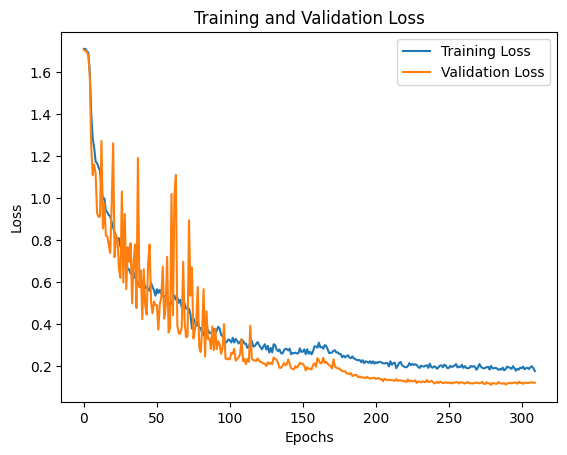

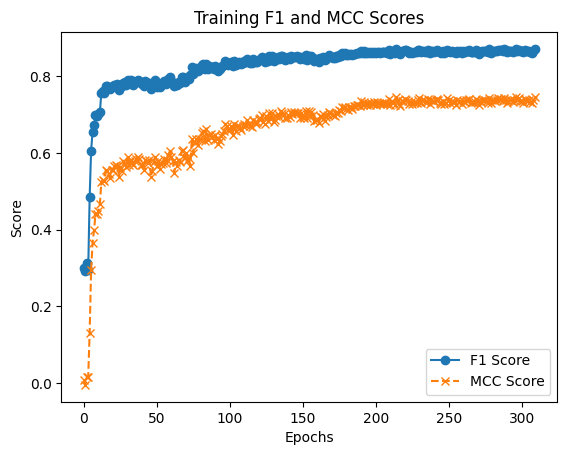

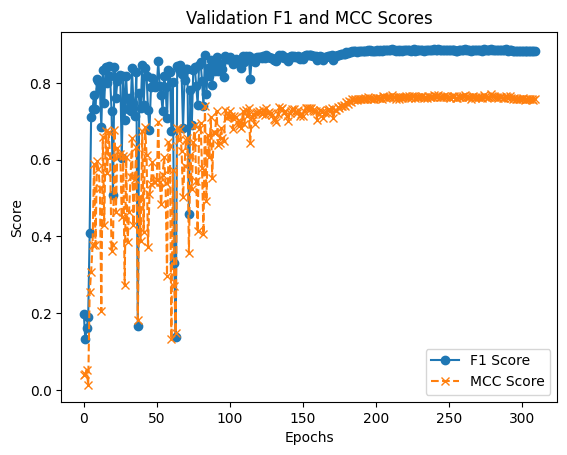

Number of components to preserve 95.0% variance: 553
Epoch [1/1000], Training Loss: 1.7097, Training F1 score: 0.3265, Training MCC score: -0.0031, Training Combine score: 0.1617
[[3302 1077]
 [3297 1060]]
Epoch [1/1000], Validation Loss: 1.7097, Validation F1 score: 0.0580, Validation MCC score: 0.0160, Validation Combine score: 0.0370
[[1004   26]
 [1111   35]]
Epoch [2/1000], Training Loss: 1.7037, Training F1 score: 0.3791, Training MCC score: 0.0112, Training Combine score: 0.1952
[[3097 1279]
 [3041 1319]]
Epoch [2/1000], Validation Loss: 1.7053, Validation F1 score: 0.5804, Validation MCC score: -0.0065, Validation Combine score: 0.2870
[[354 676]
 [401 745]]
Epoch [3/1000], Training Loss: 1.6965, Training F1 score: 0.3832, Training MCC score: 0.0291, Training Combine score: 0.2062
[[3166 1208]
 [3042 1320]]
Epoch [3/1000], Validation Loss: 1.7022, Validation F1 score: 0.1538, Validation MCC score: -0.0114, Validation Combine score: 0.0712
[[ 928  100]
 [1044  104]]
Epoch [4/100

Epoch [28/1000], Training Loss: 0.7496, Training F1 score: 0.7651, Training MCC score: 0.5544, Training Combine score: 0.6598
[[3595  779]
 [1177 3185]]
Epoch [28/1000], Validation Loss: 0.5611, Validation F1 score: 0.8422, Validation MCC score: 0.6444, Validation Combine score: 0.7433
[[ 727  302]
 [  93 1054]]
Epoch [29/1000], Training Loss: 0.7012, Training F1 score: 0.7833, Training MCC score: 0.5870, Training Combine score: 0.6852
[[3649  728]
 [1084 3275]]
Epoch [29/1000], Validation Loss: 0.5258, Validation F1 score: 0.8618, Validation MCC score: 0.6947, Validation Combine score: 0.7782
[[ 801  228]
 [ 106 1041]]
Epoch [30/1000], Training Loss: 0.7253, Training F1 score: 0.7653, Training MCC score: 0.5480, Training Combine score: 0.6566
[[3531  848]
 [1131 3226]]
Epoch [30/1000], Validation Loss: 0.8549, Validation F1 score: 0.7161, Validation MCC score: 0.5352, Validation Combine score: 0.6257
[[939  90]
 [457 690]]
Epoch [31/1000], Training Loss: 0.6916, Training F1 score: 0.7

Epoch [55/1000], Training Loss: 0.5418, Training F1 score: 0.7798, Training MCC score: 0.5798, Training Combine score: 0.6798
[[3629  750]
 [1093 3264]]
Epoch [55/1000], Validation Loss: 0.6399, Validation F1 score: 0.7477, Validation MCC score: 0.3746, Validation Combine score: 0.5611
[[ 310  720]
 [  32 1114]]
Epoch [56/1000], Training Loss: 0.5311, Training F1 score: 0.7843, Training MCC score: 0.5856, Training Combine score: 0.6849
[[3619  758]
 [1058 3301]]
Epoch [56/1000], Validation Loss: 0.3955, Validation F1 score: 0.8402, Validation MCC score: 0.6389, Validation Combine score: 0.7395
[[ 703  328]
 [  78 1067]]
Epoch [57/1000], Training Loss: 0.5448, Training F1 score: 0.7791, Training MCC score: 0.5832, Training Combine score: 0.6812
[[3673  705]
 [1127 3231]]
Epoch [57/1000], Validation Loss: 0.7757, Validation F1 score: 0.7268, Validation MCC score: 0.3000, Validation Combine score: 0.5134
[[ 177  852]
 [   6 1141]]
Epoch [58/1000], Training Loss: 0.5454, Training F1 score:

Epoch [82/1000], Training Loss: 0.4202, Training F1 score: 0.8206, Training MCC score: 0.6163, Training Combine score: 0.7185
[[2898 1476]
 [ 300 4062]]
Epoch [82/1000], Validation Loss: 0.3320, Validation F1 score: 0.8415, Validation MCC score: 0.6445, Validation Combine score: 0.7430
[[ 740  291]
 [ 102 1043]]
Epoch [83/1000], Training Loss: 0.4315, Training F1 score: 0.8168, Training MCC score: 0.6076, Training Combine score: 0.7122
[[2865 1512]
 [ 306 4053]]
Epoch [83/1000], Validation Loss: 0.3076, Validation F1 score: 0.8495, Validation MCC score: 0.6639, Validation Combine score: 0.7567
[[ 754  278]
 [  94 1050]]
Epoch [84/1000], Training Loss: 0.4276, Training F1 score: 0.8195, Training MCC score: 0.6145, Training Combine score: 0.7170
[[2927 1452]
 [ 324 4033]]
Epoch [84/1000], Validation Loss: 0.2827, Validation F1 score: 0.8640, Validation MCC score: 0.7006, Validation Combine score: 0.7823
[[ 810  219]
 [ 108 1039]]
Epoch [85/1000], Training Loss: 0.4065, Training F1 score:

Epoch [109/1000], Training Loss: 0.3263, Training F1 score: 0.8339, Training MCC score: 0.6474, Training Combine score: 0.7406
[[3005 1370]
 [ 263 4098]]
Epoch [109/1000], Validation Loss: 0.2439, Validation F1 score: 0.8657, Validation MCC score: 0.7023, Validation Combine score: 0.7840
[[ 791  239]
 [  89 1057]]
Epoch [110/1000], Training Loss: 0.3194, Training F1 score: 0.8357, Training MCC score: 0.6518, Training Combine score: 0.7438
[[3085 1291]
 [ 304 4056]]
Epoch [110/1000], Validation Loss: 0.2449, Validation F1 score: 0.8615, Validation MCC score: 0.6926, Validation Combine score: 0.7770
[[ 783  248]
 [  91 1054]]
Epoch [111/1000], Training Loss: 0.3200, Training F1 score: 0.8351, Training MCC score: 0.6504, Training Combine score: 0.7427
[[3064 1312]
 [ 294 4066]]
Epoch [111/1000], Validation Loss: 0.2381, Validation F1 score: 0.8663, Validation MCC score: 0.7045, Validation Combine score: 0.7854
[[ 802  227]
 [  97 1050]]
Epoch [112/1000], Training Loss: 0.3062, Training F1

Epoch [135/1000], Training Loss: 1.0966, Training F1 score: 0.6007, Training MCC score: 0.0794, Training Combine score: 0.3400
[[1656 2718]
 [1323 3039]]
Epoch [135/1000], Validation Loss: 1.1818, Validation F1 score: 0.6018, Validation MCC score: 0.0456, Validation Combine score: 0.3237
[[380 650]
 [373 773]]
Epoch [136/1000], Training Loss: 1.1508, Training F1 score: 0.5948, Training MCC score: 0.0601, Training Combine score: 0.3274
[[1584 2797]
 [1328 3027]]
Epoch [136/1000], Validation Loss: 1.1123, Validation F1 score: 0.5562, Validation MCC score: 0.1008, Validation Combine score: 0.3285
[[582 447]
 [533 614]]
Epoch [137/1000], Training Loss: 1.1802, Training F1 score: 0.5826, Training MCC score: 0.0331, Training Combine score: 0.3079
[[1545 2834]
 [1401 2956]]
Epoch [137/1000], Validation Loss: 1.0861, Validation F1 score: 0.5711, Validation MCC score: 0.1053, Validation Combine score: 0.3382
[[557 471]
 [501 647]]
Epoch [138/1000], Training Loss: 1.1242, Training F1 score: 0.61

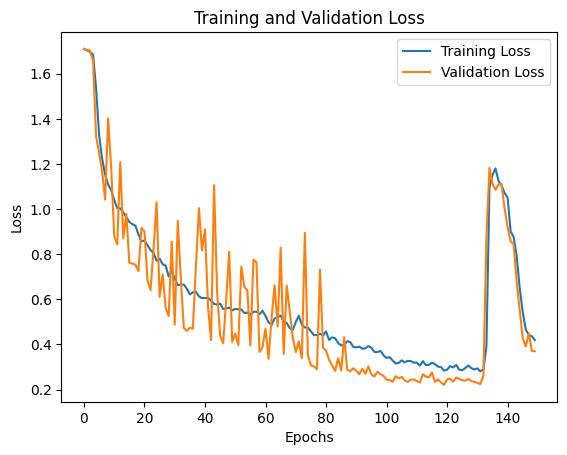

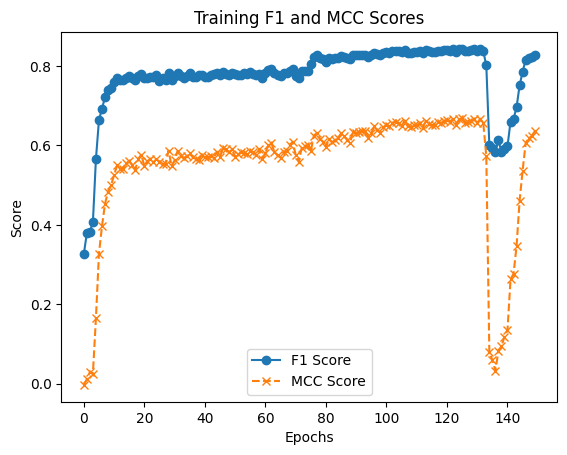

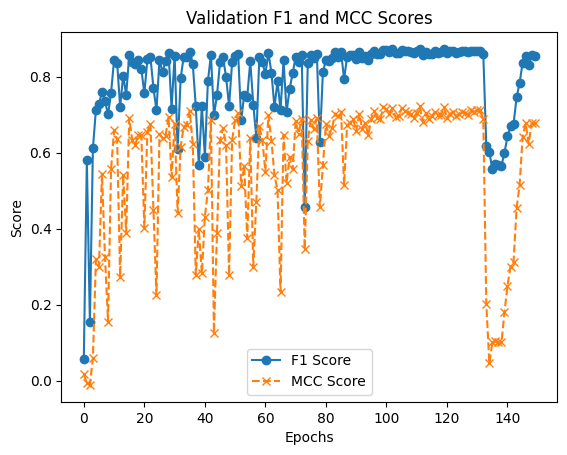

Number of components to preserve 95.0% variance: 553
Epoch [1/1000], Training Loss: 1.7108, Training F1 score: 0.3919, Training MCC score: 0.0010, Training Combine score: 0.1964
[[2942 1376]
 [3006 1412]]
Epoch [1/1000], Validation Loss: 1.7123, Validation F1 score: 0.4389, Validation MCC score: 0.0268, Validation Combine score: 0.2328
[[700 384]
 [677 415]]
Epoch [2/1000], Training Loss: 1.7059, Training F1 score: 0.3812, Training MCC score: 0.0083, Training Combine score: 0.1947
[[3041 1279]
 [3075 1341]]
Epoch [2/1000], Validation Loss: 1.7115, Validation F1 score: 0.4835, Validation MCC score: 0.0247, Validation Combine score: 0.2541
[[617 465]
 [597 497]]
Epoch [3/1000], Training Loss: 1.7111, Training F1 score: 0.3559, Training MCC score: -0.0082, Training Combine score: 0.1738
[[3095 1228]
 [3192 1221]]
Epoch [3/1000], Validation Loss: 1.6999, Validation F1 score: 0.2869, Validation MCC score: 0.0526, Validation Combine score: 0.1698
[[922 167]
 [877 210]]
Epoch [4/1000], Traini

Epoch [28/1000], Training Loss: 1.1683, Training F1 score: 0.6777, Training MCC score: 0.4179, Training Combine score: 0.5478
[[3444  878]
 [1702 2712]]
Epoch [28/1000], Validation Loss: 0.9430, Validation F1 score: 0.7942, Validation MCC score: 0.5688, Validation Combine score: 0.6815
[[793 290]
 [182 911]]
Epoch [29/1000], Training Loss: 1.1674, Training F1 score: 0.6718, Training MCC score: 0.4215, Training Combine score: 0.5466
[[3518  803]
 [1776 2639]]
Epoch [29/1000], Validation Loss: 0.9658, Validation F1 score: 0.7874, Validation MCC score: 0.5548, Validation Combine score: 0.6711
[[787 296]
 [191 902]]
Epoch [30/1000], Training Loss: 1.1555, Training F1 score: 0.7464, Training MCC score: 0.4441, Training Combine score: 0.5952
[[2649 1673]
 [ 790 3624]]
Epoch [30/1000], Validation Loss: 1.0206, Validation F1 score: 0.7643, Validation MCC score: 0.5034, Validation Combine score: 0.6338
[[750 336]
 [208 882]]
Epoch [31/1000], Training Loss: 1.1533, Training F1 score: 0.7702, Tra

Epoch [55/1000], Training Loss: 0.8564, Training F1 score: 0.7892, Training MCC score: 0.5350, Training Combine score: 0.6621
[[2667 1651]
 [ 462 3956]]
Epoch [55/1000], Validation Loss: 0.8673, Validation F1 score: 0.7692, Validation MCC score: 0.5068, Validation Combine score: 0.6380
[[728 356]
 [187 905]]
Epoch [56/1000], Training Loss: 0.9413, Training F1 score: 0.7557, Training MCC score: 0.4583, Training Combine score: 0.6070
[[2565 1756]
 [ 667 3748]]
Epoch [56/1000], Validation Loss: 0.8759, Validation F1 score: 0.7665, Validation MCC score: 0.5034, Validation Combine score: 0.6349
[[734 352]
 [194 896]]
Epoch [57/1000], Training Loss: 0.8420, Training F1 score: 0.7904, Training MCC score: 0.5397, Training Combine score: 0.6651
[[2725 1598]
 [ 485 3928]]
Epoch [57/1000], Validation Loss: 0.8277, Validation F1 score: 0.7820, Validation MCC score: 0.5411, Validation Combine score: 0.6615
[[771 314]
 [189 902]]
Epoch [58/1000], Training Loss: 0.8357, Training F1 score: 0.7889, Tra

Epoch [82/1000], Training Loss: 0.6842, Training F1 score: 0.7977, Training MCC score: 0.5552, Training Combine score: 0.6765
[[2641 1686]
 [ 365 4044]]
Epoch [82/1000], Validation Loss: 0.7264, Validation F1 score: 0.7791, Validation MCC score: 0.5237, Validation Combine score: 0.6514
[[714 371]
 [158 933]]
Epoch [83/1000], Training Loss: 0.6361, Training F1 score: 0.8122, Training MCC score: 0.5904, Training Combine score: 0.7013
[[2758 1565]
 [ 325 4088]]
Epoch [83/1000], Validation Loss: 0.6520, Validation F1 score: 0.8049, Validation MCC score: 0.5826, Validation Combine score: 0.6937
[[755 329]
 [135 957]]
Epoch [84/1000], Training Loss: 0.6770, Training F1 score: 0.7951, Training MCC score: 0.5490, Training Combine score: 0.6720
[[2686 1634]
 [ 424 3992]]
Epoch [84/1000], Validation Loss: 0.8367, Validation F1 score: 0.7339, Validation MCC score: 0.4351, Validation Combine score: 0.5845
[[706 377]
 [241 852]]
Epoch [85/1000], Training Loss: 1.0968, Training F1 score: 0.6397, Tra

Epoch [109/1000], Training Loss: 0.5553, Training F1 score: 0.8136, Training MCC score: 0.5970, Training Combine score: 0.7053
[[2962 1363]
 [ 451 3960]]
Epoch [109/1000], Validation Loss: 0.5243, Validation F1 score: 0.8281, Validation MCC score: 0.6382, Validation Combine score: 0.7331
[[816 268]
 [131 961]]
Epoch [110/1000], Training Loss: 0.5586, Training F1 score: 0.8129, Training MCC score: 0.5948, Training Combine score: 0.7038
[[2960 1359]
 [ 462 3955]]
Epoch [110/1000], Validation Loss: 0.5415, Validation F1 score: 0.8187, Validation MCC score: 0.6172, Validation Combine score: 0.7180
[[798 288]
 [135 955]]
Epoch [111/1000], Training Loss: 0.6066, Training F1 score: 0.7931, Training MCC score: 0.5498, Training Combine score: 0.6715
[[2859 1464]
 [ 551 3862]]
Epoch [111/1000], Validation Loss: 0.6543, Validation F1 score: 0.7773, Validation MCC score: 0.5292, Validation Combine score: 0.6532
[[757 329]
 [188 902]]
Epoch [112/1000], Training Loss: 0.7797, Training F1 score: 0.73

Epoch [136/1000], Training Loss: 0.4673, Training F1 score: 0.8295, Training MCC score: 0.6321, Training Combine score: 0.7308
[[2931 1393]
 [ 298 4114]]
Epoch [136/1000], Validation Loss: 0.5152, Validation F1 score: 0.8134, Validation MCC score: 0.6018, Validation Combine score: 0.7076
[[764 321]
 [123 968]]
Epoch [137/1000], Training Loss: 0.4732, Training F1 score: 0.8246, Training MCC score: 0.6206, Training Combine score: 0.7226
[[2878 1447]
 [ 301 4110]]
Epoch [137/1000], Validation Loss: 0.5169, Validation F1 score: 0.8124, Validation MCC score: 0.6001, Validation Combine score: 0.7063
[[761 327]
 [120 968]]
Epoch [138/1000], Training Loss: 0.4858, Training F1 score: 0.8220, Training MCC score: 0.6144, Training Combine score: 0.7182
[[2868 1456]
 [ 317 4095]]
Epoch [138/1000], Validation Loss: 0.5208, Validation F1 score: 0.8132, Validation MCC score: 0.6022, Validation Combine score: 0.7077
[[772 313]
 [129 962]]
Epoch [139/1000], Training Loss: 0.4693, Training F1 score: 0.82

Epoch [163/1000], Training Loss: 0.4423, Training F1 score: 0.8309, Training MCC score: 0.6355, Training Combine score: 0.7332
[[2969 1354]
 [ 314 4099]]
Epoch [163/1000], Validation Loss: 0.4733, Validation F1 score: 0.8202, Validation MCC score: 0.6185, Validation Combine score: 0.7194
[[785 301]
 [123 967]]
Epoch [164/1000], Training Loss: 0.4421, Training F1 score: 0.8308, Training MCC score: 0.6351, Training Combine score: 0.7330
[[2958 1364]
 [ 308 4106]]
Epoch [164/1000], Validation Loss: 0.4845, Validation F1 score: 0.8185, Validation MCC score: 0.6148, Validation Combine score: 0.7167
[[786 298]
 [129 963]]
Epoch [165/1000], Training Loss: 0.4516, Training F1 score: 0.8270, Training MCC score: 0.6264, Training Combine score: 0.7267
[[2946 1378]
 [ 330 4082]]
Epoch [165/1000], Validation Loss: 0.5177, Validation F1 score: 0.8039, Validation MCC score: 0.5838, Validation Combine score: 0.6939
[[776 307]
 [152 941]]
Epoch [166/1000], Training Loss: 0.4467, Training F1 score: 0.82

Epoch [190/1000], Training Loss: 0.4112, Training F1 score: 0.8355, Training MCC score: 0.6461, Training Combine score: 0.7408
[[2998 1324]
 [ 297 4117]]
Epoch [190/1000], Validation Loss: 0.4409, Validation F1 score: 0.8282, Validation MCC score: 0.6369, Validation Combine score: 0.7326
[[805 279]
 [123 969]]
Epoch [191/1000], Training Loss: 0.4115, Training F1 score: 0.8358, Training MCC score: 0.6471, Training Combine score: 0.7414
[[3012 1314]
 [ 301 4109]]
Epoch [191/1000], Validation Loss: 0.4503, Validation F1 score: 0.8245, Validation MCC score: 0.6283, Validation Combine score: 0.7264
[[796 288]
 [124 968]]
Epoch [192/1000], Training Loss: 0.4166, Training F1 score: 0.8335, Training MCC score: 0.6417, Training Combine score: 0.7376
[[2991 1333]
 [ 307 4105]]
Epoch [192/1000], Validation Loss: 0.4412, Validation F1 score: 0.8287, Validation MCC score: 0.6373, Validation Combine score: 0.7330
[[805 276]
 [125 970]]
Epoch [193/1000], Training Loss: 0.4110, Training F1 score: 0.83

Epoch [217/1000], Training Loss: 0.3923, Training F1 score: 0.8394, Training MCC score: 0.6552, Training Combine score: 0.7473
[[3037 1284]
 [ 293 4122]]
Epoch [217/1000], Validation Loss: 0.4207, Validation F1 score: 0.8330, Validation MCC score: 0.6498, Validation Combine score: 0.7414
[[824 264]
 [123 965]]
Epoch [218/1000], Training Loss: 0.4006, Training F1 score: 0.8359, Training MCC score: 0.6474, Training Combine score: 0.7416
[[3036 1287]
 [ 320 4093]]
Epoch [218/1000], Validation Loss: 0.4223, Validation F1 score: 0.8315, Validation MCC score: 0.6462, Validation Combine score: 0.7389
[[820 267]
 [124 965]]
Epoch [219/1000], Training Loss: 0.3844, Training F1 score: 0.8414, Training MCC score: 0.6601, Training Combine score: 0.7507
[[3068 1256]
 [ 296 4116]]
Epoch [219/1000], Validation Loss: 0.4330, Validation F1 score: 0.8293, Validation MCC score: 0.6400, Validation Combine score: 0.7346
[[811 273]
 [125 967]]
Epoch [220/1000], Training Loss: 0.3977, Training F1 score: 0.83

Epoch [244/1000], Training Loss: 0.3662, Training F1 score: 0.8464, Training MCC score: 0.6717, Training Combine score: 0.7591
[[3132 1189]
 [ 303 4112]]
Epoch [244/1000], Validation Loss: 0.4075, Validation F1 score: 0.8343, Validation MCC score: 0.6530, Validation Combine score: 0.7437
[[832 253]
 [129 962]]
Epoch [245/1000], Training Loss: 0.3754, Training F1 score: 0.8429, Training MCC score: 0.6640, Training Combine score: 0.7535
[[3109 1218]
 [ 310 4099]]
Epoch [245/1000], Validation Loss: 0.4007, Validation F1 score: 0.8374, Validation MCC score: 0.6587, Validation Combine score: 0.7480
[[832 251]
 [125 968]]
Epoch [246/1000], Training Loss: 0.3704, Training F1 score: 0.8443, Training MCC score: 0.6667, Training Combine score: 0.7555
[[3120 1199]
 [ 314 4103]]
Epoch [246/1000], Validation Loss: 0.4079, Validation F1 score: 0.8350, Validation MCC score: 0.6542, Validation Combine score: 0.7446
[[831 254]
 [127 964]]
Epoch [247/1000], Training Loss: 0.3768, Training F1 score: 0.84

Epoch [271/1000], Training Loss: 0.3551, Training F1 score: 0.8460, Training MCC score: 0.6705, Training Combine score: 0.7582
[[3082 1239]
 [ 270 4145]]
Epoch [271/1000], Validation Loss: 0.3919, Validation F1 score: 0.8351, Validation MCC score: 0.6524, Validation Combine score: 0.7437
[[820 263]
 [121 972]]
Epoch [272/1000], Training Loss: 0.3657, Training F1 score: 0.8423, Training MCC score: 0.6623, Training Combine score: 0.7523
[[3083 1241]
 [ 299 4113]]
Epoch [272/1000], Validation Loss: 0.4250, Validation F1 score: 0.8240, Validation MCC score: 0.6306, Validation Combine score: 0.7273
[[816 270]
 [137 953]]
Epoch [273/1000], Training Loss: 0.3727, Training F1 score: 0.8399, Training MCC score: 0.6569, Training Combine score: 0.7484
[[3083 1241]
 [ 319 4093]]
Epoch [273/1000], Validation Loss: 0.4000, Validation F1 score: 0.8354, Validation MCC score: 0.6533, Validation Combine score: 0.7443
[[821 262]
 [121 972]]
Epoch [274/1000], Training Loss: 0.3603, Training F1 score: 0.84

KeyboardInterrupt: 

In [260]:
selection = SelectKBest(score_func=mutual_info_classif, k= 1000)
X_train_k = selection.fit_transform(X_train,y_train)
X_test_k = selection.transform(X_test)
print(np.array(X_train_k).shape,np.array(X_test_k).shape)



# 初始化 k 折交叉驗證
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

X = X_train_k
y = y_train

# 訓練和評估
result_f1 = []
result_mcc = []
total_y_true = []
total_y_pred = []

f1_four = []
mcc_four = []
total_y_true_four = []
total_y_pred_four = []
for fold, (val_indices, test_indices) in enumerate(kfold.split(X, y)):
    # 分割數據集
    X_train1, X_val = X[val_indices], X[test_indices]
    y_train1, y_val = y[val_indices], y[test_indices]
    
    # 將訓練集再分為訓練集和驗證集
    #X_train1, X_val, y_train1, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42, stratify=y_train1)
    X_train2 = csr_matrix(X_train1).toarray()


    
#     negative_indices = np.where(labels == 0)[0]
#     negative_samples = np.array(np.array(feature))[negative_indices]
#     negative_labels  = np.array(np.array(labels))[negative_indices]
#     print(pd.Series(negative_labels).value_counts())


    # 假设 X 是您的数据矩阵，形状为 (样本数, 特征数)，例如 (500, 2048)

    # 初始化 PCA，所有主成分
    pca = PCA()

    # PCA
    pca.fit(X_train2)

    # 計算PCA各個主成份的方差解釋率
    explained_variance_ratio = pca.explained_variance_ratio_

    # 累積方差解釋率
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # setting the threshold
    threshold = 0.95

    # 找到最小主成分数目
    n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

    print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")
    
    pca_reduced = PCA(n_components=n_components)
    # 進行 PCA 轉換
    X_train2 = pca_reduced.fit_transform(X_train2)
    X_val1 = pca_reduced.transform(X_val)
    X_test1 = pca_reduced.transform(X_test_k)
#     X_four = pca_reduced.transform(np.array(feature))

    # 轉換標籤為一維張量
    y_train1 = y_train1.flatten()
    y_val1 = y_val.flatten()
    y_test1 = y_test.flatten()
#     y_four = labels.flatten()

    # 創建數據加載器
    train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train2), torch.Tensor(y_train1))
    val_data = torch.utils.data.TensorDataset(torch.Tensor(X_val1), torch.Tensor(y_val1))
    test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test1), torch.Tensor(y_test1))
#     four_data = torch.utils.data.TensorDataset(torch.Tensor(X_four), torch.Tensor(y_four))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size =32, shuffle=True, drop_last=True)
#     four_loader = torch.utils.data.DataLoader(four_data, batch_size =32, shuffle=True, drop_last=True)

    # 實例化模型、損失函數和優化器

    input_size = 2048
    embedding_dim = n_components
    hidden_size = 128
    output_size = 1 #二元分類問題
    num_layers = 4
    model = RNNModel(input_size,embedding_dim, hidden_size, output_size, num_layers).to(dtype=torch.float)

    learning_rate = 0.0005

    l2_lambda = 0.00005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    patience = 30
    counter = 0
    best_val_loss = float('inf')


    n_epochs = 1000


    # Initialize lists to store training and validation loss and F1 score
    train_losses = []
    val_losses = []
    train_f1_scores = []
    train_mcc_scores = []
    val_f1_scores = []
    val_mcc_scores = []

    for epoch in range(n_epochs):
        train_loss,t_f1,t_mcc,tcombined_score,train_mtr =  train(model, optimizer, train_loader)
        val_loss, val_f1, val_mcc, combined_score,mtr = validate(model, val_loader, l2_lambda)
        scheduler.step(val_loss)
        # Append the results to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(t_f1)
        train_mcc_scores.append(t_mcc)
        val_f1_scores.append(val_f1)
        val_mcc_scores.append(val_mcc)   
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training F1 score: {:.4f}, Training MCC score: {:.4f}, Training Combine score: {:.4f}'.format(epoch+1, n_epochs, train_loss,t_f1,t_mcc,tcombined_score))
        print(train_mtr)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation F1 score: {:.4f}, Validation MCC score: {:.4f}, Validation Combine score: {:.4f}'.format(epoch+1, n_epochs,val_loss, val_f1, val_mcc, combined_score))
        print(mtr)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered at epoch {}.".format(epoch+1))
                break





    test_loss, f1,mcc,mtr,y_true,y_pred = test(model, test_loader)
    print('Test Loss: {:.4f}, F1 Score: {:.2f}, MCC: {:.2f}, Combine: {:.2f}'.format(test_loss, f1,mcc,(f1+mcc)/2))
    print(mtr)
    
    total_y_pred = total_y_pred + y_pred
    total_y_true = total_y_true + y_true
    
#     test_loss, f1,mcc,mtr,y_true,y_pred = test(model, four_loader)
#     print('Test Loss: {:.4f}, Accuracy Score: {:.2f}'.format(test_loss,accuracy_score(y_true, y_pred)))
#     print(mtr)

#     total_y_pred_four = total_y_pred_four + y_pred
#     total_y_true_four = total_y_true_four + y_true
    
    # Plotting the training and validation loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training F1 score
    plt.figure()
    plt.plot(train_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(train_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Training F1 and MCC Scores')
    plt.legend()
    plt.show()

    # Plotting the validation F1 score
    plt.figure()
    plt.plot(val_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(val_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation F1 and MCC Scores')
    plt.legend()
    plt.show()


model_name = "RNN"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true,total_y_pred)
# print("Testing for all negative : {}".format(accuracy_score(total_y_true_four, total_y_pred_four)))
per_index
# model_name = "RNN"
# dataset = "MorganFingerPrint (ALL data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true_four,total_y_pred_four)

In [ ]:
# X_train1, y_train1 = InstanceHardnessThreshold(estimator=GradientBoostingClassifier(),random_state=42).fit_resample(X_train, y_train)
# print(np.array(X_train1).shape,np.array(y_train1).shape)
# plt.figure( figsize=(10,5) )
# pd.Series(y_train1).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
# plt.title( 'y_train' )  # 圖標題
# plt.ylabel( '' )
# plt.show()
# # X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size=0.3, random_state=42, stratify=y_train)
# X_train1 = csr_matrix(X_train1).toarray()
# # print(X_train1)
# # print("\n")
# # print(X_test1)



# 初始化 PCA，所有主成分
pca = PCA()

# PCA
pca.fit(X_train_k)

# 計算PCA各個主成份的方差解釋率
explained_variance_ratio = pca.explained_variance_ratio_

# 累積方差解釋率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# setting the threshold
threshold = 0.95

# 找到最小主成分数目
n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
# 進行 PCA 轉換
X_train3 = pca_reduced.fit_transform(X_train_k)
# X_val1 = pca_reduced.transform(X_val)
X_test3 = pca_reduced.transform(X_test_k)
# X_four = pca_reduced.transform(np.array(feature))
# 轉換標籤為一維張量
y_train = y_train.ravel()
y_test = np.array(y_test).ravel()
# y_four = np.array(labels).ravel()
print("Size of training set : {}   {}".format(X_train3.shape,y_train.shape))



def mcc_score(y_true, y_pred):
    return (matthews_corrcoef(y_true, y_pred)+f1_score(y_true, y_pred))/2

# 将 MCC 转换为评估指标
scoring = make_scorer(mcc_score)

X_train_copy = X_train3
X_test_copy = X_test3


k_best_selector = SelectKBest(k=100)
percentile_selector = SelectPercentile(percentile=100)
pca_selector = PCA(n_components=100)
selector = VarianceThreshold(threshold=0)
svm = SVC(kernel='linear', C=1, random_state=42)
selector = SelectFromModel(svm, threshold=0.3)
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold= "mean")
n_iter_search = 20 



nb_classifier = GaussianNB()
params_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}
pipeline_nb = Pipeline([
    ('classifier', nb_classifier)
])
model_nb = RandomizedSearchCV(pipeline_nb, param_distributions=params_nb,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_nb.fit(X_train_copy, y_train)
nb = model_nb.best_estimator_
matrix = metrics.confusion_matrix(y_test,nb.predict(X_test_copy))
precision = precision_score(y_test,nb.predict(X_test_copy))
recall = recall_score(y_test,nb.predict(X_test_copy))
f1 = f1_score(y_test,nb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,nb.predict(X_test_copy))

model_name = "GaussianNB"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,nb.predict(X_test_copy))

print("########################NB########################")
print(" Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,nb.predict(X_four))
# precision = precision_score(y_four,nb.predict(X_four))
# recall = recall_score(y_four,nb.predict(X_four))
# f1 = f1_score(y_four,nb.predict(X_four))
# mcc = matthews_corrcoef(y_four,nb.predict(X_four))

# model_name = "GaussianNB"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,nb.predict(X_four))

# print("########################NB########################")
# print(" Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3

params_log = {'classifier__penalty':['l2','l1'],"classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver":["liblinear"],"classifier__max_iter":[50,100,200,500,700,1000]}
log_classifier = LogisticRegression()
pipeline_log = Pipeline([
    ('classifier', log_classifier)
])
model_log = RandomizedSearchCV(pipeline_log,
                               param_distributions=params_log,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_log.fit(X_train_copy,y_train)
logg = model_log.best_estimator_
matrix = metrics.confusion_matrix(y_test,logg.predict(X_test_copy))
precision = precision_score(y_test,logg.predict(X_test_copy))
recall = recall_score(y_test,logg.predict(X_test_copy))
f1 = f1_score(y_test,logg.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,logg.predict(X_test_copy))

model_name = "LogisticRegression"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,logg.predict(X_test_copy))

print("########################LogisticRegression########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

# matrix = metrics.confusion_matrix(y_four,logg.predict(X_four))
# precision = precision_score(y_four,logg.predict(X_four))
# recall = recall_score(y_four,logg.predict(X_four))
# f1 = f1_score(y_four,logg.predict(X_four))
# mcc = matthews_corrcoef(y_four,logg.predict(X_four))

# model_name = "LogisticRegression"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,logg.predict(X_four))

# print("########################LogisticRegression########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_svm = {'classifier__kernel':['linear', 'poly', 'rbf','sigmoid'],
              "classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
            "classifier__gamma" : ['scale','auto']}
svm_classifier = SVC()
pipeline_svm = Pipeline([
    ('classifier', svm_classifier)
])
model_svm = RandomizedSearchCV(pipeline_svm,
                               param_distributions=params_svm,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_svm.fit(X_train_copy,y_train)
svm = model_svm.best_estimator_
matrix = metrics.confusion_matrix(y_test,svm.predict(X_test_copy))
precision = precision_score(y_test,svm.predict(X_test_copy))
recall = recall_score(y_test,svm.predict(X_test_copy))
f1 = f1_score(y_test,svm.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,svm.predict(X_test_copy))

model_name = "SVM"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,svm.predict(X_test_copy))

print("########################SVM########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,svm.predict(X_four))
# precision = precision_score(y_four,svm.predict(X_four))
# recall = recall_score(y_four,svm.predict(X_four))
# f1 = f1_score(y_four,svm.predict(X_four))
# mcc = matthews_corrcoef(y_four,svm.predict(X_four))

# model_name = "SVM"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,svm.predict(X_four))

# print("########################SVM########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)

X_train_copy = X_train3
X_test_copy = X_test3


params_xgb = {'classifier__learning_rate':[0.01,0.001,0.0001],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(1,201,50),
              "classifier__gamma" :range(1,10,3)
             }
xgb_classifier = XGBClassifier()
pipeline_xgb = Pipeline([
    ('classifier', xgb_classifier)
])
model_xgb = RandomizedSearchCV(pipeline_xgb,
                               param_distributions=params_xgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_xgb.fit(X_train_copy,y_train)
xgb = model_xgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,xgb.predict(X_test_copy))
precision = precision_score(y_test,xgb.predict(X_test_copy),zero_division=0)
recall = recall_score(y_test,xgb.predict(X_test_copy))
f1 = f1_score(y_test,xgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,xgb.predict(X_test_copy))

model_name = "XGBClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,xgb.predict(X_test_copy))


print("########################XGBClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,xgb.predict(X_four))
# precision = precision_score(y_four,xgb.predict(X_four),zero_division=0)
# recall = recall_score(y_four,xgb.predict(X_four))
# f1 = f1_score(y_four,xgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,xgb.predict(X_four))

# model_name = "XGBClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,xgb.predict(X_four))


# print("########################XGBClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_rf = {'classifier__max_features':['sqrt','log2'],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(100,1000,100),
   "classifier__criterion" : ['gini','entropy'],
             "classifier__oob_score" : [True]
             
             }
rf_classifier = RandomForestClassifier()
pipeline_rf = Pipeline([
    ('classifier', rf_classifier)
])
model_rf = RandomizedSearchCV(pipeline_rf,
                              param_distributions=params_rf,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_rf.fit(X_train_copy,y_train)
rf = model_rf.best_estimator_
matrix = metrics.confusion_matrix(y_test,rf.predict(X_test_copy))
precision = precision_score(y_test,rf.predict(X_test_copy),zero_division=1)
recall = recall_score(y_test,rf.predict(X_test_copy))
f1 = f1_score(y_test,rf.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,rf.predict(X_test_copy))

model_name = "RandomForestClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,rf.predict(X_test_copy))

print("########################RandomForest########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,rf.predict(X_four))
# precision = precision_score(y_four,rf.predict(X_four),zero_division=1)
# recall = recall_score(y_four,rf.predict(X_four))
# f1 = f1_score(y_four,rf.predict(X_four))
# mcc = matthews_corrcoef(y_four,rf.predict(X_four))

# model_name = "RandomForestClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,rf.predict(X_four))

# print("########################RandomForest########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3



params_lgb = {'classifier__objective': ["binary"],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__max_depth" : [3, 5, 6, 7, 9, 12, 15, 17, 25],
             "classifier__subsample" : [0.6, 0.7, 0.8, 0.9, 1]
              
             }
lgb_classifier = lgb.LGBMClassifier()
pipeline_lgb = Pipeline([
    ('classifier', lgb_classifier)
])
model_lgb = RandomizedSearchCV(pipeline_lgb,
                               param_distributions=params_lgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)

model_lgb.fit(X_train_copy,y_train)
lgb = model_lgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,lgb.predict(X_test_copy))
precision = precision_score(y_test,lgb.predict(X_test_copy))
recall = recall_score(y_test,lgb.predict(X_test_copy))
f1 = f1_score(y_test,lgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,lgb.predict(X_test_copy))

model_name = "LGBMClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,lgb.predict(X_test_copy))

print("########################LGBMClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,lgb.predict(X_four))
# precision = precision_score(y_four,lgb.predict(X_four))
# recall = recall_score(y_four,lgb.predict(X_four))
# f1 = f1_score(y_four,lgb.predict(X_four))
# mcc = matthews_corrcoef(y_four,lgb.predict(X_four))

# model_name = "LGBMClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,lgb.predict(X_four))

# print("########################LGBMClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_mlp = {'classifier__hidden_layer_sizes':[50,100,150,200],
              'classifier__solver': ["sgd","adam"],
              "classifier__learning_rate_init" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__early_stopping" : [True],
             "classifier__shuffle" : [True]
             }

mlp_classifier= MLPClassifier()
pipeline_mlp = Pipeline([
    ('classifier', mlp_classifier)
])
model_mlp = RandomizedSearchCV(pipeline_mlp,
                               param_distributions=params_mlp,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_mlp.fit(X_train_copy,y_train)
mlp = model_mlp.best_estimator_
matrix = metrics.confusion_matrix(y_test,mlp.predict(X_test_copy))
precision = precision_score(y_test,mlp.predict(X_test_copy),zero_division = 1)
recall = recall_score(y_test,mlp.predict(X_test_copy))
f1 = f1_score(y_test,mlp.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,mlp.predict(X_test_copy))

model_name = "MLPClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,mlp.predict(X_test_copy))

print("########################MLPClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,mlp.predict(X_four))
# precision = precision_score(y_four,mlp.predict(X_four),zero_division = 1)
# recall = recall_score(y_four,mlp.predict(X_four))
# f1 = f1_score(y_four,mlp.predict(X_four))
# mcc = matthews_corrcoef(y_four,mlp.predict(X_four))

# model_name = "MLPClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,mlp.predict(X_four))

# print("########################MLPClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)


X_train_copy = X_train3
X_test_copy = X_test3


params_cat = {'classifier__loss_function':["RMSE","Logloss","CrossEntropy","MAE"],
              'classifier__iterations': [1000],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
             "classifier__sampling_frequency" : ["PerTree","PerTreeLevel"]
             }
cat_classifier = CatBoostClassifier()
pipeline_cat = Pipeline([
    ('classifier', cat_classifier)
])
model_cat = RandomizedSearchCV(pipeline_cat,
                               param_distributions=params_cat,
                               n_iter=n_iter_search, verbose=0,
                               scoring=scoring, cv=5)
model_cat.fit(X_train_copy,y_train)
cat = model_cat.best_estimator_
matrix = metrics.confusion_matrix(y_test,cat.predict(X_test_copy))
precision = precision_score(y_test,cat.predict(X_test_copy))
recall = recall_score(y_test,cat.predict(X_test_copy))
f1 = f1_score(y_test,cat.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,cat.predict(X_test_copy))

model_name = "CatBoostClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,cat.predict(X_test_copy))

print("########################CatBoostClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)
# matrix = metrics.confusion_matrix(y_four,cat.predict(X_four))
# precision = precision_score(y_four,cat.predict(X_four))
# recall = recall_score(y_four,cat.predict(X_four))
# f1 = f1_score(y_four,cat.predict(X_four))
# mcc = matthews_corrcoef(y_four,cat.predict(X_four))

# model_name = "CatBoostClassifier"
# dataset = "MorganFingerPrint (All data)"
# preprocessing = "PCA"
# per_index = performance(per_index,model_name,dataset,preprocessing,y_four,cat.predict(X_four))

# print("########################CatBoostClassifier########################")
# print("Best F1 score {} , MCC : {}".format(f1,mcc))
# print("Precision : {},  Recall : {}".format(precision,recall))
# print(matrix)
# print("\n\n")
# print(per_index)
per_index



In [90]:
pca = PCA()

# PCA
pca.fit(X_train_k)

# 計算PCA各個主成份的方差解釋率
explained_variance_ratio = pca.explained_variance_ratio_

# 累積方差解釋率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# setting the threshold
threshold = 0.95

# 找到最小主成分数目
n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
# 進行 PCA 轉換
X_train3 = pca_reduced.fit_transform(X_train_k)
# X_val1 = pca_reduced.transform(X_val)
X_test3 = pca_reduced.transform(X_test_k)
# X_four = pca_reduced.transform(np.array(feature))
# 轉換標籤為一維張量
y_train = y_train.ravel()
y_test = np.array(y_test).ravel()
# y_four = np.array(labels).ravel()
print("Size of training set : {}   {}".format(X_train3.shape,y_train.shape))

Number of components to preserve 95.0% variance: 384
Size of training set : (8753, 384)   (8753,)


(4337, 2)
(4416, 2)


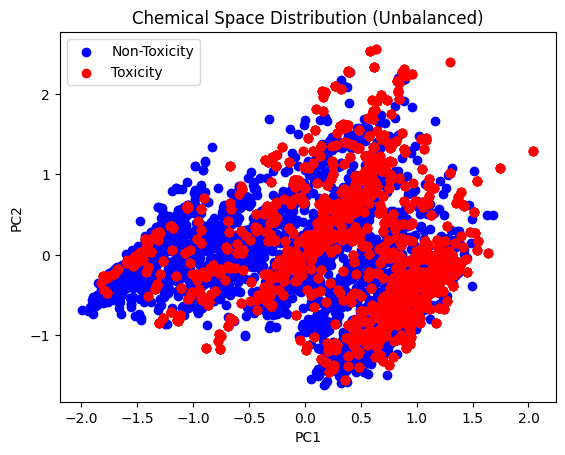

(1085, 2)
(1104, 2)


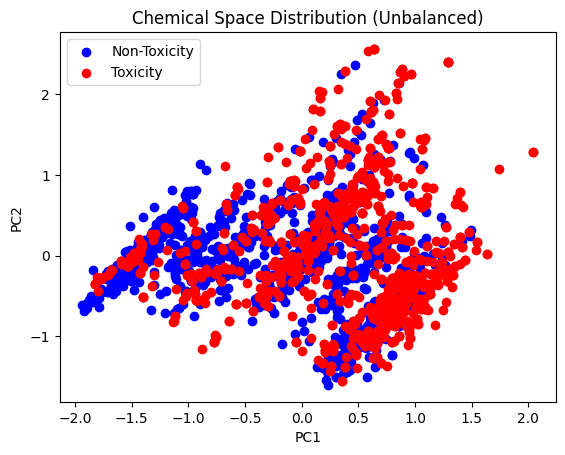

In [93]:

pca1 = PCA(n_components=2)

X_t = pca1.fit_transform(X_train3)

positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(negative_samples,positive_samples)


X_t = pca1.transform(X_test3)

positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_t)[positive_indices]
negative_samples = np.array(X_t)[negative_indices]

PCA_func(negative_samples,positive_samples)

In [100]:
import numpy as np
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

positive_samples = np.array(X_train3)[positive_indices]
negative_samples = np.array(X_test3)[negative_indices]
overlaps = []
for i in range(positive_samples.shape[1]):  # for each feature
    hist_pos, _ = np.histogram(positive_samples[:, i])
    hist_neg, _ = np.histogram(negative_samples[:, i])
    overlap = np.minimum(hist_pos, hist_neg).sum()  # calculate the overlap for this feature
    overlaps.append(overlap)

overlap_ratio = np.mean(overlaps) / positive_samples.shape[0]  # calculate the average overlap
print("Average overlap ratio:", overlap_ratio)


Average overlap ratio: 0.7392507359601449


In [102]:
p2

Model            Dataset Preprocessing  F1 (Toxic)   
0                     RNN  MorganFingerPrint           PCA    0.829526  \
1              GaussianNB  MorganFingerPrint           PCA    0.741950   
2      LogisticRegression  MorganFingerPrint           PCA    0.813590   
3                     SVM  MorganFingerPrint           PCA    0.968542   
4           XGBClassifier  MorganFingerPrint           PCA    0.963676   
5  RandomForestClassifier  MorganFingerPrint           PCA    0.994595   
6          LGBMClassifier  MorganFingerPrint           PCA    0.973045   
7           MLPClassifier  MorganFingerPrint           PCA    0.959166   
8      CatBoostClassifier  MorganFingerPrint           PCA    0.983957   

   Precision (Toxic)  Sensitivity  Specificity        BA   AUC-ROC    AUC-PR   
0           0.769434     0.899800     0.725468  0.812634  0.812634  0.742888  \
1           0.742961     0.740942     0.739171  0.740056  0.740056  0.681144   
2           0.803177     0.824275     0.794470  0.809373  0.809373  0.750664   
3           0.947962     0.990036     0.944700  0.967368  0.967368  0.943542   
4           0.932261     0.997283     0.926267  0.961775  0.961775  0.931098   
5           0.989247     1.000000     0.988940  0.994470  0.994470  0.989247   
6           0.949957     0.997283     0.946544  0.971913  0.971913  0.948746   
7           0.921536     1.000000     0.913364  0.956682  0.956682  0.921536   
8           0.968421     1.000000     0.966820  0.983410  0.983410  0.968421   

        MCC  
0  0.635620  
1  0.480103  
2  0.619105  
3  0.936039  
4  0.926413  
5  0.989094  
6  0.945434  
7  0.917441  
8  0.967620

Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=70,
                                        max_features='log2', n_estimators=900,
                                        oob_score=True))])